# Detecting the Higgs Boson with TPUs 
This notebook demonstrates an improved approach to classifying Higgs boson events using modern Keras practices, feature normalization, and enhanced training stability.

## Key Improvements:
- **Modern Wide & Deep Architecture**: Built with Keras Functional API instead of deprecated experimental components
- **Input Normalization**: Integrated normalization layer for better training stability
- **Enhanced Callbacks**: Improved early stopping, learning rate scheduling, and model checkpointing
- **Regularization**: Added L2 regularization to prevent overfitting
- **Better Monitoring**: Focus on AUC metrics for classification performance

## Dataset:
The Higgs boson dataset contains 11 million particle collision events from the Large Hadron Collider (LHC). Each event is characterized by 28 kinematic features, and the goal is to classify whether the event represents a Higgs boson decay or background noise.

## Physics Context:
The Higgs boson is a fundamental particle that gives mass to other particles through the Higgs mechanism. Detecting it requires sophisticated machine learning techniques to distinguish its decay signature from the overwhelming background of other particle interactions.

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/294.9 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 286.7/294.9 kB 8.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Output directory configuration
import os

# All output files will be saved to this directory
OUTPUT_DIR = '/kaggle/working/'

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: /kaggle/working/


## 1. Initial Setup and Configuration

In [3]:
# Model and training hyperparameters
UNITS = 2 ** 11  # 2048 units per dense layer
ACTIVATION = 'relu'
DROPOUT = 0.1
BATCH_SIZE_PER_REPLICA = 2 ** 11  # 2048 samples per replica

print(f"Model Configuration:")
print(f"  Units per layer: {UNITS}")
print(f"  Activation: {ACTIVATION}")
print(f"  Dropout rate: {DROPOUT}")
print(f"  Batch size per replica: {BATCH_SIZE_PER_REPLICA}")

Model Configuration:
  Units per layer: 2048
  Activation: relu
  Dropout rate: 0.1
  Batch size per replica: 2048


In [4]:
# TensorFlow
import tensorflow as tf
print("TensorFlow version: " + tf.__version__)
AUTO = tf.data.AUTOTUNE

# NOTE: TPU initialization is REMOVED from this cell.
# It will be done in a later cell, right before model building.

# Environment setup
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns


E0000 00:00:1761820451.824166      14 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:501


TensorFlow version: 2.15.0


## 2. Data Pipeline and Normalization

In [5]:
# TFRecord parsing utilities
def make_decoder():
    """Create a function to parse TFRecord examples"""
    def decoder(serialized_example):
        # Define the feature description for parsing
        feature_description = {
            'features': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.float32),
        }
        
        # Parse the example
        example = tf.io.parse_single_example(serialized_example, feature_description)
        
        # Decode the serialized tensor
        features = tf.io.parse_tensor(example['features'], out_type=tf.float32)
        features = tf.reshape(features, [28])
        
        label = example['label']
        
        return features, label
    
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    """Load and preprocess TFRecord dataset"""
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(decoder, num_parallel_calls=AUTO)
    
    return dataset

print("✓ TFRecord parsing utilities defined")

✓ TFRecord parsing utilities defined


In [6]:
try:
    # Get the GCS path for the dataset
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path('higgs-boson')
except (NameError, ImportError):
    # If we're not on Kaggle, use a public GCS bucket
    GCS_PATH = "gs://kds-264b93057042d4b33350b16232436560289380e65a6d21009e3334e2"

# Define file paths for training and validation
# IMPORTANT: Use tf.io.gfile.glob to find the files
train_paths = tf.io.gfile.glob(GCS_PATH + '/training/*.tfrecord')
valid_paths = tf.io.gfile.glob(GCS_PATH + '/validation/*.tfrecord')

# FAIL-FAST CHECK:
# Immediately verify that the file paths were found. If not, the dataset is
# not attached correctly or the path is wrong. This prevents the cryptic
# "Iterator.get_next()" error later on.
if not train_paths:
    raise ValueError(f"No training files found with pattern: {GCS_PATH}/training/training_*.tfrecord. Please ensure the 'higgs-boson' dataset is correctly attached in your Kaggle notebook environment and the path is correct.")
if not valid_paths:
    raise ValueError(f"No validation files found with pattern: {GCS_PATH}/validation/validation_*.tfrecord. Please ensure the 'higgs-boson' dataset is correctly attached in your Kaggle notebook environment and the path is correct.")

print(f"Found {len(train_paths)} training files.")
print(f"Found {len(valid_paths)} validation files.")
 

Found 24 training files.
Found 8 validation files.


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/higgs-boson


## 3. Build the Modern Wide & Deep Model

In [7]:
# Define dense block with regularization support
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    """Create a dense block with batch normalization, activation, and dropout"""
    def make(inputs):
        # Configure regularization
        regularizer = None
        if l1 and l2:
            regularizer = keras.regularizers.L1L2(l1=l1, l2=l2)
        elif l1:
            regularizer = keras.regularizers.L1(l1)
        elif l2:
            regularizer = keras.regularizers.L2(l2)
        
        # Build the block
        x = layers.Dense(units, kernel_regularizer=regularizer)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    
    return make

print("✓ Dense block function defined")

✓ Dense block function defined


In [8]:
# --- STAGE 1: CPU-ONLY NORMALIZATION ---
# Dataset configuration
TRAIN_SIZE = int(11e6)
VALID_SIZE = int(5e5)

# Create a temporary dataset for normalization BEFORE initializing the TPU
print("Creating temporary dataset for normalization...")
temp_decoder = make_decoder()
temp_ds = load_dataset(train_paths, temp_decoder, ordered=True)

# Take a representative sample for adapting (about 200k samples)
print("Preparing feature sample...")
feature_ds = temp_ds.map(lambda x, y: x, num_parallel_calls=AUTO).batch(BATCH_SIZE_PER_REPLICA).take(100)
print("✓ Feature sample prepared.")

# Adapt the normalization layer on the CPU
print("\nAdapting normalization layer on CPU...")
normalizer = layers.Normalization()
normalizer.adapt(feature_ds)
print("✓ Normalization layer adapted.")
print("\n⚠️ IMPORTANT: Do NOT re-run this cell after running the next cell (TPU initialization).")
print("   If you need to restart, use 'Restart Kernel' to clear all state first.")


Creating temporary dataset for normalization...


2025-10-30 10:34:31.646906: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.646988: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.647044: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.647100: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.647149: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.647295: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.647387: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

Preparing feature sample...
✓ Feature sample prepared.

Adapting normalization layer on CPU...


 unimplemented for this stream.
2025-10-30 10:34:31.649392: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.649605: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.649681: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.649736: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.649811: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.649882: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:31.650085: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] Set

✓ Normalization layer adapted.

⚠️ IMPORTANT: Do NOT re-run this cell after running the next cell (TPU initialization).
   If you need to restart, use 'Restart Kernel' to clear all state first.


In [9]:
# --- STAGE 2: TPU INITIALIZATION, DATASET, AND MODEL BUILD ---
print("Initializing TPU Strategy...")

# Detect and initialize the TPU now that all CPU work is done
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("✓ TPU detected and initialized")
except (ValueError, ImportError, tf.errors.NotFoundError):
    print("TPU not found, falling back to default strategy (GPU/CPU)")
    strategy = tf.distribute.get_strategy()

print(f"Strategy: {type(strategy).__name__}")
print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

# Calculate global batch size and steps
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = TRAIN_SIZE // batch_size
validation_steps = VALID_SIZE // batch_size

print(f"\nDataset Configuration:")
print(f"  Global batch size: {batch_size:,}")
print(f"  Steps per epoch: {steps_per_epoch:,}")
print(f"  Validation steps: {validation_steps:,}")

# Create final datasets for training
print("\nCreating final datasets for TPU...")
final_decoder = make_decoder()

ds_train = load_dataset(train_paths, final_decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .shuffle(8 * batch_size, seed=42)
    .repeat()
    .batch(batch_size, drop_remainder=True)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_paths, final_decoder, ordered=True)
ds_valid = (
    ds_valid
    .batch(batch_size, drop_remainder=True)
    .cache()
    .prefetch(AUTO)
)
print("✓ Final training and validation datasets created.")

# Build the Wide & Deep model within strategy scope
print("\nBuilding Wide & Deep model within strategy scope...")
with strategy.scope():
    # Input layer
    inputs = keras.Input(shape=[28], name='input_features')
    
    # Apply the PRE-ADAPTED normalization layer
    norm_inputs = normalizer(inputs)
    
    # Wide branch
    wide = layers.Dense(1, name='wide_output')(norm_inputs)
    
    # Deep branch: Stack of dense blocks with L2 regularization
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(norm_inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    deep = layers.Dense(1, name='deep_output')(x)
    
    # Combine wide and deep branches
    merged = layers.Add(name='wide_deep_add')([wide, deep])
    outputs = layers.Activation('sigmoid', name='prediction')(merged)
    
    # Create the complete model
    wide_and_deep = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='wide_and_deep_higgs_classifier'
    )
    
    # Compile the model
    wide_and_deep.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['AUC', 'binary_accuracy'],
    )

print("✓ Wide & Deep model created and compiled")
print(f"Total parameters: {wide_and_deep.count_params():,}")
wide_and_deep.summary()


Initializing TPU Strategy...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


✓ TPU detected and initialized
Strategy: TPUStrategyV2
Number of accelerators: 8

Dataset Configuration:
  Global batch size: 16,384
  Steps per epoch: 671
  Validation steps: 30

Creating final datasets for TPU...
✓ Final training and validation datasets created.

Building Wide & Deep model within strategy scope...


I0000 00:00:1761820488.042139      14 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✓ Wide & Deep model created and compiled
Total parameters: 16,887,895


Model: "wide_and_deep_higgs_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 28)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ normalization       │ (None, 28)        │      57 │ input_features[0][0] │
│ (Normalization)     │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 2048)      │  59,392 │ normalization[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 2048)      │   8,192 │ dense[0][0]          │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │       0 │ activation[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_1[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_1        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │       0 │ activation_1[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_2[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_2        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │       0 │ activation_2[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_2[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_3[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_3        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │       0 │ activation_3[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_3[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_4[0][0]      

 Total params: 16,887,895 (64.42 MB)

 Trainable params: 16,867,358 (64.34 MB)

 Non-trainable params: 20,537 (80.23 KB)

## 4. Configure Improved Callbacks

In [10]:
# Configure enhanced callbacks for better training control

# Early stopping based on validation AUC
early_stopping = callbacks.EarlyStopping(
    monitor='val_AUC',           # Monitor 'val_AUC' to match the compiled metric
    patience=5,                  # More patience for better stability
    min_delta=0.0001,            # Smaller minimum improvement threshold
    mode='max',                  # AUC should be maximized
    restore_best_weights=True,   # Restore best weights at the end
    verbose=1
)

# Learning rate reduction on plateau
lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    patience=2,                  # More conservative than patience=0
    factor=0.5,                  # Less aggressive reduction
    min_lr=1e-7,                 # Minimum learning rate
    verbose=1
)

# Model checkpoint to save the best model
model_checkpoint = callbacks.ModelCheckpoint(
    'best_higgs_model.keras',    # Save as .keras format (recommended)
    monitor='val_AUC',           # Monitor 'val_AUC' to match the compiled metric
    mode='max',                  # Maximize AUC
    save_best_only=True,         # Only save when improvement is made
    save_weights_only=False,     # Save the entire model
    verbose=1
)

# Combine all callbacks
callback_list = [
    early_stopping,
    lr_schedule,
    model_checkpoint
]

print("Enhanced callbacks configured:")
print(f"  Early stopping: monitor val_AUC, patience={early_stopping.patience}")
print(f"  LR reduction: factor={lr_schedule.factor}, patience={lr_schedule.patience}")
print(f"  Model checkpoint: saving best model based on val_AUC")
print(f"  Learning rate will be automatically tracked by ReduceLROnPlateau")


Enhanced callbacks configured:
  Early stopping: monitor val_AUC, patience=5
  LR reduction: factor=0.5, patience=2
  Model checkpoint: saving best model based on val_AUC
  Learning rate will be automatically tracked by ReduceLROnPlateau


## 5. Train the Model

In [11]:
# Train the Wide & Deep model
print("Starting model training...")
print(f"Training for up to 50 epochs with early stopping")
print(f"Global batch size: {batch_size:,}")
print(f"Steps per epoch: {steps_per_epoch:,}")
print("\n" + "="*50)

# Wrap fit() in strategy scope as suggested
with strategy.scope():
    history = wide_and_deep.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=50,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,  
        callbacks=callback_list,
        verbose=1
    )

print("\n" + "="*50)
print("✓ Training completed!")


Starting model training...
Training for up to 50 epochs with early stopping
Global batch size: 16,384
Steps per epoch: 671

Epoch 1/50


2025-10-30 10:34:48.967562: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:48.993510: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:49.011129: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:49.028125: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:49.057451: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:49.074656: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:34:49.092157: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

2025-10-30 10:34:55.856070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


  1/671 ━━━━━━━━━━━━━━━━━━━━ 2:16:26 12s/step - AUC: 4.2179 - binary_accuracy: 4.1934 - loss: 8.0391

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 4.2561 - binary_accuracy: 4.2201 - loss: 13.4943  

2025-10-30 10:35:00.948524: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:00.948846: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:00.948940: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:00.949050: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:00.949130: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:00.949245: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:00.949359: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

  6/671 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - AUC: 4.2951 - binary_accuracy: 4.2442 - loss: 13.5397

2025-10-30 10:35:01.173907: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:01.174072: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:01.174143: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:01.174403: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:01.174534: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:01.174645: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


  7/671 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - AUC: 4.3151 - binary_accuracy: 4.2566 - loss: 13.3710

2025-10-30 10:35:01.518863: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 10:35:01.519142: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


  8/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 128ms/step - AUC: 4.3317 - binary_accuracy: 4.2673 - loss: 13.1635

  9/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 149ms/step - AUC: 4.3478 - binary_accuracy: 4.2794 - loss: 12.9378

 10/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 169ms/step - AUC: 4.3648 - binary_accuracy: 4.2938 - loss: 12.7076

 11/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 188ms/step - AUC: 4.3830 - binary_accuracy: 4.3094 - loss: 12.4832

 12/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 202ms/step - AUC: 4.4022 - binary_accuracy: 4.3259 - loss: 12.2668

 13/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 216ms/step - AUC: 4.4217 - binary_accuracy: 4.3429 - loss: 12.0608

 14/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 227ms/step - AUC: 4.4413 - binary_accuracy: 4.3596 - loss: 11.8657

 15/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 235ms/step - AUC: 4.4607 - binary_accuracy: 4.3761 - loss: 11.6815

 16/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 240ms/step - AUC: 4.4796 - binary_accuracy: 4.3921 - loss: 11.5080

 17/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 243ms/step - AUC: 4.4981 - binary_accuracy: 4.4076 - loss: 11.3445

 18/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 246ms/step - AUC: 4.5162 - binary_accuracy: 4.4229 - loss: 11.1902

 19/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 250ms/step - AUC: 4.5340 - binary_accuracy: 4.4377 - loss: 11.0445

 20/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 255ms/step - AUC: 4.5517 - binary_accuracy: 4.4524 - loss: 10.9066

 21/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 258ms/step - AUC: 4.5689 - binary_accuracy: 4.4665 - loss: 10.7763

 22/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 262ms/step - AUC: 4.5858 - binary_accuracy: 4.4804 - loss: 10.6528

 23/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 266ms/step - AUC: 4.6023 - binary_accuracy: 4.4938 - loss: 10.5356

 24/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 269ms/step - AUC: 4.6185 - binary_accuracy: 4.5067 - loss: 10.4243

 25/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 272ms/step - AUC: 4.6342 - binary_accuracy: 4.5192 - loss: 10.3185

 26/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 274ms/step - AUC: 4.6495 - binary_accuracy: 4.5313 - loss: 10.2178

 27/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 276ms/step - AUC: 4.6643 - binary_accuracy: 4.5430 - loss: 10.1220

 28/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 279ms/step - AUC: 4.6786 - binary_accuracy: 4.5543 - loss: 10.0306

 29/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 280ms/step - AUC: 4.6925 - binary_accuracy: 4.5652 - loss: 9.9433 

 30/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - AUC: 4.7060 - binary_accuracy: 4.5757 - loss: 9.8598

 31/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 283ms/step - AUC: 4.7192 - binary_accuracy: 4.5859 - loss: 9.7800

 32/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 283ms/step - AUC: 4.7320 - binary_accuracy: 4.5958 - loss: 9.7035

 33/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 285ms/step - AUC: 4.7445 - binary_accuracy: 4.6055 - loss: 9.6302

 34/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 286ms/step - AUC: 4.7567 - binary_accuracy: 4.6149 - loss: 9.5597

 35/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 287ms/step - AUC: 4.7687 - binary_accuracy: 4.6240 - loss: 9.4921

 36/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 289ms/step - AUC: 4.7803 - binary_accuracy: 4.6330 - loss: 9.4270

 37/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 291ms/step - AUC: 4.7917 - binary_accuracy: 4.6417 - loss: 9.3643

 38/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 292ms/step - AUC: 4.8028 - binary_accuracy: 4.6501 - loss: 9.3039

 39/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 293ms/step - AUC: 4.8137 - binary_accuracy: 4.6584 - loss: 9.2457

 40/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 295ms/step - AUC: 4.8244 - binary_accuracy: 4.6665 - loss: 9.1895

 41/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 296ms/step - AUC: 4.8348 - binary_accuracy: 4.6744 - loss: 9.1352

 42/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 297ms/step - AUC: 4.8450 - binary_accuracy: 4.6821 - loss: 9.0828

 43/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 297ms/step - AUC: 4.8551 - binary_accuracy: 4.6896 - loss: 9.0321

 44/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 298ms/step - AUC: 4.8649 - binary_accuracy: 4.6969 - loss: 8.9830

 45/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 298ms/step - AUC: 4.8745 - binary_accuracy: 4.7041 - loss: 8.9355

 46/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 299ms/step - AUC: 4.8839 - binary_accuracy: 4.7111 - loss: 8.8895

 47/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 300ms/step - AUC: 4.8932 - binary_accuracy: 4.7180 - loss: 8.8449

 48/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 301ms/step - AUC: 4.9022 - binary_accuracy: 4.7247 - loss: 8.8016

 49/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 301ms/step - AUC: 4.9111 - binary_accuracy: 4.7312 - loss: 8.7597

 50/671 ━━━━━━━━━━━━━━━━━━━━ 3:21 325ms/step - AUC: 4.9198 - binary_accuracy: 4.7376 - loss: 8.7189

 51/671 ━━━━━━━━━━━━━━━━━━━━ 3:21 325ms/step - AUC: 4.9284 - binary_accuracy: 4.7439 - loss: 8.6793

 52/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 324ms/step - AUC: 4.9368 - binary_accuracy: 4.7501 - loss: 8.6408

 53/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 325ms/step - AUC: 4.9451 - binary_accuracy: 4.7561 - loss: 8.6033

 54/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 325ms/step - AUC: 4.9532 - binary_accuracy: 4.7620 - loss: 8.5669

 55/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 330ms/step - AUC: 4.9611 - binary_accuracy: 4.7678 - loss: 8.5314

 56/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 330ms/step - AUC: 4.9690 - binary_accuracy: 4.7735 - loss: 8.4968

 57/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 330ms/step - AUC: 4.9767 - binary_accuracy: 4.7792 - loss: 8.4632

 58/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 330ms/step - AUC: 4.9843 - binary_accuracy: 4.7847 - loss: 8.4304

 59/671 ━━━━━━━━━━━━━━━━━━━━ 3:25 336ms/step - AUC: 4.9917 - binary_accuracy: 4.7901 - loss: 8.3984

 60/671 ━━━━━━━━━━━━━━━━━━━━ 3:25 336ms/step - AUC: 4.9991 - binary_accuracy: 4.7954 - loss: 8.3672

 61/671 ━━━━━━━━━━━━━━━━━━━━ 3:25 336ms/step - AUC: 5.0063 - binary_accuracy: 4.8007 - loss: 8.3368

 62/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 336ms/step - AUC: 5.0134 - binary_accuracy: 4.8058 - loss: 8.3071

 63/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 336ms/step - AUC: 5.0203 - binary_accuracy: 4.8109 - loss: 8.2781

 64/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 336ms/step - AUC: 5.0272 - binary_accuracy: 4.8158 - loss: 8.2498

 65/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 336ms/step - AUC: 5.0339 - binary_accuracy: 4.8207 - loss: 8.2221

 66/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 336ms/step - AUC: 5.0406 - binary_accuracy: 4.8255 - loss: 8.1951

 67/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 336ms/step - AUC: 5.0471 - binary_accuracy: 4.8302 - loss: 8.1686

 68/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 337ms/step - AUC: 5.0535 - binary_accuracy: 4.8348 - loss: 8.1428

 69/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 337ms/step - AUC: 5.0599 - binary_accuracy: 4.8394 - loss: 8.1175

 70/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 336ms/step - AUC: 5.0661 - binary_accuracy: 4.8439 - loss: 8.0927

 71/671 ━━━━━━━━━━━━━━━━━━━━ 3:21 336ms/step - AUC: 5.0723 - binary_accuracy: 4.8484 - loss: 8.0685

 72/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 335ms/step - AUC: 5.0784 - binary_accuracy: 4.8527 - loss: 8.0448

 73/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 335ms/step - AUC: 5.0844 - binary_accuracy: 4.8570 - loss: 8.0216

 74/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 335ms/step - AUC: 5.0902 - binary_accuracy: 4.8612 - loss: 7.9989

 75/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 334ms/step - AUC: 5.0960 - binary_accuracy: 4.8654 - loss: 7.9766

 76/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 334ms/step - AUC: 5.1018 - binary_accuracy: 4.8695 - loss: 7.9547

 77/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 334ms/step - AUC: 5.1074 - binary_accuracy: 4.8735 - loss: 7.9333

 78/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 334ms/step - AUC: 5.1130 - binary_accuracy: 4.8775 - loss: 7.9123

 79/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 334ms/step - AUC: 5.1185 - binary_accuracy: 4.8814 - loss: 7.8917

 80/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 334ms/step - AUC: 5.1239 - binary_accuracy: 4.8852 - loss: 7.8715

 81/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 334ms/step - AUC: 5.1292 - binary_accuracy: 4.8890 - loss: 7.8516

 82/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 334ms/step - AUC: 5.1345 - binary_accuracy: 4.8928 - loss: 7.8321

 83/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 335ms/step - AUC: 5.1397 - binary_accuracy: 4.8965 - loss: 7.8130

 84/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 335ms/step - AUC: 5.1449 - binary_accuracy: 4.9002 - loss: 7.7942

 85/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 336ms/step - AUC: 5.1500 - binary_accuracy: 4.9038 - loss: 7.7758

 86/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 336ms/step - AUC: 5.1550 - binary_accuracy: 4.9073 - loss: 7.7577

 87/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 337ms/step - AUC: 5.1599 - binary_accuracy: 4.9108 - loss: 7.7399

 88/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 336ms/step - AUC: 5.1648 - binary_accuracy: 4.9143 - loss: 7.7224

 89/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 336ms/step - AUC: 5.1697 - binary_accuracy: 4.9177 - loss: 7.7052

 90/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 336ms/step - AUC: 5.1745 - binary_accuracy: 4.9211 - loss: 7.6883

 91/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 337ms/step - AUC: 5.1792 - binary_accuracy: 4.9245 - loss: 7.6716

 92/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 337ms/step - AUC: 5.1839 - binary_accuracy: 4.9278 - loss: 7.6553

 93/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 337ms/step - AUC: 5.1885 - binary_accuracy: 4.9310 - loss: 7.6392

 94/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 337ms/step - AUC: 5.1930 - binary_accuracy: 4.9342 - loss: 7.6234

 95/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 338ms/step - AUC: 5.1975 - binary_accuracy: 4.9374 - loss: 7.6078

 96/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 338ms/step - AUC: 5.2020 - binary_accuracy: 4.9406 - loss: 7.5925

 97/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 337ms/step - AUC: 5.2064 - binary_accuracy: 4.9437 - loss: 7.5774

 98/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 338ms/step - AUC: 5.2108 - binary_accuracy: 4.9467 - loss: 7.5626

 99/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 338ms/step - AUC: 5.2151 - binary_accuracy: 4.9498 - loss: 7.5479

100/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 338ms/step - AUC: 5.2193 - binary_accuracy: 4.9528 - loss: 7.5336

101/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 338ms/step - AUC: 5.2235 - binary_accuracy: 4.9557 - loss: 7.5194

102/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 338ms/step - AUC: 5.2277 - binary_accuracy: 4.9586 - loss: 7.5054

103/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 338ms/step - AUC: 5.2318 - binary_accuracy: 4.9615 - loss: 7.4917

104/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 337ms/step - AUC: 5.2359 - binary_accuracy: 4.9644 - loss: 7.4781

105/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 337ms/step - AUC: 5.2399 - binary_accuracy: 4.9672 - loss: 7.4648

106/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 336ms/step - AUC: 5.2439 - binary_accuracy: 4.9700 - loss: 7.4516

107/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 336ms/step - AUC: 5.2479 - binary_accuracy: 4.9728 - loss: 7.4386

108/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 336ms/step - AUC: 5.2518 - binary_accuracy: 4.9755 - loss: 7.4258

109/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 335ms/step - AUC: 5.2556 - binary_accuracy: 4.9783 - loss: 7.4132

110/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 335ms/step - AUC: 5.2595 - binary_accuracy: 4.9809 - loss: 7.4008

111/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 334ms/step - AUC: 5.2633 - binary_accuracy: 4.9836 - loss: 7.3885

112/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 334ms/step - AUC: 5.2670 - binary_accuracy: 4.9862 - loss: 7.3764

113/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 334ms/step - AUC: 5.2707 - binary_accuracy: 4.9888 - loss: 7.3644

114/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 333ms/step - AUC: 5.2744 - binary_accuracy: 4.9914 - loss: 7.3527

115/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 333ms/step - AUC: 5.2781 - binary_accuracy: 4.9940 - loss: 7.3410

116/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 333ms/step - AUC: 5.2817 - binary_accuracy: 4.9965 - loss: 7.3296

117/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 334ms/step - AUC: 5.2853 - binary_accuracy: 4.9990 - loss: 7.3182

118/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 334ms/step - AUC: 5.2889 - binary_accuracy: 5.0015 - loss: 7.3071

119/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 334ms/step - AUC: 5.2924 - binary_accuracy: 5.0040 - loss: 7.2960

120/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 334ms/step - AUC: 5.2958 - binary_accuracy: 5.0064 - loss: 7.2852

121/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 335ms/step - AUC: 5.2993 - binary_accuracy: 5.0088 - loss: 7.2744

122/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 335ms/step - AUC: 5.3027 - binary_accuracy: 5.0112 - loss: 7.2638

123/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 335ms/step - AUC: 5.3061 - binary_accuracy: 5.0135 - loss: 7.2533

124/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 335ms/step - AUC: 5.3094 - binary_accuracy: 5.0159 - loss: 7.2430

125/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 335ms/step - AUC: 5.3127 - binary_accuracy: 5.0182 - loss: 7.2327

126/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 336ms/step - AUC: 5.3160 - binary_accuracy: 5.0205 - loss: 7.2226

127/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 336ms/step - AUC: 5.3193 - binary_accuracy: 5.0227 - loss: 7.2127

128/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 336ms/step - AUC: 5.3225 - binary_accuracy: 5.0250 - loss: 7.2028

129/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 336ms/step - AUC: 5.3257 - binary_accuracy: 5.0272 - loss: 7.1930

130/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 336ms/step - AUC: 5.3289 - binary_accuracy: 5.0294 - loss: 7.1834

131/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 336ms/step - AUC: 5.3320 - binary_accuracy: 5.0316 - loss: 7.1739

132/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 336ms/step - AUC: 5.3352 - binary_accuracy: 5.0338 - loss: 7.1644

133/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 336ms/step - AUC: 5.3383 - binary_accuracy: 5.0360 - loss: 7.1551

134/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 336ms/step - AUC: 5.3413 - binary_accuracy: 5.0381 - loss: 7.1459

135/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 336ms/step - AUC: 5.3444 - binary_accuracy: 5.0403 - loss: 7.1368

136/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 336ms/step - AUC: 5.3474 - binary_accuracy: 5.0424 - loss: 7.1278

137/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 336ms/step - AUC: 5.3504 - binary_accuracy: 5.0445 - loss: 7.1189

138/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 335ms/step - AUC: 5.3534 - binary_accuracy: 5.0466 - loss: 7.1101

139/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 335ms/step - AUC: 5.3564 - binary_accuracy: 5.0486 - loss: 7.1014

140/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 335ms/step - AUC: 5.3593 - binary_accuracy: 5.0507 - loss: 7.0927

141/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 335ms/step - AUC: 5.3623 - binary_accuracy: 5.0527 - loss: 7.0842

142/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 335ms/step - AUC: 5.3652 - binary_accuracy: 5.0547 - loss: 7.0758

143/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 335ms/step - AUC: 5.3680 - binary_accuracy: 5.0567 - loss: 7.0674

144/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 335ms/step - AUC: 5.3709 - binary_accuracy: 5.0587 - loss: 7.0591

145/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 335ms/step - AUC: 5.3737 - binary_accuracy: 5.0607 - loss: 7.0510

146/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 335ms/step - AUC: 5.3765 - binary_accuracy: 5.0626 - loss: 7.0429

147/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 335ms/step - AUC: 5.3793 - binary_accuracy: 5.0646 - loss: 7.0349

148/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 336ms/step - AUC: 5.3820 - binary_accuracy: 5.0665 - loss: 7.0269

149/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 335ms/step - AUC: 5.3848 - binary_accuracy: 5.0684 - loss: 7.0191

150/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 336ms/step - AUC: 5.3875 - binary_accuracy: 5.0703 - loss: 7.0113

151/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 336ms/step - AUC: 5.3902 - binary_accuracy: 5.0721 - loss: 7.0037

152/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 336ms/step - AUC: 5.3929 - binary_accuracy: 5.0740 - loss: 6.9960

153/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 336ms/step - AUC: 5.3956 - binary_accuracy: 5.0759 - loss: 6.9885

154/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 336ms/step - AUC: 5.3982 - binary_accuracy: 5.0777 - loss: 6.9810

155/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 336ms/step - AUC: 5.4008 - binary_accuracy: 5.0795 - loss: 6.9736

156/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 336ms/step - AUC: 5.4034 - binary_accuracy: 5.0813 - loss: 6.9663

157/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 336ms/step - AUC: 5.4060 - binary_accuracy: 5.0831 - loss: 6.9591

158/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 337ms/step - AUC: 5.4086 - binary_accuracy: 5.0849 - loss: 6.9519

159/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 337ms/step - AUC: 5.4112 - binary_accuracy: 5.0867 - loss: 6.9448

160/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 337ms/step - AUC: 5.4137 - binary_accuracy: 5.0884 - loss: 6.9377

161/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 337ms/step - AUC: 5.4162 - binary_accuracy: 5.0902 - loss: 6.9307

162/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 337ms/step - AUC: 5.4187 - binary_accuracy: 5.0919 - loss: 6.9238

163/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 337ms/step - AUC: 5.4212 - binary_accuracy: 5.0937 - loss: 6.9169

164/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 337ms/step - AUC: 5.4237 - binary_accuracy: 5.0954 - loss: 6.9101

165/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 337ms/step - AUC: 5.4261 - binary_accuracy: 5.0971 - loss: 6.9034

166/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 337ms/step - AUC: 5.4286 - binary_accuracy: 5.0988 - loss: 6.8967

167/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 337ms/step - AUC: 5.4310 - binary_accuracy: 5.1004 - loss: 6.8901

168/671 ━━━━━━━━━━━━━━━━━━━━ 2:49 338ms/step - AUC: 5.4334 - binary_accuracy: 5.1021 - loss: 6.8836

169/671 ━━━━━━━━━━━━━━━━━━━━ 2:49 338ms/step - AUC: 5.4358 - binary_accuracy: 5.1038 - loss: 6.8771

170/671 ━━━━━━━━━━━━━━━━━━━━ 2:49 338ms/step - AUC: 5.4382 - binary_accuracy: 5.1054 - loss: 6.8706

171/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 338ms/step - AUC: 5.4405 - binary_accuracy: 5.1070 - loss: 6.8643

172/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 338ms/step - AUC: 5.4429 - binary_accuracy: 5.1087 - loss: 6.8579

173/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 338ms/step - AUC: 5.4452 - binary_accuracy: 5.1103 - loss: 6.8517

174/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 338ms/step - AUC: 5.4475 - binary_accuracy: 5.1119 - loss: 6.8454

175/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 338ms/step - AUC: 5.4498 - binary_accuracy: 5.1135 - loss: 6.8393

176/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 338ms/step - AUC: 5.4521 - binary_accuracy: 5.1151 - loss: 6.8332

177/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 338ms/step - AUC: 5.4544 - binary_accuracy: 5.1166 - loss: 6.8271

178/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 339ms/step - AUC: 5.4566 - binary_accuracy: 5.1182 - loss: 6.8211

179/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 339ms/step - AUC: 5.4589 - binary_accuracy: 5.1197 - loss: 6.8151

180/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 339ms/step - AUC: 5.4611 - binary_accuracy: 5.1213 - loss: 6.8092

181/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 339ms/step - AUC: 5.4633 - binary_accuracy: 5.1228 - loss: 6.8034

182/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 339ms/step - AUC: 5.4655 - binary_accuracy: 5.1243 - loss: 6.7976

183/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 340ms/step - AUC: 5.4677 - binary_accuracy: 5.1259 - loss: 6.7918

184/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 340ms/step - AUC: 5.4699 - binary_accuracy: 5.1274 - loss: 6.7861

185/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 340ms/step - AUC: 5.4721 - binary_accuracy: 5.1289 - loss: 6.7804

186/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 340ms/step - AUC: 5.4742 - binary_accuracy: 5.1303 - loss: 6.7748

187/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 340ms/step - AUC: 5.4763 - binary_accuracy: 5.1318 - loss: 6.7692

188/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 341ms/step - AUC: 5.4785 - binary_accuracy: 5.1333 - loss: 6.7637

189/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 341ms/step - AUC: 5.4806 - binary_accuracy: 5.1348 - loss: 6.7582

190/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 341ms/step - AUC: 5.4827 - binary_accuracy: 5.1362 - loss: 6.7527

191/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 341ms/step - AUC: 5.4848 - binary_accuracy: 5.1376 - loss: 6.7473

192/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 341ms/step - AUC: 5.4868 - binary_accuracy: 5.1391 - loss: 6.7420

193/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 341ms/step - AUC: 5.4889 - binary_accuracy: 5.1405 - loss: 6.7366

194/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 341ms/step - AUC: 5.4910 - binary_accuracy: 5.1419 - loss: 6.7314

195/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 341ms/step - AUC: 5.4930 - binary_accuracy: 5.1433 - loss: 6.7261

196/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 342ms/step - AUC: 5.4950 - binary_accuracy: 5.1447 - loss: 6.7209

197/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 342ms/step - AUC: 5.4970 - binary_accuracy: 5.1461 - loss: 6.7158

198/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 342ms/step - AUC: 5.4990 - binary_accuracy: 5.1475 - loss: 6.7106

199/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 342ms/step - AUC: 5.5010 - binary_accuracy: 5.1489 - loss: 6.7056

200/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 342ms/step - AUC: 5.5030 - binary_accuracy: 5.1502 - loss: 6.7005

201/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 342ms/step - AUC: 5.5050 - binary_accuracy: 5.1516 - loss: 6.6955

202/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 342ms/step - AUC: 5.5069 - binary_accuracy: 5.1530 - loss: 6.6905

203/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 342ms/step - AUC: 5.5089 - binary_accuracy: 5.1543 - loss: 6.6856

204/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 342ms/step - AUC: 5.5108 - binary_accuracy: 5.1556 - loss: 6.6807

205/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 342ms/step - AUC: 5.5127 - binary_accuracy: 5.1570 - loss: 6.6758

206/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 342ms/step - AUC: 5.5147 - binary_accuracy: 5.1583 - loss: 6.6710

207/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 342ms/step - AUC: 5.5166 - binary_accuracy: 5.1596 - loss: 6.6662

208/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 342ms/step - AUC: 5.5185 - binary_accuracy: 5.1609 - loss: 6.6615

209/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 342ms/step - AUC: 5.5204 - binary_accuracy: 5.1622 - loss: 6.6567

210/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 342ms/step - AUC: 5.5222 - binary_accuracy: 5.1635 - loss: 6.6521

211/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 342ms/step - AUC: 5.5241 - binary_accuracy: 5.1648 - loss: 6.6474

212/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 343ms/step - AUC: 5.5260 - binary_accuracy: 5.1661 - loss: 6.6428

213/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 343ms/step - AUC: 5.5278 - binary_accuracy: 5.1674 - loss: 6.6382

214/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 342ms/step - AUC: 5.5296 - binary_accuracy: 5.1687 - loss: 6.6336

215/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 342ms/step - AUC: 5.5315 - binary_accuracy: 5.1699 - loss: 6.6291

216/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 342ms/step - AUC: 5.5333 - binary_accuracy: 5.1712 - loss: 6.6246

217/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 343ms/step - AUC: 5.5351 - binary_accuracy: 5.1724 - loss: 6.6201

218/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 343ms/step - AUC: 5.5369 - binary_accuracy: 5.1737 - loss: 6.6157

219/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 343ms/step - AUC: 5.5387 - binary_accuracy: 5.1749 - loss: 6.6113

220/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 343ms/step - AUC: 5.5405 - binary_accuracy: 5.1761 - loss: 6.6069

221/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 343ms/step - AUC: 5.5422 - binary_accuracy: 5.1774 - loss: 6.6025

222/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 343ms/step - AUC: 5.5440 - binary_accuracy: 5.1786 - loss: 6.5982

223/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 343ms/step - AUC: 5.5457 - binary_accuracy: 5.1798 - loss: 6.5939

224/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 343ms/step - AUC: 5.5475 - binary_accuracy: 5.1810 - loss: 6.5896

225/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 344ms/step - AUC: 5.5492 - binary_accuracy: 5.1822 - loss: 6.5854

226/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 344ms/step - AUC: 5.5509 - binary_accuracy: 5.1834 - loss: 6.5812

227/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 344ms/step - AUC: 5.5527 - binary_accuracy: 5.1846 - loss: 6.5770

228/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 344ms/step - AUC: 5.5544 - binary_accuracy: 5.1857 - loss: 6.5729

229/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 345ms/step - AUC: 5.5561 - binary_accuracy: 5.1869 - loss: 6.5687

230/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 345ms/step - AUC: 5.5578 - binary_accuracy: 5.1881 - loss: 6.5646

231/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 345ms/step - AUC: 5.5594 - binary_accuracy: 5.1893 - loss: 6.5606

232/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 345ms/step - AUC: 5.5611 - binary_accuracy: 5.1904 - loss: 6.5565

233/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 345ms/step - AUC: 5.5628 - binary_accuracy: 5.1916 - loss: 6.5525

234/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 345ms/step - AUC: 5.5644 - binary_accuracy: 5.1927 - loss: 6.5485

235/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 345ms/step - AUC: 5.5661 - binary_accuracy: 5.1938 - loss: 6.5445

236/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 346ms/step - AUC: 5.5677 - binary_accuracy: 5.1950 - loss: 6.5406

237/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 346ms/step - AUC: 5.5694 - binary_accuracy: 5.1961 - loss: 6.5367

238/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 346ms/step - AUC: 5.5710 - binary_accuracy: 5.1972 - loss: 6.5328

239/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 346ms/step - AUC: 5.5726 - binary_accuracy: 5.1984 - loss: 6.5289

240/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 346ms/step - AUC: 5.5742 - binary_accuracy: 5.1995 - loss: 6.5250

241/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 347ms/step - AUC: 5.5758 - binary_accuracy: 5.2006 - loss: 6.5212

242/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 347ms/step - AUC: 5.5774 - binary_accuracy: 5.2017 - loss: 6.5174

243/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 347ms/step - AUC: 5.5790 - binary_accuracy: 5.2028 - loss: 6.5136

244/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 347ms/step - AUC: 5.5806 - binary_accuracy: 5.2039 - loss: 6.5098

245/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 347ms/step - AUC: 5.5822 - binary_accuracy: 5.2050 - loss: 6.5061

246/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 347ms/step - AUC: 5.5838 - binary_accuracy: 5.2061 - loss: 6.5024

247/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 347ms/step - AUC: 5.5853 - binary_accuracy: 5.2071 - loss: 6.4987

248/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 347ms/step - AUC: 5.5869 - binary_accuracy: 5.2082 - loss: 6.4950

249/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 348ms/step - AUC: 5.5884 - binary_accuracy: 5.2093 - loss: 6.4914

250/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 348ms/step - AUC: 5.5900 - binary_accuracy: 5.2103 - loss: 6.4878

251/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 347ms/step - AUC: 5.5915 - binary_accuracy: 5.2114 - loss: 6.4841

252/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 347ms/step - AUC: 5.5930 - binary_accuracy: 5.2125 - loss: 6.4806

253/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 347ms/step - AUC: 5.5946 - binary_accuracy: 5.2135 - loss: 6.4770

254/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 348ms/step - AUC: 5.5961 - binary_accuracy: 5.2146 - loss: 6.4735

255/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 348ms/step - AUC: 5.5976 - binary_accuracy: 5.2156 - loss: 6.4699

256/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 348ms/step - AUC: 5.5991 - binary_accuracy: 5.2166 - loss: 6.4664

257/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 348ms/step - AUC: 5.6006 - binary_accuracy: 5.2177 - loss: 6.4629

258/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 348ms/step - AUC: 5.6021 - binary_accuracy: 5.2187 - loss: 6.4595

259/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 348ms/step - AUC: 5.6035 - binary_accuracy: 5.2197 - loss: 6.4560

260/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 348ms/step - AUC: 5.6050 - binary_accuracy: 5.2207 - loss: 6.4526

261/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 348ms/step - AUC: 5.6065 - binary_accuracy: 5.2218 - loss: 6.4492

262/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 348ms/step - AUC: 5.6079 - binary_accuracy: 5.2228 - loss: 6.4458

263/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 348ms/step - AUC: 5.6094 - binary_accuracy: 5.2238 - loss: 6.4424

264/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 349ms/step - AUC: 5.6108 - binary_accuracy: 5.2248 - loss: 6.4391

265/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 349ms/step - AUC: 5.6123 - binary_accuracy: 5.2258 - loss: 6.4358

266/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 349ms/step - AUC: 5.6137 - binary_accuracy: 5.2268 - loss: 6.4324

267/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 349ms/step - AUC: 5.6151 - binary_accuracy: 5.2278 - loss: 6.4291

268/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 349ms/step - AUC: 5.6166 - binary_accuracy: 5.2288 - loss: 6.4259

269/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 349ms/step - AUC: 5.6180 - binary_accuracy: 5.2297 - loss: 6.4226

270/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 349ms/step - AUC: 5.6194 - binary_accuracy: 5.2307 - loss: 6.4194

271/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 349ms/step - AUC: 5.6208 - binary_accuracy: 5.2317 - loss: 6.4161

272/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 349ms/step - AUC: 5.6222 - binary_accuracy: 5.2327 - loss: 6.4129

273/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 349ms/step - AUC: 5.6236 - binary_accuracy: 5.2336 - loss: 6.4097

274/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 350ms/step - AUC: 5.6250 - binary_accuracy: 5.2346 - loss: 6.4066

275/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 350ms/step - AUC: 5.6264 - binary_accuracy: 5.2355 - loss: 6.4034

276/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 350ms/step - AUC: 5.6277 - binary_accuracy: 5.2365 - loss: 6.4003

277/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 350ms/step - AUC: 5.6291 - binary_accuracy: 5.2374 - loss: 6.3971

278/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 350ms/step - AUC: 5.6305 - binary_accuracy: 5.2384 - loss: 6.3940

279/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 350ms/step - AUC: 5.6318 - binary_accuracy: 5.2393 - loss: 6.3909

280/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 350ms/step - AUC: 5.6332 - binary_accuracy: 5.2403 - loss: 6.3879

281/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 350ms/step - AUC: 5.6345 - binary_accuracy: 5.2412 - loss: 6.3848

282/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 350ms/step - AUC: 5.6359 - binary_accuracy: 5.2421 - loss: 6.3818

283/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 351ms/step - AUC: 5.6372 - binary_accuracy: 5.2430 - loss: 6.3787

284/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 351ms/step - AUC: 5.6385 - binary_accuracy: 5.2440 - loss: 6.3757

285/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 351ms/step - AUC: 5.6399 - binary_accuracy: 5.2449 - loss: 6.3727

286/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 351ms/step - AUC: 5.6412 - binary_accuracy: 5.2458 - loss: 6.3698

287/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 351ms/step - AUC: 5.6425 - binary_accuracy: 5.2467 - loss: 6.3668

288/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 351ms/step - AUC: 5.6438 - binary_accuracy: 5.2476 - loss: 6.3638

289/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 351ms/step - AUC: 5.6451 - binary_accuracy: 5.2485 - loss: 6.3609

290/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 351ms/step - AUC: 5.6464 - binary_accuracy: 5.2494 - loss: 6.3580

291/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 352ms/step - AUC: 5.6477 - binary_accuracy: 5.2503 - loss: 6.3551

292/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 352ms/step - AUC: 5.6490 - binary_accuracy: 5.2512 - loss: 6.3522

293/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 352ms/step - AUC: 5.6503 - binary_accuracy: 5.2521 - loss: 6.3493

294/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 352ms/step - AUC: 5.6515 - binary_accuracy: 5.2530 - loss: 6.3465

295/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 352ms/step - AUC: 5.6528 - binary_accuracy: 5.2538 - loss: 6.3436

296/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 352ms/step - AUC: 5.6541 - binary_accuracy: 5.2547 - loss: 6.3408

297/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 352ms/step - AUC: 5.6553 - binary_accuracy: 5.2556 - loss: 6.3380

298/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 352ms/step - AUC: 5.6566 - binary_accuracy: 5.2565 - loss: 6.3351

299/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 352ms/step - AUC: 5.6579 - binary_accuracy: 5.2573 - loss: 6.3324

300/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 352ms/step - AUC: 5.6591 - binary_accuracy: 5.2582 - loss: 6.3296

301/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 352ms/step - AUC: 5.6603 - binary_accuracy: 5.2590 - loss: 6.3268

302/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 352ms/step - AUC: 5.6616 - binary_accuracy: 5.2599 - loss: 6.3241

303/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 352ms/step - AUC: 5.6628 - binary_accuracy: 5.2608 - loss: 6.3213

304/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 352ms/step - AUC: 5.6640 - binary_accuracy: 5.2616 - loss: 6.3186

305/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 352ms/step - AUC: 5.6652 - binary_accuracy: 5.2625 - loss: 6.3159

306/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 352ms/step - AUC: 5.6665 - binary_accuracy: 5.2633 - loss: 6.3132

307/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 352ms/step - AUC: 5.6677 - binary_accuracy: 5.2641 - loss: 6.3105

308/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 352ms/step - AUC: 5.6689 - binary_accuracy: 5.2650 - loss: 6.3079

309/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 352ms/step - AUC: 5.6701 - binary_accuracy: 5.2658 - loss: 6.3052

310/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 352ms/step - AUC: 5.6713 - binary_accuracy: 5.2666 - loss: 6.3025

311/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 352ms/step - AUC: 5.6725 - binary_accuracy: 5.2675 - loss: 6.2999

312/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 352ms/step - AUC: 5.6737 - binary_accuracy: 5.2683 - loss: 6.2973

313/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 352ms/step - AUC: 5.6749 - binary_accuracy: 5.2691 - loss: 6.2947

314/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 352ms/step - AUC: 5.6760 - binary_accuracy: 5.2699 - loss: 6.2921

315/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 352ms/step - AUC: 5.6772 - binary_accuracy: 5.2707 - loss: 6.2895

316/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 352ms/step - AUC: 5.6784 - binary_accuracy: 5.2716 - loss: 6.2869

317/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 352ms/step - AUC: 5.6795 - binary_accuracy: 5.2724 - loss: 6.2844

318/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 352ms/step - AUC: 5.6807 - binary_accuracy: 5.2732 - loss: 6.2818

319/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 352ms/step - AUC: 5.6819 - binary_accuracy: 5.2740 - loss: 6.2793

320/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 352ms/step - AUC: 5.6830 - binary_accuracy: 5.2748 - loss: 6.2767

321/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 352ms/step - AUC: 5.6842 - binary_accuracy: 5.2756 - loss: 6.2742

322/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 352ms/step - AUC: 5.6853 - binary_accuracy: 5.2764 - loss: 6.2717

323/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 352ms/step - AUC: 5.6865 - binary_accuracy: 5.2772 - loss: 6.2692

324/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 352ms/step - AUC: 5.6876 - binary_accuracy: 5.2780 - loss: 6.2667

325/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 352ms/step - AUC: 5.6887 - binary_accuracy: 5.2787 - loss: 6.2643

326/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 351ms/step - AUC: 5.6899 - binary_accuracy: 5.2795 - loss: 6.2618

327/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 351ms/step - AUC: 5.6910 - binary_accuracy: 5.2803 - loss: 6.2594

328/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 351ms/step - AUC: 5.6921 - binary_accuracy: 5.2811 - loss: 6.2569

329/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 351ms/step - AUC: 5.6932 - binary_accuracy: 5.2819 - loss: 6.2545

330/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 351ms/step - AUC: 5.6943 - binary_accuracy: 5.2826 - loss: 6.2521

331/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 351ms/step - AUC: 5.6955 - binary_accuracy: 5.2834 - loss: 6.2497

332/671 ━━━━━━━━━━━━━━━━━━━━ 1:58 350ms/step - AUC: 5.6966 - binary_accuracy: 5.2842 - loss: 6.2473

333/671 ━━━━━━━━━━━━━━━━━━━━ 1:58 350ms/step - AUC: 5.6977 - binary_accuracy: 5.2849 - loss: 6.2449

334/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 350ms/step - AUC: 5.6988 - binary_accuracy: 5.2857 - loss: 6.2425

335/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 350ms/step - AUC: 5.6999 - binary_accuracy: 5.2865 - loss: 6.2401

336/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 350ms/step - AUC: 5.7010 - binary_accuracy: 5.2872 - loss: 6.2378

337/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 350ms/step - AUC: 5.7020 - binary_accuracy: 5.2880 - loss: 6.2354

338/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 350ms/step - AUC: 5.7031 - binary_accuracy: 5.2887 - loss: 6.2331

339/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 349ms/step - AUC: 5.7042 - binary_accuracy: 5.2895 - loss: 6.2308

340/671 ━━━━━━━━━━━━━━━━━━━━ 1:55 349ms/step - AUC: 5.7053 - binary_accuracy: 5.2902 - loss: 6.2284

341/671 ━━━━━━━━━━━━━━━━━━━━ 1:55 349ms/step - AUC: 5.7064 - binary_accuracy: 5.2910 - loss: 6.2261

342/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 349ms/step - AUC: 5.7074 - binary_accuracy: 5.2917 - loss: 6.2238

343/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 349ms/step - AUC: 5.7085 - binary_accuracy: 5.2924 - loss: 6.2216

344/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 348ms/step - AUC: 5.7095 - binary_accuracy: 5.2932 - loss: 6.2193

345/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 348ms/step - AUC: 5.7106 - binary_accuracy: 5.2939 - loss: 6.2170

346/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 348ms/step - AUC: 5.7117 - binary_accuracy: 5.2946 - loss: 6.2147

347/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 348ms/step - AUC: 5.7127 - binary_accuracy: 5.2954 - loss: 6.2125

348/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 348ms/step - AUC: 5.7138 - binary_accuracy: 5.2961 - loss: 6.2103

349/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 348ms/step - AUC: 5.7148 - binary_accuracy: 5.2968 - loss: 6.2080

350/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 348ms/step - AUC: 5.7158 - binary_accuracy: 5.2975 - loss: 6.2058

351/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 348ms/step - AUC: 5.7169 - binary_accuracy: 5.2983 - loss: 6.2036

352/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 348ms/step - AUC: 5.7179 - binary_accuracy: 5.2990 - loss: 6.2014

353/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 348ms/step - AUC: 5.7189 - binary_accuracy: 5.2997 - loss: 6.1992

354/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 348ms/step - AUC: 5.7200 - binary_accuracy: 5.3004 - loss: 6.1970

355/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 348ms/step - AUC: 5.7210 - binary_accuracy: 5.3011 - loss: 6.1948

356/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 348ms/step - AUC: 5.7220 - binary_accuracy: 5.3018 - loss: 6.1926

357/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 348ms/step - AUC: 5.7230 - binary_accuracy: 5.3025 - loss: 6.1905

358/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 348ms/step - AUC: 5.7240 - binary_accuracy: 5.3032 - loss: 6.1883

359/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 348ms/step - AUC: 5.7250 - binary_accuracy: 5.3039 - loss: 6.1862

360/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 347ms/step - AUC: 5.7260 - binary_accuracy: 5.3046 - loss: 6.1841

361/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 347ms/step - AUC: 5.7271 - binary_accuracy: 5.3053 - loss: 6.1819

362/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 347ms/step - AUC: 5.7281 - binary_accuracy: 5.3060 - loss: 6.1798

363/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 348ms/step - AUC: 5.7290 - binary_accuracy: 5.3067 - loss: 6.1777

364/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 347ms/step - AUC: 5.7300 - binary_accuracy: 5.3074 - loss: 6.1756

365/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 347ms/step - AUC: 5.7310 - binary_accuracy: 5.3081 - loss: 6.1735

366/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 347ms/step - AUC: 5.7320 - binary_accuracy: 5.3088 - loss: 6.1714

367/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 347ms/step - AUC: 5.7330 - binary_accuracy: 5.3095 - loss: 6.1693

368/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 347ms/step - AUC: 5.7340 - binary_accuracy: 5.3101 - loss: 6.1673

369/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 347ms/step - AUC: 5.7350 - binary_accuracy: 5.3108 - loss: 6.1652

370/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 347ms/step - AUC: 5.7359 - binary_accuracy: 5.3115 - loss: 6.1631

371/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 347ms/step - AUC: 5.7369 - binary_accuracy: 5.3122 - loss: 6.1611

372/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 347ms/step - AUC: 5.7379 - binary_accuracy: 5.3129 - loss: 6.1591

373/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 347ms/step - AUC: 5.7388 - binary_accuracy: 5.3135 - loss: 6.1570

374/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 347ms/step - AUC: 5.7398 - binary_accuracy: 5.3142 - loss: 6.1550

375/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 346ms/step - AUC: 5.7408 - binary_accuracy: 5.3149 - loss: 6.1530

376/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 346ms/step - AUC: 5.7417 - binary_accuracy: 5.3155 - loss: 6.1510

377/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 346ms/step - AUC: 5.7427 - binary_accuracy: 5.3162 - loss: 6.1490

378/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 346ms/step - AUC: 5.7436 - binary_accuracy: 5.3169 - loss: 6.1470

379/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 346ms/step - AUC: 5.7446 - binary_accuracy: 5.3175 - loss: 6.1450

380/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 346ms/step - AUC: 5.7455 - binary_accuracy: 5.3182 - loss: 6.1430

381/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 346ms/step - AUC: 5.7465 - binary_accuracy: 5.3188 - loss: 6.1410

382/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 346ms/step - AUC: 5.7474 - binary_accuracy: 5.3195 - loss: 6.1391

383/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 346ms/step - AUC: 5.7483 - binary_accuracy: 5.3201 - loss: 6.1371

384/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 346ms/step - AUC: 5.7493 - binary_accuracy: 5.3208 - loss: 6.1352

385/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 346ms/step - AUC: 5.7502 - binary_accuracy: 5.3214 - loss: 6.1332

386/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 346ms/step - AUC: 5.7511 - binary_accuracy: 5.3221 - loss: 6.1313

387/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 345ms/step - AUC: 5.7521 - binary_accuracy: 5.3227 - loss: 6.1294

388/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 345ms/step - AUC: 5.7530 - binary_accuracy: 5.3234 - loss: 6.1274

389/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 345ms/step - AUC: 5.7539 - binary_accuracy: 5.3240 - loss: 6.1255

390/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 345ms/step - AUC: 5.7548 - binary_accuracy: 5.3246 - loss: 6.1236

391/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 345ms/step - AUC: 5.7557 - binary_accuracy: 5.3253 - loss: 6.1217

392/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 345ms/step - AUC: 5.7566 - binary_accuracy: 5.3259 - loss: 6.1198

393/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 345ms/step - AUC: 5.7575 - binary_accuracy: 5.3266 - loss: 6.1179

394/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 345ms/step - AUC: 5.7585 - binary_accuracy: 5.3272 - loss: 6.1161

395/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 345ms/step - AUC: 5.7594 - binary_accuracy: 5.3278 - loss: 6.1142

396/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 344ms/step - AUC: 5.7603 - binary_accuracy: 5.3284 - loss: 6.1123

397/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 344ms/step - AUC: 5.7612 - binary_accuracy: 5.3291 - loss: 6.1105

398/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 344ms/step - AUC: 5.7620 - binary_accuracy: 5.3297 - loss: 6.1086

399/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 344ms/step - AUC: 5.7629 - binary_accuracy: 5.3303 - loss: 6.1068

400/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 344ms/step - AUC: 5.7638 - binary_accuracy: 5.3309 - loss: 6.1049

401/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 344ms/step - AUC: 5.7647 - binary_accuracy: 5.3315 - loss: 6.1031

402/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 344ms/step - AUC: 5.7656 - binary_accuracy: 5.3322 - loss: 6.1013

403/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 344ms/step - AUC: 5.7665 - binary_accuracy: 5.3328 - loss: 6.0994

404/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 344ms/step - AUC: 5.7674 - binary_accuracy: 5.3334 - loss: 6.0976

405/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 344ms/step - AUC: 5.7682 - binary_accuracy: 5.3340 - loss: 6.0958

406/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 344ms/step - AUC: 5.7691 - binary_accuracy: 5.3346 - loss: 6.0940

407/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 344ms/step - AUC: 5.7700 - binary_accuracy: 5.3352 - loss: 6.0922

408/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 344ms/step - AUC: 5.7708 - binary_accuracy: 5.3358 - loss: 6.0904

409/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 344ms/step - AUC: 5.7717 - binary_accuracy: 5.3364 - loss: 6.0887

410/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 344ms/step - AUC: 5.7726 - binary_accuracy: 5.3370 - loss: 6.0869

411/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 344ms/step - AUC: 5.7734 - binary_accuracy: 5.3376 - loss: 6.0851

412/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 344ms/step - AUC: 5.7743 - binary_accuracy: 5.3382 - loss: 6.0833

413/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 344ms/step - AUC: 5.7751 - binary_accuracy: 5.3388 - loss: 6.0816

414/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 344ms/step - AUC: 5.7760 - binary_accuracy: 5.3394 - loss: 6.0798

415/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 343ms/step - AUC: 5.7768 - binary_accuracy: 5.3400 - loss: 6.0781

416/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 343ms/step - AUC: 5.7777 - binary_accuracy: 5.3406 - loss: 6.0764

417/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 343ms/step - AUC: 5.7785 - binary_accuracy: 5.3412 - loss: 6.0746

418/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 343ms/step - AUC: 5.7794 - binary_accuracy: 5.3418 - loss: 6.0729

419/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 343ms/step - AUC: 5.7802 - binary_accuracy: 5.3424 - loss: 6.0712

420/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 343ms/step - AUC: 5.7811 - binary_accuracy: 5.3429 - loss: 6.0695

421/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 343ms/step - AUC: 5.7819 - binary_accuracy: 5.3435 - loss: 6.0677

422/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 343ms/step - AUC: 5.7827 - binary_accuracy: 5.3441 - loss: 6.0660

423/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 343ms/step - AUC: 5.7835 - binary_accuracy: 5.3447 - loss: 6.0643

424/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 343ms/step - AUC: 5.7844 - binary_accuracy: 5.3453 - loss: 6.0627

425/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 343ms/step - AUC: 5.7852 - binary_accuracy: 5.3458 - loss: 6.0610

426/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 343ms/step - AUC: 5.7860 - binary_accuracy: 5.3464 - loss: 6.0593

427/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 343ms/step - AUC: 5.7868 - binary_accuracy: 5.3470 - loss: 6.0576

428/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 343ms/step - AUC: 5.7877 - binary_accuracy: 5.3476 - loss: 6.0559

429/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 343ms/step - AUC: 5.7885 - binary_accuracy: 5.3481 - loss: 6.0543

430/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 343ms/step - AUC: 5.7893 - binary_accuracy: 5.3487 - loss: 6.0526

431/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 343ms/step - AUC: 5.7901 - binary_accuracy: 5.3493 - loss: 6.0510

432/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 343ms/step - AUC: 5.7909 - binary_accuracy: 5.3498 - loss: 6.0493

433/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 343ms/step - AUC: 5.7917 - binary_accuracy: 5.3504 - loss: 6.0477

434/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 343ms/step - AUC: 5.7925 - binary_accuracy: 5.3510 - loss: 6.0460

435/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 343ms/step - AUC: 5.7933 - binary_accuracy: 5.3515 - loss: 6.0444

436/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 343ms/step - AUC: 5.7941 - binary_accuracy: 5.3521 - loss: 6.0428

437/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 343ms/step - AUC: 5.7949 - binary_accuracy: 5.3526 - loss: 6.0411

438/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 343ms/step - AUC: 5.7957 - binary_accuracy: 5.3532 - loss: 6.0395

439/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 343ms/step - AUC: 5.7965 - binary_accuracy: 5.3537 - loss: 6.0379

440/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 343ms/step - AUC: 5.7973 - binary_accuracy: 5.3543 - loss: 6.0363

441/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 343ms/step - AUC: 5.7981 - binary_accuracy: 5.3548 - loss: 6.0347

442/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 343ms/step - AUC: 5.7989 - binary_accuracy: 5.3554 - loss: 6.0331

443/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 343ms/step - AUC: 5.7997 - binary_accuracy: 5.3559 - loss: 6.0315

444/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 343ms/step - AUC: 5.8004 - binary_accuracy: 5.3565 - loss: 6.0299

445/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 343ms/step - AUC: 5.8012 - binary_accuracy: 5.3570 - loss: 6.0283

446/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 343ms/step - AUC: 5.8020 - binary_accuracy: 5.3576 - loss: 6.0268

447/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 343ms/step - AUC: 5.8028 - binary_accuracy: 5.3581 - loss: 6.0252

448/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 343ms/step - AUC: 5.8036 - binary_accuracy: 5.3587 - loss: 6.0236

449/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 343ms/step - AUC: 5.8043 - binary_accuracy: 5.3592 - loss: 6.0221

450/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 343ms/step - AUC: 5.8051 - binary_accuracy: 5.3598 - loss: 6.0205

451/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 343ms/step - AUC: 5.8059 - binary_accuracy: 5.3603 - loss: 6.0190

452/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 343ms/step - AUC: 5.8066 - binary_accuracy: 5.3608 - loss: 6.0174

453/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 343ms/step - AUC: 5.8074 - binary_accuracy: 5.3614 - loss: 6.0159

454/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 343ms/step - AUC: 5.8082 - binary_accuracy: 5.3619 - loss: 6.0143

455/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 343ms/step - AUC: 5.8089 - binary_accuracy: 5.3624 - loss: 6.0128

456/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 343ms/step - AUC: 5.8097 - binary_accuracy: 5.3630 - loss: 6.0113

457/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 343ms/step - AUC: 5.8104 - binary_accuracy: 5.3635 - loss: 6.0097

458/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 343ms/step - AUC: 5.8112 - binary_accuracy: 5.3640 - loss: 6.0082

459/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 343ms/step - AUC: 5.8119 - binary_accuracy: 5.3646 - loss: 6.0067

460/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 343ms/step - AUC: 5.8127 - binary_accuracy: 5.3651 - loss: 6.0052

461/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 343ms/step - AUC: 5.8134 - binary_accuracy: 5.3656 - loss: 6.0037

462/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 343ms/step - AUC: 5.8142 - binary_accuracy: 5.3661 - loss: 6.0022

463/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 343ms/step - AUC: 5.8149 - binary_accuracy: 5.3667 - loss: 6.0007

464/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 343ms/step - AUC: 5.8157 - binary_accuracy: 5.3672 - loss: 5.9992

465/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 343ms/step - AUC: 5.8164 - binary_accuracy: 5.3677 - loss: 5.9977

466/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 343ms/step - AUC: 5.8172 - binary_accuracy: 5.3682 - loss: 5.9962

467/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 343ms/step - AUC: 5.8179 - binary_accuracy: 5.3687 - loss: 5.9947

468/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 343ms/step - AUC: 5.8186 - binary_accuracy: 5.3692 - loss: 5.9932

469/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 343ms/step - AUC: 5.8194 - binary_accuracy: 5.3698 - loss: 5.9918

470/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 343ms/step - AUC: 5.8201 - binary_accuracy: 5.3703 - loss: 5.9903

471/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 343ms/step - AUC: 5.8208 - binary_accuracy: 5.3708 - loss: 5.9888

472/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 343ms/step - AUC: 5.8216 - binary_accuracy: 5.3713 - loss: 5.9874

473/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 343ms/step - AUC: 5.8223 - binary_accuracy: 5.3718 - loss: 5.9859

474/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 343ms/step - AUC: 5.8230 - binary_accuracy: 5.3723 - loss: 5.9845

475/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 343ms/step - AUC: 5.8237 - binary_accuracy: 5.3728 - loss: 5.9830

476/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 343ms/step - AUC: 5.8245 - binary_accuracy: 5.3733 - loss: 5.9816

477/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 343ms/step - AUC: 5.8252 - binary_accuracy: 5.3738 - loss: 5.9801

478/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 343ms/step - AUC: 5.8259 - binary_accuracy: 5.3743 - loss: 5.9787

479/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 343ms/step - AUC: 5.8266 - binary_accuracy: 5.3748 - loss: 5.9773

480/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 343ms/step - AUC: 5.8273 - binary_accuracy: 5.3753 - loss: 5.9759

481/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 343ms/step - AUC: 5.8280 - binary_accuracy: 5.3758 - loss: 5.9744

482/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 343ms/step - AUC: 5.8287 - binary_accuracy: 5.3763 - loss: 5.9730

483/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 343ms/step - AUC: 5.8295 - binary_accuracy: 5.3768 - loss: 5.9716

484/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 343ms/step - AUC: 5.8302 - binary_accuracy: 5.3773 - loss: 5.9702

485/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 343ms/step - AUC: 5.8309 - binary_accuracy: 5.3778 - loss: 5.9688

486/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 343ms/step - AUC: 5.8316 - binary_accuracy: 5.3783 - loss: 5.9674

487/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 343ms/step - AUC: 5.8323 - binary_accuracy: 5.3788 - loss: 5.9660

488/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 343ms/step - AUC: 5.8330 - binary_accuracy: 5.3793 - loss: 5.9646

489/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 343ms/step - AUC: 5.8337 - binary_accuracy: 5.3798 - loss: 5.9632

490/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 343ms/step - AUC: 5.8344 - binary_accuracy: 5.3803 - loss: 5.9618

491/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 343ms/step - AUC: 5.8351 - binary_accuracy: 5.3808 - loss: 5.9604

492/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 343ms/step - AUC: 5.8358 - binary_accuracy: 5.3813 - loss: 5.9590

493/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 343ms/step - AUC: 5.8365 - binary_accuracy: 5.3818 - loss: 5.9577

494/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 343ms/step - AUC: 5.8371 - binary_accuracy: 5.3823 - loss: 5.9563

495/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 343ms/step - AUC: 5.8378 - binary_accuracy: 5.3827 - loss: 5.9549

496/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 343ms/step - AUC: 5.8385 - binary_accuracy: 5.3832 - loss: 5.9536

497/671 ━━━━━━━━━━━━━━━━━━━━ 59s 343ms/step - AUC: 5.8392 - binary_accuracy: 5.3837 - loss: 5.9522 

498/671 ━━━━━━━━━━━━━━━━━━━━ 59s 343ms/step - AUC: 5.8399 - binary_accuracy: 5.3842 - loss: 5.9509

499/671 ━━━━━━━━━━━━━━━━━━━━ 59s 343ms/step - AUC: 5.8406 - binary_accuracy: 5.3847 - loss: 5.9495

500/671 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - AUC: 5.8412 - binary_accuracy: 5.3851 - loss: 5.9482

501/671 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - AUC: 5.8419 - binary_accuracy: 5.3856 - loss: 5.9468

502/671 ━━━━━━━━━━━━━━━━━━━━ 58s 344ms/step - AUC: 5.8426 - binary_accuracy: 5.3861 - loss: 5.9455

503/671 ━━━━━━━━━━━━━━━━━━━━ 57s 344ms/step - AUC: 5.8433 - binary_accuracy: 5.3866 - loss: 5.9441

504/671 ━━━━━━━━━━━━━━━━━━━━ 57s 344ms/step - AUC: 5.8440 - binary_accuracy: 5.3870 - loss: 5.9428

505/671 ━━━━━━━━━━━━━━━━━━━━ 57s 344ms/step - AUC: 5.8446 - binary_accuracy: 5.3875 - loss: 5.9415

506/671 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - AUC: 5.8453 - binary_accuracy: 5.3880 - loss: 5.9401

507/671 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - AUC: 5.8460 - binary_accuracy: 5.3885 - loss: 5.9388

508/671 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - AUC: 5.8466 - binary_accuracy: 5.3889 - loss: 5.9375

509/671 ━━━━━━━━━━━━━━━━━━━━ 55s 344ms/step - AUC: 5.8473 - binary_accuracy: 5.3894 - loss: 5.9362

510/671 ━━━━━━━━━━━━━━━━━━━━ 55s 344ms/step - AUC: 5.8480 - binary_accuracy: 5.3899 - loss: 5.9349

511/671 ━━━━━━━━━━━━━━━━━━━━ 55s 344ms/step - AUC: 5.8486 - binary_accuracy: 5.3903 - loss: 5.9336

512/671 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - AUC: 5.8493 - binary_accuracy: 5.3908 - loss: 5.9323

513/671 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - AUC: 5.8499 - binary_accuracy: 5.3913 - loss: 5.9310

514/671 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - AUC: 5.8506 - binary_accuracy: 5.3917 - loss: 5.9297

515/671 ━━━━━━━━━━━━━━━━━━━━ 53s 344ms/step - AUC: 5.8513 - binary_accuracy: 5.3922 - loss: 5.9284

516/671 ━━━━━━━━━━━━━━━━━━━━ 53s 344ms/step - AUC: 5.8519 - binary_accuracy: 5.3926 - loss: 5.9271

517/671 ━━━━━━━━━━━━━━━━━━━━ 52s 344ms/step - AUC: 5.8526 - binary_accuracy: 5.3931 - loss: 5.9258

518/671 ━━━━━━━━━━━━━━━━━━━━ 52s 344ms/step - AUC: 5.8532 - binary_accuracy: 5.3936 - loss: 5.9245

519/671 ━━━━━━━━━━━━━━━━━━━━ 52s 344ms/step - AUC: 5.8539 - binary_accuracy: 5.3940 - loss: 5.9232

520/671 ━━━━━━━━━━━━━━━━━━━━ 51s 344ms/step - AUC: 5.8545 - binary_accuracy: 5.3945 - loss: 5.9219

521/671 ━━━━━━━━━━━━━━━━━━━━ 51s 344ms/step - AUC: 5.8552 - binary_accuracy: 5.3949 - loss: 5.9207

522/671 ━━━━━━━━━━━━━━━━━━━━ 51s 344ms/step - AUC: 5.8558 - binary_accuracy: 5.3954 - loss: 5.9194

523/671 ━━━━━━━━━━━━━━━━━━━━ 50s 344ms/step - AUC: 5.8564 - binary_accuracy: 5.3958 - loss: 5.9181

524/671 ━━━━━━━━━━━━━━━━━━━━ 50s 344ms/step - AUC: 5.8571 - binary_accuracy: 5.3963 - loss: 5.9169

525/671 ━━━━━━━━━━━━━━━━━━━━ 50s 344ms/step - AUC: 5.8577 - binary_accuracy: 5.3967 - loss: 5.9156

526/671 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - AUC: 5.8584 - binary_accuracy: 5.3972 - loss: 5.9143

527/671 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - AUC: 5.8590 - binary_accuracy: 5.3977 - loss: 5.9131

528/671 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - AUC: 5.8596 - binary_accuracy: 5.3981 - loss: 5.9118

529/671 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - AUC: 5.8603 - binary_accuracy: 5.3985 - loss: 5.9106

530/671 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - AUC: 5.8609 - binary_accuracy: 5.3990 - loss: 5.9093

531/671 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - AUC: 5.8615 - binary_accuracy: 5.3994 - loss: 5.9081

532/671 ━━━━━━━━━━━━━━━━━━━━ 47s 344ms/step - AUC: 5.8622 - binary_accuracy: 5.3999 - loss: 5.9069

533/671 ━━━━━━━━━━━━━━━━━━━━ 47s 344ms/step - AUC: 5.8628 - binary_accuracy: 5.4003 - loss: 5.9056

534/671 ━━━━━━━━━━━━━━━━━━━━ 47s 344ms/step - AUC: 5.8634 - binary_accuracy: 5.4008 - loss: 5.9044

535/671 ━━━━━━━━━━━━━━━━━━━━ 46s 344ms/step - AUC: 5.8641 - binary_accuracy: 5.4012 - loss: 5.9032

536/671 ━━━━━━━━━━━━━━━━━━━━ 46s 344ms/step - AUC: 5.8647 - binary_accuracy: 5.4017 - loss: 5.9019

537/671 ━━━━━━━━━━━━━━━━━━━━ 46s 344ms/step - AUC: 5.8653 - binary_accuracy: 5.4021 - loss: 5.9007

538/671 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - AUC: 5.8659 - binary_accuracy: 5.4025 - loss: 5.8995

539/671 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - AUC: 5.8665 - binary_accuracy: 5.4030 - loss: 5.8983

540/671 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - AUC: 5.8672 - binary_accuracy: 5.4034 - loss: 5.8971

541/671 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - AUC: 5.8678 - binary_accuracy: 5.4038 - loss: 5.8958

542/671 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - AUC: 5.8684 - binary_accuracy: 5.4043 - loss: 5.8946

543/671 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - AUC: 5.8690 - binary_accuracy: 5.4047 - loss: 5.8934

544/671 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step - AUC: 5.8696 - binary_accuracy: 5.4051 - loss: 5.8922

545/671 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - AUC: 5.8702 - binary_accuracy: 5.4056 - loss: 5.8910

546/671 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - AUC: 5.8708 - binary_accuracy: 5.4060 - loss: 5.8898

547/671 ━━━━━━━━━━━━━━━━━━━━ 42s 345ms/step - AUC: 5.8715 - binary_accuracy: 5.4064 - loss: 5.8887

548/671 ━━━━━━━━━━━━━━━━━━━━ 42s 345ms/step - AUC: 5.8721 - binary_accuracy: 5.4069 - loss: 5.8875

549/671 ━━━━━━━━━━━━━━━━━━━━ 42s 345ms/step - AUC: 5.8727 - binary_accuracy: 5.4073 - loss: 5.8863

550/671 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - AUC: 5.8733 - binary_accuracy: 5.4077 - loss: 5.8851

551/671 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - AUC: 5.8739 - binary_accuracy: 5.4081 - loss: 5.8839

552/671 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - AUC: 5.8745 - binary_accuracy: 5.4086 - loss: 5.8827

553/671 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - AUC: 5.8751 - binary_accuracy: 5.4090 - loss: 5.8816

554/671 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - AUC: 5.8757 - binary_accuracy: 5.4094 - loss: 5.8804

555/671 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - AUC: 5.8763 - binary_accuracy: 5.4098 - loss: 5.8792

556/671 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step - AUC: 5.8769 - binary_accuracy: 5.4103 - loss: 5.8781

557/671 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step - AUC: 5.8775 - binary_accuracy: 5.4107 - loss: 5.8769

558/671 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - AUC: 5.8781 - binary_accuracy: 5.4111 - loss: 5.8757

559/671 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - AUC: 5.8787 - binary_accuracy: 5.4115 - loss: 5.8746

560/671 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - AUC: 5.8792 - binary_accuracy: 5.4119 - loss: 5.8734

561/671 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - AUC: 5.8798 - binary_accuracy: 5.4124 - loss: 5.8723

562/671 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - AUC: 5.8804 - binary_accuracy: 5.4128 - loss: 5.8711

563/671 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - AUC: 5.8810 - binary_accuracy: 5.4132 - loss: 5.8700

564/671 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - AUC: 5.8816 - binary_accuracy: 5.4136 - loss: 5.8688

565/671 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - AUC: 5.8822 - binary_accuracy: 5.4140 - loss: 5.8677

566/671 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - AUC: 5.8828 - binary_accuracy: 5.4144 - loss: 5.8665

567/671 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - AUC: 5.8834 - binary_accuracy: 5.4148 - loss: 5.8654

568/671 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - AUC: 5.8839 - binary_accuracy: 5.4152 - loss: 5.8643

569/671 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - AUC: 5.8845 - binary_accuracy: 5.4157 - loss: 5.8631

570/671 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - AUC: 5.8851 - binary_accuracy: 5.4161 - loss: 5.8620

571/671 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - AUC: 5.8857 - binary_accuracy: 5.4165 - loss: 5.8609

572/671 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - AUC: 5.8862 - binary_accuracy: 5.4169 - loss: 5.8598

573/671 ━━━━━━━━━━━━━━━━━━━━ 33s 345ms/step - AUC: 5.8868 - binary_accuracy: 5.4173 - loss: 5.8586

574/671 ━━━━━━━━━━━━━━━━━━━━ 33s 345ms/step - AUC: 5.8874 - binary_accuracy: 5.4177 - loss: 5.8575

575/671 ━━━━━━━━━━━━━━━━━━━━ 33s 345ms/step - AUC: 5.8880 - binary_accuracy: 5.4181 - loss: 5.8564

576/671 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - AUC: 5.8885 - binary_accuracy: 5.4185 - loss: 5.8553

577/671 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - AUC: 5.8891 - binary_accuracy: 5.4189 - loss: 5.8542

578/671 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - AUC: 5.8897 - binary_accuracy: 5.4193 - loss: 5.8531

579/671 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - AUC: 5.8903 - binary_accuracy: 5.4197 - loss: 5.8520

580/671 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - AUC: 5.8908 - binary_accuracy: 5.4201 - loss: 5.8509

581/671 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - AUC: 5.8914 - binary_accuracy: 5.4205 - loss: 5.8498

582/671 ━━━━━━━━━━━━━━━━━━━━ 30s 345ms/step - AUC: 5.8920 - binary_accuracy: 5.4209 - loss: 5.8487

583/671 ━━━━━━━━━━━━━━━━━━━━ 30s 344ms/step - AUC: 5.8925 - binary_accuracy: 5.4213 - loss: 5.8476

584/671 ━━━━━━━━━━━━━━━━━━━━ 29s 344ms/step - AUC: 5.8931 - binary_accuracy: 5.4217 - loss: 5.8465

585/671 ━━━━━━━━━━━━━━━━━━━━ 29s 344ms/step - AUC: 5.8936 - binary_accuracy: 5.4221 - loss: 5.8454

586/671 ━━━━━━━━━━━━━━━━━━━━ 29s 345ms/step - AUC: 5.8942 - binary_accuracy: 5.4225 - loss: 5.8443

587/671 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - AUC: 5.8948 - binary_accuracy: 5.4229 - loss: 5.8432

588/671 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - AUC: 5.8953 - binary_accuracy: 5.4233 - loss: 5.8421

589/671 ━━━━━━━━━━━━━━━━━━━━ 28s 344ms/step - AUC: 5.8959 - binary_accuracy: 5.4237 - loss: 5.8411

590/671 ━━━━━━━━━━━━━━━━━━━━ 27s 344ms/step - AUC: 5.8964 - binary_accuracy: 5.4241 - loss: 5.8400

591/671 ━━━━━━━━━━━━━━━━━━━━ 27s 344ms/step - AUC: 5.8970 - binary_accuracy: 5.4245 - loss: 5.8389

592/671 ━━━━━━━━━━━━━━━━━━━━ 27s 344ms/step - AUC: 5.8975 - binary_accuracy: 5.4249 - loss: 5.8378

593/671 ━━━━━━━━━━━━━━━━━━━━ 26s 344ms/step - AUC: 5.8981 - binary_accuracy: 5.4253 - loss: 5.8368

594/671 ━━━━━━━━━━━━━━━━━━━━ 26s 344ms/step - AUC: 5.8986 - binary_accuracy: 5.4257 - loss: 5.8357

595/671 ━━━━━━━━━━━━━━━━━━━━ 26s 344ms/step - AUC: 5.8992 - binary_accuracy: 5.4260 - loss: 5.8346

596/671 ━━━━━━━━━━━━━━━━━━━━ 25s 344ms/step - AUC: 5.8997 - binary_accuracy: 5.4264 - loss: 5.8336

597/671 ━━━━━━━━━━━━━━━━━━━━ 25s 344ms/step - AUC: 5.9003 - binary_accuracy: 5.4268 - loss: 5.8325

598/671 ━━━━━━━━━━━━━━━━━━━━ 25s 344ms/step - AUC: 5.9008 - binary_accuracy: 5.4272 - loss: 5.8315

599/671 ━━━━━━━━━━━━━━━━━━━━ 24s 344ms/step - AUC: 5.9014 - binary_accuracy: 5.4276 - loss: 5.8304

600/671 ━━━━━━━━━━━━━━━━━━━━ 24s 344ms/step - AUC: 5.9019 - binary_accuracy: 5.4280 - loss: 5.8293

601/671 ━━━━━━━━━━━━━━━━━━━━ 24s 344ms/step - AUC: 5.9025 - binary_accuracy: 5.4284 - loss: 5.8283

602/671 ━━━━━━━━━━━━━━━━━━━━ 23s 343ms/step - AUC: 5.9030 - binary_accuracy: 5.4288 - loss: 5.8272

603/671 ━━━━━━━━━━━━━━━━━━━━ 23s 343ms/step - AUC: 5.9036 - binary_accuracy: 5.4291 - loss: 5.8262

604/671 ━━━━━━━━━━━━━━━━━━━━ 23s 343ms/step - AUC: 5.9041 - binary_accuracy: 5.4295 - loss: 5.8251

605/671 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - AUC: 5.9046 - binary_accuracy: 5.4299 - loss: 5.8241

606/671 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - AUC: 5.9052 - binary_accuracy: 5.4303 - loss: 5.8231

607/671 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - AUC: 5.9057 - binary_accuracy: 5.4307 - loss: 5.8220

608/671 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - AUC: 5.9063 - binary_accuracy: 5.4311 - loss: 5.8210

609/671 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - AUC: 5.9068 - binary_accuracy: 5.4314 - loss: 5.8200

610/671 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - AUC: 5.9073 - binary_accuracy: 5.4318 - loss: 5.8189

611/671 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - AUC: 5.9079 - binary_accuracy: 5.4322 - loss: 5.8179

612/671 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - AUC: 5.9084 - binary_accuracy: 5.4326 - loss: 5.8169

613/671 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - AUC: 5.9089 - binary_accuracy: 5.4329 - loss: 5.8158

614/671 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - AUC: 5.9094 - binary_accuracy: 5.4333 - loss: 5.8148

615/671 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - AUC: 5.9100 - binary_accuracy: 5.4337 - loss: 5.8138

616/671 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - AUC: 5.9105 - binary_accuracy: 5.4341 - loss: 5.8128

617/671 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - AUC: 5.9110 - binary_accuracy: 5.4344 - loss: 5.8118

618/671 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - AUC: 5.9116 - binary_accuracy: 5.4348 - loss: 5.8108

619/671 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - AUC: 5.9121 - binary_accuracy: 5.4352 - loss: 5.8097

620/671 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - AUC: 5.9126 - binary_accuracy: 5.4356 - loss: 5.8087

621/671 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - AUC: 5.9131 - binary_accuracy: 5.4359 - loss: 5.8077

622/671 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - AUC: 5.9137 - binary_accuracy: 5.4363 - loss: 5.8067

623/671 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - AUC: 5.9142 - binary_accuracy: 5.4367 - loss: 5.8057

624/671 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - AUC: 5.9147 - binary_accuracy: 5.4370 - loss: 5.8047

625/671 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - AUC: 5.9152 - binary_accuracy: 5.4374 - loss: 5.8037

626/671 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - AUC: 5.9157 - binary_accuracy: 5.4378 - loss: 5.8027

627/671 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - AUC: 5.9162 - binary_accuracy: 5.4381 - loss: 5.8017

628/671 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - AUC: 5.9168 - binary_accuracy: 5.4385 - loss: 5.8007

629/671 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - AUC: 5.9173 - binary_accuracy: 5.4389 - loss: 5.7997

630/671 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - AUC: 5.9178 - binary_accuracy: 5.4392 - loss: 5.7987

631/671 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step - AUC: 5.9183 - binary_accuracy: 5.4396 - loss: 5.7978

632/671 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step - AUC: 5.9188 - binary_accuracy: 5.4400 - loss: 5.7968

633/671 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - AUC: 5.9193 - binary_accuracy: 5.4403 - loss: 5.7958

635/671 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - AUC: 5.9204 - binary_accuracy: 5.4411 - loss: 5.7938

637/671 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - AUC: 5.9214 - binary_accuracy: 5.4418 - loss: 5.7919

639/671 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - AUC: 5.9224 - binary_accuracy: 5.4425 - loss: 5.7899

641/671 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - AUC: 5.9234 - binary_accuracy: 5.4432 - loss: 5.7880

644/671 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - AUC: 5.9249 - binary_accuracy: 5.4443 - loss: 5.7851 

646/671 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - AUC: 5.9259 - binary_accuracy: 5.4450 - loss: 5.7832

648/671 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - AUC: 5.9269 - binary_accuracy: 5.4457 - loss: 5.7813

650/671 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - AUC: 5.9279 - binary_accuracy: 5.4464 - loss: 5.7794

652/671 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - AUC: 5.9289 - binary_accuracy: 5.4471 - loss: 5.7775

654/671 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - AUC: 5.9299 - binary_accuracy: 5.4478 - loss: 5.7756

656/671 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - AUC: 5.9308 - binary_accuracy: 5.4485 - loss: 5.7737

658/671 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - AUC: 5.9318 - binary_accuracy: 5.4492 - loss: 5.7718

660/671 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - AUC: 5.9328 - binary_accuracy: 5.4499 - loss: 5.7700

662/671 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - AUC: 5.9338 - binary_accuracy: 5.4506 - loss: 5.7681

664/671 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - AUC: 5.9347 - binary_accuracy: 5.4513 - loss: 5.7663

666/671 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - AUC: 5.9357 - binary_accuracy: 5.4519 - loss: 5.7644

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - AUC: 5.9366 - binary_accuracy: 5.4526 - loss: 5.7626

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - AUC: 5.9376 - binary_accuracy: 5.4533 - loss: 5.7608

2025-10-30 10:38:42.133190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.



Epoch 1: val_AUC improved from -inf to 0.81206, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 244s 346ms/step - AUC: 5.9304 - binary_accuracy: 5.4466 - loss: 5.7523 - val_AUC: 0.8121 - val_binary_accuracy: 0.7283 - val_loss: 0.5963 - learning_rate: 0.0010


Epoch 2/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.4952 - binary_accuracy: 5.8735 - loss: 4.7255

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.4732 - binary_accuracy: 5.8542 - loss: 4.7520

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.4751 - binary_accuracy: 5.8544 - loss: 4.7487

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.4793 - binary_accuracy: 5.8565 - loss: 4.7428

 13/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.4809 - binary_accuracy: 5.8574 - loss: 4.7407

 15/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.4822 - binary_accuracy: 5.8585 - loss: 4.7391

 17/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.4836 - binary_accuracy: 5.8597 - loss: 4.7375

 19/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.4848 - binary_accuracy: 5.8607 - loss: 4.7360

 21/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.4857 - binary_accuracy: 5.8616 - loss: 4.7349

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.4864 - binary_accuracy: 5.8621 - loss: 4.7341

 25/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.4870 - binary_accuracy: 5.8625 - loss: 4.7333

 27/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.4876 - binary_accuracy: 5.8628 - loss: 4.7325

 29/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.4883 - binary_accuracy: 5.8631 - loss: 4.7316

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.4888 - binary_accuracy: 5.8634 - loss: 4.7308

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.4893 - binary_accuracy: 5.8636 - loss: 4.7301

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4899 - binary_accuracy: 5.8640 - loss: 4.7295

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4903 - binary_accuracy: 5.8643 - loss: 4.7288

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4908 - binary_accuracy: 5.8646 - loss: 4.7281

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4913 - binary_accuracy: 5.8649 - loss: 4.7275

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4917 - binary_accuracy: 5.8652 - loss: 4.7269

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4921 - binary_accuracy: 5.8655 - loss: 4.7263

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4925 - binary_accuracy: 5.8658 - loss: 4.7257

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4929 - binary_accuracy: 5.8660 - loss: 4.7252

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4933 - binary_accuracy: 5.8663 - loss: 4.7246

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4937 - binary_accuracy: 5.8666 - loss: 4.7240

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4941 - binary_accuracy: 5.8669 - loss: 4.7234

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4945 - binary_accuracy: 5.8672 - loss: 4.7228

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4949 - binary_accuracy: 5.8675 - loss: 4.7222

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4953 - binary_accuracy: 5.8678 - loss: 4.7216

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4957 - binary_accuracy: 5.8681 - loss: 4.7210

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4961 - binary_accuracy: 5.8683 - loss: 4.7204

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4965 - binary_accuracy: 5.8686 - loss: 4.7198

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.4968 - binary_accuracy: 5.8689 - loss: 4.7192

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4972 - binary_accuracy: 5.8691 - loss: 4.7187

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4975 - binary_accuracy: 5.8693 - loss: 4.7182

 75/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4978 - binary_accuracy: 5.8695 - loss: 4.7177

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4980 - binary_accuracy: 5.8697 - loss: 4.7172

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4983 - binary_accuracy: 5.8699 - loss: 4.7167

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4986 - binary_accuracy: 5.8701 - loss: 4.7162

 83/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4988 - binary_accuracy: 5.8703 - loss: 4.7157

 85/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4991 - binary_accuracy: 5.8705 - loss: 4.7153

 87/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4993 - binary_accuracy: 5.8707 - loss: 4.7148

 89/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4996 - binary_accuracy: 5.8708 - loss: 4.7144

 91/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.4998 - binary_accuracy: 5.8710 - loss: 4.7140

 93/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.5000 - binary_accuracy: 5.8711 - loss: 4.7136

 95/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.5002 - binary_accuracy: 5.8712 - loss: 4.7132

 97/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.5004 - binary_accuracy: 5.8714 - loss: 4.7128

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5006 - binary_accuracy: 5.8715 - loss: 4.7123

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5008 - binary_accuracy: 5.8717 - loss: 4.7119

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5010 - binary_accuracy: 5.8719 - loss: 4.7115

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5012 - binary_accuracy: 5.8720 - loss: 4.7111

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5014 - binary_accuracy: 5.8722 - loss: 4.7107

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5016 - binary_accuracy: 5.8723 - loss: 4.7103

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5018 - binary_accuracy: 5.8725 - loss: 4.7099

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5020 - binary_accuracy: 5.8726 - loss: 4.7095

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5022 - binary_accuracy: 5.8728 - loss: 4.7091

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5024 - binary_accuracy: 5.8729 - loss: 4.7087

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5026 - binary_accuracy: 5.8731 - loss: 4.7083

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5028 - binary_accuracy: 5.8732 - loss: 4.7079

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5030 - binary_accuracy: 5.8734 - loss: 4.7075

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5032 - binary_accuracy: 5.8735 - loss: 4.7071

127/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5034 - binary_accuracy: 5.8737 - loss: 4.7067

129/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5035 - binary_accuracy: 5.8738 - loss: 4.7063

131/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5037 - binary_accuracy: 5.8739 - loss: 4.7060

133/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5039 - binary_accuracy: 5.8740 - loss: 4.7056

135/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5041 - binary_accuracy: 5.8742 - loss: 4.7052

137/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5042 - binary_accuracy: 5.8743 - loss: 4.7049

139/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5044 - binary_accuracy: 5.8744 - loss: 4.7045

141/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.5046 - binary_accuracy: 5.8745 - loss: 4.7041

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5047 - binary_accuracy: 5.8746 - loss: 4.7038

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5049 - binary_accuracy: 5.8747 - loss: 4.7034

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5050 - binary_accuracy: 5.8749 - loss: 4.7031

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5052 - binary_accuracy: 5.8750 - loss: 4.7027

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5054 - binary_accuracy: 5.8751 - loss: 4.7024

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5055 - binary_accuracy: 5.8752 - loss: 4.7020

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5057 - binary_accuracy: 5.8753 - loss: 4.7017

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5058 - binary_accuracy: 5.8754 - loss: 4.7013

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5060 - binary_accuracy: 5.8755 - loss: 4.7010

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5062 - binary_accuracy: 5.8756 - loss: 4.7006

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5063 - binary_accuracy: 5.8757 - loss: 4.7002

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.5065 - binary_accuracy: 5.8758 - loss: 4.6999

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5067 - binary_accuracy: 5.8760 - loss: 4.6995

169/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5068 - binary_accuracy: 5.8761 - loss: 4.6992

171/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5070 - binary_accuracy: 5.8762 - loss: 4.6988

173/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5071 - binary_accuracy: 5.8763 - loss: 4.6984

175/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5073 - binary_accuracy: 5.8764 - loss: 4.6981

177/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5075 - binary_accuracy: 5.8765 - loss: 4.6977

179/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.5076 - binary_accuracy: 5.8766 - loss: 4.6974

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5078 - binary_accuracy: 5.8768 - loss: 4.6970

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5079 - binary_accuracy: 5.8769 - loss: 4.6967

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5081 - binary_accuracy: 5.8770 - loss: 4.6963

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5082 - binary_accuracy: 5.8771 - loss: 4.6960

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5084 - binary_accuracy: 5.8772 - loss: 4.6956

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5086 - binary_accuracy: 5.8773 - loss: 4.6953

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5087 - binary_accuracy: 5.8774 - loss: 4.6949

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5089 - binary_accuracy: 5.8775 - loss: 4.6946

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5090 - binary_accuracy: 5.8777 - loss: 4.6943

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5092 - binary_accuracy: 5.8778 - loss: 4.6939

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5093 - binary_accuracy: 5.8779 - loss: 4.6936

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5095 - binary_accuracy: 5.8780 - loss: 4.6932

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5096 - binary_accuracy: 5.8781 - loss: 4.6929

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5098 - binary_accuracy: 5.8782 - loss: 4.6925

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5099 - binary_accuracy: 5.8783 - loss: 4.6922

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5101 - binary_accuracy: 5.8784 - loss: 4.6918

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5102 - binary_accuracy: 5.8785 - loss: 4.6915

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5104 - binary_accuracy: 5.8787 - loss: 4.6911

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.5106 - binary_accuracy: 5.8788 - loss: 4.6908

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5107 - binary_accuracy: 5.8789 - loss: 4.6905

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5109 - binary_accuracy: 5.8790 - loss: 4.6901

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5110 - binary_accuracy: 5.8791 - loss: 4.6898

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5112 - binary_accuracy: 5.8792 - loss: 4.6894

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5113 - binary_accuracy: 5.8793 - loss: 4.6891

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5115 - binary_accuracy: 5.8795 - loss: 4.6887

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5116 - binary_accuracy: 5.8796 - loss: 4.6884

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5118 - binary_accuracy: 5.8797 - loss: 4.6880

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5119 - binary_accuracy: 5.8798 - loss: 4.6877

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5121 - binary_accuracy: 5.8799 - loss: 4.6874

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5122 - binary_accuracy: 5.8800 - loss: 4.6870

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5124 - binary_accuracy: 5.8801 - loss: 4.6867

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5125 - binary_accuracy: 5.8802 - loss: 4.6863

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5127 - binary_accuracy: 5.8803 - loss: 4.6860

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5128 - binary_accuracy: 5.8805 - loss: 4.6857

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5130 - binary_accuracy: 5.8806 - loss: 4.6853

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5131 - binary_accuracy: 5.8807 - loss: 4.6850

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.5133 - binary_accuracy: 5.8808 - loss: 4.6847

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5134 - binary_accuracy: 5.8809 - loss: 4.6843

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5135 - binary_accuracy: 5.8810 - loss: 4.6840

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5137 - binary_accuracy: 5.8811 - loss: 4.6836

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5138 - binary_accuracy: 5.8812 - loss: 4.6833

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5140 - binary_accuracy: 5.8813 - loss: 4.6830

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5141 - binary_accuracy: 5.8814 - loss: 4.6826

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5143 - binary_accuracy: 5.8815 - loss: 4.6823

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5144 - binary_accuracy: 5.8817 - loss: 4.6820

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5146 - binary_accuracy: 5.8818 - loss: 4.6816

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5147 - binary_accuracy: 5.8819 - loss: 4.6813

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5148 - binary_accuracy: 5.8820 - loss: 4.6810

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5150 - binary_accuracy: 5.8821 - loss: 4.6807

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5151 - binary_accuracy: 5.8822 - loss: 4.6803

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5152 - binary_accuracy: 5.8823 - loss: 4.6800

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5154 - binary_accuracy: 5.8824 - loss: 4.6797

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5155 - binary_accuracy: 5.8825 - loss: 4.6794

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5156 - binary_accuracy: 5.8826 - loss: 4.6791

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.5158 - binary_accuracy: 5.8827 - loss: 4.6787

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5159 - binary_accuracy: 5.8828 - loss: 4.6784

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5160 - binary_accuracy: 5.8829 - loss: 4.6781

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5162 - binary_accuracy: 5.8830 - loss: 4.6778

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5163 - binary_accuracy: 5.8831 - loss: 4.6775

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5164 - binary_accuracy: 5.8832 - loss: 4.6771

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5166 - binary_accuracy: 5.8833 - loss: 4.6768

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5167 - binary_accuracy: 5.8834 - loss: 4.6765

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5168 - binary_accuracy: 5.8835 - loss: 4.6762

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5170 - binary_accuracy: 5.8836 - loss: 4.6759

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5171 - binary_accuracy: 5.8837 - loss: 4.6755

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5172 - binary_accuracy: 5.8838 - loss: 4.6752

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5174 - binary_accuracy: 5.8839 - loss: 4.6749

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5175 - binary_accuracy: 5.8840 - loss: 4.6746

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5176 - binary_accuracy: 5.8841 - loss: 4.6743

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5178 - binary_accuracy: 5.8842 - loss: 4.6740

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5179 - binary_accuracy: 5.8843 - loss: 4.6737

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.5180 - binary_accuracy: 5.8844 - loss: 4.6733

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5181 - binary_accuracy: 5.8845 - loss: 4.6730 

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5183 - binary_accuracy: 5.8846 - loss: 4.6727

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5184 - binary_accuracy: 5.8847 - loss: 4.6724

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5185 - binary_accuracy: 5.8848 - loss: 4.6721

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5187 - binary_accuracy: 5.8849 - loss: 4.6718

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5188 - binary_accuracy: 5.8850 - loss: 4.6715

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5189 - binary_accuracy: 5.8851 - loss: 4.6712

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5190 - binary_accuracy: 5.8852 - loss: 4.6709

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5192 - binary_accuracy: 5.8853 - loss: 4.6705

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5193 - binary_accuracy: 5.8854 - loss: 4.6702

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5194 - binary_accuracy: 5.8855 - loss: 4.6699

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5196 - binary_accuracy: 5.8856 - loss: 4.6696

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5197 - binary_accuracy: 5.8857 - loss: 4.6693

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5198 - binary_accuracy: 5.8858 - loss: 4.6690

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5199 - binary_accuracy: 5.8859 - loss: 4.6687

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5201 - binary_accuracy: 5.8860 - loss: 4.6684

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5202 - binary_accuracy: 5.8861 - loss: 4.6681

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.5203 - binary_accuracy: 5.8862 - loss: 4.6678

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5205 - binary_accuracy: 5.8863 - loss: 4.6674

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5206 - binary_accuracy: 5.8864 - loss: 4.6671

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5207 - binary_accuracy: 5.8865 - loss: 4.6668

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5208 - binary_accuracy: 5.8866 - loss: 4.6665

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5210 - binary_accuracy: 5.8867 - loss: 4.6662

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5211 - binary_accuracy: 5.8868 - loss: 4.6659

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5212 - binary_accuracy: 5.8869 - loss: 4.6656

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5213 - binary_accuracy: 5.8870 - loss: 4.6653

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5214 - binary_accuracy: 5.8871 - loss: 4.6650

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5216 - binary_accuracy: 5.8872 - loss: 4.6647

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5217 - binary_accuracy: 5.8873 - loss: 4.6644

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5218 - binary_accuracy: 5.8874 - loss: 4.6641

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5219 - binary_accuracy: 5.8875 - loss: 4.6638

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5220 - binary_accuracy: 5.8876 - loss: 4.6635

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5222 - binary_accuracy: 5.8877 - loss: 4.6632

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5223 - binary_accuracy: 5.8877 - loss: 4.6629

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.5224 - binary_accuracy: 5.8878 - loss: 4.6626

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5225 - binary_accuracy: 5.8879 - loss: 4.6623

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5226 - binary_accuracy: 5.8880 - loss: 4.6620

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5227 - binary_accuracy: 5.8881 - loss: 4.6617

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5229 - binary_accuracy: 5.8882 - loss: 4.6614

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5230 - binary_accuracy: 5.8883 - loss: 4.6611

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5231 - binary_accuracy: 5.8884 - loss: 4.6608

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5232 - binary_accuracy: 5.8885 - loss: 4.6606

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5233 - binary_accuracy: 5.8886 - loss: 4.6603

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5234 - binary_accuracy: 5.8887 - loss: 4.6600

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5236 - binary_accuracy: 5.8888 - loss: 4.6597

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5237 - binary_accuracy: 5.8889 - loss: 4.6594

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5238 - binary_accuracy: 5.8889 - loss: 4.6591

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5239 - binary_accuracy: 5.8890 - loss: 4.6588

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5240 - binary_accuracy: 5.8891 - loss: 4.6585

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5241 - binary_accuracy: 5.8892 - loss: 4.6582

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5242 - binary_accuracy: 5.8893 - loss: 4.6579

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.5244 - binary_accuracy: 5.8894 - loss: 4.6576

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5245 - binary_accuracy: 5.8895 - loss: 4.6573

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5246 - binary_accuracy: 5.8896 - loss: 4.6571

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5247 - binary_accuracy: 5.8897 - loss: 4.6568

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5248 - binary_accuracy: 5.8898 - loss: 4.6565

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5249 - binary_accuracy: 5.8899 - loss: 4.6562

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5250 - binary_accuracy: 5.8900 - loss: 4.6559

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5252 - binary_accuracy: 5.8900 - loss: 4.6556

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5253 - binary_accuracy: 5.8901 - loss: 4.6553

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5254 - binary_accuracy: 5.8902 - loss: 4.6550

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5255 - binary_accuracy: 5.8903 - loss: 4.6547

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5256 - binary_accuracy: 5.8904 - loss: 4.6544

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5257 - binary_accuracy: 5.8905 - loss: 4.6541

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5259 - binary_accuracy: 5.8906 - loss: 4.6539

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5260 - binary_accuracy: 5.8907 - loss: 4.6536

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5261 - binary_accuracy: 5.8908 - loss: 4.6533

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5262 - binary_accuracy: 5.8909 - loss: 4.6530

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.5263 - binary_accuracy: 5.8910 - loss: 4.6527

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5264 - binary_accuracy: 5.8910 - loss: 4.6524

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5265 - binary_accuracy: 5.8911 - loss: 4.6521

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5266 - binary_accuracy: 5.8912 - loss: 4.6518

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5267 - binary_accuracy: 5.8913 - loss: 4.6516

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5269 - binary_accuracy: 5.8914 - loss: 4.6513

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5270 - binary_accuracy: 5.8915 - loss: 4.6510

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5271 - binary_accuracy: 5.8916 - loss: 4.6507

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5272 - binary_accuracy: 5.8917 - loss: 4.6504

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5273 - binary_accuracy: 5.8917 - loss: 4.6501

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5274 - binary_accuracy: 5.8918 - loss: 4.6498

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5275 - binary_accuracy: 5.8919 - loss: 4.6496

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5276 - binary_accuracy: 5.8920 - loss: 4.6493

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5277 - binary_accuracy: 5.8921 - loss: 4.6490

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5278 - binary_accuracy: 5.8922 - loss: 4.6487

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5280 - binary_accuracy: 5.8923 - loss: 4.6484

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5281 - binary_accuracy: 5.8924 - loss: 4.6482

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5282 - binary_accuracy: 5.8924 - loss: 4.6479

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.5283 - binary_accuracy: 5.8925 - loss: 4.6476

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5284 - binary_accuracy: 5.8926 - loss: 4.6473

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5285 - binary_accuracy: 5.8927 - loss: 4.6470

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5286 - binary_accuracy: 5.8928 - loss: 4.6467

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5287 - binary_accuracy: 5.8929 - loss: 4.6465

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5288 - binary_accuracy: 5.8930 - loss: 4.6462

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5289 - binary_accuracy: 5.8930 - loss: 4.6459

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5290 - binary_accuracy: 5.8931 - loss: 4.6456

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5291 - binary_accuracy: 5.8932 - loss: 4.6454

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5292 - binary_accuracy: 5.8933 - loss: 4.6451

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5293 - binary_accuracy: 5.8934 - loss: 4.6448

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5294 - binary_accuracy: 5.8935 - loss: 4.6445

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5296 - binary_accuracy: 5.8936 - loss: 4.6442

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5297 - binary_accuracy: 5.8936 - loss: 4.6440

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5298 - binary_accuracy: 5.8937 - loss: 4.6437

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5299 - binary_accuracy: 5.8938 - loss: 4.6434

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5300 - binary_accuracy: 5.8939 - loss: 4.6431

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.5301 - binary_accuracy: 5.8940 - loss: 4.6429

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5302 - binary_accuracy: 5.8941 - loss: 4.6426

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5303 - binary_accuracy: 5.8941 - loss: 4.6423

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5304 - binary_accuracy: 5.8942 - loss: 4.6420

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5305 - binary_accuracy: 5.8943 - loss: 4.6418

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5306 - binary_accuracy: 5.8944 - loss: 4.6415

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5307 - binary_accuracy: 5.8945 - loss: 4.6412

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5308 - binary_accuracy: 5.8946 - loss: 4.6410

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5309 - binary_accuracy: 5.8946 - loss: 4.6407

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5310 - binary_accuracy: 5.8947 - loss: 4.6404

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5311 - binary_accuracy: 5.8948 - loss: 4.6401

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5312 - binary_accuracy: 5.8949 - loss: 4.6399

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5313 - binary_accuracy: 5.8950 - loss: 4.6396

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5314 - binary_accuracy: 5.8950 - loss: 4.6393

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5315 - binary_accuracy: 5.8951 - loss: 4.6391

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5316 - binary_accuracy: 5.8952 - loss: 4.6388

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5317 - binary_accuracy: 5.8953 - loss: 4.6385

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5318 - binary_accuracy: 5.8954 - loss: 4.6382

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.5319 - binary_accuracy: 5.8955 - loss: 4.6380

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5320 - binary_accuracy: 5.8955 - loss: 4.6377

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5321 - binary_accuracy: 5.8956 - loss: 4.6374

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5322 - binary_accuracy: 5.8957 - loss: 4.6372

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5323 - binary_accuracy: 5.8958 - loss: 4.6369

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5325 - binary_accuracy: 5.8959 - loss: 4.6365

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5326 - binary_accuracy: 5.8960 - loss: 4.6362

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5327 - binary_accuracy: 5.8961 - loss: 4.6360

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5328 - binary_accuracy: 5.8961 - loss: 4.6357

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5329 - binary_accuracy: 5.8962 - loss: 4.6354

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5330 - binary_accuracy: 5.8963 - loss: 4.6351

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5331 - binary_accuracy: 5.8964 - loss: 4.6349

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5332 - binary_accuracy: 5.8965 - loss: 4.6346

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5333 - binary_accuracy: 5.8965 - loss: 4.6343

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5334 - binary_accuracy: 5.8966 - loss: 4.6341

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5335 - binary_accuracy: 5.8967 - loss: 4.6338

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.5336 - binary_accuracy: 5.8968 - loss: 4.6335

602/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.5337 - binary_accuracy: 5.8969 - loss: 4.6333

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.5337 - binary_accuracy: 5.8969 - loss: 4.6331

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.5338 - binary_accuracy: 5.8970 - loss: 4.6329

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.5339 - binary_accuracy: 5.8971 - loss: 4.6326

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5340 - binary_accuracy: 5.8971 - loss: 4.6323

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5341 - binary_accuracy: 5.8972 - loss: 4.6321

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5342 - binary_accuracy: 5.8973 - loss: 4.6318

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5343 - binary_accuracy: 5.8974 - loss: 4.6315

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5344 - binary_accuracy: 5.8975 - loss: 4.6313

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5345 - binary_accuracy: 5.8975 - loss: 4.6310

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5346 - binary_accuracy: 5.8976 - loss: 4.6307

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5347 - binary_accuracy: 5.8977 - loss: 4.6305

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5348 - binary_accuracy: 5.8978 - loss: 4.6302

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5349 - binary_accuracy: 5.8979 - loss: 4.6300

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5350 - binary_accuracy: 5.8979 - loss: 4.6297

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5351 - binary_accuracy: 5.8980 - loss: 4.6294

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5352 - binary_accuracy: 5.8981 - loss: 4.6292

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5353 - binary_accuracy: 5.8982 - loss: 4.6289

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5354 - binary_accuracy: 5.8982 - loss: 4.6286

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.5355 - binary_accuracy: 5.8983 - loss: 4.6284

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5356 - binary_accuracy: 5.8984 - loss: 4.6281

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5357 - binary_accuracy: 5.8985 - loss: 4.6279

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5357 - binary_accuracy: 5.8985 - loss: 4.6276

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5358 - binary_accuracy: 5.8986 - loss: 4.6273

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5359 - binary_accuracy: 5.8987 - loss: 4.6271

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5360 - binary_accuracy: 5.8988 - loss: 4.6268

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5361 - binary_accuracy: 5.8988 - loss: 4.6266

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5362 - binary_accuracy: 5.8989 - loss: 4.6263

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5363 - binary_accuracy: 5.8990 - loss: 4.6261

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5364 - binary_accuracy: 5.8991 - loss: 4.6258

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5365 - binary_accuracy: 5.8991 - loss: 4.6255

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5366 - binary_accuracy: 5.8992 - loss: 4.6253

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5367 - binary_accuracy: 5.8993 - loss: 4.6250

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5368 - binary_accuracy: 5.8994 - loss: 4.6248

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5369 - binary_accuracy: 5.8994 - loss: 4.6245

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.5370 - binary_accuracy: 5.8995 - loss: 4.6243


Epoch 2: val_AUC did not improve from 0.81206


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - AUC: 6.5285 - binary_accuracy: 5.8918 - loss: 4.6182 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010


Epoch 3/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6010 - binary_accuracy: 5.9497 - loss: 4.4115

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.6100 - binary_accuracy: 5.9604 - loss: 4.4026

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.6089 - binary_accuracy: 5.9600 - loss: 4.4036

/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.6100 - binary_accuracy: 5.9613 - loss: 4.4020

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.6106 - binary_accuracy: 5.9621 - loss: 4.4008

 15/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.6112 - binary_accuracy: 5.9628 - loss: 4.3998

 17/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6116 - binary_accuracy: 5.9632 - loss: 4.3989

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.6118 - binary_accuracy: 5.9632 - loss: 4.3985

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6117 - binary_accuracy: 5.9630 - loss: 4.3982

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6117 - binary_accuracy: 5.9628 - loss: 4.3980

 25/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6118 - binary_accuracy: 5.9629 - loss: 4.3976

 27/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6118 - binary_accuracy: 5.9629 - loss: 4.3973

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6118 - binary_accuracy: 5.9628 - loss: 4.3971

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6117 - binary_accuracy: 5.9627 - loss: 4.3971

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6116 - binary_accuracy: 5.9627 - loss: 4.3969

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6116 - binary_accuracy: 5.9627 - loss: 4.3967

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6116 - binary_accuracy: 5.9628 - loss: 4.3965

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6117 - binary_accuracy: 5.9629 - loss: 4.3962

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6118 - binary_accuracy: 5.9630 - loss: 4.3959

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6119 - binary_accuracy: 5.9631 - loss: 4.3957

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6120 - binary_accuracy: 5.9632 - loss: 4.3954

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6121 - binary_accuracy: 5.9633 - loss: 4.3951

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6122 - binary_accuracy: 5.9634 - loss: 4.3948

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6122 - binary_accuracy: 5.9635 - loss: 4.3946

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6123 - binary_accuracy: 5.9635 - loss: 4.3944

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6123 - binary_accuracy: 5.9636 - loss: 4.3942

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6123 - binary_accuracy: 5.9636 - loss: 4.3941

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6123 - binary_accuracy: 5.9636 - loss: 4.3939

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6124 - binary_accuracy: 5.9636 - loss: 4.3938

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6124 - binary_accuracy: 5.9636 - loss: 4.3936

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6124 - binary_accuracy: 5.9636 - loss: 4.3935

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6124 - binary_accuracy: 5.9636 - loss: 4.3934

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6124 - binary_accuracy: 5.9636 - loss: 4.3932

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6124 - binary_accuracy: 5.9636 - loss: 4.3931

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6124 - binary_accuracy: 5.9636 - loss: 4.3929

 75/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6125 - binary_accuracy: 5.9637 - loss: 4.3928

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6125 - binary_accuracy: 5.9637 - loss: 4.3926

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6126 - binary_accuracy: 5.9637 - loss: 4.3924

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6126 - binary_accuracy: 5.9637 - loss: 4.3922

 83/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6127 - binary_accuracy: 5.9637 - loss: 4.3920

 85/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6127 - binary_accuracy: 5.9637 - loss: 4.3919

 87/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6127 - binary_accuracy: 5.9638 - loss: 4.3917

 89/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6128 - binary_accuracy: 5.9638 - loss: 4.3915

 91/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6128 - binary_accuracy: 5.9638 - loss: 4.3913

 93/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6129 - binary_accuracy: 5.9638 - loss: 4.3911

 95/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6130 - binary_accuracy: 5.9639 - loss: 4.3910

 97/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6130 - binary_accuracy: 5.9639 - loss: 4.3908

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6130 - binary_accuracy: 5.9639 - loss: 4.3906

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6131 - binary_accuracy: 5.9639 - loss: 4.3905

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6131 - binary_accuracy: 5.9639 - loss: 4.3903

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6132 - binary_accuracy: 5.9639 - loss: 4.3901

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6132 - binary_accuracy: 5.9639 - loss: 4.3900

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6132 - binary_accuracy: 5.9639 - loss: 4.3898

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6133 - binary_accuracy: 5.9639 - loss: 4.3897

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6133 - binary_accuracy: 5.9639 - loss: 4.3895

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6133 - binary_accuracy: 5.9639 - loss: 4.3894

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6134 - binary_accuracy: 5.9639 - loss: 4.3892

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6134 - binary_accuracy: 5.9639 - loss: 4.3891

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6134 - binary_accuracy: 5.9639 - loss: 4.3889

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6135 - binary_accuracy: 5.9639 - loss: 4.3887

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6135 - binary_accuracy: 5.9639 - loss: 4.3886

127/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6136 - binary_accuracy: 5.9639 - loss: 4.3884

129/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6136 - binary_accuracy: 5.9639 - loss: 4.3882

131/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6137 - binary_accuracy: 5.9639 - loss: 4.3881

133/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6137 - binary_accuracy: 5.9640 - loss: 4.3879

135/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6138 - binary_accuracy: 5.9640 - loss: 4.3877

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6138 - binary_accuracy: 5.9640 - loss: 4.3876

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6138 - binary_accuracy: 5.9640 - loss: 4.3874

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6139 - binary_accuracy: 5.9640 - loss: 4.3873

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6139 - binary_accuracy: 5.9640 - loss: 4.3871

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6140 - binary_accuracy: 5.9640 - loss: 4.3870

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6140 - binary_accuracy: 5.9640 - loss: 4.3868

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6140 - binary_accuracy: 5.9640 - loss: 4.3867

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6141 - binary_accuracy: 5.9640 - loss: 4.3865

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6141 - binary_accuracy: 5.9640 - loss: 4.3864

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6141 - binary_accuracy: 5.9640 - loss: 4.3862

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6142 - binary_accuracy: 5.9640 - loss: 4.3861

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6142 - binary_accuracy: 5.9641 - loss: 4.3859

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6143 - binary_accuracy: 5.9641 - loss: 4.3858

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6143 - binary_accuracy: 5.9641 - loss: 4.3856

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6144 - binary_accuracy: 5.9641 - loss: 4.3854

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6144 - binary_accuracy: 5.9642 - loss: 4.3853

169/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6145 - binary_accuracy: 5.9642 - loss: 4.3851

171/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6145 - binary_accuracy: 5.9642 - loss: 4.3850

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6145 - binary_accuracy: 5.9642 - loss: 4.3848

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6146 - binary_accuracy: 5.9643 - loss: 4.3846

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6146 - binary_accuracy: 5.9643 - loss: 4.3845

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6147 - binary_accuracy: 5.9643 - loss: 4.3843

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6147 - binary_accuracy: 5.9644 - loss: 4.3842

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6148 - binary_accuracy: 5.9644 - loss: 4.3840

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6149 - binary_accuracy: 5.9645 - loss: 4.3838

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6149 - binary_accuracy: 5.9645 - loss: 4.3836

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6150 - binary_accuracy: 5.9646 - loss: 4.3834

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6151 - binary_accuracy: 5.9646 - loss: 4.3833

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6151 - binary_accuracy: 5.9647 - loss: 4.3831

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6152 - binary_accuracy: 5.9647 - loss: 4.3829

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6152 - binary_accuracy: 5.9647 - loss: 4.3827

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6153 - binary_accuracy: 5.9648 - loss: 4.3826

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6154 - binary_accuracy: 5.9648 - loss: 4.3824

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6154 - binary_accuracy: 5.9649 - loss: 4.3822

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6155 - binary_accuracy: 5.9649 - loss: 4.3821

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6155 - binary_accuracy: 5.9650 - loss: 4.3819

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6156 - binary_accuracy: 5.9650 - loss: 4.3817

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6157 - binary_accuracy: 5.9651 - loss: 4.3815

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6157 - binary_accuracy: 5.9651 - loss: 4.3814

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6158 - binary_accuracy: 5.9652 - loss: 4.3812

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6158 - binary_accuracy: 5.9652 - loss: 4.3810

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6159 - binary_accuracy: 5.9653 - loss: 4.3808

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6160 - binary_accuracy: 5.9653 - loss: 4.3807

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6160 - binary_accuracy: 5.9653 - loss: 4.3805

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6161 - binary_accuracy: 5.9654 - loss: 4.3803

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6161 - binary_accuracy: 5.9654 - loss: 4.3801

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6162 - binary_accuracy: 5.9655 - loss: 4.3799

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6163 - binary_accuracy: 5.9655 - loss: 4.3798

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6163 - binary_accuracy: 5.9656 - loss: 4.3796

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6164 - binary_accuracy: 5.9656 - loss: 4.3794

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6165 - binary_accuracy: 5.9657 - loss: 4.3792

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6165 - binary_accuracy: 5.9657 - loss: 4.3791

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6166 - binary_accuracy: 5.9658 - loss: 4.3789

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6166 - binary_accuracy: 5.9658 - loss: 4.3787

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6167 - binary_accuracy: 5.9659 - loss: 4.3786

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6168 - binary_accuracy: 5.9659 - loss: 4.3784

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6168 - binary_accuracy: 5.9660 - loss: 4.3782

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6169 - binary_accuracy: 5.9660 - loss: 4.3780

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6169 - binary_accuracy: 5.9661 - loss: 4.3779

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6170 - binary_accuracy: 5.9661 - loss: 4.3777

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6170 - binary_accuracy: 5.9661 - loss: 4.3775

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6171 - binary_accuracy: 5.9662 - loss: 4.3773

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6172 - binary_accuracy: 5.9662 - loss: 4.3772

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6172 - binary_accuracy: 5.9663 - loss: 4.3770

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6173 - binary_accuracy: 5.9663 - loss: 4.3768

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6173 - binary_accuracy: 5.9664 - loss: 4.3767

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6174 - binary_accuracy: 5.9664 - loss: 4.3765

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6175 - binary_accuracy: 5.9665 - loss: 4.3763

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6175 - binary_accuracy: 5.9665 - loss: 4.3762

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6176 - binary_accuracy: 5.9665 - loss: 4.3760

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6176 - binary_accuracy: 5.9666 - loss: 4.3758

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6177 - binary_accuracy: 5.9666 - loss: 4.3757

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6177 - binary_accuracy: 5.9667 - loss: 4.3755

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6178 - binary_accuracy: 5.9667 - loss: 4.3753

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6178 - binary_accuracy: 5.9668 - loss: 4.3752

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6179 - binary_accuracy: 5.9668 - loss: 4.3750

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6179 - binary_accuracy: 5.9668 - loss: 4.3748

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6180 - binary_accuracy: 5.9669 - loss: 4.3747

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6181 - binary_accuracy: 5.9669 - loss: 4.3745

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6181 - binary_accuracy: 5.9670 - loss: 4.3744

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6182 - binary_accuracy: 5.9670 - loss: 4.3742

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6182 - binary_accuracy: 5.9671 - loss: 4.3740

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6183 - binary_accuracy: 5.9671 - loss: 4.3739

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6183 - binary_accuracy: 5.9671 - loss: 4.3737

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6184 - binary_accuracy: 5.9672 - loss: 4.3736

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6184 - binary_accuracy: 5.9672 - loss: 4.3734

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6185 - binary_accuracy: 5.9673 - loss: 4.3732

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6185 - binary_accuracy: 5.9673 - loss: 4.3731

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6186 - binary_accuracy: 5.9673 - loss: 4.3729

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6186 - binary_accuracy: 5.9674 - loss: 4.3727

317/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6187 - binary_accuracy: 5.9674 - loss: 4.3726 

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6187 - binary_accuracy: 5.9675 - loss: 4.3724

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6188 - binary_accuracy: 5.9675 - loss: 4.3722

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6189 - binary_accuracy: 5.9676 - loss: 4.3721

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6189 - binary_accuracy: 5.9676 - loss: 4.3719

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6190 - binary_accuracy: 5.9676 - loss: 4.3718

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6190 - binary_accuracy: 5.9677 - loss: 4.3716

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6191 - binary_accuracy: 5.9677 - loss: 4.3714

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6191 - binary_accuracy: 5.9678 - loss: 4.3713

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6192 - binary_accuracy: 5.9678 - loss: 4.3711

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6192 - binary_accuracy: 5.9679 - loss: 4.3709

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6193 - binary_accuracy: 5.9679 - loss: 4.3708

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6193 - binary_accuracy: 5.9679 - loss: 4.3706

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6194 - binary_accuracy: 5.9680 - loss: 4.3705

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6194 - binary_accuracy: 5.9680 - loss: 4.3703

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6195 - binary_accuracy: 5.9681 - loss: 4.3701

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6195 - binary_accuracy: 5.9681 - loss: 4.3700

351/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6196 - binary_accuracy: 5.9682 - loss: 4.3698

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6196 - binary_accuracy: 5.9682 - loss: 4.3697

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6197 - binary_accuracy: 5.9682 - loss: 4.3695

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6197 - binary_accuracy: 5.9683 - loss: 4.3694

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6198 - binary_accuracy: 5.9683 - loss: 4.3691

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6199 - binary_accuracy: 5.9684 - loss: 4.3690

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6199 - binary_accuracy: 5.9684 - loss: 4.3688

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6200 - binary_accuracy: 5.9685 - loss: 4.3687

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6200 - binary_accuracy: 5.9685 - loss: 4.3685

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6200 - binary_accuracy: 5.9685 - loss: 4.3684

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6201 - binary_accuracy: 5.9686 - loss: 4.3682

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6201 - binary_accuracy: 5.9686 - loss: 4.3681

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6202 - binary_accuracy: 5.9686 - loss: 4.3679

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6202 - binary_accuracy: 5.9687 - loss: 4.3678

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6203 - binary_accuracy: 5.9687 - loss: 4.3676

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6203 - binary_accuracy: 5.9688 - loss: 4.3675

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6204 - binary_accuracy: 5.9688 - loss: 4.3673

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6204 - binary_accuracy: 5.9688 - loss: 4.3672

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6205 - binary_accuracy: 5.9689 - loss: 4.3670

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6205 - binary_accuracy: 5.9689 - loss: 4.3669

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6206 - binary_accuracy: 5.9689 - loss: 4.3667

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6206 - binary_accuracy: 5.9690 - loss: 4.3666

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6206 - binary_accuracy: 5.9690 - loss: 4.3664

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6207 - binary_accuracy: 5.9691 - loss: 4.3663

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6207 - binary_accuracy: 5.9691 - loss: 4.3661

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6208 - binary_accuracy: 5.9691 - loss: 4.3660

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6208 - binary_accuracy: 5.9692 - loss: 4.3658

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6209 - binary_accuracy: 5.9692 - loss: 4.3657

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6209 - binary_accuracy: 5.9692 - loss: 4.3656

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6210 - binary_accuracy: 5.9693 - loss: 4.3654

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6210 - binary_accuracy: 5.9693 - loss: 4.3653

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6210 - binary_accuracy: 5.9693 - loss: 4.3651

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6211 - binary_accuracy: 5.9694 - loss: 4.3650

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6211 - binary_accuracy: 5.9694 - loss: 4.3648

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6212 - binary_accuracy: 5.9694 - loss: 4.3647

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6212 - binary_accuracy: 5.9695 - loss: 4.3645

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6213 - binary_accuracy: 5.9695 - loss: 4.3644

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6213 - binary_accuracy: 5.9696 - loss: 4.3642

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6213 - binary_accuracy: 5.9696 - loss: 4.3641

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6214 - binary_accuracy: 5.9696 - loss: 4.3639

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6214 - binary_accuracy: 5.9697 - loss: 4.3638

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6215 - binary_accuracy: 5.9697 - loss: 4.3636

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6215 - binary_accuracy: 5.9697 - loss: 4.3635

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6216 - binary_accuracy: 5.9698 - loss: 4.3634

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6216 - binary_accuracy: 5.9698 - loss: 4.3632

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6217 - binary_accuracy: 5.9699 - loss: 4.3631

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6217 - binary_accuracy: 5.9699 - loss: 4.3629

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6217 - binary_accuracy: 5.9699 - loss: 4.3628

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6218 - binary_accuracy: 5.9700 - loss: 4.3626

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6218 - binary_accuracy: 5.9700 - loss: 4.3625

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6219 - binary_accuracy: 5.9700 - loss: 4.3623

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6219 - binary_accuracy: 5.9701 - loss: 4.3622

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6220 - binary_accuracy: 5.9701 - loss: 4.3621

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6220 - binary_accuracy: 5.9701 - loss: 4.3619

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6220 - binary_accuracy: 5.9702 - loss: 4.3618

462/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6221 - binary_accuracy: 5.9702 - loss: 4.3616

464/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6221 - binary_accuracy: 5.9702 - loss: 4.3615

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6222 - binary_accuracy: 5.9703 - loss: 4.3613

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6222 - binary_accuracy: 5.9703 - loss: 4.3612

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6222 - binary_accuracy: 5.9704 - loss: 4.3611

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6223 - binary_accuracy: 5.9704 - loss: 4.3609

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6223 - binary_accuracy: 5.9704 - loss: 4.3608

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6224 - binary_accuracy: 5.9705 - loss: 4.3606

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6224 - binary_accuracy: 5.9705 - loss: 4.3605

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6225 - binary_accuracy: 5.9705 - loss: 4.3604

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6225 - binary_accuracy: 5.9706 - loss: 4.3602

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6225 - binary_accuracy: 5.9706 - loss: 4.3601

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6226 - binary_accuracy: 5.9706 - loss: 4.3599

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6226 - binary_accuracy: 5.9707 - loss: 4.3598

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6227 - binary_accuracy: 5.9707 - loss: 4.3597

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6227 - binary_accuracy: 5.9707 - loss: 4.3595

494/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6227 - binary_accuracy: 5.9708 - loss: 4.3594

496/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6228 - binary_accuracy: 5.9708 - loss: 4.3593

498/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6228 - binary_accuracy: 5.9708 - loss: 4.3591

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6228 - binary_accuracy: 5.9709 - loss: 4.3590

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6229 - binary_accuracy: 5.9709 - loss: 4.3588

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6229 - binary_accuracy: 5.9709 - loss: 4.3587

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6230 - binary_accuracy: 5.9710 - loss: 4.3586

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6230 - binary_accuracy: 5.9710 - loss: 4.3584

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6230 - binary_accuracy: 5.9710 - loss: 4.3583

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6231 - binary_accuracy: 5.9711 - loss: 4.3582

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6231 - binary_accuracy: 5.9711 - loss: 4.3580

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6232 - binary_accuracy: 5.9711 - loss: 4.3579

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6232 - binary_accuracy: 5.9712 - loss: 4.3578

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6232 - binary_accuracy: 5.9712 - loss: 4.3576

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6233 - binary_accuracy: 5.9712 - loss: 4.3575

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6233 - binary_accuracy: 5.9713 - loss: 4.3573

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6233 - binary_accuracy: 5.9713 - loss: 4.3572

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6234 - binary_accuracy: 5.9713 - loss: 4.3571

530/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6234 - binary_accuracy: 5.9714 - loss: 4.3569

532/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6235 - binary_accuracy: 5.9714 - loss: 4.3568

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6235 - binary_accuracy: 5.9714 - loss: 4.3567

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6235 - binary_accuracy: 5.9715 - loss: 4.3565

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6236 - binary_accuracy: 5.9715 - loss: 4.3564

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6236 - binary_accuracy: 5.9715 - loss: 4.3563

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6237 - binary_accuracy: 5.9716 - loss: 4.3561

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6237 - binary_accuracy: 5.9716 - loss: 4.3560

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6237 - binary_accuracy: 5.9716 - loss: 4.3559

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6238 - binary_accuracy: 5.9717 - loss: 4.3557

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6238 - binary_accuracy: 5.9717 - loss: 4.3556

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6239 - binary_accuracy: 5.9717 - loss: 4.3554

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6239 - binary_accuracy: 5.9718 - loss: 4.3553

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6239 - binary_accuracy: 5.9718 - loss: 4.3552

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6240 - binary_accuracy: 5.9718 - loss: 4.3550

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6240 - binary_accuracy: 5.9719 - loss: 4.3549

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6241 - binary_accuracy: 5.9719 - loss: 4.3548

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6241 - binary_accuracy: 5.9719 - loss: 4.3546

566/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.6241 - binary_accuracy: 5.9720 - loss: 4.3545

568/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.6242 - binary_accuracy: 5.9720 - loss: 4.3544

570/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.6242 - binary_accuracy: 5.9720 - loss: 4.3542

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.6243 - binary_accuracy: 5.9721 - loss: 4.3541

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.6243 - binary_accuracy: 5.9721 - loss: 4.3540

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.6243 - binary_accuracy: 5.9721 - loss: 4.3539

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.6244 - binary_accuracy: 5.9721 - loss: 4.3537

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6244 - binary_accuracy: 5.9722 - loss: 4.3536

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6244 - binary_accuracy: 5.9722 - loss: 4.3535

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6245 - binary_accuracy: 5.9722 - loss: 4.3533

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6245 - binary_accuracy: 5.9723 - loss: 4.3532

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6246 - binary_accuracy: 5.9723 - loss: 4.3531

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6246 - binary_accuracy: 5.9723 - loss: 4.3529

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6246 - binary_accuracy: 5.9724 - loss: 4.3528

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6247 - binary_accuracy: 5.9724 - loss: 4.3527

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6247 - binary_accuracy: 5.9724 - loss: 4.3525

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6247 - binary_accuracy: 5.9725 - loss: 4.3524

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6248 - binary_accuracy: 5.9725 - loss: 4.3523

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6248 - binary_accuracy: 5.9725 - loss: 4.3521

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6249 - binary_accuracy: 5.9726 - loss: 4.3520

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6249 - binary_accuracy: 5.9726 - loss: 4.3519

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6249 - binary_accuracy: 5.9726 - loss: 4.3517

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6250 - binary_accuracy: 5.9726 - loss: 4.3516

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6250 - binary_accuracy: 5.9727 - loss: 4.3515

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6250 - binary_accuracy: 5.9727 - loss: 4.3514

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6251 - binary_accuracy: 5.9727 - loss: 4.3512

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6251 - binary_accuracy: 5.9728 - loss: 4.3511

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6252 - binary_accuracy: 5.9728 - loss: 4.3510

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6252 - binary_accuracy: 5.9728 - loss: 4.3508

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6252 - binary_accuracy: 5.9729 - loss: 4.3507

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6253 - binary_accuracy: 5.9729 - loss: 4.3506

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6253 - binary_accuracy: 5.9729 - loss: 4.3504

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6253 - binary_accuracy: 5.9730 - loss: 4.3503

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6254 - binary_accuracy: 5.9730 - loss: 4.3502

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6254 - binary_accuracy: 5.9730 - loss: 4.3501

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6254 - binary_accuracy: 5.9730 - loss: 4.3499

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6255 - binary_accuracy: 5.9731 - loss: 4.3498

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6255 - binary_accuracy: 5.9731 - loss: 4.3497

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6256 - binary_accuracy: 5.9731 - loss: 4.3495

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6256 - binary_accuracy: 5.9732 - loss: 4.3494

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6256 - binary_accuracy: 5.9732 - loss: 4.3493

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6257 - binary_accuracy: 5.9732 - loss: 4.3492

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6257 - binary_accuracy: 5.9733 - loss: 4.3490

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6257 - binary_accuracy: 5.9733 - loss: 4.3489

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6258 - binary_accuracy: 5.9733 - loss: 4.3488

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6258 - binary_accuracy: 5.9733 - loss: 4.3486

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6259 - binary_accuracy: 5.9734 - loss: 4.3485

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6259 - binary_accuracy: 5.9734 - loss: 4.3484

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6259 - binary_accuracy: 5.9734 - loss: 4.3483

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6260 - binary_accuracy: 5.9735 - loss: 4.3481

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6260 - binary_accuracy: 5.9735 - loss: 4.3480

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6260 - binary_accuracy: 5.9735 - loss: 4.3479

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6261 - binary_accuracy: 5.9736 - loss: 4.3477

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6261 - binary_accuracy: 5.9736 - loss: 4.3476


Epoch 3: val_AUC improved from 0.81206 to 0.83073, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.6175 - binary_accuracy: 5.9658 - loss: 4.3419 - val_AUC: 0.8307 - val_binary_accuracy: 0.7499 - val_loss: 0.5323 - learning_rate: 0.0010


Epoch 4/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.6750 - binary_accuracy: 6.0273 - loss: 4.2137

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6755 - binary_accuracy: 6.0196 - loss: 4.2132

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6690 - binary_accuracy: 6.0105 - loss: 4.2204

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6662 - binary_accuracy: 6.0066 - loss: 4.2224

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6641 - binary_accuracy: 6.0042 - loss: 4.2241

 16/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.6634 - binary_accuracy: 6.0033 - loss: 4.2248

 18/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.6632 - binary_accuracy: 6.0030 - loss: 4.2249

 20/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.6629 - binary_accuracy: 6.0028 - loss: 4.2251

 22/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.6625 - binary_accuracy: 6.0025 - loss: 4.2256

 24/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6621 - binary_accuracy: 6.0023 - loss: 4.2260

 26/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6617 - binary_accuracy: 6.0022 - loss: 4.2264

 28/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.6615 - binary_accuracy: 6.0022 - loss: 4.2267

 30/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.6612 - binary_accuracy: 6.0020 - loss: 4.2270

 32/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6608 - binary_accuracy: 6.0016 - loss: 4.2275

 34/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6604 - binary_accuracy: 6.0013 - loss: 4.2280

 36/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6600 - binary_accuracy: 6.0011 - loss: 4.2284

 38/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6597 - binary_accuracy: 6.0008 - loss: 4.2289

 40/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6594 - binary_accuracy: 6.0007 - loss: 4.2292

 42/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6592 - binary_accuracy: 6.0006 - loss: 4.2295

 44/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6590 - binary_accuracy: 6.0006 - loss: 4.2297

 46/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6589 - binary_accuracy: 6.0006 - loss: 4.2299

 48/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6587 - binary_accuracy: 6.0005 - loss: 4.2301

 50/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6586 - binary_accuracy: 6.0005 - loss: 4.2303

 52/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6584 - binary_accuracy: 6.0004 - loss: 4.2305

 54/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6582 - binary_accuracy: 6.0004 - loss: 4.2307

 56/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6581 - binary_accuracy: 6.0003 - loss: 4.2309

 58/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6580 - binary_accuracy: 6.0003 - loss: 4.2310

 60/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6579 - binary_accuracy: 6.0002 - loss: 4.2311

 62/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6578 - binary_accuracy: 6.0002 - loss: 4.2311

 64/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6577 - binary_accuracy: 6.0002 - loss: 4.2312

 66/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6577 - binary_accuracy: 6.0002 - loss: 4.2313

 68/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6576 - binary_accuracy: 6.0002 - loss: 4.2313

 70/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6576 - binary_accuracy: 6.0002 - loss: 4.2313

 72/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6575 - binary_accuracy: 6.0002 - loss: 4.2313

 74/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6575 - binary_accuracy: 6.0003 - loss: 4.2313

 76/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6575 - binary_accuracy: 6.0003 - loss: 4.2314

 78/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.6574 - binary_accuracy: 6.0003 - loss: 4.2314

 80/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6574 - binary_accuracy: 6.0003 - loss: 4.2314

 82/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6573 - binary_accuracy: 6.0003 - loss: 4.2314

 84/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6573 - binary_accuracy: 6.0003 - loss: 4.2314

 86/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6573 - binary_accuracy: 6.0003 - loss: 4.2314

 88/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6573 - binary_accuracy: 6.0004 - loss: 4.2314

 90/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6573 - binary_accuracy: 6.0004 - loss: 4.2314

 92/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0004 - loss: 4.2313

 94/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0005 - loss: 4.2313

 96/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0005 - loss: 4.2313

 98/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0005 - loss: 4.2313

100/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0005 - loss: 4.2313

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0005 - loss: 4.2312

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0005 - loss: 4.2312

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0005 - loss: 4.2312

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0005 - loss: 4.2312

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0005 - loss: 4.2312

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0005 - loss: 4.2311

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0005 - loss: 4.2311

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2310

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2310

120/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2309

122/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2309

124/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2308

126/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2308

128/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2307

130/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2307

132/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2306

134/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2306

136/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2306

138/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2305

140/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2305

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2304

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2304

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2304

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2303

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2303

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2302

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2302

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2301

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2301

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2300

162/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2300

164/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2299

166/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2298

168/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2298

170/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6572 - binary_accuracy: 6.0008 - loss: 4.2297

172/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2296

174/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2296

176/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2295

178/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2294

180/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2294

182/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6574 - binary_accuracy: 6.0008 - loss: 4.2293

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6574 - binary_accuracy: 6.0008 - loss: 4.2292

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2292

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2291

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6575 - binary_accuracy: 6.0009 - loss: 4.2290

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6575 - binary_accuracy: 6.0009 - loss: 4.2290

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6575 - binary_accuracy: 6.0009 - loss: 4.2289

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6575 - binary_accuracy: 6.0009 - loss: 4.2288

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6575 - binary_accuracy: 6.0009 - loss: 4.2288

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6575 - binary_accuracy: 6.0009 - loss: 4.2287

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6576 - binary_accuracy: 6.0010 - loss: 4.2286

204/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6576 - binary_accuracy: 6.0010 - loss: 4.2286

206/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6576 - binary_accuracy: 6.0010 - loss: 4.2285

208/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6576 - binary_accuracy: 6.0010 - loss: 4.2284

210/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6577 - binary_accuracy: 6.0010 - loss: 4.2283

212/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6577 - binary_accuracy: 6.0010 - loss: 4.2283

214/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6577 - binary_accuracy: 6.0011 - loss: 4.2282

216/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6577 - binary_accuracy: 6.0011 - loss: 4.2281

218/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6577 - binary_accuracy: 6.0011 - loss: 4.2281

220/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6578 - binary_accuracy: 6.0011 - loss: 4.2280

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6578 - binary_accuracy: 6.0011 - loss: 4.2279

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6578 - binary_accuracy: 6.0011 - loss: 4.2279

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6578 - binary_accuracy: 6.0012 - loss: 4.2278

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6579 - binary_accuracy: 6.0012 - loss: 4.2277

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6579 - binary_accuracy: 6.0012 - loss: 4.2276

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6579 - binary_accuracy: 6.0012 - loss: 4.2276

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6579 - binary_accuracy: 6.0012 - loss: 4.2275

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6580 - binary_accuracy: 6.0013 - loss: 4.2274

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6580 - binary_accuracy: 6.0013 - loss: 4.2274

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.6580 - binary_accuracy: 6.0013 - loss: 4.2273

242/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6580 - binary_accuracy: 6.0013 - loss: 4.2272

244/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6581 - binary_accuracy: 6.0013 - loss: 4.2271

246/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6581 - binary_accuracy: 6.0014 - loss: 4.2271

248/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6581 - binary_accuracy: 6.0014 - loss: 4.2270

250/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6581 - binary_accuracy: 6.0014 - loss: 4.2269

252/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6582 - binary_accuracy: 6.0014 - loss: 4.2268

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6582 - binary_accuracy: 6.0014 - loss: 4.2268

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6582 - binary_accuracy: 6.0015 - loss: 4.2267

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6582 - binary_accuracy: 6.0015 - loss: 4.2266

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6582 - binary_accuracy: 6.0015 - loss: 4.2266

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6583 - binary_accuracy: 6.0015 - loss: 4.2265

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6583 - binary_accuracy: 6.0015 - loss: 4.2264

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6583 - binary_accuracy: 6.0016 - loss: 4.2264

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6583 - binary_accuracy: 6.0016 - loss: 4.2263

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6584 - binary_accuracy: 6.0016 - loss: 4.2262

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6584 - binary_accuracy: 6.0016 - loss: 4.2261

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6584 - binary_accuracy: 6.0017 - loss: 4.2261

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.6584 - binary_accuracy: 6.0017 - loss: 4.2260

278/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6585 - binary_accuracy: 6.0017 - loss: 4.2259

280/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6585 - binary_accuracy: 6.0017 - loss: 4.2259

282/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6585 - binary_accuracy: 6.0018 - loss: 4.2258

284/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6585 - binary_accuracy: 6.0018 - loss: 4.2257

286/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6586 - binary_accuracy: 6.0018 - loss: 4.2256

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6586 - binary_accuracy: 6.0018 - loss: 4.2256

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6586 - binary_accuracy: 6.0019 - loss: 4.2255

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6587 - binary_accuracy: 6.0019 - loss: 4.2254

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6587 - binary_accuracy: 6.0019 - loss: 4.2253

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6587 - binary_accuracy: 6.0019 - loss: 4.2253

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6587 - binary_accuracy: 6.0020 - loss: 4.2252

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6588 - binary_accuracy: 6.0020 - loss: 4.2251

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6588 - binary_accuracy: 6.0020 - loss: 4.2250

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6588 - binary_accuracy: 6.0021 - loss: 4.2249

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6589 - binary_accuracy: 6.0021 - loss: 4.2249

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6589 - binary_accuracy: 6.0021 - loss: 4.2248

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6589 - binary_accuracy: 6.0021 - loss: 4.2247

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.6589 - binary_accuracy: 6.0022 - loss: 4.2246

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6590 - binary_accuracy: 6.0022 - loss: 4.2246 

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6590 - binary_accuracy: 6.0022 - loss: 4.2245

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6590 - binary_accuracy: 6.0022 - loss: 4.2244

320/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6590 - binary_accuracy: 6.0023 - loss: 4.2244

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6591 - binary_accuracy: 6.0023 - loss: 4.2243

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6591 - binary_accuracy: 6.0023 - loss: 4.2242

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6591 - binary_accuracy: 6.0023 - loss: 4.2241

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6591 - binary_accuracy: 6.0024 - loss: 4.2241

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6592 - binary_accuracy: 6.0024 - loss: 4.2240

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6592 - binary_accuracy: 6.0024 - loss: 4.2239

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6592 - binary_accuracy: 6.0024 - loss: 4.2238

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6593 - binary_accuracy: 6.0025 - loss: 4.2238

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6593 - binary_accuracy: 6.0025 - loss: 4.2237

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6593 - binary_accuracy: 6.0025 - loss: 4.2236

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6593 - binary_accuracy: 6.0025 - loss: 4.2236

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6593 - binary_accuracy: 6.0026 - loss: 4.2235

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6594 - binary_accuracy: 6.0026 - loss: 4.2234

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.6594 - binary_accuracy: 6.0026 - loss: 4.2234

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6594 - binary_accuracy: 6.0026 - loss: 4.2233

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6594 - binary_accuracy: 6.0027 - loss: 4.2232

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6595 - binary_accuracy: 6.0027 - loss: 4.2231

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6595 - binary_accuracy: 6.0027 - loss: 4.2231

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6595 - binary_accuracy: 6.0027 - loss: 4.2230

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6595 - binary_accuracy: 6.0028 - loss: 4.2229

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6596 - binary_accuracy: 6.0028 - loss: 4.2229

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6596 - binary_accuracy: 6.0028 - loss: 4.2228

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6596 - binary_accuracy: 6.0028 - loss: 4.2227

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6596 - binary_accuracy: 6.0029 - loss: 4.2227

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6597 - binary_accuracy: 6.0029 - loss: 4.2226

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6597 - binary_accuracy: 6.0029 - loss: 4.2225

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6597 - binary_accuracy: 6.0029 - loss: 4.2225

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6597 - binary_accuracy: 6.0029 - loss: 4.2224

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6597 - binary_accuracy: 6.0030 - loss: 4.2223

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6598 - binary_accuracy: 6.0030 - loss: 4.2223

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6598 - binary_accuracy: 6.0030 - loss: 4.2222

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.6598 - binary_accuracy: 6.0030 - loss: 4.2221

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6598 - binary_accuracy: 6.0030 - loss: 4.2221

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6598 - binary_accuracy: 6.0031 - loss: 4.2220

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6599 - binary_accuracy: 6.0031 - loss: 4.2219

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6599 - binary_accuracy: 6.0031 - loss: 4.2219

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6599 - binary_accuracy: 6.0031 - loss: 4.2218

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6599 - binary_accuracy: 6.0031 - loss: 4.2217

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6600 - binary_accuracy: 6.0032 - loss: 4.2217

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6600 - binary_accuracy: 6.0032 - loss: 4.2216

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6600 - binary_accuracy: 6.0032 - loss: 4.2215

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6600 - binary_accuracy: 6.0032 - loss: 4.2214

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6601 - binary_accuracy: 6.0033 - loss: 4.2214

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6601 - binary_accuracy: 6.0033 - loss: 4.2213

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6601 - binary_accuracy: 6.0033 - loss: 4.2212

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6601 - binary_accuracy: 6.0033 - loss: 4.2211

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6602 - binary_accuracy: 6.0033 - loss: 4.2211

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6602 - binary_accuracy: 6.0034 - loss: 4.2210

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.6602 - binary_accuracy: 6.0034 - loss: 4.2209

421/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6602 - binary_accuracy: 6.0034 - loss: 4.2209

423/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6602 - binary_accuracy: 6.0034 - loss: 4.2208

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6603 - binary_accuracy: 6.0034 - loss: 4.2207

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6603 - binary_accuracy: 6.0035 - loss: 4.2207

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6603 - binary_accuracy: 6.0035 - loss: 4.2206

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6603 - binary_accuracy: 6.0035 - loss: 4.2205

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6604 - binary_accuracy: 6.0035 - loss: 4.2205

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6604 - binary_accuracy: 6.0036 - loss: 4.2204

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6604 - binary_accuracy: 6.0036 - loss: 4.2203

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6604 - binary_accuracy: 6.0036 - loss: 4.2203

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6604 - binary_accuracy: 6.0036 - loss: 4.2202

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6605 - binary_accuracy: 6.0036 - loss: 4.2201

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6605 - binary_accuracy: 6.0036 - loss: 4.2201

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6605 - binary_accuracy: 6.0037 - loss: 4.2200

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6605 - binary_accuracy: 6.0037 - loss: 4.2200

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6605 - binary_accuracy: 6.0037 - loss: 4.2199

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6606 - binary_accuracy: 6.0037 - loss: 4.2198

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.6606 - binary_accuracy: 6.0037 - loss: 4.2198

457/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6606 - binary_accuracy: 6.0038 - loss: 4.2197

459/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6606 - binary_accuracy: 6.0038 - loss: 4.2196

461/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6606 - binary_accuracy: 6.0038 - loss: 4.2196

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6607 - binary_accuracy: 6.0038 - loss: 4.2195

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6607 - binary_accuracy: 6.0038 - loss: 4.2194

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6607 - binary_accuracy: 6.0039 - loss: 4.2194

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6607 - binary_accuracy: 6.0039 - loss: 4.2193

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6607 - binary_accuracy: 6.0039 - loss: 4.2193

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6608 - binary_accuracy: 6.0039 - loss: 4.2192

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6608 - binary_accuracy: 6.0039 - loss: 4.2191

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6608 - binary_accuracy: 6.0039 - loss: 4.2191

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6608 - binary_accuracy: 6.0040 - loss: 4.2190

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6608 - binary_accuracy: 6.0040 - loss: 4.2189

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6609 - binary_accuracy: 6.0040 - loss: 4.2189

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6609 - binary_accuracy: 6.0040 - loss: 4.2188

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6609 - binary_accuracy: 6.0040 - loss: 4.2187

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6609 - binary_accuracy: 6.0041 - loss: 4.2187

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.6610 - binary_accuracy: 6.0041 - loss: 4.2186

493/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6610 - binary_accuracy: 6.0041 - loss: 4.2186

495/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6610 - binary_accuracy: 6.0041 - loss: 4.2185

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6610 - binary_accuracy: 6.0041 - loss: 4.2184

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6610 - binary_accuracy: 6.0041 - loss: 4.2184

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6611 - binary_accuracy: 6.0042 - loss: 4.2183

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6611 - binary_accuracy: 6.0042 - loss: 4.2182

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6611 - binary_accuracy: 6.0042 - loss: 4.2182

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6611 - binary_accuracy: 6.0042 - loss: 4.2181

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6611 - binary_accuracy: 6.0042 - loss: 4.2180

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6612 - binary_accuracy: 6.0043 - loss: 4.2180

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6612 - binary_accuracy: 6.0043 - loss: 4.2179

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6612 - binary_accuracy: 6.0043 - loss: 4.2178

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6612 - binary_accuracy: 6.0043 - loss: 4.2178

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6612 - binary_accuracy: 6.0043 - loss: 4.2177

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6613 - binary_accuracy: 6.0044 - loss: 4.2176

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6613 - binary_accuracy: 6.0044 - loss: 4.2176

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.6613 - binary_accuracy: 6.0044 - loss: 4.2175

528/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6613 - binary_accuracy: 6.0044 - loss: 4.2174

530/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6614 - binary_accuracy: 6.0045 - loss: 4.2174

532/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6614 - binary_accuracy: 6.0045 - loss: 4.2173

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6614 - binary_accuracy: 6.0045 - loss: 4.2172

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6614 - binary_accuracy: 6.0045 - loss: 4.2172

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6615 - binary_accuracy: 6.0045 - loss: 4.2171

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6615 - binary_accuracy: 6.0045 - loss: 4.2170

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.6615 - binary_accuracy: 6.0046 - loss: 4.2170

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6615 - binary_accuracy: 6.0046 - loss: 4.2169

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6615 - binary_accuracy: 6.0046 - loss: 4.2169

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6616 - binary_accuracy: 6.0046 - loss: 4.2168

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6616 - binary_accuracy: 6.0046 - loss: 4.2167

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6616 - binary_accuracy: 6.0047 - loss: 4.2167

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6616 - binary_accuracy: 6.0047 - loss: 4.2166

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6617 - binary_accuracy: 6.0047 - loss: 4.2166

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6617 - binary_accuracy: 6.0047 - loss: 4.2165

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6617 - binary_accuracy: 6.0047 - loss: 4.2164

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6617 - binary_accuracy: 6.0047 - loss: 4.2164

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6617 - binary_accuracy: 6.0048 - loss: 4.2163

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6618 - binary_accuracy: 6.0048 - loss: 4.2162

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6618 - binary_accuracy: 6.0048 - loss: 4.2162

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6618 - binary_accuracy: 6.0048 - loss: 4.2161

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6618 - binary_accuracy: 6.0048 - loss: 4.2161

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6618 - binary_accuracy: 6.0049 - loss: 4.2160

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6619 - binary_accuracy: 6.0049 - loss: 4.2159

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6619 - binary_accuracy: 6.0049 - loss: 4.2159

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6619 - binary_accuracy: 6.0049 - loss: 4.2158

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6619 - binary_accuracy: 6.0049 - loss: 4.2157

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6619 - binary_accuracy: 6.0049 - loss: 4.2157

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6620 - binary_accuracy: 6.0050 - loss: 4.2156

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6620 - binary_accuracy: 6.0050 - loss: 4.2156

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6620 - binary_accuracy: 6.0050 - loss: 4.2155

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6620 - binary_accuracy: 6.0050 - loss: 4.2154

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6620 - binary_accuracy: 6.0050 - loss: 4.2154

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6621 - binary_accuracy: 6.0050 - loss: 4.2153

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6621 - binary_accuracy: 6.0051 - loss: 4.2153

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6621 - binary_accuracy: 6.0051 - loss: 4.2152

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6621 - binary_accuracy: 6.0051 - loss: 4.2151

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6621 - binary_accuracy: 6.0051 - loss: 4.2151

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.6622 - binary_accuracy: 6.0051 - loss: 4.2150

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6622 - binary_accuracy: 6.0051 - loss: 4.2150

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6622 - binary_accuracy: 6.0052 - loss: 4.2149

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6622 - binary_accuracy: 6.0052 - loss: 4.2148

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6622 - binary_accuracy: 6.0052 - loss: 4.2148

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6623 - binary_accuracy: 6.0052 - loss: 4.2147

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6623 - binary_accuracy: 6.0052 - loss: 4.2147

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6623 - binary_accuracy: 6.0052 - loss: 4.2146

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6623 - binary_accuracy: 6.0053 - loss: 4.2145

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6623 - binary_accuracy: 6.0053 - loss: 4.2145

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6624 - binary_accuracy: 6.0053 - loss: 4.2144

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6624 - binary_accuracy: 6.0053 - loss: 4.2144

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6624 - binary_accuracy: 6.0053 - loss: 4.2143

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6624 - binary_accuracy: 6.0053 - loss: 4.2143

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6624 - binary_accuracy: 6.0054 - loss: 4.2142

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6624 - binary_accuracy: 6.0054 - loss: 4.2141

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.6625 - binary_accuracy: 6.0054 - loss: 4.2141

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6625 - binary_accuracy: 6.0054 - loss: 4.2140

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6625 - binary_accuracy: 6.0054 - loss: 4.2140

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6625 - binary_accuracy: 6.0054 - loss: 4.2139

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6625 - binary_accuracy: 6.0055 - loss: 4.2138

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6626 - binary_accuracy: 6.0055 - loss: 4.2138

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6626 - binary_accuracy: 6.0055 - loss: 4.2137

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6626 - binary_accuracy: 6.0055 - loss: 4.2137

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6626 - binary_accuracy: 6.0055 - loss: 4.2136

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6626 - binary_accuracy: 6.0055 - loss: 4.2136

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6627 - binary_accuracy: 6.0056 - loss: 4.2135

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6627 - binary_accuracy: 6.0056 - loss: 4.2134

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6627 - binary_accuracy: 6.0056 - loss: 4.2134

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6627 - binary_accuracy: 6.0056 - loss: 4.2133

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6627 - binary_accuracy: 6.0056 - loss: 4.2133

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6628 - binary_accuracy: 6.0056 - loss: 4.2132

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6628 - binary_accuracy: 6.0057 - loss: 4.2131

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.6628 - binary_accuracy: 6.0057 - loss: 4.2131


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 4: val_AUC did not improve from 0.83073


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.6541 - binary_accuracy: 5.9979 - loss: 4.2076 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010


Epoch 5/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.6939 - binary_accuracy: 6.0244 - loss: 4.1523

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.6820 - binary_accuracy: 6.0297 - loss: 4.1658

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6862 - binary_accuracy: 6.0337 - loss: 4.1585

 11/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.6881 - binary_accuracy: 6.0351 - loss: 4.1556

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.6895 - binary_accuracy: 6.0364 - loss: 4.1533

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6907 - binary_accuracy: 6.0374 - loss: 4.1516

 17/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.6915 - binary_accuracy: 6.0382 - loss: 4.1502

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6925 - binary_accuracy: 6.0391 - loss: 4.1487

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6933 - binary_accuracy: 6.0398 - loss: 4.1474

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6942 - binary_accuracy: 6.0405 - loss: 4.1461

 25/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6951 - binary_accuracy: 6.0413 - loss: 4.1447

 27/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6959 - binary_accuracy: 6.0418 - loss: 4.1435

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6964 - binary_accuracy: 6.0421 - loss: 4.1426

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6969 - binary_accuracy: 6.0424 - loss: 4.1417

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6975 - binary_accuracy: 6.0427 - loss: 4.1408

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6980 - binary_accuracy: 6.0430 - loss: 4.1399

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6986 - binary_accuracy: 6.0433 - loss: 4.1391

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6991 - binary_accuracy: 6.0436 - loss: 4.1382

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6996 - binary_accuracy: 6.0439 - loss: 4.1374

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7000 - binary_accuracy: 6.0441 - loss: 4.1368

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7004 - binary_accuracy: 6.0444 - loss: 4.1361

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7007 - binary_accuracy: 6.0445 - loss: 4.1355

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7011 - binary_accuracy: 6.0446 - loss: 4.1350

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7014 - binary_accuracy: 6.0447 - loss: 4.1345

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7016 - binary_accuracy: 6.0448 - loss: 4.1340

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7019 - binary_accuracy: 6.0449 - loss: 4.1335

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7022 - binary_accuracy: 6.0450 - loss: 4.1330

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7024 - binary_accuracy: 6.0450 - loss: 4.1326

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7027 - binary_accuracy: 6.0451 - loss: 4.1322

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7029 - binary_accuracy: 6.0452 - loss: 4.1318

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7032 - binary_accuracy: 6.0453 - loss: 4.1314

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7034 - binary_accuracy: 6.0454 - loss: 4.1310

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7036 - binary_accuracy: 6.0455 - loss: 4.1306

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7039 - binary_accuracy: 6.0456 - loss: 4.1302

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7041 - binary_accuracy: 6.0457 - loss: 4.1298

 75/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7043 - binary_accuracy: 6.0458 - loss: 4.1294

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7046 - binary_accuracy: 6.0459 - loss: 4.1290

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7048 - binary_accuracy: 6.0460 - loss: 4.1286

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7050 - binary_accuracy: 6.0461 - loss: 4.1283

 83/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7052 - binary_accuracy: 6.0462 - loss: 4.1280

 85/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7054 - binary_accuracy: 6.0463 - loss: 4.1276

 87/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7056 - binary_accuracy: 6.0464 - loss: 4.1273

 89/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7058 - binary_accuracy: 6.0465 - loss: 4.1269

 91/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7060 - binary_accuracy: 6.0466 - loss: 4.1266

 93/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7062 - binary_accuracy: 6.0467 - loss: 4.1263

 95/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7063 - binary_accuracy: 6.0468 - loss: 4.1260

 97/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7065 - binary_accuracy: 6.0469 - loss: 4.1256

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7067 - binary_accuracy: 6.0470 - loss: 4.1253

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7069 - binary_accuracy: 6.0471 - loss: 4.1250

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7071 - binary_accuracy: 6.0472 - loss: 4.1247

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7073 - binary_accuracy: 6.0473 - loss: 4.1244

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7075 - binary_accuracy: 6.0475 - loss: 4.1241

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7076 - binary_accuracy: 6.0476 - loss: 4.1238

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7078 - binary_accuracy: 6.0477 - loss: 4.1235

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7080 - binary_accuracy: 6.0478 - loss: 4.1232

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7081 - binary_accuracy: 6.0479 - loss: 4.1230

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7083 - binary_accuracy: 6.0480 - loss: 4.1227

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7085 - binary_accuracy: 6.0481 - loss: 4.1224

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7086 - binary_accuracy: 6.0482 - loss: 4.1222

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7088 - binary_accuracy: 6.0483 - loss: 4.1219

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7089 - binary_accuracy: 6.0484 - loss: 4.1216

127/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7091 - binary_accuracy: 6.0485 - loss: 4.1214

129/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7092 - binary_accuracy: 6.0486 - loss: 4.1211

131/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7094 - binary_accuracy: 6.0487 - loss: 4.1208

133/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7096 - binary_accuracy: 6.0488 - loss: 4.1206

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7097 - binary_accuracy: 6.0489 - loss: 4.1203

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7099 - binary_accuracy: 6.0491 - loss: 4.1200

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7100 - binary_accuracy: 6.0492 - loss: 4.1198

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7102 - binary_accuracy: 6.0493 - loss: 4.1195

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7104 - binary_accuracy: 6.0494 - loss: 4.1192

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7105 - binary_accuracy: 6.0495 - loss: 4.1190

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7107 - binary_accuracy: 6.0496 - loss: 4.1187

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7108 - binary_accuracy: 6.0497 - loss: 4.1185

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7110 - binary_accuracy: 6.0498 - loss: 4.1182

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7111 - binary_accuracy: 6.0499 - loss: 4.1180

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7112 - binary_accuracy: 6.0500 - loss: 4.1178

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7114 - binary_accuracy: 6.0501 - loss: 4.1176

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7115 - binary_accuracy: 6.0502 - loss: 4.1173

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7116 - binary_accuracy: 6.0503 - loss: 4.1171

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7118 - binary_accuracy: 6.0504 - loss: 4.1169

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7119 - binary_accuracy: 6.0505 - loss: 4.1167

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7120 - binary_accuracy: 6.0506 - loss: 4.1164

169/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7122 - binary_accuracy: 6.0507 - loss: 4.1162

171/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7123 - binary_accuracy: 6.0508 - loss: 4.1160

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7124 - binary_accuracy: 6.0509 - loss: 4.1158

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7125 - binary_accuracy: 6.0510 - loss: 4.1156

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7126 - binary_accuracy: 6.0511 - loss: 4.1154

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7128 - binary_accuracy: 6.0511 - loss: 4.1152

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7129 - binary_accuracy: 6.0512 - loss: 4.1150

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7130 - binary_accuracy: 6.0513 - loss: 4.1148

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7131 - binary_accuracy: 6.0514 - loss: 4.1146

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7132 - binary_accuracy: 6.0514 - loss: 4.1144

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7133 - binary_accuracy: 6.0515 - loss: 4.1142

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7134 - binary_accuracy: 6.0516 - loss: 4.1140

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7135 - binary_accuracy: 6.0517 - loss: 4.1138

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7136 - binary_accuracy: 6.0517 - loss: 4.1137

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7137 - binary_accuracy: 6.0518 - loss: 4.1135

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7138 - binary_accuracy: 6.0519 - loss: 4.1133

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7139 - binary_accuracy: 6.0519 - loss: 4.1131

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7140 - binary_accuracy: 6.0520 - loss: 4.1130

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7141 - binary_accuracy: 6.0521 - loss: 4.1128

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7142 - binary_accuracy: 6.0521 - loss: 4.1126

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7143 - binary_accuracy: 6.0522 - loss: 4.1125

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7144 - binary_accuracy: 6.0522 - loss: 4.1123

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7145 - binary_accuracy: 6.0523 - loss: 4.1121

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7146 - binary_accuracy: 6.0524 - loss: 4.1120

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7146 - binary_accuracy: 6.0524 - loss: 4.1118

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7147 - binary_accuracy: 6.0525 - loss: 4.1117

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7148 - binary_accuracy: 6.0525 - loss: 4.1115

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7149 - binary_accuracy: 6.0526 - loss: 4.1114

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7150 - binary_accuracy: 6.0527 - loss: 4.1112

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7151 - binary_accuracy: 6.0527 - loss: 4.1111

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7151 - binary_accuracy: 6.0528 - loss: 4.1109

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7152 - binary_accuracy: 6.0528 - loss: 4.1108

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7153 - binary_accuracy: 6.0529 - loss: 4.1106

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7154 - binary_accuracy: 6.0529 - loss: 4.1105

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7155 - binary_accuracy: 6.0530 - loss: 4.1103

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7155 - binary_accuracy: 6.0531 - loss: 4.1102

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7156 - binary_accuracy: 6.0531 - loss: 4.1100

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7157 - binary_accuracy: 6.0532 - loss: 4.1099

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7158 - binary_accuracy: 6.0532 - loss: 4.1098

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7158 - binary_accuracy: 6.0533 - loss: 4.1096

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7159 - binary_accuracy: 6.0533 - loss: 4.1095

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7160 - binary_accuracy: 6.0534 - loss: 4.1094

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7160 - binary_accuracy: 6.0534 - loss: 4.1092

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7161 - binary_accuracy: 6.0535 - loss: 4.1091

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7162 - binary_accuracy: 6.0535 - loss: 4.1090

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7163 - binary_accuracy: 6.0536 - loss: 4.1088

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7163 - binary_accuracy: 6.0536 - loss: 4.1087

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7164 - binary_accuracy: 6.0537 - loss: 4.1086

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7165 - binary_accuracy: 6.0537 - loss: 4.1084

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7166 - binary_accuracy: 6.0538 - loss: 4.1083

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7166 - binary_accuracy: 6.0539 - loss: 4.1082

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7167 - binary_accuracy: 6.0539 - loss: 4.1080

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7168 - binary_accuracy: 6.0540 - loss: 4.1079

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7168 - binary_accuracy: 6.0540 - loss: 4.1078

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7169 - binary_accuracy: 6.0541 - loss: 4.1076

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7170 - binary_accuracy: 6.0541 - loss: 4.1075

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7170 - binary_accuracy: 6.0542 - loss: 4.1074

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7171 - binary_accuracy: 6.0542 - loss: 4.1073

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7171 - binary_accuracy: 6.0543 - loss: 4.1072

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7172 - binary_accuracy: 6.0543 - loss: 4.1071

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7173 - binary_accuracy: 6.0543 - loss: 4.1069

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7173 - binary_accuracy: 6.0544 - loss: 4.1068

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7174 - binary_accuracy: 6.0544 - loss: 4.1067

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7174 - binary_accuracy: 6.0545 - loss: 4.1066

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7175 - binary_accuracy: 6.0545 - loss: 4.1065

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7175 - binary_accuracy: 6.0546 - loss: 4.1064

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7176 - binary_accuracy: 6.0546 - loss: 4.1063

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7177 - binary_accuracy: 6.0547 - loss: 4.1062

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7177 - binary_accuracy: 6.0547 - loss: 4.1061

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7178 - binary_accuracy: 6.0548 - loss: 4.1059

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7178 - binary_accuracy: 6.0548 - loss: 4.1058

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7179 - binary_accuracy: 6.0548 - loss: 4.1057

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7179 - binary_accuracy: 6.0549 - loss: 4.1056

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7180 - binary_accuracy: 6.0549 - loss: 4.1055

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7180 - binary_accuracy: 6.0550 - loss: 4.1054

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7181 - binary_accuracy: 6.0550 - loss: 4.1053 

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7181 - binary_accuracy: 6.0551 - loss: 4.1052

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7182 - binary_accuracy: 6.0551 - loss: 4.1051

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7182 - binary_accuracy: 6.0551 - loss: 4.1050

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7183 - binary_accuracy: 6.0552 - loss: 4.1049

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7183 - binary_accuracy: 6.0552 - loss: 4.1048

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7184 - binary_accuracy: 6.0553 - loss: 4.1047

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7184 - binary_accuracy: 6.0553 - loss: 4.1046

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7185 - binary_accuracy: 6.0553 - loss: 4.1045

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7185 - binary_accuracy: 6.0554 - loss: 4.1044

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7186 - binary_accuracy: 6.0554 - loss: 4.1043

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7186 - binary_accuracy: 6.0554 - loss: 4.1042

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7186 - binary_accuracy: 6.0555 - loss: 4.1041

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7187 - binary_accuracy: 6.0555 - loss: 4.1040

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7187 - binary_accuracy: 6.0556 - loss: 4.1039

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7188 - binary_accuracy: 6.0556 - loss: 4.1038

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7188 - binary_accuracy: 6.0556 - loss: 4.1037

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7189 - binary_accuracy: 6.0557 - loss: 4.1036

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7189 - binary_accuracy: 6.0557 - loss: 4.1035

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7190 - binary_accuracy: 6.0557 - loss: 4.1035

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7190 - binary_accuracy: 6.0558 - loss: 4.1034

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7190 - binary_accuracy: 6.0558 - loss: 4.1033

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7191 - binary_accuracy: 6.0559 - loss: 4.1032

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7191 - binary_accuracy: 6.0559 - loss: 4.1031

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7192 - binary_accuracy: 6.0559 - loss: 4.1030

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7192 - binary_accuracy: 6.0560 - loss: 4.1029

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7193 - binary_accuracy: 6.0560 - loss: 4.1028

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7193 - binary_accuracy: 6.0560 - loss: 4.1027

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7193 - binary_accuracy: 6.0561 - loss: 4.1026

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7194 - binary_accuracy: 6.0561 - loss: 4.1025

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7194 - binary_accuracy: 6.0561 - loss: 4.1025

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7195 - binary_accuracy: 6.0562 - loss: 4.1024

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7195 - binary_accuracy: 6.0562 - loss: 4.1023

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7195 - binary_accuracy: 6.0562 - loss: 4.1022

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7196 - binary_accuracy: 6.0563 - loss: 4.1021

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7196 - binary_accuracy: 6.0563 - loss: 4.1020

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7197 - binary_accuracy: 6.0563 - loss: 4.1019

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7197 - binary_accuracy: 6.0564 - loss: 4.1018

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7197 - binary_accuracy: 6.0564 - loss: 4.1018

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7198 - binary_accuracy: 6.0564 - loss: 4.1017

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7198 - binary_accuracy: 6.0564 - loss: 4.1016

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7199 - binary_accuracy: 6.0565 - loss: 4.1015

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7199 - binary_accuracy: 6.0565 - loss: 4.1014

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7199 - binary_accuracy: 6.0565 - loss: 4.1013

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7200 - binary_accuracy: 6.0566 - loss: 4.1013

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7200 - binary_accuracy: 6.0566 - loss: 4.1012

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7200 - binary_accuracy: 6.0566 - loss: 4.1011

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7201 - binary_accuracy: 6.0567 - loss: 4.1010

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7201 - binary_accuracy: 6.0567 - loss: 4.1009

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7201 - binary_accuracy: 6.0567 - loss: 4.1009

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7202 - binary_accuracy: 6.0567 - loss: 4.1008

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7202 - binary_accuracy: 6.0568 - loss: 4.1007

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7202 - binary_accuracy: 6.0568 - loss: 4.1006

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7203 - binary_accuracy: 6.0568 - loss: 4.1005

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7203 - binary_accuracy: 6.0568 - loss: 4.1005

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7203 - binary_accuracy: 6.0569 - loss: 4.1004

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7204 - binary_accuracy: 6.0569 - loss: 4.1003

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7204 - binary_accuracy: 6.0569 - loss: 4.1002

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7204 - binary_accuracy: 6.0569 - loss: 4.1002

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7205 - binary_accuracy: 6.0570 - loss: 4.1001

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7205 - binary_accuracy: 6.0570 - loss: 4.1000

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7205 - binary_accuracy: 6.0570 - loss: 4.0999

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7206 - binary_accuracy: 6.0571 - loss: 4.0999

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7206 - binary_accuracy: 6.0571 - loss: 4.0998

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7206 - binary_accuracy: 6.0571 - loss: 4.0997

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7207 - binary_accuracy: 6.0571 - loss: 4.0997

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7207 - binary_accuracy: 6.0572 - loss: 4.0996

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7207 - binary_accuracy: 6.0572 - loss: 4.0995

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7207 - binary_accuracy: 6.0572 - loss: 4.0994

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7208 - binary_accuracy: 6.0572 - loss: 4.0994

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7208 - binary_accuracy: 6.0573 - loss: 4.0993

461/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7208 - binary_accuracy: 6.0573 - loss: 4.0992

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7209 - binary_accuracy: 6.0573 - loss: 4.0992

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7209 - binary_accuracy: 6.0573 - loss: 4.0991

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7209 - binary_accuracy: 6.0573 - loss: 4.0990

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7210 - binary_accuracy: 6.0574 - loss: 4.0989

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7210 - binary_accuracy: 6.0574 - loss: 4.0989

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7210 - binary_accuracy: 6.0574 - loss: 4.0988

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7210 - binary_accuracy: 6.0574 - loss: 4.0987

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7211 - binary_accuracy: 6.0575 - loss: 4.0987

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7211 - binary_accuracy: 6.0575 - loss: 4.0986

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7211 - binary_accuracy: 6.0575 - loss: 4.0985

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7212 - binary_accuracy: 6.0575 - loss: 4.0985

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7212 - binary_accuracy: 6.0576 - loss: 4.0984

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7212 - binary_accuracy: 6.0576 - loss: 4.0983

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7212 - binary_accuracy: 6.0576 - loss: 4.0982

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7213 - binary_accuracy: 6.0576 - loss: 4.0982

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7213 - binary_accuracy: 6.0577 - loss: 4.0981

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7213 - binary_accuracy: 6.0577 - loss: 4.0980

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7214 - binary_accuracy: 6.0577 - loss: 4.0980

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7214 - binary_accuracy: 6.0577 - loss: 4.0979

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7214 - binary_accuracy: 6.0578 - loss: 4.0978

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7215 - binary_accuracy: 6.0578 - loss: 4.0978

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7215 - binary_accuracy: 6.0578 - loss: 4.0977

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7215 - binary_accuracy: 6.0578 - loss: 4.0976

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7215 - binary_accuracy: 6.0579 - loss: 4.0976

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7216 - binary_accuracy: 6.0579 - loss: 4.0975

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7216 - binary_accuracy: 6.0579 - loss: 4.0974

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7216 - binary_accuracy: 6.0579 - loss: 4.0974

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7217 - binary_accuracy: 6.0579 - loss: 4.0973

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7217 - binary_accuracy: 6.0580 - loss: 4.0972

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7217 - binary_accuracy: 6.0580 - loss: 4.0971

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7217 - binary_accuracy: 6.0580 - loss: 4.0971

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7218 - binary_accuracy: 6.0580 - loss: 4.0970

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7218 - binary_accuracy: 6.0581 - loss: 4.0969

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7218 - binary_accuracy: 6.0581 - loss: 4.0969

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7219 - binary_accuracy: 6.0581 - loss: 4.0968

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7219 - binary_accuracy: 6.0581 - loss: 4.0968

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7219 - binary_accuracy: 6.0581 - loss: 4.0967

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7219 - binary_accuracy: 6.0582 - loss: 4.0966

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7220 - binary_accuracy: 6.0582 - loss: 4.0966

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7220 - binary_accuracy: 6.0582 - loss: 4.0965

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7220 - binary_accuracy: 6.0582 - loss: 4.0964

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7220 - binary_accuracy: 6.0582 - loss: 4.0964

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7221 - binary_accuracy: 6.0583 - loss: 4.0963

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7221 - binary_accuracy: 6.0583 - loss: 4.0963

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7221 - binary_accuracy: 6.0583 - loss: 4.0962

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7221 - binary_accuracy: 6.0583 - loss: 4.0961

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7222 - binary_accuracy: 6.0583 - loss: 4.0961

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7222 - binary_accuracy: 6.0584 - loss: 4.0960

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7222 - binary_accuracy: 6.0584 - loss: 4.0960

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7222 - binary_accuracy: 6.0584 - loss: 4.0959

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7223 - binary_accuracy: 6.0584 - loss: 4.0958

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7223 - binary_accuracy: 6.0584 - loss: 4.0958

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7223 - binary_accuracy: 6.0584 - loss: 4.0957

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7223 - binary_accuracy: 6.0585 - loss: 4.0957

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7223 - binary_accuracy: 6.0585 - loss: 4.0956

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7224 - binary_accuracy: 6.0585 - loss: 4.0955

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7224 - binary_accuracy: 6.0585 - loss: 4.0955

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.7224 - binary_accuracy: 6.0585 - loss: 4.0954

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7224 - binary_accuracy: 6.0585 - loss: 4.0954

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7225 - binary_accuracy: 6.0586 - loss: 4.0953

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7225 - binary_accuracy: 6.0586 - loss: 4.0952

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7225 - binary_accuracy: 6.0586 - loss: 4.0952

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7225 - binary_accuracy: 6.0586 - loss: 4.0951

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7226 - binary_accuracy: 6.0586 - loss: 4.0951

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7226 - binary_accuracy: 6.0587 - loss: 4.0950

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7226 - binary_accuracy: 6.0587 - loss: 4.0950

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7226 - binary_accuracy: 6.0587 - loss: 4.0949

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7227 - binary_accuracy: 6.0587 - loss: 4.0948

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7227 - binary_accuracy: 6.0587 - loss: 4.0948

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7227 - binary_accuracy: 6.0587 - loss: 4.0947

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7227 - binary_accuracy: 6.0588 - loss: 4.0947

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7227 - binary_accuracy: 6.0588 - loss: 4.0946

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.7228 - binary_accuracy: 6.0588 - loss: 4.0946

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7228 - binary_accuracy: 6.0588 - loss: 4.0945

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7228 - binary_accuracy: 6.0588 - loss: 4.0944

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7228 - binary_accuracy: 6.0589 - loss: 4.0944

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7229 - binary_accuracy: 6.0589 - loss: 4.0943

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7229 - binary_accuracy: 6.0589 - loss: 4.0943

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7229 - binary_accuracy: 6.0589 - loss: 4.0942

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7229 - binary_accuracy: 6.0589 - loss: 4.0942

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7229 - binary_accuracy: 6.0589 - loss: 4.0941

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7230 - binary_accuracy: 6.0590 - loss: 4.0941

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7230 - binary_accuracy: 6.0590 - loss: 4.0940

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7230 - binary_accuracy: 6.0590 - loss: 4.0939

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7230 - binary_accuracy: 6.0590 - loss: 4.0939

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7231 - binary_accuracy: 6.0590 - loss: 4.0938

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7231 - binary_accuracy: 6.0590 - loss: 4.0938

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7231 - binary_accuracy: 6.0591 - loss: 4.0937

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7231 - binary_accuracy: 6.0591 - loss: 4.0937

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7231 - binary_accuracy: 6.0591 - loss: 4.0936

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7232 - binary_accuracy: 6.0591 - loss: 4.0936

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7232 - binary_accuracy: 6.0591 - loss: 4.0935

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7232 - binary_accuracy: 6.0591 - loss: 4.0935

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7232 - binary_accuracy: 6.0592 - loss: 4.0934

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7232 - binary_accuracy: 6.0592 - loss: 4.0934

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7233 - binary_accuracy: 6.0592 - loss: 4.0933

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7233 - binary_accuracy: 6.0592 - loss: 4.0933

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7233 - binary_accuracy: 6.0592 - loss: 4.0932

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7233 - binary_accuracy: 6.0592 - loss: 4.0932

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7233 - binary_accuracy: 6.0592 - loss: 4.0931

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7234 - binary_accuracy: 6.0593 - loss: 4.0931

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7234 - binary_accuracy: 6.0593 - loss: 4.0930

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7234 - binary_accuracy: 6.0593 - loss: 4.0929

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7234 - binary_accuracy: 6.0593 - loss: 4.0929

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7234 - binary_accuracy: 6.0593 - loss: 4.0928


Epoch 5: val_AUC improved from 0.83073 to 0.84438, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.7147 - binary_accuracy: 6.0514 - loss: 4.0875 - val_AUC: 0.8444 - val_binary_accuracy: 0.7600 - val_loss: 0.5052 - learning_rate: 5.0000e-04


Epoch 6/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7074 - binary_accuracy: 6.0488 - loss: 4.0899

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7118 - binary_accuracy: 6.0528 - loss: 4.0863

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7092 - binary_accuracy: 6.0501 - loss: 4.0905

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7099 - binary_accuracy: 6.0504 - loss: 4.0898

 15/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7121 - binary_accuracy: 6.0524 - loss: 4.0868

 18/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7137 - binary_accuracy: 6.0536 - loss: 4.0846

 22/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7151 - binary_accuracy: 6.0542 - loss: 4.0825

 24/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7157 - binary_accuracy: 6.0543 - loss: 4.0817

 26/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7164 - binary_accuracy: 6.0544 - loss: 4.0808

 28/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7172 - binary_accuracy: 6.0548 - loss: 4.0798

 30/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7179 - binary_accuracy: 6.0551 - loss: 4.0790

 32/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7186 - binary_accuracy: 6.0555 - loss: 4.0780

 34/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.7192 - binary_accuracy: 6.0559 - loss: 4.0773

 36/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.7197 - binary_accuracy: 6.0562 - loss: 4.0767

 38/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.7201 - binary_accuracy: 6.0565 - loss: 4.0761

 40/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7205 - binary_accuracy: 6.0568 - loss: 4.0756

 42/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7209 - binary_accuracy: 6.0571 - loss: 4.0751

 44/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.7213 - binary_accuracy: 6.0573 - loss: 4.0746

 46/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7215 - binary_accuracy: 6.0575 - loss: 4.0743

 48/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7218 - binary_accuracy: 6.0577 - loss: 4.0740

 50/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7219 - binary_accuracy: 6.0578 - loss: 4.0738

 52/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7221 - binary_accuracy: 6.0578 - loss: 4.0735

 54/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7223 - binary_accuracy: 6.0579 - loss: 4.0732

 56/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7225 - binary_accuracy: 6.0579 - loss: 4.0730

 58/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7227 - binary_accuracy: 6.0580 - loss: 4.0727

 60/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7229 - binary_accuracy: 6.0581 - loss: 4.0725

 62/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7231 - binary_accuracy: 6.0582 - loss: 4.0722

 64/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7234 - binary_accuracy: 6.0583 - loss: 4.0719

 66/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7236 - binary_accuracy: 6.0585 - loss: 4.0716

 68/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7238 - binary_accuracy: 6.0586 - loss: 4.0713

 70/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7241 - binary_accuracy: 6.0588 - loss: 4.0710

 72/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7243 - binary_accuracy: 6.0590 - loss: 4.0707

 74/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7245 - binary_accuracy: 6.0592 - loss: 4.0704

 76/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7247 - binary_accuracy: 6.0593 - loss: 4.0701

 78/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7249 - binary_accuracy: 6.0595 - loss: 4.0699

 80/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7251 - binary_accuracy: 6.0596 - loss: 4.0696

 82/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7253 - binary_accuracy: 6.0598 - loss: 4.0694

 84/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7254 - binary_accuracy: 6.0599 - loss: 4.0692

 86/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7256 - binary_accuracy: 6.0600 - loss: 4.0689

 88/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7258 - binary_accuracy: 6.0601 - loss: 4.0687

 90/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7260 - binary_accuracy: 6.0603 - loss: 4.0685

 92/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7261 - binary_accuracy: 6.0604 - loss: 4.0683

 94/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7263 - binary_accuracy: 6.0605 - loss: 4.0681

 96/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7265 - binary_accuracy: 6.0606 - loss: 4.0678

 98/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7266 - binary_accuracy: 6.0608 - loss: 4.0676

100/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7268 - binary_accuracy: 6.0609 - loss: 4.0674

102/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7270 - binary_accuracy: 6.0610 - loss: 4.0672

104/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7271 - binary_accuracy: 6.0611 - loss: 4.0669

106/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7273 - binary_accuracy: 6.0613 - loss: 4.0667

108/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7274 - binary_accuracy: 6.0614 - loss: 4.0665

110/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7276 - binary_accuracy: 6.0615 - loss: 4.0663

112/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7277 - binary_accuracy: 6.0616 - loss: 4.0661

114/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7279 - binary_accuracy: 6.0617 - loss: 4.0659

116/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7280 - binary_accuracy: 6.0618 - loss: 4.0657

118/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7281 - binary_accuracy: 6.0619 - loss: 4.0656

120/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7283 - binary_accuracy: 6.0620 - loss: 4.0654

122/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7284 - binary_accuracy: 6.0621 - loss: 4.0652

124/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7285 - binary_accuracy: 6.0622 - loss: 4.0651

126/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7286 - binary_accuracy: 6.0623 - loss: 4.0649

128/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7287 - binary_accuracy: 6.0624 - loss: 4.0648

130/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7288 - binary_accuracy: 6.0624 - loss: 4.0646

132/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7289 - binary_accuracy: 6.0625 - loss: 4.0645

134/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7290 - binary_accuracy: 6.0626 - loss: 4.0644

136/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7291 - binary_accuracy: 6.0627 - loss: 4.0642

138/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7292 - binary_accuracy: 6.0627 - loss: 4.0641

140/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7293 - binary_accuracy: 6.0628 - loss: 4.0640

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7294 - binary_accuracy: 6.0629 - loss: 4.0638

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7295 - binary_accuracy: 6.0630 - loss: 4.0637

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7295 - binary_accuracy: 6.0630 - loss: 4.0636

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7296 - binary_accuracy: 6.0631 - loss: 4.0635

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7297 - binary_accuracy: 6.0632 - loss: 4.0634

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7298 - binary_accuracy: 6.0632 - loss: 4.0633

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7299 - binary_accuracy: 6.0633 - loss: 4.0632

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7299 - binary_accuracy: 6.0633 - loss: 4.0631

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7300 - binary_accuracy: 6.0634 - loss: 4.0629

160/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7301 - binary_accuracy: 6.0635 - loss: 4.0628

162/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7301 - binary_accuracy: 6.0635 - loss: 4.0627

164/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7302 - binary_accuracy: 6.0636 - loss: 4.0626

166/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7303 - binary_accuracy: 6.0637 - loss: 4.0625

168/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7304 - binary_accuracy: 6.0637 - loss: 4.0624

170/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7304 - binary_accuracy: 6.0638 - loss: 4.0623

172/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7305 - binary_accuracy: 6.0639 - loss: 4.0622

174/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7306 - binary_accuracy: 6.0639 - loss: 4.0621

176/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7306 - binary_accuracy: 6.0640 - loss: 4.0620

178/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7307 - binary_accuracy: 6.0641 - loss: 4.0619

180/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7308 - binary_accuracy: 6.0641 - loss: 4.0618

182/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7309 - binary_accuracy: 6.0642 - loss: 4.0618

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7309 - binary_accuracy: 6.0642 - loss: 4.0617

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7310 - binary_accuracy: 6.0643 - loss: 4.0616

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7310 - binary_accuracy: 6.0644 - loss: 4.0615

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7311 - binary_accuracy: 6.0644 - loss: 4.0614

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7312 - binary_accuracy: 6.0645 - loss: 4.0613

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7312 - binary_accuracy: 6.0645 - loss: 4.0612

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7313 - binary_accuracy: 6.0646 - loss: 4.0612

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7313 - binary_accuracy: 6.0646 - loss: 4.0611

200/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7314 - binary_accuracy: 6.0647 - loss: 4.0610

202/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7314 - binary_accuracy: 6.0647 - loss: 4.0609

204/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7315 - binary_accuracy: 6.0648 - loss: 4.0609

206/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7315 - binary_accuracy: 6.0648 - loss: 4.0608

208/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7316 - binary_accuracy: 6.0649 - loss: 4.0607

210/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7316 - binary_accuracy: 6.0649 - loss: 4.0607

212/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7317 - binary_accuracy: 6.0650 - loss: 4.0606

214/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7317 - binary_accuracy: 6.0650 - loss: 4.0605

216/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7318 - binary_accuracy: 6.0650 - loss: 4.0605

218/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7318 - binary_accuracy: 6.0651 - loss: 4.0604

220/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7319 - binary_accuracy: 6.0651 - loss: 4.0604

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7319 - binary_accuracy: 6.0652 - loss: 4.0603

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7319 - binary_accuracy: 6.0652 - loss: 4.0602

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7320 - binary_accuracy: 6.0652 - loss: 4.0602

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7320 - binary_accuracy: 6.0653 - loss: 4.0601

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7321 - binary_accuracy: 6.0653 - loss: 4.0600

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7321 - binary_accuracy: 6.0654 - loss: 4.0600

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7322 - binary_accuracy: 6.0654 - loss: 4.0599

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7322 - binary_accuracy: 6.0654 - loss: 4.0598

238/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0655 - loss: 4.0598

240/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0655 - loss: 4.0597

242/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0655 - loss: 4.0596

244/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0656 - loss: 4.0596

246/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0656 - loss: 4.0595

248/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0656 - loss: 4.0595

250/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0657 - loss: 4.0594

252/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0657 - loss: 4.0593

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0657 - loss: 4.0593

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0658 - loss: 4.0592

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0658 - loss: 4.0592

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0659 - loss: 4.0591

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0659 - loss: 4.0591

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0659 - loss: 4.0590

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0660 - loss: 4.0590

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0660 - loss: 4.0589

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0660 - loss: 4.0589

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0661 - loss: 4.0588

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0661 - loss: 4.0588

276/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0661 - loss: 4.0587

278/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0661 - loss: 4.0587

280/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0662 - loss: 4.0586

282/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0662 - loss: 4.0586

284/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0662 - loss: 4.0585

286/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0663 - loss: 4.0585

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0663 - loss: 4.0585

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7332 - binary_accuracy: 6.0663 - loss: 4.0584

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7332 - binary_accuracy: 6.0664 - loss: 4.0584

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7332 - binary_accuracy: 6.0664 - loss: 4.0583

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7333 - binary_accuracy: 6.0664 - loss: 4.0583

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7333 - binary_accuracy: 6.0664 - loss: 4.0582

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7333 - binary_accuracy: 6.0665 - loss: 4.0582

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7333 - binary_accuracy: 6.0665 - loss: 4.0582

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7334 - binary_accuracy: 6.0665 - loss: 4.0581

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7334 - binary_accuracy: 6.0665 - loss: 4.0581

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7334 - binary_accuracy: 6.0666 - loss: 4.0580

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7334 - binary_accuracy: 6.0666 - loss: 4.0580

312/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7335 - binary_accuracy: 6.0666 - loss: 4.0580 

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7335 - binary_accuracy: 6.0666 - loss: 4.0579

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7335 - binary_accuracy: 6.0667 - loss: 4.0579

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7335 - binary_accuracy: 6.0667 - loss: 4.0578

320/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7336 - binary_accuracy: 6.0667 - loss: 4.0578

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7336 - binary_accuracy: 6.0667 - loss: 4.0578

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7336 - binary_accuracy: 6.0668 - loss: 4.0577

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7336 - binary_accuracy: 6.0668 - loss: 4.0577

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7337 - binary_accuracy: 6.0668 - loss: 4.0576

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7337 - binary_accuracy: 6.0668 - loss: 4.0576

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7337 - binary_accuracy: 6.0668 - loss: 4.0576

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7337 - binary_accuracy: 6.0669 - loss: 4.0575

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7338 - binary_accuracy: 6.0669 - loss: 4.0575

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7338 - binary_accuracy: 6.0669 - loss: 4.0575

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7338 - binary_accuracy: 6.0669 - loss: 4.0574

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7338 - binary_accuracy: 6.0669 - loss: 4.0574

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7339 - binary_accuracy: 6.0670 - loss: 4.0573

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7339 - binary_accuracy: 6.0670 - loss: 4.0573

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7339 - binary_accuracy: 6.0670 - loss: 4.0573

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7339 - binary_accuracy: 6.0670 - loss: 4.0572

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7339 - binary_accuracy: 6.0670 - loss: 4.0572

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7340 - binary_accuracy: 6.0671 - loss: 4.0572

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7340 - binary_accuracy: 6.0671 - loss: 4.0571

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7340 - binary_accuracy: 6.0671 - loss: 4.0571

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7340 - binary_accuracy: 6.0671 - loss: 4.0570

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7341 - binary_accuracy: 6.0672 - loss: 4.0570

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7341 - binary_accuracy: 6.0672 - loss: 4.0570

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7341 - binary_accuracy: 6.0672 - loss: 4.0569

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7341 - binary_accuracy: 6.0672 - loss: 4.0569

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7342 - binary_accuracy: 6.0672 - loss: 4.0569

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7342 - binary_accuracy: 6.0673 - loss: 4.0568

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7342 - binary_accuracy: 6.0673 - loss: 4.0568

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7342 - binary_accuracy: 6.0673 - loss: 4.0568

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7342 - binary_accuracy: 6.0673 - loss: 4.0567

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7343 - binary_accuracy: 6.0673 - loss: 4.0567

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7343 - binary_accuracy: 6.0674 - loss: 4.0566

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7343 - binary_accuracy: 6.0674 - loss: 4.0566

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7343 - binary_accuracy: 6.0674 - loss: 4.0566

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7343 - binary_accuracy: 6.0674 - loss: 4.0566

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7344 - binary_accuracy: 6.0674 - loss: 4.0565

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7344 - binary_accuracy: 6.0674 - loss: 4.0565

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7344 - binary_accuracy: 6.0675 - loss: 4.0565

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7344 - binary_accuracy: 6.0675 - loss: 4.0564

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7344 - binary_accuracy: 6.0675 - loss: 4.0564

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7344 - binary_accuracy: 6.0675 - loss: 4.0564

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7345 - binary_accuracy: 6.0675 - loss: 4.0563

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7345 - binary_accuracy: 6.0675 - loss: 4.0563

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7345 - binary_accuracy: 6.0675 - loss: 4.0563

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7345 - binary_accuracy: 6.0676 - loss: 4.0563

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7345 - binary_accuracy: 6.0676 - loss: 4.0562

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7345 - binary_accuracy: 6.0676 - loss: 4.0562

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7346 - binary_accuracy: 6.0676 - loss: 4.0562

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7346 - binary_accuracy: 6.0676 - loss: 4.0562

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7346 - binary_accuracy: 6.0676 - loss: 4.0561

420/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7346 - binary_accuracy: 6.0676 - loss: 4.0561

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7346 - binary_accuracy: 6.0677 - loss: 4.0561

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7346 - binary_accuracy: 6.0677 - loss: 4.0560

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7346 - binary_accuracy: 6.0677 - loss: 4.0560

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7347 - binary_accuracy: 6.0677 - loss: 4.0560

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7347 - binary_accuracy: 6.0677 - loss: 4.0560

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7347 - binary_accuracy: 6.0677 - loss: 4.0559

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7347 - binary_accuracy: 6.0677 - loss: 4.0559

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7347 - binary_accuracy: 6.0678 - loss: 4.0559

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7347 - binary_accuracy: 6.0678 - loss: 4.0558

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7348 - binary_accuracy: 6.0678 - loss: 4.0558

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7348 - binary_accuracy: 6.0678 - loss: 4.0558

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7348 - binary_accuracy: 6.0678 - loss: 4.0558

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7348 - binary_accuracy: 6.0678 - loss: 4.0557

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7348 - binary_accuracy: 6.0678 - loss: 4.0557

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7348 - binary_accuracy: 6.0679 - loss: 4.0557

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7349 - binary_accuracy: 6.0679 - loss: 4.0557

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7349 - binary_accuracy: 6.0679 - loss: 4.0556

456/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7349 - binary_accuracy: 6.0679 - loss: 4.0556

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7349 - binary_accuracy: 6.0679 - loss: 4.0556

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7349 - binary_accuracy: 6.0679 - loss: 4.0555

462/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7349 - binary_accuracy: 6.0679 - loss: 4.0555

464/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7350 - binary_accuracy: 6.0680 - loss: 4.0555

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7350 - binary_accuracy: 6.0680 - loss: 4.0555

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7350 - binary_accuracy: 6.0680 - loss: 4.0554

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7350 - binary_accuracy: 6.0680 - loss: 4.0554

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7350 - binary_accuracy: 6.0680 - loss: 4.0554

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7350 - binary_accuracy: 6.0680 - loss: 4.0553

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7350 - binary_accuracy: 6.0680 - loss: 4.0553

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7351 - binary_accuracy: 6.0681 - loss: 4.0553

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7351 - binary_accuracy: 6.0681 - loss: 4.0553

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.7351 - binary_accuracy: 6.0681 - loss: 4.0552

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7351 - binary_accuracy: 6.0681 - loss: 4.0552

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7351 - binary_accuracy: 6.0681 - loss: 4.0552

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7351 - binary_accuracy: 6.0681 - loss: 4.0552

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7352 - binary_accuracy: 6.0681 - loss: 4.0551

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7352 - binary_accuracy: 6.0682 - loss: 4.0551

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7352 - binary_accuracy: 6.0682 - loss: 4.0551

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7352 - binary_accuracy: 6.0682 - loss: 4.0550

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7352 - binary_accuracy: 6.0682 - loss: 4.0550

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7352 - binary_accuracy: 6.0682 - loss: 4.0550

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7353 - binary_accuracy: 6.0682 - loss: 4.0550

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7353 - binary_accuracy: 6.0682 - loss: 4.0549

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7353 - binary_accuracy: 6.0682 - loss: 4.0549

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7353 - binary_accuracy: 6.0683 - loss: 4.0549

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7353 - binary_accuracy: 6.0683 - loss: 4.0549

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7353 - binary_accuracy: 6.0683 - loss: 4.0548

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7353 - binary_accuracy: 6.0683 - loss: 4.0548

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7354 - binary_accuracy: 6.0683 - loss: 4.0548

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7354 - binary_accuracy: 6.0683 - loss: 4.0548

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7354 - binary_accuracy: 6.0683 - loss: 4.0547

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7354 - binary_accuracy: 6.0683 - loss: 4.0547

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7354 - binary_accuracy: 6.0683 - loss: 4.0547

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7354 - binary_accuracy: 6.0683 - loss: 4.0547

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7354 - binary_accuracy: 6.0684 - loss: 4.0546

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0546

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0546

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0546

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0545

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0545

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0545

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0545

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7355 - binary_accuracy: 6.0684 - loss: 4.0544

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7356 - binary_accuracy: 6.0685 - loss: 4.0544

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7356 - binary_accuracy: 6.0685 - loss: 4.0544

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7356 - binary_accuracy: 6.0685 - loss: 4.0544

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7356 - binary_accuracy: 6.0685 - loss: 4.0543

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7356 - binary_accuracy: 6.0685 - loss: 4.0543

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7356 - binary_accuracy: 6.0685 - loss: 4.0543

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7356 - binary_accuracy: 6.0685 - loss: 4.0543

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7357 - binary_accuracy: 6.0685 - loss: 4.0543

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7357 - binary_accuracy: 6.0686 - loss: 4.0542

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7357 - binary_accuracy: 6.0686 - loss: 4.0542

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7357 - binary_accuracy: 6.0686 - loss: 4.0542

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7357 - binary_accuracy: 6.0686 - loss: 4.0542

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7357 - binary_accuracy: 6.0686 - loss: 4.0541

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7357 - binary_accuracy: 6.0686 - loss: 4.0541

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7358 - binary_accuracy: 6.0686 - loss: 4.0541

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7358 - binary_accuracy: 6.0686 - loss: 4.0541

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7358 - binary_accuracy: 6.0686 - loss: 4.0540

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7358 - binary_accuracy: 6.0687 - loss: 4.0540

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7358 - binary_accuracy: 6.0687 - loss: 4.0540

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7358 - binary_accuracy: 6.0687 - loss: 4.0540

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7358 - binary_accuracy: 6.0687 - loss: 4.0539

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0687 - loss: 4.0539

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0687 - loss: 4.0539

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0687 - loss: 4.0539

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0687 - loss: 4.0539

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0687 - loss: 4.0538

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0688 - loss: 4.0538

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0688 - loss: 4.0538

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7359 - binary_accuracy: 6.0688 - loss: 4.0538

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0688 - loss: 4.0537

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0688 - loss: 4.0537

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0688 - loss: 4.0537

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0688 - loss: 4.0537

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0688 - loss: 4.0536

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0688 - loss: 4.0536

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0689 - loss: 4.0536

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7360 - binary_accuracy: 6.0689 - loss: 4.0536

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0536

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0535

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0535

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0535

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0535

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0535

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0534

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0689 - loss: 4.0534

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7361 - binary_accuracy: 6.0690 - loss: 4.0534

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0534

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0533

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0533

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0533

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0533

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0533

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0532

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7362 - binary_accuracy: 6.0690 - loss: 4.0532

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0690 - loss: 4.0532

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0532

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0532

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0531

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0531

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0531

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0531

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0531

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7363 - binary_accuracy: 6.0691 - loss: 4.0530

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7364 - binary_accuracy: 6.0691 - loss: 4.0530


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 6: val_AUC did not improve from 0.84438


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.7276 - binary_accuracy: 6.0612 - loss: 4.0477 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04


Epoch 7/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7341 - binary_accuracy: 6.0620 - loss: 4.0554

  5/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7542 - binary_accuracy: 6.0850 - loss: 4.0280

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7550 - binary_accuracy: 6.0866 - loss: 4.0263

 11/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7553 - binary_accuracy: 6.0868 - loss: 4.0253

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.7549 - binary_accuracy: 6.0865 - loss: 4.0252

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.7550 - binary_accuracy: 6.0867 - loss: 4.0247

 17/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7553 - binary_accuracy: 6.0869 - loss: 4.0241

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.7553 - binary_accuracy: 6.0868 - loss: 4.0239

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7558 - binary_accuracy: 6.0873 - loss: 4.0231

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7561 - binary_accuracy: 6.0877 - loss: 4.0224

 25/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7565 - binary_accuracy: 6.0880 - loss: 4.0218

 27/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7569 - binary_accuracy: 6.0884 - loss: 4.0211

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.7573 - binary_accuracy: 6.0889 - loss: 4.0204

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.7577 - binary_accuracy: 6.0893 - loss: 4.0198

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.7581 - binary_accuracy: 6.0897 - loss: 4.0192

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7585 - binary_accuracy: 6.0901 - loss: 4.0186

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7589 - binary_accuracy: 6.0905 - loss: 4.0180

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7593 - binary_accuracy: 6.0909 - loss: 4.0175

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7596 - binary_accuracy: 6.0913 - loss: 4.0169

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7599 - binary_accuracy: 6.0917 - loss: 4.0165

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7602 - binary_accuracy: 6.0920 - loss: 4.0160

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7605 - binary_accuracy: 6.0924 - loss: 4.0156

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7608 - binary_accuracy: 6.0927 - loss: 4.0151

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7611 - binary_accuracy: 6.0930 - loss: 4.0147

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7614 - binary_accuracy: 6.0932 - loss: 4.0142

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7616 - binary_accuracy: 6.0935 - loss: 4.0139

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7619 - binary_accuracy: 6.0937 - loss: 4.0135

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7621 - binary_accuracy: 6.0940 - loss: 4.0131

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7624 - binary_accuracy: 6.0942 - loss: 4.0127

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7626 - binary_accuracy: 6.0944 - loss: 4.0123

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7629 - binary_accuracy: 6.0946 - loss: 4.0119

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7631 - binary_accuracy: 6.0948 - loss: 4.0115

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7634 - binary_accuracy: 6.0950 - loss: 4.0111

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7636 - binary_accuracy: 6.0952 - loss: 4.0108

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7638 - binary_accuracy: 6.0954 - loss: 4.0104

 75/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7641 - binary_accuracy: 6.0956 - loss: 4.0101

 77/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7643 - binary_accuracy: 6.0958 - loss: 4.0097

 79/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7645 - binary_accuracy: 6.0960 - loss: 4.0094

 81/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7646 - binary_accuracy: 6.0962 - loss: 4.0092

 83/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7648 - binary_accuracy: 6.0963 - loss: 4.0089

 85/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7650 - binary_accuracy: 6.0965 - loss: 4.0086

 87/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7652 - binary_accuracy: 6.0967 - loss: 4.0084

 89/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7653 - binary_accuracy: 6.0968 - loss: 4.0081

 91/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7655 - binary_accuracy: 6.0970 - loss: 4.0079

 93/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7656 - binary_accuracy: 6.0971 - loss: 4.0076

 95/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7658 - binary_accuracy: 6.0972 - loss: 4.0074

 97/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7659 - binary_accuracy: 6.0974 - loss: 4.0072

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7661 - binary_accuracy: 6.0975 - loss: 4.0069

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7662 - binary_accuracy: 6.0976 - loss: 4.0067

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7664 - binary_accuracy: 6.0978 - loss: 4.0064

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7665 - binary_accuracy: 6.0979 - loss: 4.0062

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7667 - binary_accuracy: 6.0980 - loss: 4.0060

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7668 - binary_accuracy: 6.0981 - loss: 4.0058

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7670 - binary_accuracy: 6.0982 - loss: 4.0055

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7671 - binary_accuracy: 6.0984 - loss: 4.0053

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7673 - binary_accuracy: 6.0985 - loss: 4.0051

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7674 - binary_accuracy: 6.0986 - loss: 4.0049

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7675 - binary_accuracy: 6.0987 - loss: 4.0047

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7677 - binary_accuracy: 6.0988 - loss: 4.0045

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7678 - binary_accuracy: 6.0988 - loss: 4.0043

125/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7679 - binary_accuracy: 6.0989 - loss: 4.0041

127/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7680 - binary_accuracy: 6.0990 - loss: 4.0039

129/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7681 - binary_accuracy: 6.0991 - loss: 4.0037

131/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7682 - binary_accuracy: 6.0992 - loss: 4.0035

133/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7683 - binary_accuracy: 6.0993 - loss: 4.0034

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7684 - binary_accuracy: 6.0993 - loss: 4.0032

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7686 - binary_accuracy: 6.0994 - loss: 4.0030

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7687 - binary_accuracy: 6.0995 - loss: 4.0028

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7688 - binary_accuracy: 6.0996 - loss: 4.0027

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7689 - binary_accuracy: 6.0997 - loss: 4.0025

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7690 - binary_accuracy: 6.0997 - loss: 4.0023

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7691 - binary_accuracy: 6.0998 - loss: 4.0022

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7692 - binary_accuracy: 6.0999 - loss: 4.0020

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7693 - binary_accuracy: 6.1000 - loss: 4.0019

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7694 - binary_accuracy: 6.1000 - loss: 4.0017

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7694 - binary_accuracy: 6.1001 - loss: 4.0016

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7695 - binary_accuracy: 6.1002 - loss: 4.0015

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7696 - binary_accuracy: 6.1002 - loss: 4.0013

161/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7697 - binary_accuracy: 6.1003 - loss: 4.0012

163/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7698 - binary_accuracy: 6.1004 - loss: 4.0011

165/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7698 - binary_accuracy: 6.1004 - loss: 4.0009

167/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7699 - binary_accuracy: 6.1005 - loss: 4.0008

169/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7700 - binary_accuracy: 6.1005 - loss: 4.0007

171/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7701 - binary_accuracy: 6.1006 - loss: 4.0006

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7701 - binary_accuracy: 6.1006 - loss: 4.0005

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7702 - binary_accuracy: 6.1007 - loss: 4.0004

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7702 - binary_accuracy: 6.1007 - loss: 4.0003

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7703 - binary_accuracy: 6.1008 - loss: 4.0002

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7704 - binary_accuracy: 6.1008 - loss: 4.0001

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7704 - binary_accuracy: 6.1009 - loss: 4.0000

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7705 - binary_accuracy: 6.1009 - loss: 3.9999

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7706 - binary_accuracy: 6.1010 - loss: 3.9998

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7706 - binary_accuracy: 6.1010 - loss: 3.9997

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7707 - binary_accuracy: 6.1011 - loss: 3.9995

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7707 - binary_accuracy: 6.1011 - loss: 3.9994

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7708 - binary_accuracy: 6.1012 - loss: 3.9993

197/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7709 - binary_accuracy: 6.1012 - loss: 3.9992

199/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7709 - binary_accuracy: 6.1013 - loss: 3.9991

201/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7710 - binary_accuracy: 6.1013 - loss: 3.9990

203/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7711 - binary_accuracy: 6.1014 - loss: 3.9989

205/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7711 - binary_accuracy: 6.1014 - loss: 3.9988

207/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7712 - binary_accuracy: 6.1014 - loss: 3.9987

209/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7713 - binary_accuracy: 6.1015 - loss: 3.9985

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7713 - binary_accuracy: 6.1015 - loss: 3.9984

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7714 - binary_accuracy: 6.1016 - loss: 3.9983

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7715 - binary_accuracy: 6.1016 - loss: 3.9982

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7715 - binary_accuracy: 6.1017 - loss: 3.9981

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7716 - binary_accuracy: 6.1017 - loss: 3.9980

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7716 - binary_accuracy: 6.1017 - loss: 3.9979

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7717 - binary_accuracy: 6.1018 - loss: 3.9978

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7717 - binary_accuracy: 6.1018 - loss: 3.9977

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7718 - binary_accuracy: 6.1018 - loss: 3.9976

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7719 - binary_accuracy: 6.1019 - loss: 3.9975

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.7719 - binary_accuracy: 6.1019 - loss: 3.9975

233/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7720 - binary_accuracy: 6.1019 - loss: 3.9974

235/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7720 - binary_accuracy: 6.1020 - loss: 3.9973

237/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7720 - binary_accuracy: 6.1020 - loss: 3.9972

239/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7721 - binary_accuracy: 6.1020 - loss: 3.9971

241/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7721 - binary_accuracy: 6.1021 - loss: 3.9970

243/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7722 - binary_accuracy: 6.1021 - loss: 3.9969

245/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7722 - binary_accuracy: 6.1021 - loss: 3.9969

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7723 - binary_accuracy: 6.1022 - loss: 3.9968

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7723 - binary_accuracy: 6.1022 - loss: 3.9967

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7724 - binary_accuracy: 6.1022 - loss: 3.9966

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7724 - binary_accuracy: 6.1023 - loss: 3.9965

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7725 - binary_accuracy: 6.1023 - loss: 3.9965

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7725 - binary_accuracy: 6.1023 - loss: 3.9964

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7725 - binary_accuracy: 6.1024 - loss: 3.9963

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7726 - binary_accuracy: 6.1024 - loss: 3.9962

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7726 - binary_accuracy: 6.1024 - loss: 3.9961

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7727 - binary_accuracy: 6.1025 - loss: 3.9961

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7727 - binary_accuracy: 6.1025 - loss: 3.9960

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7728 - binary_accuracy: 6.1025 - loss: 3.9959

271/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7728 - binary_accuracy: 6.1026 - loss: 3.9958

273/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9957

275/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9957

277/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9956

279/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9955

281/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9954

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7731 - binary_accuracy: 6.1027 - loss: 3.9954

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9953

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9952

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7732 - binary_accuracy: 6.1028 - loss: 3.9951

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7732 - binary_accuracy: 6.1028 - loss: 3.9951

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9950

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9949

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9949

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9948

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9947

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9946

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7735 - binary_accuracy: 6.1030 - loss: 3.9946

307/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9945 

309/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7736 - binary_accuracy: 6.1031 - loss: 3.9944

311/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7736 - binary_accuracy: 6.1031 - loss: 3.9944

313/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7736 - binary_accuracy: 6.1031 - loss: 3.9943

315/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7737 - binary_accuracy: 6.1032 - loss: 3.9942

317/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7737 - binary_accuracy: 6.1032 - loss: 3.9942

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7737 - binary_accuracy: 6.1032 - loss: 3.9941

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7738 - binary_accuracy: 6.1033 - loss: 3.9940

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7738 - binary_accuracy: 6.1033 - loss: 3.9940

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7738 - binary_accuracy: 6.1033 - loss: 3.9939

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7739 - binary_accuracy: 6.1033 - loss: 3.9939

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7739 - binary_accuracy: 6.1034 - loss: 3.9938

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7739 - binary_accuracy: 6.1034 - loss: 3.9937

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7740 - binary_accuracy: 6.1034 - loss: 3.9937

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7740 - binary_accuracy: 6.1034 - loss: 3.9936

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9935

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7741 - binary_accuracy: 6.1035 - loss: 3.9935

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7741 - binary_accuracy: 6.1035 - loss: 3.9934

343/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7741 - binary_accuracy: 6.1035 - loss: 3.9933

345/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7742 - binary_accuracy: 6.1036 - loss: 3.9933

347/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7742 - binary_accuracy: 6.1036 - loss: 3.9932

349/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7742 - binary_accuracy: 6.1036 - loss: 3.9931

351/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7743 - binary_accuracy: 6.1036 - loss: 3.9931

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7743 - binary_accuracy: 6.1037 - loss: 3.9930

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7743 - binary_accuracy: 6.1037 - loss: 3.9930

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7743 - binary_accuracy: 6.1037 - loss: 3.9929

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7744 - binary_accuracy: 6.1037 - loss: 3.9929

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7744 - binary_accuracy: 6.1037 - loss: 3.9928

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7744 - binary_accuracy: 6.1038 - loss: 3.9927

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7745 - binary_accuracy: 6.1038 - loss: 3.9927

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7745 - binary_accuracy: 6.1038 - loss: 3.9926

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7745 - binary_accuracy: 6.1038 - loss: 3.9926

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7745 - binary_accuracy: 6.1038 - loss: 3.9925

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7746 - binary_accuracy: 6.1039 - loss: 3.9925

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7746 - binary_accuracy: 6.1039 - loss: 3.9924

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7746 - binary_accuracy: 6.1039 - loss: 3.9924

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7747 - binary_accuracy: 6.1039 - loss: 3.9923

381/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7747 - binary_accuracy: 6.1039 - loss: 3.9923

383/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7747 - binary_accuracy: 6.1040 - loss: 3.9922

385/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7747 - binary_accuracy: 6.1040 - loss: 3.9921

387/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7748 - binary_accuracy: 6.1040 - loss: 3.9921

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7748 - binary_accuracy: 6.1040 - loss: 3.9920

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7748 - binary_accuracy: 6.1040 - loss: 3.9920

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7748 - binary_accuracy: 6.1041 - loss: 3.9919

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7749 - binary_accuracy: 6.1041 - loss: 3.9919

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7749 - binary_accuracy: 6.1041 - loss: 3.9918

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7749 - binary_accuracy: 6.1041 - loss: 3.9918

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7749 - binary_accuracy: 6.1041 - loss: 3.9917

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7750 - binary_accuracy: 6.1042 - loss: 3.9917

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7750 - binary_accuracy: 6.1042 - loss: 3.9916

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7750 - binary_accuracy: 6.1042 - loss: 3.9916

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7750 - binary_accuracy: 6.1042 - loss: 3.9915

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7751 - binary_accuracy: 6.1042 - loss: 3.9914

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7751 - binary_accuracy: 6.1043 - loss: 3.9914

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7751 - binary_accuracy: 6.1043 - loss: 3.9913

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7752 - binary_accuracy: 6.1043 - loss: 3.9913

419/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7752 - binary_accuracy: 6.1043 - loss: 3.9912

421/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7752 - binary_accuracy: 6.1043 - loss: 3.9912

423/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7752 - binary_accuracy: 6.1044 - loss: 3.9911

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7753 - binary_accuracy: 6.1044 - loss: 3.9911

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7753 - binary_accuracy: 6.1044 - loss: 3.9910

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7753 - binary_accuracy: 6.1044 - loss: 3.9910

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7753 - binary_accuracy: 6.1044 - loss: 3.9909

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7754 - binary_accuracy: 6.1045 - loss: 3.9909

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7754 - binary_accuracy: 6.1045 - loss: 3.9908

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7754 - binary_accuracy: 6.1045 - loss: 3.9908

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7755 - binary_accuracy: 6.1045 - loss: 3.9907

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7755 - binary_accuracy: 6.1045 - loss: 3.9906

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7755 - binary_accuracy: 6.1046 - loss: 3.9906

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7755 - binary_accuracy: 6.1046 - loss: 3.9905

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7756 - binary_accuracy: 6.1046 - loss: 3.9905

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7756 - binary_accuracy: 6.1046 - loss: 3.9904

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7756 - binary_accuracy: 6.1047 - loss: 3.9904

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7756 - binary_accuracy: 6.1047 - loss: 3.9903

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7757 - binary_accuracy: 6.1047 - loss: 3.9903

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7757 - binary_accuracy: 6.1047 - loss: 3.9902

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7757 - binary_accuracy: 6.1047 - loss: 3.9902

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7758 - binary_accuracy: 6.1048 - loss: 3.9901

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7758 - binary_accuracy: 6.1048 - loss: 3.9901

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7758 - binary_accuracy: 6.1048 - loss: 3.9900

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7758 - binary_accuracy: 6.1048 - loss: 3.9900

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7759 - binary_accuracy: 6.1048 - loss: 3.9899

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7759 - binary_accuracy: 6.1048 - loss: 3.9898

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7759 - binary_accuracy: 6.1049 - loss: 3.9898

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7759 - binary_accuracy: 6.1049 - loss: 3.9897

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7760 - binary_accuracy: 6.1049 - loss: 3.9897

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7760 - binary_accuracy: 6.1049 - loss: 3.9897

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7760 - binary_accuracy: 6.1049 - loss: 3.9896

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7760 - binary_accuracy: 6.1049 - loss: 3.9896

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7761 - binary_accuracy: 6.1050 - loss: 3.9895

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7761 - binary_accuracy: 6.1050 - loss: 3.9895

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7761 - binary_accuracy: 6.1050 - loss: 3.9894

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7761 - binary_accuracy: 6.1050 - loss: 3.9894

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7761 - binary_accuracy: 6.1050 - loss: 3.9893

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7762 - binary_accuracy: 6.1050 - loss: 3.9893

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7762 - binary_accuracy: 6.1050 - loss: 3.9892

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7762 - binary_accuracy: 6.1051 - loss: 3.9892

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7762 - binary_accuracy: 6.1051 - loss: 3.9891

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7763 - binary_accuracy: 6.1051 - loss: 3.9891

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7763 - binary_accuracy: 6.1051 - loss: 3.9890

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7763 - binary_accuracy: 6.1051 - loss: 3.9890

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7763 - binary_accuracy: 6.1051 - loss: 3.9889

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.7764 - binary_accuracy: 6.1052 - loss: 3.9889

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7764 - binary_accuracy: 6.1052 - loss: 3.9889

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7764 - binary_accuracy: 6.1052 - loss: 3.9888

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7764 - binary_accuracy: 6.1052 - loss: 3.9888

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7764 - binary_accuracy: 6.1052 - loss: 3.9887

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7765 - binary_accuracy: 6.1052 - loss: 3.9887

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7765 - binary_accuracy: 6.1053 - loss: 3.9886

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7765 - binary_accuracy: 6.1053 - loss: 3.9886

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7765 - binary_accuracy: 6.1053 - loss: 3.9885

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7766 - binary_accuracy: 6.1053 - loss: 3.9885

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7766 - binary_accuracy: 6.1053 - loss: 3.9884

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7766 - binary_accuracy: 6.1053 - loss: 3.9884

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7766 - binary_accuracy: 6.1054 - loss: 3.9884

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7766 - binary_accuracy: 6.1054 - loss: 3.9883

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7767 - binary_accuracy: 6.1054 - loss: 3.9883

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7767 - binary_accuracy: 6.1054 - loss: 3.9882

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7767 - binary_accuracy: 6.1054 - loss: 3.9882

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7767 - binary_accuracy: 6.1054 - loss: 3.9881

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7768 - binary_accuracy: 6.1055 - loss: 3.9881

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7768 - binary_accuracy: 6.1055 - loss: 3.9880

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7768 - binary_accuracy: 6.1055 - loss: 3.9880

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7768 - binary_accuracy: 6.1055 - loss: 3.9880

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7768 - binary_accuracy: 6.1055 - loss: 3.9879

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7769 - binary_accuracy: 6.1055 - loss: 3.9879

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7769 - binary_accuracy: 6.1056 - loss: 3.9878

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7769 - binary_accuracy: 6.1056 - loss: 3.9878

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7769 - binary_accuracy: 6.1056 - loss: 3.9877

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7769 - binary_accuracy: 6.1056 - loss: 3.9877

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7770 - binary_accuracy: 6.1056 - loss: 3.9877

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7770 - binary_accuracy: 6.1056 - loss: 3.9876

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7770 - binary_accuracy: 6.1056 - loss: 3.9876

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7770 - binary_accuracy: 6.1057 - loss: 3.9875

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7770 - binary_accuracy: 6.1057 - loss: 3.9875

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7771 - binary_accuracy: 6.1057 - loss: 3.9874

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7771 - binary_accuracy: 6.1057 - loss: 3.9874

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7771 - binary_accuracy: 6.1057 - loss: 3.9874

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7771 - binary_accuracy: 6.1057 - loss: 3.9873

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7771 - binary_accuracy: 6.1058 - loss: 3.9873

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7772 - binary_accuracy: 6.1058 - loss: 3.9872

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7772 - binary_accuracy: 6.1058 - loss: 3.9872

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7772 - binary_accuracy: 6.1058 - loss: 3.9872

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7772 - binary_accuracy: 6.1058 - loss: 3.9871

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7772 - binary_accuracy: 6.1058 - loss: 3.9871

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7773 - binary_accuracy: 6.1058 - loss: 3.9870

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7773 - binary_accuracy: 6.1059 - loss: 3.9870

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7773 - binary_accuracy: 6.1059 - loss: 3.9870

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7773 - binary_accuracy: 6.1059 - loss: 3.9869

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7773 - binary_accuracy: 6.1059 - loss: 3.9869

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7774 - binary_accuracy: 6.1059 - loss: 3.9868

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7774 - binary_accuracy: 6.1059 - loss: 3.9868

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7774 - binary_accuracy: 6.1059 - loss: 3.9868

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7774 - binary_accuracy: 6.1060 - loss: 3.9867

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7774 - binary_accuracy: 6.1060 - loss: 3.9867

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7775 - binary_accuracy: 6.1060 - loss: 3.9866

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7775 - binary_accuracy: 6.1060 - loss: 3.9866

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7775 - binary_accuracy: 6.1060 - loss: 3.9866

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7775 - binary_accuracy: 6.1060 - loss: 3.9865

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7775 - binary_accuracy: 6.1060 - loss: 3.9865

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7775 - binary_accuracy: 6.1061 - loss: 3.9865

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7776 - binary_accuracy: 6.1061 - loss: 3.9864

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7776 - binary_accuracy: 6.1061 - loss: 3.9864

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7776 - binary_accuracy: 6.1061 - loss: 3.9863

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7776 - binary_accuracy: 6.1061 - loss: 3.9863

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7776 - binary_accuracy: 6.1061 - loss: 3.9863

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7777 - binary_accuracy: 6.1061 - loss: 3.9862

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7777 - binary_accuracy: 6.1062 - loss: 3.9862

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7777 - binary_accuracy: 6.1062 - loss: 3.9862

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7777 - binary_accuracy: 6.1062 - loss: 3.9861

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7777 - binary_accuracy: 6.1062 - loss: 3.9861

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7777 - binary_accuracy: 6.1062 - loss: 3.9860

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7778 - binary_accuracy: 6.1062 - loss: 3.9860

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7778 - binary_accuracy: 6.1062 - loss: 3.9860

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7778 - binary_accuracy: 6.1063 - loss: 3.9859

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7778 - binary_accuracy: 6.1063 - loss: 3.9859

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7778 - binary_accuracy: 6.1063 - loss: 3.9859

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7778 - binary_accuracy: 6.1063 - loss: 3.9858

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7779 - binary_accuracy: 6.1063 - loss: 3.9858

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7779 - binary_accuracy: 6.1063 - loss: 3.9858

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7779 - binary_accuracy: 6.1063 - loss: 3.9857

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7779 - binary_accuracy: 6.1063 - loss: 3.9857

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7779 - binary_accuracy: 6.1064 - loss: 3.9857


Epoch 7: val_AUC improved from 0.84438 to 0.85205, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.7691 - binary_accuracy: 6.0984 - loss: 3.9805 - val_AUC: 0.8520 - val_binary_accuracy: 0.7686 - val_loss: 0.4905 - learning_rate: 2.5000e-04


Epoch 8/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.7932 - binary_accuracy: 6.1445 - loss: 3.9628

  4/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.7916 - binary_accuracy: 6.1313 - loss: 3.9623

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7885 - binary_accuracy: 6.1222 - loss: 3.9646

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7873 - binary_accuracy: 6.1189 - loss: 3.9651

 15/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7869 - binary_accuracy: 6.1179 - loss: 3.9650

 18/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7869 - binary_accuracy: 6.1177 - loss: 3.9648

 22/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7864 - binary_accuracy: 6.1173 - loss: 3.9653

 26/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7863 - binary_accuracy: 6.1173 - loss: 3.9652

 30/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7866 - binary_accuracy: 6.1174 - loss: 3.9647

 34/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7870 - binary_accuracy: 6.1177 - loss: 3.9641

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7874 - binary_accuracy: 6.1178 - loss: 3.9634

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7876 - binary_accuracy: 6.1179 - loss: 3.9629

 43/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7878 - binary_accuracy: 6.1179 - loss: 3.9627

 45/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7880 - binary_accuracy: 6.1180 - loss: 3.9624

 47/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7881 - binary_accuracy: 6.1180 - loss: 3.9621

 49/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.7882 - binary_accuracy: 6.1180 - loss: 3.9619

 51/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.7883 - binary_accuracy: 6.1180 - loss: 3.9617

 53/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7884 - binary_accuracy: 6.1180 - loss: 3.9615

 55/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7885 - binary_accuracy: 6.1181 - loss: 3.9613

 57/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7887 - binary_accuracy: 6.1181 - loss: 3.9611

 59/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7888 - binary_accuracy: 6.1181 - loss: 3.9609

 61/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7889 - binary_accuracy: 6.1182 - loss: 3.9607

 63/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7890 - binary_accuracy: 6.1182 - loss: 3.9605

 65/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7891 - binary_accuracy: 6.1182 - loss: 3.9603

 67/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7892 - binary_accuracy: 6.1182 - loss: 3.9601

 69/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7893 - binary_accuracy: 6.1182 - loss: 3.9599

 71/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7894 - binary_accuracy: 6.1182 - loss: 3.9598

 73/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9597

 75/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7896 - binary_accuracy: 6.1182 - loss: 3.9595

 77/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7897 - binary_accuracy: 6.1182 - loss: 3.9593

 79/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7898 - binary_accuracy: 6.1182 - loss: 3.9592

 81/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7898 - binary_accuracy: 6.1181 - loss: 3.9591

 83/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7899 - binary_accuracy: 6.1181 - loss: 3.9589

 85/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7900 - binary_accuracy: 6.1181 - loss: 3.9588

 87/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7900 - binary_accuracy: 6.1181 - loss: 3.9587

 89/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7901 - binary_accuracy: 6.1181 - loss: 3.9586

 91/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7902 - binary_accuracy: 6.1181 - loss: 3.9585

 93/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7902 - binary_accuracy: 6.1181 - loss: 3.9584

 95/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7903 - binary_accuracy: 6.1181 - loss: 3.9583

 97/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7903 - binary_accuracy: 6.1181 - loss: 3.9582

 99/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7904 - binary_accuracy: 6.1181 - loss: 3.9581

101/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7904 - binary_accuracy: 6.1181 - loss: 3.9580

103/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7905 - binary_accuracy: 6.1181 - loss: 3.9579

105/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7905 - binary_accuracy: 6.1181 - loss: 3.9579

107/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7905 - binary_accuracy: 6.1181 - loss: 3.9578

109/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.7906 - binary_accuracy: 6.1181 - loss: 3.9578

111/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7906 - binary_accuracy: 6.1181 - loss: 3.9577

113/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7906 - binary_accuracy: 6.1181 - loss: 3.9577

115/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7906 - binary_accuracy: 6.1181 - loss: 3.9576

117/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7907 - binary_accuracy: 6.1181 - loss: 3.9576

119/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7907 - binary_accuracy: 6.1181 - loss: 3.9575

121/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7907 - binary_accuracy: 6.1181 - loss: 3.9575

123/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7907 - binary_accuracy: 6.1181 - loss: 3.9574

125/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7908 - binary_accuracy: 6.1180 - loss: 3.9574

127/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7908 - binary_accuracy: 6.1180 - loss: 3.9574

129/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7908 - binary_accuracy: 6.1180 - loss: 3.9573

131/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7908 - binary_accuracy: 6.1180 - loss: 3.9573

133/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7909 - binary_accuracy: 6.1180 - loss: 3.9572

135/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7909 - binary_accuracy: 6.1180 - loss: 3.9572

137/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7909 - binary_accuracy: 6.1180 - loss: 3.9572

139/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7909 - binary_accuracy: 6.1180 - loss: 3.9571

141/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7909 - binary_accuracy: 6.1180 - loss: 3.9571

143/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7909 - binary_accuracy: 6.1180 - loss: 3.9571

145/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7910 - binary_accuracy: 6.1180 - loss: 3.9570

147/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7910 - binary_accuracy: 6.1180 - loss: 3.9570

149/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7910 - binary_accuracy: 6.1180 - loss: 3.9570

151/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.7910 - binary_accuracy: 6.1180 - loss: 3.9570

153/671 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - AUC: 6.7910 - binary_accuracy: 6.1180 - loss: 3.9569

155/671 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - AUC: 6.7910 - binary_accuracy: 6.1180 - loss: 3.9569

157/671 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - AUC: 6.7910 - binary_accuracy: 6.1180 - loss: 3.9569

159/671 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - AUC: 6.7911 - binary_accuracy: 6.1180 - loss: 3.9568

161/671 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - AUC: 6.7911 - binary_accuracy: 6.1180 - loss: 3.9568

163/671 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - AUC: 6.7911 - binary_accuracy: 6.1181 - loss: 3.9568

165/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7911 - binary_accuracy: 6.1181 - loss: 3.9567

167/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7911 - binary_accuracy: 6.1181 - loss: 3.9567

169/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7912 - binary_accuracy: 6.1181 - loss: 3.9567

171/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7912 - binary_accuracy: 6.1181 - loss: 3.9566

173/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7912 - binary_accuracy: 6.1181 - loss: 3.9566

175/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7912 - binary_accuracy: 6.1181 - loss: 3.9566

177/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7912 - binary_accuracy: 6.1181 - loss: 3.9565

179/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9565

181/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9564

183/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9564

185/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9564

187/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9564

189/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9563

191/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9563

193/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7913 - binary_accuracy: 6.1181 - loss: 3.9563

195/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1181 - loss: 3.9563

197/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9562

199/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9562

201/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9562

203/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9562

205/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

207/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

209/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

219/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

221/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

223/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9561

225/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

227/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

229/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

231/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

233/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

235/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

237/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

239/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7914 - binary_accuracy: 6.1182 - loss: 3.9560

241/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9560

243/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

245/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9559

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9558

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9558

263/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9558

265/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9558

267/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9558

269/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9558

271/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1183 - loss: 3.9558

273/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1183 - loss: 3.9557

275/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1183 - loss: 3.9557

277/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1183 - loss: 3.9557

279/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1183 - loss: 3.9557

281/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9557

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9557

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9557

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9557

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9556

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9556

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9556

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9556

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9556

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9556

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1182 - loss: 3.9556

303/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9556 

305/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9556

307/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

309/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

311/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

313/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

315/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

317/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9555

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

343/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

345/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

347/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

349/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

351/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9554

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9553

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9553

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9553

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9553

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1182 - loss: 3.9553

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9553

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9553

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9553

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9553

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9553

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9552

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9552

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9552

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9552

381/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9552

383/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9552

385/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9552

387/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9551

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9551

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9551

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9551

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9551

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9551

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7916 - binary_accuracy: 6.1183 - loss: 3.9551

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9551

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9550

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9550

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9550

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9550

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9550

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9550

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1183 - loss: 3.9550

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9549

419/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9549

421/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9549

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9549

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9549

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9549

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9549

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9548

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7917 - binary_accuracy: 6.1184 - loss: 3.9548

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9548

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9548

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9548

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9548

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9548

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9547

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9546

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9546

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1184 - loss: 3.9546

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1185 - loss: 3.9546

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1185 - loss: 3.9546

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1185 - loss: 3.9546

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1185 - loss: 3.9546

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1185 - loss: 3.9546

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7918 - binary_accuracy: 6.1185 - loss: 3.9546

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9545

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9544

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9544

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9544

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9544

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9544

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9544

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1185 - loss: 3.9544

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1186 - loss: 3.9544

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1186 - loss: 3.9543

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1186 - loss: 3.9543

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1186 - loss: 3.9543

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1186 - loss: 3.9543

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7919 - binary_accuracy: 6.1186 - loss: 3.9543

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9543

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9543

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9543

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9542

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9542

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9542

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9542

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9542

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9542

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1186 - loss: 3.9542

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9542

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9541

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9541

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9541

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9541

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9541

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9541

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7920 - binary_accuracy: 6.1187 - loss: 3.9541

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1187 - loss: 3.9540

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1187 - loss: 3.9540

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1187 - loss: 3.9540

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1187 - loss: 3.9540

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1187 - loss: 3.9540

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1187 - loss: 3.9540

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9540

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9540

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9539

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9538

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9538

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7921 - binary_accuracy: 6.1188 - loss: 3.9538

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1188 - loss: 3.9538

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9538

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9538

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9538

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9538

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9537

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9536

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1189 - loss: 3.9536

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1190 - loss: 3.9536

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1190 - loss: 3.9536

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1190 - loss: 3.9536

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1190 - loss: 3.9536

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1190 - loss: 3.9536

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1190 - loss: 3.9536

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7922 - binary_accuracy: 6.1190 - loss: 3.9536

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9535

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1190 - loss: 3.9534

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1191 - loss: 3.9534

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1191 - loss: 3.9534

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1191 - loss: 3.9534

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.7923 - binary_accuracy: 6.1191 - loss: 3.9534


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 8: val_AUC did not improve from 0.85205


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.7835 - binary_accuracy: 6.1111 - loss: 3.9483 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.5000e-04


Epoch 9/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - AUC: 6.8117 - binary_accuracy: 6.1392 - loss: 3.9221

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8022 - binary_accuracy: 6.1251 - loss: 3.9335

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8005 - binary_accuracy: 6.1253 - loss: 3.9373

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8005 - binary_accuracy: 6.1257 - loss: 3.9376

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8012 - binary_accuracy: 6.1270 - loss: 3.9368

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8019 - binary_accuracy: 6.1282 - loss: 3.9359

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8026 - binary_accuracy: 6.1293 - loss: 3.9347

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8036 - binary_accuracy: 6.1302 - loss: 3.9334

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8044 - binary_accuracy: 6.1309 - loss: 3.9322

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8052 - binary_accuracy: 6.1315 - loss: 3.9311

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8060 - binary_accuracy: 6.1322 - loss: 3.9299

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8066 - binary_accuracy: 6.1327 - loss: 3.9291

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8072 - binary_accuracy: 6.1332 - loss: 3.9283

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8077 - binary_accuracy: 6.1337 - loss: 3.9275

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8082 - binary_accuracy: 6.1341 - loss: 3.9268

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8085 - binary_accuracy: 6.1344 - loss: 3.9262

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8089 - binary_accuracy: 6.1347 - loss: 3.9257

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8091 - binary_accuracy: 6.1348 - loss: 3.9253

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8094 - binary_accuracy: 6.1350 - loss: 3.9249

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8096 - binary_accuracy: 6.1352 - loss: 3.9245

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8098 - binary_accuracy: 6.1353 - loss: 3.9241

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8100 - binary_accuracy: 6.1354 - loss: 3.9238

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8102 - binary_accuracy: 6.1354 - loss: 3.9235

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8104 - binary_accuracy: 6.1355 - loss: 3.9232

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8105 - binary_accuracy: 6.1355 - loss: 3.9230

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8106 - binary_accuracy: 6.1355 - loss: 3.9228

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8107 - binary_accuracy: 6.1355 - loss: 3.9226

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8108 - binary_accuracy: 6.1356 - loss: 3.9225

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8109 - binary_accuracy: 6.1356 - loss: 3.9223

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8111 - binary_accuracy: 6.1357 - loss: 3.9220

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8112 - binary_accuracy: 6.1358 - loss: 3.9218

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8114 - binary_accuracy: 6.1359 - loss: 3.9216

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8115 - binary_accuracy: 6.1360 - loss: 3.9214

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8116 - binary_accuracy: 6.1360 - loss: 3.9213

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8117 - binary_accuracy: 6.1361 - loss: 3.9211

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8118 - binary_accuracy: 6.1362 - loss: 3.9209

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8119 - binary_accuracy: 6.1362 - loss: 3.9208

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8120 - binary_accuracy: 6.1363 - loss: 3.9206

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8121 - binary_accuracy: 6.1364 - loss: 3.9204

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8122 - binary_accuracy: 6.1364 - loss: 3.9203

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8123 - binary_accuracy: 6.1365 - loss: 3.9202

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8124 - binary_accuracy: 6.1366 - loss: 3.9200

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8125 - binary_accuracy: 6.1366 - loss: 3.9199

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8125 - binary_accuracy: 6.1367 - loss: 3.9197

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8126 - binary_accuracy: 6.1367 - loss: 3.9196

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8127 - binary_accuracy: 6.1368 - loss: 3.9195

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8128 - binary_accuracy: 6.1369 - loss: 3.9193

 98/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8129 - binary_accuracy: 6.1369 - loss: 3.9192

100/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8129 - binary_accuracy: 6.1370 - loss: 3.9191

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8130 - binary_accuracy: 6.1370 - loss: 3.9190

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8131 - binary_accuracy: 6.1371 - loss: 3.9189

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8131 - binary_accuracy: 6.1371 - loss: 3.9188

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8132 - binary_accuracy: 6.1372 - loss: 3.9187

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8133 - binary_accuracy: 6.1372 - loss: 3.9186

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8133 - binary_accuracy: 6.1373 - loss: 3.9185

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8134 - binary_accuracy: 6.1373 - loss: 3.9185

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8134 - binary_accuracy: 6.1373 - loss: 3.9184

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8135 - binary_accuracy: 6.1374 - loss: 3.9183

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8136 - binary_accuracy: 6.1374 - loss: 3.9182

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8136 - binary_accuracy: 6.1374 - loss: 3.9181

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8137 - binary_accuracy: 6.1375 - loss: 3.9180

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8137 - binary_accuracy: 6.1375 - loss: 3.9179

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8138 - binary_accuracy: 6.1376 - loss: 3.9178

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8139 - binary_accuracy: 6.1376 - loss: 3.9177

132/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8139 - binary_accuracy: 6.1376 - loss: 3.9176

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8140 - binary_accuracy: 6.1377 - loss: 3.9175

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8141 - binary_accuracy: 6.1377 - loss: 3.9174

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8141 - binary_accuracy: 6.1378 - loss: 3.9172

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8142 - binary_accuracy: 6.1378 - loss: 3.9171

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8143 - binary_accuracy: 6.1378 - loss: 3.9170

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8143 - binary_accuracy: 6.1379 - loss: 3.9169

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8144 - binary_accuracy: 6.1379 - loss: 3.9168

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8145 - binary_accuracy: 6.1380 - loss: 3.9167

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8145 - binary_accuracy: 6.1380 - loss: 3.9166

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8146 - binary_accuracy: 6.1380 - loss: 3.9165

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8146 - binary_accuracy: 6.1381 - loss: 3.9164

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8147 - binary_accuracy: 6.1381 - loss: 3.9164

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8147 - binary_accuracy: 6.1381 - loss: 3.9163

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8148 - binary_accuracy: 6.1382 - loss: 3.9162

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8148 - binary_accuracy: 6.1382 - loss: 3.9161

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8149 - binary_accuracy: 6.1382 - loss: 3.9161

167/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8149 - binary_accuracy: 6.1383 - loss: 3.9160

169/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8150 - binary_accuracy: 6.1383 - loss: 3.9159

171/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8150 - binary_accuracy: 6.1383 - loss: 3.9158

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8150 - binary_accuracy: 6.1384 - loss: 3.9158

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8151 - binary_accuracy: 6.1384 - loss: 3.9157

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8151 - binary_accuracy: 6.1385 - loss: 3.9156

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8152 - binary_accuracy: 6.1385 - loss: 3.9156

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8152 - binary_accuracy: 6.1385 - loss: 3.9155

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8152 - binary_accuracy: 6.1386 - loss: 3.9154

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8153 - binary_accuracy: 6.1386 - loss: 3.9154

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8153 - binary_accuracy: 6.1386 - loss: 3.9153

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8153 - binary_accuracy: 6.1387 - loss: 3.9153

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8154 - binary_accuracy: 6.1387 - loss: 3.9152

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8154 - binary_accuracy: 6.1387 - loss: 3.9151

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8155 - binary_accuracy: 6.1388 - loss: 3.9151

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8155 - binary_accuracy: 6.1388 - loss: 3.9150

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8155 - binary_accuracy: 6.1388 - loss: 3.9149

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8156 - binary_accuracy: 6.1389 - loss: 3.9149

203/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8156 - binary_accuracy: 6.1389 - loss: 3.9148

205/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8157 - binary_accuracy: 6.1389 - loss: 3.9147

207/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8157 - binary_accuracy: 6.1390 - loss: 3.9147

209/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8157 - binary_accuracy: 6.1390 - loss: 3.9146

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8158 - binary_accuracy: 6.1390 - loss: 3.9145

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8158 - binary_accuracy: 6.1391 - loss: 3.9145

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8158 - binary_accuracy: 6.1391 - loss: 3.9144

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8159 - binary_accuracy: 6.1391 - loss: 3.9144

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8159 - binary_accuracy: 6.1391 - loss: 3.9143

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8159 - binary_accuracy: 6.1392 - loss: 3.9143

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8159 - binary_accuracy: 6.1392 - loss: 3.9142

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8160 - binary_accuracy: 6.1392 - loss: 3.9142

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8160 - binary_accuracy: 6.1392 - loss: 3.9141

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8160 - binary_accuracy: 6.1393 - loss: 3.9141

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8161 - binary_accuracy: 6.1393 - loss: 3.9140

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8161 - binary_accuracy: 6.1393 - loss: 3.9140

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8161 - binary_accuracy: 6.1393 - loss: 3.9139

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8161 - binary_accuracy: 6.1394 - loss: 3.9139

240/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8162 - binary_accuracy: 6.1394 - loss: 3.9138

242/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8162 - binary_accuracy: 6.1394 - loss: 3.9138

244/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8162 - binary_accuracy: 6.1395 - loss: 3.9137

246/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8163 - binary_accuracy: 6.1395 - loss: 3.9137

248/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8163 - binary_accuracy: 6.1395 - loss: 3.9136

250/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8163 - binary_accuracy: 6.1395 - loss: 3.9136

252/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8163 - binary_accuracy: 6.1396 - loss: 3.9135

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8164 - binary_accuracy: 6.1396 - loss: 3.9135

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8164 - binary_accuracy: 6.1396 - loss: 3.9134

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8164 - binary_accuracy: 6.1397 - loss: 3.9134

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8165 - binary_accuracy: 6.1397 - loss: 3.9133

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8165 - binary_accuracy: 6.1397 - loss: 3.9133

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8165 - binary_accuracy: 6.1398 - loss: 3.9132

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8165 - binary_accuracy: 6.1398 - loss: 3.9132

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8166 - binary_accuracy: 6.1398 - loss: 3.9131

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8166 - binary_accuracy: 6.1398 - loss: 3.9131

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8166 - binary_accuracy: 6.1399 - loss: 3.9131

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8166 - binary_accuracy: 6.1399 - loss: 3.9130

276/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8166 - binary_accuracy: 6.1399 - loss: 3.9130

278/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8167 - binary_accuracy: 6.1399 - loss: 3.9129

280/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8167 - binary_accuracy: 6.1400 - loss: 3.9129

282/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8167 - binary_accuracy: 6.1400 - loss: 3.9129

284/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8167 - binary_accuracy: 6.1400 - loss: 3.9128

286/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8168 - binary_accuracy: 6.1400 - loss: 3.9128

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8168 - binary_accuracy: 6.1401 - loss: 3.9128

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8168 - binary_accuracy: 6.1401 - loss: 3.9127

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8168 - binary_accuracy: 6.1401 - loss: 3.9127

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8168 - binary_accuracy: 6.1401 - loss: 3.9126

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8168 - binary_accuracy: 6.1401 - loss: 3.9126

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8169 - binary_accuracy: 6.1402 - loss: 3.9126

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8169 - binary_accuracy: 6.1402 - loss: 3.9125

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8169 - binary_accuracy: 6.1402 - loss: 3.9125

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8169 - binary_accuracy: 6.1402 - loss: 3.9125

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8169 - binary_accuracy: 6.1403 - loss: 3.9124

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8169 - binary_accuracy: 6.1403 - loss: 3.9124

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8170 - binary_accuracy: 6.1403 - loss: 3.9124

312/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8170 - binary_accuracy: 6.1403 - loss: 3.9123 

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8170 - binary_accuracy: 6.1403 - loss: 3.9123

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8170 - binary_accuracy: 6.1403 - loss: 3.9123

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8170 - binary_accuracy: 6.1404 - loss: 3.9122

320/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8170 - binary_accuracy: 6.1404 - loss: 3.9122

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8171 - binary_accuracy: 6.1404 - loss: 3.9122

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8171 - binary_accuracy: 6.1404 - loss: 3.9122

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8171 - binary_accuracy: 6.1404 - loss: 3.9121

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8171 - binary_accuracy: 6.1405 - loss: 3.9121

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8171 - binary_accuracy: 6.1405 - loss: 3.9121

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8171 - binary_accuracy: 6.1405 - loss: 3.9120

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8172 - binary_accuracy: 6.1405 - loss: 3.9120

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8172 - binary_accuracy: 6.1405 - loss: 3.9120

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8172 - binary_accuracy: 6.1406 - loss: 3.9119

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8172 - binary_accuracy: 6.1406 - loss: 3.9119

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8172 - binary_accuracy: 6.1406 - loss: 3.9118

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8173 - binary_accuracy: 6.1406 - loss: 3.9118

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8173 - binary_accuracy: 6.1406 - loss: 3.9118

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8173 - binary_accuracy: 6.1407 - loss: 3.9117

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8173 - binary_accuracy: 6.1407 - loss: 3.9117

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8173 - binary_accuracy: 6.1407 - loss: 3.9117

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8174 - binary_accuracy: 6.1407 - loss: 3.9116

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8174 - binary_accuracy: 6.1407 - loss: 3.9116

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8174 - binary_accuracy: 6.1407 - loss: 3.9115

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8174 - binary_accuracy: 6.1408 - loss: 3.9115

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8174 - binary_accuracy: 6.1408 - loss: 3.9115

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8175 - binary_accuracy: 6.1408 - loss: 3.9114

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8175 - binary_accuracy: 6.1408 - loss: 3.9114

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8175 - binary_accuracy: 6.1409 - loss: 3.9114

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8175 - binary_accuracy: 6.1409 - loss: 3.9113

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8175 - binary_accuracy: 6.1409 - loss: 3.9113

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8176 - binary_accuracy: 6.1409 - loss: 3.9112

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8176 - binary_accuracy: 6.1409 - loss: 3.9112

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8176 - binary_accuracy: 6.1410 - loss: 3.9112

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8176 - binary_accuracy: 6.1410 - loss: 3.9111

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8176 - binary_accuracy: 6.1410 - loss: 3.9111

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8177 - binary_accuracy: 6.1410 - loss: 3.9110

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8177 - binary_accuracy: 6.1411 - loss: 3.9110

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8177 - binary_accuracy: 6.1411 - loss: 3.9110

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8177 - binary_accuracy: 6.1411 - loss: 3.9109

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8178 - binary_accuracy: 6.1411 - loss: 3.9109

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8178 - binary_accuracy: 6.1411 - loss: 3.9108

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8178 - binary_accuracy: 6.1412 - loss: 3.9108

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8178 - binary_accuracy: 6.1412 - loss: 3.9108

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8179 - binary_accuracy: 6.1412 - loss: 3.9107

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8179 - binary_accuracy: 6.1412 - loss: 3.9107

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8179 - binary_accuracy: 6.1412 - loss: 3.9106

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8179 - binary_accuracy: 6.1413 - loss: 3.9106

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8179 - binary_accuracy: 6.1413 - loss: 3.9106

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8179 - binary_accuracy: 6.1413 - loss: 3.9105

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8180 - binary_accuracy: 6.1413 - loss: 3.9105

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8180 - binary_accuracy: 6.1413 - loss: 3.9105

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8180 - binary_accuracy: 6.1413 - loss: 3.9104

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8180 - binary_accuracy: 6.1414 - loss: 3.9104

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8180 - binary_accuracy: 6.1414 - loss: 3.9104

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8180 - binary_accuracy: 6.1414 - loss: 3.9103

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8181 - binary_accuracy: 6.1414 - loss: 3.9103

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8181 - binary_accuracy: 6.1414 - loss: 3.9103

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8181 - binary_accuracy: 6.1414 - loss: 3.9102

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8181 - binary_accuracy: 6.1415 - loss: 3.9102

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8181 - binary_accuracy: 6.1415 - loss: 3.9102

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8181 - binary_accuracy: 6.1415 - loss: 3.9101

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8182 - binary_accuracy: 6.1415 - loss: 3.9101

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8182 - binary_accuracy: 6.1415 - loss: 3.9101

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8182 - binary_accuracy: 6.1415 - loss: 3.9100

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8182 - binary_accuracy: 6.1416 - loss: 3.9100

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8182 - binary_accuracy: 6.1416 - loss: 3.9100

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8182 - binary_accuracy: 6.1416 - loss: 3.9099

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8183 - binary_accuracy: 6.1416 - loss: 3.9099

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8183 - binary_accuracy: 6.1416 - loss: 3.9099

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8183 - binary_accuracy: 6.1416 - loss: 3.9099

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8183 - binary_accuracy: 6.1417 - loss: 3.9098

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8183 - binary_accuracy: 6.1417 - loss: 3.9098

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8183 - binary_accuracy: 6.1417 - loss: 3.9098

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8184 - binary_accuracy: 6.1417 - loss: 3.9097

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8184 - binary_accuracy: 6.1417 - loss: 3.9097

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8184 - binary_accuracy: 6.1417 - loss: 3.9097

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8184 - binary_accuracy: 6.1418 - loss: 3.9096

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8184 - binary_accuracy: 6.1418 - loss: 3.9096

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8185 - binary_accuracy: 6.1418 - loss: 3.9096

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8185 - binary_accuracy: 6.1418 - loss: 3.9095

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8185 - binary_accuracy: 6.1418 - loss: 3.9095

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8185 - binary_accuracy: 6.1419 - loss: 3.9095

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8185 - binary_accuracy: 6.1419 - loss: 3.9094

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8185 - binary_accuracy: 6.1419 - loss: 3.9094

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8186 - binary_accuracy: 6.1419 - loss: 3.9094

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8186 - binary_accuracy: 6.1419 - loss: 3.9093

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8186 - binary_accuracy: 6.1419 - loss: 3.9093

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8186 - binary_accuracy: 6.1420 - loss: 3.9093

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8186 - binary_accuracy: 6.1420 - loss: 3.9092

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8186 - binary_accuracy: 6.1420 - loss: 3.9092

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8187 - binary_accuracy: 6.1420 - loss: 3.9092

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8187 - binary_accuracy: 6.1420 - loss: 3.9091

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8187 - binary_accuracy: 6.1420 - loss: 3.9091

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8187 - binary_accuracy: 6.1421 - loss: 3.9091

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8187 - binary_accuracy: 6.1421 - loss: 3.9091

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8187 - binary_accuracy: 6.1421 - loss: 3.9090

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8188 - binary_accuracy: 6.1421 - loss: 3.9090

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8188 - binary_accuracy: 6.1421 - loss: 3.9090

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8188 - binary_accuracy: 6.1421 - loss: 3.9089

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8188 - binary_accuracy: 6.1422 - loss: 3.9089

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8188 - binary_accuracy: 6.1422 - loss: 3.9089

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8188 - binary_accuracy: 6.1422 - loss: 3.9088

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8189 - binary_accuracy: 6.1422 - loss: 3.9088

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8189 - binary_accuracy: 6.1422 - loss: 3.9088

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8189 - binary_accuracy: 6.1422 - loss: 3.9087

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8189 - binary_accuracy: 6.1422 - loss: 3.9087

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8189 - binary_accuracy: 6.1423 - loss: 3.9087

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8189 - binary_accuracy: 6.1423 - loss: 3.9087

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8189 - binary_accuracy: 6.1423 - loss: 3.9086

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8190 - binary_accuracy: 6.1423 - loss: 3.9086

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8190 - binary_accuracy: 6.1423 - loss: 3.9086

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8190 - binary_accuracy: 6.1423 - loss: 3.9085

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8190 - binary_accuracy: 6.1423 - loss: 3.9085

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8190 - binary_accuracy: 6.1424 - loss: 3.9085

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8190 - binary_accuracy: 6.1424 - loss: 3.9085

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8191 - binary_accuracy: 6.1424 - loss: 3.9084

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8191 - binary_accuracy: 6.1424 - loss: 3.9084

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8191 - binary_accuracy: 6.1424 - loss: 3.9084

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8191 - binary_accuracy: 6.1424 - loss: 3.9083

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8191 - binary_accuracy: 6.1425 - loss: 3.9083

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8191 - binary_accuracy: 6.1425 - loss: 3.9083

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8191 - binary_accuracy: 6.1425 - loss: 3.9083

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8192 - binary_accuracy: 6.1425 - loss: 3.9082

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8192 - binary_accuracy: 6.1425 - loss: 3.9082

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8192 - binary_accuracy: 6.1425 - loss: 3.9082

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8192 - binary_accuracy: 6.1425 - loss: 3.9081

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8192 - binary_accuracy: 6.1426 - loss: 3.9081

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8192 - binary_accuracy: 6.1426 - loss: 3.9081

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8192 - binary_accuracy: 6.1426 - loss: 3.9081

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8193 - binary_accuracy: 6.1426 - loss: 3.9080

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8193 - binary_accuracy: 6.1426 - loss: 3.9080

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8193 - binary_accuracy: 6.1426 - loss: 3.9080

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8193 - binary_accuracy: 6.1426 - loss: 3.9080

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8193 - binary_accuracy: 6.1427 - loss: 3.9079

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8193 - binary_accuracy: 6.1427 - loss: 3.9079

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8193 - binary_accuracy: 6.1427 - loss: 3.9079

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8194 - binary_accuracy: 6.1427 - loss: 3.9078

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8194 - binary_accuracy: 6.1427 - loss: 3.9078

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8194 - binary_accuracy: 6.1427 - loss: 3.9078

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8194 - binary_accuracy: 6.1427 - loss: 3.9078

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8194 - binary_accuracy: 6.1428 - loss: 3.9077

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8194 - binary_accuracy: 6.1428 - loss: 3.9077

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8194 - binary_accuracy: 6.1428 - loss: 3.9077

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1428 - loss: 3.9077

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1428 - loss: 3.9076

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1428 - loss: 3.9076

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1428 - loss: 3.9076

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1429 - loss: 3.9076

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1429 - loss: 3.9075

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1429 - loss: 3.9075

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8195 - binary_accuracy: 6.1429 - loss: 3.9075

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1429 - loss: 3.9075

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1429 - loss: 3.9074

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1429 - loss: 3.9074

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1430 - loss: 3.9074

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1430 - loss: 3.9073

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1430 - loss: 3.9073

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1430 - loss: 3.9073

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8196 - binary_accuracy: 6.1430 - loss: 3.9073

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8197 - binary_accuracy: 6.1430 - loss: 3.9072

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8197 - binary_accuracy: 6.1430 - loss: 3.9072

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8197 - binary_accuracy: 6.1431 - loss: 3.9072

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8197 - binary_accuracy: 6.1431 - loss: 3.9072

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8197 - binary_accuracy: 6.1431 - loss: 3.9071

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8197 - binary_accuracy: 6.1431 - loss: 3.9071

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8197 - binary_accuracy: 6.1431 - loss: 3.9071

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1431 - loss: 3.9071

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1431 - loss: 3.9070

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1432 - loss: 3.9070

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1432 - loss: 3.9070

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1432 - loss: 3.9070

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1432 - loss: 3.9069

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1432 - loss: 3.9069

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8198 - binary_accuracy: 6.1432 - loss: 3.9069

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8199 - binary_accuracy: 6.1432 - loss: 3.9069

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8199 - binary_accuracy: 6.1433 - loss: 3.9068

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8199 - binary_accuracy: 6.1433 - loss: 3.9068

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8199 - binary_accuracy: 6.1433 - loss: 3.9068

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8199 - binary_accuracy: 6.1433 - loss: 3.9068


Epoch 9: val_AUC improved from 0.85205 to 0.85583, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8110 - binary_accuracy: 6.1353 - loss: 3.9017 - val_AUC: 0.8558 - val_binary_accuracy: 0.7708 - val_loss: 0.4830 - learning_rate: 1.2500e-04


Epoch 10/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8240 - binary_accuracy: 6.1396 - loss: 3.8820

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8287 - binary_accuracy: 6.1477 - loss: 3.8815

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8314 - binary_accuracy: 6.1510 - loss: 3.8797

 13/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8320 - binary_accuracy: 6.1519 - loss: 3.8799

 17/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8318 - binary_accuracy: 6.1516 - loss: 3.8807

 21/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8311 - binary_accuracy: 6.1502 - loss: 3.8821

 25/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8308 - binary_accuracy: 6.1493 - loss: 3.8828

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8306 - binary_accuracy: 6.1488 - loss: 3.8832

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8305 - binary_accuracy: 6.1487 - loss: 3.8835

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8303 - binary_accuracy: 6.1486 - loss: 3.8838

 39/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8303 - binary_accuracy: 6.1487 - loss: 3.8839

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8303 - binary_accuracy: 6.1486 - loss: 3.8840

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8303 - binary_accuracy: 6.1487 - loss: 3.8840

 50/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8303 - binary_accuracy: 6.1487 - loss: 3.8841 

 54/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8303 - binary_accuracy: 6.1488 - loss: 3.8842

 58/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8304 - binary_accuracy: 6.1489 - loss: 3.8842

 61/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8304 - binary_accuracy: 6.1490 - loss: 3.8842

 64/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8305 - binary_accuracy: 6.1491 - loss: 3.8842

 67/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8305 - binary_accuracy: 6.1492 - loss: 3.8842

 70/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8305 - binary_accuracy: 6.1493 - loss: 3.8842

 73/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8306 - binary_accuracy: 6.1495 - loss: 3.8843

 77/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8306 - binary_accuracy: 6.1496 - loss: 3.8843

 80/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8306 - binary_accuracy: 6.1497 - loss: 3.8843

 82/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8306 - binary_accuracy: 6.1498 - loss: 3.8843

 84/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8306 - binary_accuracy: 6.1498 - loss: 3.8844

 86/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8306 - binary_accuracy: 6.1499 - loss: 3.8844

 88/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8306 - binary_accuracy: 6.1500 - loss: 3.8844

 90/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8306 - binary_accuracy: 6.1500 - loss: 3.8844

 92/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8306 - binary_accuracy: 6.1501 - loss: 3.8845

 94/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8306 - binary_accuracy: 6.1501 - loss: 3.8845

 96/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8306 - binary_accuracy: 6.1501 - loss: 3.8845

 98/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8306 - binary_accuracy: 6.1502 - loss: 3.8845

100/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8306 - binary_accuracy: 6.1502 - loss: 3.8845

102/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8306 - binary_accuracy: 6.1503 - loss: 3.8846

104/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8306 - binary_accuracy: 6.1503 - loss: 3.8846

106/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8306 - binary_accuracy: 6.1503 - loss: 3.8846

108/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8306 - binary_accuracy: 6.1504 - loss: 3.8846

110/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8306 - binary_accuracy: 6.1504 - loss: 3.8846

112/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8306 - binary_accuracy: 6.1504 - loss: 3.8846

114/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8307 - binary_accuracy: 6.1505 - loss: 3.8846

116/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8307 - binary_accuracy: 6.1505 - loss: 3.8846

118/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8307 - binary_accuracy: 6.1506 - loss: 3.8846

120/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8307 - binary_accuracy: 6.1506 - loss: 3.8845

122/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8307 - binary_accuracy: 6.1507 - loss: 3.8845

124/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1507 - loss: 3.8845

126/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1508 - loss: 3.8845

128/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1508 - loss: 3.8845

130/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1509 - loss: 3.8845

132/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1509 - loss: 3.8845

134/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1509 - loss: 3.8845

136/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1510 - loss: 3.8845

138/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1510 - loss: 3.8845

140/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8307 - binary_accuracy: 6.1510 - loss: 3.8845

142/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1511 - loss: 3.8845

144/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1511 - loss: 3.8845

146/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1511 - loss: 3.8846

148/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1511 - loss: 3.8846

150/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1511 - loss: 3.8846

152/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1512 - loss: 3.8846

154/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1512 - loss: 3.8846

156/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1512 - loss: 3.8846

158/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1512 - loss: 3.8846

160/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8306 - binary_accuracy: 6.1512 - loss: 3.8846

162/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8306 - binary_accuracy: 6.1512 - loss: 3.8846

164/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8307 - binary_accuracy: 6.1512 - loss: 3.8846

166/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1513 - loss: 3.8846

168/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1513 - loss: 3.8846

170/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1513 - loss: 3.8846

172/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1513 - loss: 3.8846

174/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1513 - loss: 3.8846

176/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

178/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

180/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

182/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

184/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

186/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

188/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

190/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1514 - loss: 3.8846

192/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1515 - loss: 3.8846

194/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1515 - loss: 3.8846

196/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1515 - loss: 3.8846

198/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8307 - binary_accuracy: 6.1515 - loss: 3.8846

200/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1515 - loss: 3.8846

202/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1515 - loss: 3.8846

204/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1515 - loss: 3.8846

206/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1515 - loss: 3.8845

208/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1516 - loss: 3.8845

210/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1516 - loss: 3.8845

212/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1516 - loss: 3.8845

214/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1516 - loss: 3.8845

216/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1516 - loss: 3.8845

218/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1516 - loss: 3.8845

220/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1516 - loss: 3.8845

222/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1516 - loss: 3.8845

224/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

226/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

228/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

230/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

232/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

234/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

236/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

238/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

240/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

242/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

244/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1517 - loss: 3.8845

246/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1518 - loss: 3.8845

248/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8307 - binary_accuracy: 6.1518 - loss: 3.8844

250/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

252/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

254/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

256/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

258/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

260/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

262/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

264/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844 

266/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

268/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

270/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

272/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

274/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

276/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

278/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

280/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1518 - loss: 3.8844

282/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8845

284/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8845

286/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8845

288/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8845

290/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8845

292/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8845

294/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8845

296/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

298/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

300/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

302/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

304/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

307/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

309/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

311/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

313/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

315/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1519 - loss: 3.8844

317/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8844

319/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8844

321/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8844

323/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8844

325/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8844

327/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8844

329/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8844

331/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8843

333/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8843

335/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8843

337/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1520 - loss: 3.8843

339/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8843

341/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8843

343/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8843

345/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8843

347/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8843

349/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8843

351/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8842

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8842

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1521 - loss: 3.8842

357/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8306 - binary_accuracy: 6.1522 - loss: 3.8842

359/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8842

361/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8842

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8842

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8842

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8841

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8841

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8841

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8841

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1522 - loss: 3.8841

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8841

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8841

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8840

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8840

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8840

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8840

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8840

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8840

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8307 - binary_accuracy: 6.1523 - loss: 3.8840

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8308 - binary_accuracy: 6.1523 - loss: 3.8840

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8308 - binary_accuracy: 6.1523 - loss: 3.8840

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8839

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1524 - loss: 3.8838

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8838

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8837

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1525 - loss: 3.8837

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8308 - binary_accuracy: 6.1526 - loss: 3.8837

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8837

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8837

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8837

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8837

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8837

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8837

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8836

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8836

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1526 - loss: 3.8836

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8836

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8836

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8836

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8836

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8836

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8836

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8835

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8835

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8309 - binary_accuracy: 6.1527 - loss: 3.8835

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1527 - loss: 3.8835

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1527 - loss: 3.8835

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8835

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8835

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8835

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8835

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1528 - loss: 3.8834

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8834

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8834

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8833

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8833

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8833

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8833

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8833

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8310 - binary_accuracy: 6.1529 - loss: 3.8833

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1529 - loss: 3.8833

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1529 - loss: 3.8833

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1529 - loss: 3.8833

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1529 - loss: 3.8833

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1529 - loss: 3.8833

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1529 - loss: 3.8832

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8832

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8831

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8831

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8831

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8831

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1530 - loss: 3.8831

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1531 - loss: 3.8831

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1531 - loss: 3.8831

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1531 - loss: 3.8831

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1531 - loss: 3.8831

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1531 - loss: 3.8831

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1531 - loss: 3.8831

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8311 - binary_accuracy: 6.1531 - loss: 3.8831

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1531 - loss: 3.8830

605/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8830

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8830

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8830

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8829

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1532 - loss: 3.8828

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1533 - loss: 3.8828

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8312 - binary_accuracy: 6.1533 - loss: 3.8828

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8828

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8827

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8827

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8827

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1533 - loss: 3.8827

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1534 - loss: 3.8827

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1534 - loss: 3.8827

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1534 - loss: 3.8827

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1534 - loss: 3.8827

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1534 - loss: 3.8827

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8313 - binary_accuracy: 6.1534 - loss: 3.8826


Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 10: val_AUC did not improve from 0.85583


671/671 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - AUC: 6.8224 - binary_accuracy: 6.1454 - loss: 3.8776 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.2500e-04


Epoch 11/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7904 - binary_accuracy: 6.1147 - loss: 3.9368

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8341 - binary_accuracy: 6.1521 - loss: 3.8756

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8380 - binary_accuracy: 6.1571 - loss: 3.8704

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8384 - binary_accuracy: 6.1586 - loss: 3.8701

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8381 - binary_accuracy: 6.1588 - loss: 3.8707

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8382 - binary_accuracy: 6.1591 - loss: 3.8705

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8379 - binary_accuracy: 6.1591 - loss: 3.8711

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8378 - binary_accuracy: 6.1591 - loss: 3.8712

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8376 - binary_accuracy: 6.1591 - loss: 3.8714

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8376 - binary_accuracy: 6.1592 - loss: 3.8715

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8377 - binary_accuracy: 6.1595 - loss: 3.8713

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8378 - binary_accuracy: 6.1597 - loss: 3.8712

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8378 - binary_accuracy: 6.1598 - loss: 3.8711

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8378 - binary_accuracy: 6.1600 - loss: 3.8710

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8379 - binary_accuracy: 6.1602 - loss: 3.8709

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8380 - binary_accuracy: 6.1604 - loss: 3.8707

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8382 - binary_accuracy: 6.1606 - loss: 3.8705

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8384 - binary_accuracy: 6.1609 - loss: 3.8702

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8386 - binary_accuracy: 6.1613 - loss: 3.8699

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8388 - binary_accuracy: 6.1616 - loss: 3.8696

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8390 - binary_accuracy: 6.1618 - loss: 3.8694

 46/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8391 - binary_accuracy: 6.1620 - loss: 3.8692

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8392 - binary_accuracy: 6.1622 - loss: 3.8690

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8393 - binary_accuracy: 6.1624 - loss: 3.8689

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8394 - binary_accuracy: 6.1625 - loss: 3.8688

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8395 - binary_accuracy: 6.1626 - loss: 3.8686

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8396 - binary_accuracy: 6.1627 - loss: 3.8685

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8397 - binary_accuracy: 6.1629 - loss: 3.8684

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8398 - binary_accuracy: 6.1630 - loss: 3.8682

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8399 - binary_accuracy: 6.1631 - loss: 3.8680

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8400 - binary_accuracy: 6.1633 - loss: 3.8678

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8402 - binary_accuracy: 6.1634 - loss: 3.8677

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8403 - binary_accuracy: 6.1635 - loss: 3.8675

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8404 - binary_accuracy: 6.1636 - loss: 3.8673

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8405 - binary_accuracy: 6.1638 - loss: 3.8671

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8407 - binary_accuracy: 6.1639 - loss: 3.8668

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8408 - binary_accuracy: 6.1641 - loss: 3.8666

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8410 - binary_accuracy: 6.1642 - loss: 3.8664

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8411 - binary_accuracy: 6.1644 - loss: 3.8662

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8413 - binary_accuracy: 6.1645 - loss: 3.8659

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8414 - binary_accuracy: 6.1646 - loss: 3.8657

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8415 - binary_accuracy: 6.1647 - loss: 3.8655

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8416 - binary_accuracy: 6.1648 - loss: 3.8653

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8418 - binary_accuracy: 6.1650 - loss: 3.8651

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8419 - binary_accuracy: 6.1651 - loss: 3.8650

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8420 - binary_accuracy: 6.1652 - loss: 3.8648

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8421 - binary_accuracy: 6.1653 - loss: 3.8646

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8422 - binary_accuracy: 6.1654 - loss: 3.8644

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8423 - binary_accuracy: 6.1655 - loss: 3.8643

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8424 - binary_accuracy: 6.1656 - loss: 3.8641

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8425 - binary_accuracy: 6.1657 - loss: 3.8640

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8425 - binary_accuracy: 6.1658 - loss: 3.8639

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8426 - binary_accuracy: 6.1658 - loss: 3.8638

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8427 - binary_accuracy: 6.1659 - loss: 3.8636

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8427 - binary_accuracy: 6.1660 - loss: 3.8635

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8428 - binary_accuracy: 6.1661 - loss: 3.8635

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8428 - binary_accuracy: 6.1661 - loss: 3.8634

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8429 - binary_accuracy: 6.1662 - loss: 3.8633

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8429 - binary_accuracy: 6.1663 - loss: 3.8632

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8430 - binary_accuracy: 6.1664 - loss: 3.8631

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8430 - binary_accuracy: 6.1664 - loss: 3.8630

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8431 - binary_accuracy: 6.1665 - loss: 3.8629

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8432 - binary_accuracy: 6.1666 - loss: 3.8628

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8432 - binary_accuracy: 6.1666 - loss: 3.8627

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8433 - binary_accuracy: 6.1667 - loss: 3.8626

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8433 - binary_accuracy: 6.1667 - loss: 3.8625

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8434 - binary_accuracy: 6.1668 - loss: 3.8624

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8434 - binary_accuracy: 6.1669 - loss: 3.8623

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8435 - binary_accuracy: 6.1669 - loss: 3.8622

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8435 - binary_accuracy: 6.1670 - loss: 3.8622

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8436 - binary_accuracy: 6.1670 - loss: 3.8621

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8436 - binary_accuracy: 6.1671 - loss: 3.8620

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8437 - binary_accuracy: 6.1671 - loss: 3.8619

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8437 - binary_accuracy: 6.1672 - loss: 3.8618

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8438 - binary_accuracy: 6.1672 - loss: 3.8618

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8438 - binary_accuracy: 6.1673 - loss: 3.8617

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8438 - binary_accuracy: 6.1673 - loss: 3.8616

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8439 - binary_accuracy: 6.1674 - loss: 3.8615

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8439 - binary_accuracy: 6.1674 - loss: 3.8615

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8440 - binary_accuracy: 6.1674 - loss: 3.8614

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8440 - binary_accuracy: 6.1675 - loss: 3.8613

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8440 - binary_accuracy: 6.1675 - loss: 3.8613

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8441 - binary_accuracy: 6.1676 - loss: 3.8612

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8441 - binary_accuracy: 6.1676 - loss: 3.8611

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8441 - binary_accuracy: 6.1676 - loss: 3.8610

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8442 - binary_accuracy: 6.1677 - loss: 3.8610

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8442 - binary_accuracy: 6.1677 - loss: 3.8609

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8443 - binary_accuracy: 6.1678 - loss: 3.8608

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8443 - binary_accuracy: 6.1678 - loss: 3.8608

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8443 - binary_accuracy: 6.1679 - loss: 3.8607

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8444 - binary_accuracy: 6.1679 - loss: 3.8606

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8444 - binary_accuracy: 6.1679 - loss: 3.8606

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8444 - binary_accuracy: 6.1680 - loss: 3.8605

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8445 - binary_accuracy: 6.1680 - loss: 3.8604

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8445 - binary_accuracy: 6.1680 - loss: 3.8604

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8445 - binary_accuracy: 6.1681 - loss: 3.8603

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8446 - binary_accuracy: 6.1681 - loss: 3.8603

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8446 - binary_accuracy: 6.1681 - loss: 3.8602

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8446 - binary_accuracy: 6.1682 - loss: 3.8601

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8447 - binary_accuracy: 6.1682 - loss: 3.8601

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8447 - binary_accuracy: 6.1682 - loss: 3.8600

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8447 - binary_accuracy: 6.1683 - loss: 3.8600

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8448 - binary_accuracy: 6.1683 - loss: 3.8599

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8448 - binary_accuracy: 6.1683 - loss: 3.8599

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8448 - binary_accuracy: 6.1683 - loss: 3.8598

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8448 - binary_accuracy: 6.1684 - loss: 3.8598

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8449 - binary_accuracy: 6.1684 - loss: 3.8597

218/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8449 - binary_accuracy: 6.1684 - loss: 3.8597

220/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8449 - binary_accuracy: 6.1685 - loss: 3.8596

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8449 - binary_accuracy: 6.1685 - loss: 3.8596

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8450 - binary_accuracy: 6.1685 - loss: 3.8595

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8450 - binary_accuracy: 6.1685 - loss: 3.8595

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8450 - binary_accuracy: 6.1686 - loss: 3.8595

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8450 - binary_accuracy: 6.1686 - loss: 3.8594

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8450 - binary_accuracy: 6.1686 - loss: 3.8594

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8451 - binary_accuracy: 6.1686 - loss: 3.8593

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8451 - binary_accuracy: 6.1686 - loss: 3.8593

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8451 - binary_accuracy: 6.1687 - loss: 3.8593

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8451 - binary_accuracy: 6.1687 - loss: 3.8592

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8451 - binary_accuracy: 6.1687 - loss: 3.8592

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8452 - binary_accuracy: 6.1687 - loss: 3.8592

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8452 - binary_accuracy: 6.1687 - loss: 3.8591

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8452 - binary_accuracy: 6.1687 - loss: 3.8591

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8452 - binary_accuracy: 6.1688 - loss: 3.8590

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8452 - binary_accuracy: 6.1688 - loss: 3.8590

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8452 - binary_accuracy: 6.1688 - loss: 3.8590

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8453 - binary_accuracy: 6.1688 - loss: 3.8589

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8453 - binary_accuracy: 6.1688 - loss: 3.8589

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8453 - binary_accuracy: 6.1688 - loss: 3.8589

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8453 - binary_accuracy: 6.1689 - loss: 3.8588

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8453 - binary_accuracy: 6.1689 - loss: 3.8588

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8453 - binary_accuracy: 6.1689 - loss: 3.8588

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8454 - binary_accuracy: 6.1689 - loss: 3.8587

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8454 - binary_accuracy: 6.1689 - loss: 3.8587

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8454 - binary_accuracy: 6.1689 - loss: 3.8587

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8454 - binary_accuracy: 6.1689 - loss: 3.8586

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8454 - binary_accuracy: 6.1690 - loss: 3.8586

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8454 - binary_accuracy: 6.1690 - loss: 3.8586

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8455 - binary_accuracy: 6.1690 - loss: 3.8585

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8455 - binary_accuracy: 6.1690 - loss: 3.8585

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8455 - binary_accuracy: 6.1690 - loss: 3.8585

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8455 - binary_accuracy: 6.1691 - loss: 3.8584

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8455 - binary_accuracy: 6.1691 - loss: 3.8584

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8456 - binary_accuracy: 6.1691 - loss: 3.8583

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8456 - binary_accuracy: 6.1691 - loss: 3.8583

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8456 - binary_accuracy: 6.1691 - loss: 3.8583

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8456 - binary_accuracy: 6.1692 - loss: 3.8582

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8456 - binary_accuracy: 6.1692 - loss: 3.8582

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8457 - binary_accuracy: 6.1692 - loss: 3.8582

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8457 - binary_accuracy: 6.1692 - loss: 3.8581

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8457 - binary_accuracy: 6.1692 - loss: 3.8581

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8457 - binary_accuracy: 6.1692 - loss: 3.8580

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8457 - binary_accuracy: 6.1693 - loss: 3.8580

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8458 - binary_accuracy: 6.1693 - loss: 3.8580

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8458 - binary_accuracy: 6.1693 - loss: 3.8579

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8458 - binary_accuracy: 6.1693 - loss: 3.8579

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8458 - binary_accuracy: 6.1693 - loss: 3.8578

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8459 - binary_accuracy: 6.1694 - loss: 3.8578

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8459 - binary_accuracy: 6.1694 - loss: 3.8578

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8459 - binary_accuracy: 6.1694 - loss: 3.8577 

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8459 - binary_accuracy: 6.1694 - loss: 3.8577

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8459 - binary_accuracy: 6.1694 - loss: 3.8576

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8460 - binary_accuracy: 6.1695 - loss: 3.8576

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8460 - binary_accuracy: 6.1695 - loss: 3.8575

332/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8460 - binary_accuracy: 6.1695 - loss: 3.8575

334/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8460 - binary_accuracy: 6.1695 - loss: 3.8575

336/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8461 - binary_accuracy: 6.1696 - loss: 3.8574

338/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8461 - binary_accuracy: 6.1696 - loss: 3.8574

340/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8461 - binary_accuracy: 6.1696 - loss: 3.8573

342/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8461 - binary_accuracy: 6.1696 - loss: 3.8573

344/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8462 - binary_accuracy: 6.1696 - loss: 3.8573

346/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8462 - binary_accuracy: 6.1697 - loss: 3.8572

348/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8462 - binary_accuracy: 6.1697 - loss: 3.8572

350/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8462 - binary_accuracy: 6.1697 - loss: 3.8571

352/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8463 - binary_accuracy: 6.1697 - loss: 3.8571

354/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8463 - binary_accuracy: 6.1697 - loss: 3.8571

356/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8463 - binary_accuracy: 6.1697 - loss: 3.8570

358/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8463 - binary_accuracy: 6.1698 - loss: 3.8570

360/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8463 - binary_accuracy: 6.1698 - loss: 3.8570

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8463 - binary_accuracy: 6.1698 - loss: 3.8569

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8464 - binary_accuracy: 6.1698 - loss: 3.8569

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8464 - binary_accuracy: 6.1698 - loss: 3.8569

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8464 - binary_accuracy: 6.1698 - loss: 3.8568

370/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8464 - binary_accuracy: 6.1698 - loss: 3.8568

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8464 - binary_accuracy: 6.1698 - loss: 3.8568

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8464 - binary_accuracy: 6.1699 - loss: 3.8567

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8465 - binary_accuracy: 6.1699 - loss: 3.8567 

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8465 - binary_accuracy: 6.1699 - loss: 3.8567

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8465 - binary_accuracy: 6.1699 - loss: 3.8567

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8465 - binary_accuracy: 6.1699 - loss: 3.8566

384/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8465 - binary_accuracy: 6.1699 - loss: 3.8566

386/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8465 - binary_accuracy: 6.1699 - loss: 3.8566

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8466 - binary_accuracy: 6.1699 - loss: 3.8565

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8466 - binary_accuracy: 6.1700 - loss: 3.8565

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8466 - binary_accuracy: 6.1700 - loss: 3.8565

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8466 - binary_accuracy: 6.1700 - loss: 3.8565

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8466 - binary_accuracy: 6.1700 - loss: 3.8564

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8466 - binary_accuracy: 6.1700 - loss: 3.8564

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8467 - binary_accuracy: 6.1700 - loss: 3.8564

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8467 - binary_accuracy: 6.1700 - loss: 3.8563

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8467 - binary_accuracy: 6.1700 - loss: 3.8563

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8467 - binary_accuracy: 6.1701 - loss: 3.8563

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8467 - binary_accuracy: 6.1701 - loss: 3.8562

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8467 - binary_accuracy: 6.1701 - loss: 3.8562

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8468 - binary_accuracy: 6.1701 - loss: 3.8562

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8468 - binary_accuracy: 6.1701 - loss: 3.8562

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8468 - binary_accuracy: 6.1701 - loss: 3.8561

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8468 - binary_accuracy: 6.1701 - loss: 3.8561

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8468 - binary_accuracy: 6.1702 - loss: 3.8561

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8468 - binary_accuracy: 6.1702 - loss: 3.8560

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8469 - binary_accuracy: 6.1702 - loss: 3.8560

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8469 - binary_accuracy: 6.1702 - loss: 3.8560

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8469 - binary_accuracy: 6.1702 - loss: 3.8560

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8469 - binary_accuracy: 6.1702 - loss: 3.8559

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8469 - binary_accuracy: 6.1702 - loss: 3.8559

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8469 - binary_accuracy: 6.1702 - loss: 3.8559

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8470 - binary_accuracy: 6.1703 - loss: 3.8558

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8470 - binary_accuracy: 6.1703 - loss: 3.8558

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8470 - binary_accuracy: 6.1703 - loss: 3.8558

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8470 - binary_accuracy: 6.1703 - loss: 3.8557

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8470 - binary_accuracy: 6.1703 - loss: 3.8557

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8470 - binary_accuracy: 6.1703 - loss: 3.8557

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8471 - binary_accuracy: 6.1703 - loss: 3.8557

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8471 - binary_accuracy: 6.1704 - loss: 3.8556

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8471 - binary_accuracy: 6.1704 - loss: 3.8556

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8471 - binary_accuracy: 6.1704 - loss: 3.8556

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8471 - binary_accuracy: 6.1704 - loss: 3.8555

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8471 - binary_accuracy: 6.1704 - loss: 3.8555

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8471 - binary_accuracy: 6.1704 - loss: 3.8555

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8472 - binary_accuracy: 6.1704 - loss: 3.8555

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8472 - binary_accuracy: 6.1704 - loss: 3.8554

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8472 - binary_accuracy: 6.1705 - loss: 3.8554

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8472 - binary_accuracy: 6.1705 - loss: 3.8554

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8472 - binary_accuracy: 6.1705 - loss: 3.8553

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8472 - binary_accuracy: 6.1705 - loss: 3.8553

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8473 - binary_accuracy: 6.1705 - loss: 3.8553

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8473 - binary_accuracy: 6.1705 - loss: 3.8553

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8473 - binary_accuracy: 6.1705 - loss: 3.8552

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8473 - binary_accuracy: 6.1705 - loss: 3.8552

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8473 - binary_accuracy: 6.1706 - loss: 3.8552

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8473 - binary_accuracy: 6.1706 - loss: 3.8552

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8473 - binary_accuracy: 6.1706 - loss: 3.8551

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8474 - binary_accuracy: 6.1706 - loss: 3.8551

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8474 - binary_accuracy: 6.1706 - loss: 3.8551

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8474 - binary_accuracy: 6.1706 - loss: 3.8551

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8474 - binary_accuracy: 6.1706 - loss: 3.8550

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8474 - binary_accuracy: 6.1706 - loss: 3.8550

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8474 - binary_accuracy: 6.1706 - loss: 3.8550

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8474 - binary_accuracy: 6.1707 - loss: 3.8549

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8475 - binary_accuracy: 6.1707 - loss: 3.8549

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8475 - binary_accuracy: 6.1707 - loss: 3.8549

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8475 - binary_accuracy: 6.1707 - loss: 3.8549

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8475 - binary_accuracy: 6.1707 - loss: 3.8548

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8475 - binary_accuracy: 6.1707 - loss: 3.8548

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8475 - binary_accuracy: 6.1707 - loss: 3.8548

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8475 - binary_accuracy: 6.1707 - loss: 3.8548

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8476 - binary_accuracy: 6.1707 - loss: 3.8547

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8476 - binary_accuracy: 6.1708 - loss: 3.8547

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8476 - binary_accuracy: 6.1708 - loss: 3.8547

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8476 - binary_accuracy: 6.1708 - loss: 3.8547

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8476 - binary_accuracy: 6.1708 - loss: 3.8547

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8476 - binary_accuracy: 6.1708 - loss: 3.8546

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8476 - binary_accuracy: 6.1708 - loss: 3.8546

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1708 - loss: 3.8546

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1708 - loss: 3.8546

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1708 - loss: 3.8545

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1709 - loss: 3.8545

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1709 - loss: 3.8545

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1709 - loss: 3.8545

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1709 - loss: 3.8544

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8477 - binary_accuracy: 6.1709 - loss: 3.8544

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1709 - loss: 3.8544

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1709 - loss: 3.8544

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1709 - loss: 3.8543

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1709 - loss: 3.8543

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1709 - loss: 3.8543

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1710 - loss: 3.8543

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1710 - loss: 3.8542

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8478 - binary_accuracy: 6.1710 - loss: 3.8542

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1710 - loss: 3.8542

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1710 - loss: 3.8542

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1710 - loss: 3.8542

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1710 - loss: 3.8541

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1710 - loss: 3.8541

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1710 - loss: 3.8541

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1710 - loss: 3.8541

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8479 - binary_accuracy: 6.1711 - loss: 3.8540

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8540

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8540

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8540

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8540

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8539

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8539

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8539

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8480 - binary_accuracy: 6.1711 - loss: 3.8539

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1711 - loss: 3.8538

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1711 - loss: 3.8538

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1712 - loss: 3.8538

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1712 - loss: 3.8538

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1712 - loss: 3.8538

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1712 - loss: 3.8537

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1712 - loss: 3.8537

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8481 - binary_accuracy: 6.1712 - loss: 3.8537

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1712 - loss: 3.8537

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1712 - loss: 3.8536

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1712 - loss: 3.8536

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1712 - loss: 3.8536

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1713 - loss: 3.8536

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1713 - loss: 3.8536

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1713 - loss: 3.8535

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1713 - loss: 3.8535

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8482 - binary_accuracy: 6.1713 - loss: 3.8535

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1713 - loss: 3.8535

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1713 - loss: 3.8534

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1713 - loss: 3.8534

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1713 - loss: 3.8534

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1713 - loss: 3.8534

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1714 - loss: 3.8534

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1714 - loss: 3.8533

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8483 - binary_accuracy: 6.1714 - loss: 3.8533

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8533

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8533

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8532

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8532

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8532

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8532

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8532

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8484 - binary_accuracy: 6.1714 - loss: 3.8531

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8485 - binary_accuracy: 6.1715 - loss: 3.8531

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8485 - binary_accuracy: 6.1715 - loss: 3.8531

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8485 - binary_accuracy: 6.1715 - loss: 3.8531

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8485 - binary_accuracy: 6.1715 - loss: 3.8531

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8485 - binary_accuracy: 6.1715 - loss: 3.8530

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8485 - binary_accuracy: 6.1715 - loss: 3.8530


Epoch 11: val_AUC improved from 0.85583 to 0.85959, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.8396 - binary_accuracy: 6.1635 - loss: 3.8480 - val_AUC: 0.8596 - val_binary_accuracy: 0.7741 - val_loss: 0.4759 - learning_rate: 6.2500e-05


Epoch 12/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8421 - binary_accuracy: 6.1621 - loss: 3.8639

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8627 - binary_accuracy: 6.1820 - loss: 3.8329

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8606 - binary_accuracy: 6.1821 - loss: 3.8351

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8589 - binary_accuracy: 6.1825 - loss: 3.8372

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8568 - binary_accuracy: 6.1817 - loss: 3.8401

 17/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8561 - binary_accuracy: 6.1813 - loss: 3.8409

 20/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8551 - binary_accuracy: 6.1803 - loss: 3.8422

 23/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1796 - loss: 3.8431

 26/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8536 - binary_accuracy: 6.1788 - loss: 3.8441

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8529 - binary_accuracy: 6.1780 - loss: 3.8450

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8525 - binary_accuracy: 6.1776 - loss: 3.8454

 36/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8521 - binary_accuracy: 6.1771 - loss: 3.8459

 39/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8519 - binary_accuracy: 6.1768 - loss: 3.8461

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8520 - binary_accuracy: 6.1767 - loss: 3.8459

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8523 - binary_accuracy: 6.1768 - loss: 3.8454

 50/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8526 - binary_accuracy: 6.1770 - loss: 3.8448

 54/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8529 - binary_accuracy: 6.1771 - loss: 3.8442

 58/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8532 - binary_accuracy: 6.1772 - loss: 3.8438

 61/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8534 - binary_accuracy: 6.1772 - loss: 3.8435

 65/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8535 - binary_accuracy: 6.1773 - loss: 3.8432

 69/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8536 - binary_accuracy: 6.1773 - loss: 3.8430 

 72/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8537 - binary_accuracy: 6.1774 - loss: 3.8428

 76/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8539 - binary_accuracy: 6.1776 - loss: 3.8425

 79/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8540 - binary_accuracy: 6.1777 - loss: 3.8423

 82/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8541 - binary_accuracy: 6.1778 - loss: 3.8421

 85/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8542 - binary_accuracy: 6.1779 - loss: 3.8420

 89/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1780 - loss: 3.8418

 92/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1780 - loss: 3.8417

 95/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8544 - binary_accuracy: 6.1781 - loss: 3.8416

 99/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8544 - binary_accuracy: 6.1781 - loss: 3.8415

102/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8545 - binary_accuracy: 6.1782 - loss: 3.8414

106/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8546 - binary_accuracy: 6.1782 - loss: 3.8413

109/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8546 - binary_accuracy: 6.1782 - loss: 3.8411

112/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8547 - binary_accuracy: 6.1783 - loss: 3.8410

116/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8548 - binary_accuracy: 6.1783 - loss: 3.8409

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8548 - binary_accuracy: 6.1783 - loss: 3.8408

122/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8548 - binary_accuracy: 6.1783 - loss: 3.8408

126/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8549 - binary_accuracy: 6.1783 - loss: 3.8407

129/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8549 - binary_accuracy: 6.1783 - loss: 3.8407

133/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8549 - binary_accuracy: 6.1784 - loss: 3.8406

137/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8550 - binary_accuracy: 6.1784 - loss: 3.8405

141/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8550 - binary_accuracy: 6.1784 - loss: 3.8404

145/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8551 - binary_accuracy: 6.1784 - loss: 3.8403

149/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8551 - binary_accuracy: 6.1784 - loss: 3.8403

152/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8551 - binary_accuracy: 6.1784 - loss: 3.8402

154/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8551 - binary_accuracy: 6.1784 - loss: 3.8402

156/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8552 - binary_accuracy: 6.1784 - loss: 3.8401

158/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8552 - binary_accuracy: 6.1784 - loss: 3.8401

160/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8552 - binary_accuracy: 6.1784 - loss: 3.8400

162/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8552 - binary_accuracy: 6.1785 - loss: 3.8400

164/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8552 - binary_accuracy: 6.1785 - loss: 3.8400

166/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8553 - binary_accuracy: 6.1785 - loss: 3.8399

168/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8553 - binary_accuracy: 6.1785 - loss: 3.8399

170/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8553 - binary_accuracy: 6.1785 - loss: 3.8399

172/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8553 - binary_accuracy: 6.1785 - loss: 3.8398

174/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8553 - binary_accuracy: 6.1785 - loss: 3.8398

176/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8553 - binary_accuracy: 6.1785 - loss: 3.8398

178/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8397

180/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8397

182/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8397

184/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8397

186/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8396

188/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8396

190/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8396

192/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8396

194/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8554 - binary_accuracy: 6.1785 - loss: 3.8395

196/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8555 - binary_accuracy: 6.1785 - loss: 3.8395

198/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8555 - binary_accuracy: 6.1785 - loss: 3.8395

200/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8555 - binary_accuracy: 6.1785 - loss: 3.8394

202/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8555 - binary_accuracy: 6.1785 - loss: 3.8394

204/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8555 - binary_accuracy: 6.1785 - loss: 3.8394

206/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8555 - binary_accuracy: 6.1785 - loss: 3.8394

208/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8393

210/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1786 - loss: 3.8393

212/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8393

214/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8393

216/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8393

218/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8392

220/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8392

222/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8392

224/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8392

226/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8392

228/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8391

230/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8391

232/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8391

234/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8556 - binary_accuracy: 6.1785 - loss: 3.8391

236/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8391

238/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8391

240/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8390

242/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8390

244/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8390

246/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8390

248/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8389

250/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8389

252/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8557 - binary_accuracy: 6.1785 - loss: 3.8389

254/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8558 - binary_accuracy: 6.1785 - loss: 3.8389

256/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8558 - binary_accuracy: 6.1785 - loss: 3.8388

258/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8558 - binary_accuracy: 6.1785 - loss: 3.8388

260/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8558 - binary_accuracy: 6.1785 - loss: 3.8388

262/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8558 - binary_accuracy: 6.1785 - loss: 3.8387

264/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8558 - binary_accuracy: 6.1785 - loss: 3.8387

266/671 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - AUC: 6.8558 - binary_accuracy: 6.1786 - loss: 3.8387

268/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8559 - binary_accuracy: 6.1786 - loss: 3.8387

270/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8559 - binary_accuracy: 6.1786 - loss: 3.8386

272/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8559 - binary_accuracy: 6.1786 - loss: 3.8386

274/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8559 - binary_accuracy: 6.1786 - loss: 3.8386

276/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8559 - binary_accuracy: 6.1786 - loss: 3.8386

278/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8559 - binary_accuracy: 6.1786 - loss: 3.8385

280/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8559 - binary_accuracy: 6.1786 - loss: 3.8385

282/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8560 - binary_accuracy: 6.1786 - loss: 3.8385

284/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8560 - binary_accuracy: 6.1786 - loss: 3.8384

286/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8560 - binary_accuracy: 6.1786 - loss: 3.8384

288/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8560 - binary_accuracy: 6.1786 - loss: 3.8384

290/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8560 - binary_accuracy: 6.1786 - loss: 3.8384

292/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8560 - binary_accuracy: 6.1787 - loss: 3.8383

294/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8560 - binary_accuracy: 6.1787 - loss: 3.8383

296/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8561 - binary_accuracy: 6.1787 - loss: 3.8383

298/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8561 - binary_accuracy: 6.1787 - loss: 3.8382

300/671 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 6.8561 - binary_accuracy: 6.1787 - loss: 3.8382

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8561 - binary_accuracy: 6.1787 - loss: 3.8382

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8561 - binary_accuracy: 6.1787 - loss: 3.8382

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8561 - binary_accuracy: 6.1787 - loss: 3.8381

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8562 - binary_accuracy: 6.1787 - loss: 3.8381

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8562 - binary_accuracy: 6.1787 - loss: 3.8381

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8562 - binary_accuracy: 6.1787 - loss: 3.8381

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8562 - binary_accuracy: 6.1787 - loss: 3.8380

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8562 - binary_accuracy: 6.1788 - loss: 3.8380

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8562 - binary_accuracy: 6.1788 - loss: 3.8380

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8562 - binary_accuracy: 6.1788 - loss: 3.8380

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8379

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8379 

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8379

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8379

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8379

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8378

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8378

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8378

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8378

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8563 - binary_accuracy: 6.1788 - loss: 3.8378

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8377

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8377

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8377

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8377

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8377

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8377

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8376

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8376

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8376

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8376

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8376

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8564 - binary_accuracy: 6.1788 - loss: 3.8376

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1788 - loss: 3.8375

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8375

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8375

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8375

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8375

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8375

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8374

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8374

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8374

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8565 - binary_accuracy: 6.1789 - loss: 3.8374

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1789 - loss: 3.8374

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1789 - loss: 3.8373

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1789 - loss: 3.8373

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1789 - loss: 3.8373

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1789 - loss: 3.8373

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1790 - loss: 3.8373

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1790 - loss: 3.8373

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1790 - loss: 3.8372

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1790 - loss: 3.8372

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1790 - loss: 3.8372

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8566 - binary_accuracy: 6.1790 - loss: 3.8372

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1790 - loss: 3.8372

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1790 - loss: 3.8372

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1790 - loss: 3.8371

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1790 - loss: 3.8371

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1790 - loss: 3.8371

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1790 - loss: 3.8371

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1790 - loss: 3.8371

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1791 - loss: 3.8370

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8567 - binary_accuracy: 6.1791 - loss: 3.8370

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8370

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8370

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8370

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8370

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8369

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8369

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8369

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8369

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8369

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8369

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8369

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8368

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8568 - binary_accuracy: 6.1791 - loss: 3.8368

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1791 - loss: 3.8368

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1791 - loss: 3.8368

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8368

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8368

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8368

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8367

464/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8367

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8367

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8367

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8367

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8367

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8367

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8366

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8569 - binary_accuracy: 6.1792 - loss: 3.8366

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8366

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8366

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8366

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8366

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8366

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8366

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8366

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8365

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8364

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8570 - binary_accuracy: 6.1792 - loss: 3.8364

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1792 - loss: 3.8364

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8364

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8364

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8364

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8364

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8364

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8363

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8362

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8571 - binary_accuracy: 6.1793 - loss: 3.8362

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8362

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8362

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8362

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8362

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8362

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8362

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

568/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

570/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1793 - loss: 3.8361

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1794 - loss: 3.8360

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8572 - binary_accuracy: 6.1794 - loss: 3.8360

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8360

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8360

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8360

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8360

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8360

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8360

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

602/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

604/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8359

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8358

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8358

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8573 - binary_accuracy: 6.1794 - loss: 3.8358

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1794 - loss: 3.8358

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1794 - loss: 3.8358

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1794 - loss: 3.8358

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1794 - loss: 3.8358

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1794 - loss: 3.8358

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1794 - loss: 3.8357

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1794 - loss: 3.8357

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1795 - loss: 3.8357

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1795 - loss: 3.8357

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1795 - loss: 3.8357

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1795 - loss: 3.8357

638/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1795 - loss: 3.8357

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1795 - loss: 3.8357

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8574 - binary_accuracy: 6.1795 - loss: 3.8356

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8356

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8356

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8356

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8356

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8356

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8356

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8575 - binary_accuracy: 6.1795 - loss: 3.8355


Epoch 12: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 12: val_AUC did not improve from 0.85959


671/671 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - AUC: 6.8486 - binary_accuracy: 6.1715 - loss: 3.8305 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 6.2500e-05


Epoch 13/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9200 - binary_accuracy: 6.2485 - loss: 3.7515

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8911 - binary_accuracy: 6.2180 - loss: 3.7882

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8821 - binary_accuracy: 6.2096 - loss: 3.7996

 11/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8806 - binary_accuracy: 6.2074 - loss: 3.8014

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8786 - binary_accuracy: 6.2053 - loss: 3.8041

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8773 - binary_accuracy: 6.2035 - loss: 3.8056

 17/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8765 - binary_accuracy: 6.2023 - loss: 3.8065

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8759 - binary_accuracy: 6.2013 - loss: 3.8073

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8752 - binary_accuracy: 6.2004 - loss: 3.8081

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8746 - binary_accuracy: 6.1995 - loss: 3.8089

 25/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.8741 - binary_accuracy: 6.1988 - loss: 3.8096

 27/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.8735 - binary_accuracy: 6.1980 - loss: 3.8104

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8729 - binary_accuracy: 6.1973 - loss: 3.8111

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8724 - binary_accuracy: 6.1967 - loss: 3.8118

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8720 - binary_accuracy: 6.1961 - loss: 3.8124

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8716 - binary_accuracy: 6.1957 - loss: 3.8128

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8713 - binary_accuracy: 6.1954 - loss: 3.8132

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8711 - binary_accuracy: 6.1952 - loss: 3.8134

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8709 - binary_accuracy: 6.1949 - loss: 3.8137

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8707 - binary_accuracy: 6.1947 - loss: 3.8140

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8705 - binary_accuracy: 6.1945 - loss: 3.8142

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8704 - binary_accuracy: 6.1943 - loss: 3.8143

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8703 - binary_accuracy: 6.1942 - loss: 3.8145

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8701 - binary_accuracy: 6.1941 - loss: 3.8147

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8700 - binary_accuracy: 6.1939 - loss: 3.8149

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8698 - binary_accuracy: 6.1937 - loss: 3.8151

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8697 - binary_accuracy: 6.1935 - loss: 3.8153

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8695 - binary_accuracy: 6.1933 - loss: 3.8155

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8693 - binary_accuracy: 6.1931 - loss: 3.8157

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8692 - binary_accuracy: 6.1930 - loss: 3.8159

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8691 - binary_accuracy: 6.1928 - loss: 3.8160

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8690 - binary_accuracy: 6.1927 - loss: 3.8161

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8689 - binary_accuracy: 6.1926 - loss: 3.8162

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8689 - binary_accuracy: 6.1925 - loss: 3.8163

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8688 - binary_accuracy: 6.1924 - loss: 3.8163

 75/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8688 - binary_accuracy: 6.1923 - loss: 3.8164

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8687 - binary_accuracy: 6.1923 - loss: 3.8165

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8687 - binary_accuracy: 6.1922 - loss: 3.8165

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8687 - binary_accuracy: 6.1921 - loss: 3.8166

 83/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8686 - binary_accuracy: 6.1920 - loss: 3.8166

 85/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8686 - binary_accuracy: 6.1920 - loss: 3.8167

 87/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8685 - binary_accuracy: 6.1919 - loss: 3.8167

 89/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8685 - binary_accuracy: 6.1918 - loss: 3.8168

 91/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8685 - binary_accuracy: 6.1917 - loss: 3.8168

 93/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8684 - binary_accuracy: 6.1916 - loss: 3.8169

 95/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8684 - binary_accuracy: 6.1915 - loss: 3.8169

 97/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8683 - binary_accuracy: 6.1915 - loss: 3.8170

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8683 - binary_accuracy: 6.1914 - loss: 3.8170

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8683 - binary_accuracy: 6.1913 - loss: 3.8171

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8682 - binary_accuracy: 6.1913 - loss: 3.8171

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8682 - binary_accuracy: 6.1912 - loss: 3.8171

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8682 - binary_accuracy: 6.1912 - loss: 3.8172

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8681 - binary_accuracy: 6.1911 - loss: 3.8172

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8681 - binary_accuracy: 6.1911 - loss: 3.8172

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8681 - binary_accuracy: 6.1910 - loss: 3.8172

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8681 - binary_accuracy: 6.1910 - loss: 3.8173

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8680 - binary_accuracy: 6.1909 - loss: 3.8173

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8680 - binary_accuracy: 6.1909 - loss: 3.8173

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8680 - binary_accuracy: 6.1908 - loss: 3.8174

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8680 - binary_accuracy: 6.1907 - loss: 3.8174

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8680 - binary_accuracy: 6.1907 - loss: 3.8174

127/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8679 - binary_accuracy: 6.1906 - loss: 3.8174

129/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8679 - binary_accuracy: 6.1906 - loss: 3.8174

131/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8679 - binary_accuracy: 6.1905 - loss: 3.8175

133/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8679 - binary_accuracy: 6.1905 - loss: 3.8175

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8678 - binary_accuracy: 6.1904 - loss: 3.8175

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8678 - binary_accuracy: 6.1904 - loss: 3.8176

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8678 - binary_accuracy: 6.1903 - loss: 3.8176

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8678 - binary_accuracy: 6.1903 - loss: 3.8176

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8678 - binary_accuracy: 6.1902 - loss: 3.8176

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8678 - binary_accuracy: 6.1902 - loss: 3.8176

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1901 - loss: 3.8177

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1901 - loss: 3.8177

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1901 - loss: 3.8177

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1900 - loss: 3.8177

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1900 - loss: 3.8177

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1900 - loss: 3.8177

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1899 - loss: 3.8177

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8677 - binary_accuracy: 6.1899 - loss: 3.8177

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8676 - binary_accuracy: 6.1899 - loss: 3.8178

165/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8676 - binary_accuracy: 6.1898 - loss: 3.8178

167/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8676 - binary_accuracy: 6.1898 - loss: 3.8178

169/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8676 - binary_accuracy: 6.1898 - loss: 3.8178

171/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8676 - binary_accuracy: 6.1897 - loss: 3.8178

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8676 - binary_accuracy: 6.1897 - loss: 3.8178

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8675 - binary_accuracy: 6.1897 - loss: 3.8179

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8675 - binary_accuracy: 6.1896 - loss: 3.8179

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8675 - binary_accuracy: 6.1896 - loss: 3.8179

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8675 - binary_accuracy: 6.1895 - loss: 3.8179

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8675 - binary_accuracy: 6.1895 - loss: 3.8179

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8675 - binary_accuracy: 6.1895 - loss: 3.8180

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8675 - binary_accuracy: 6.1895 - loss: 3.8180

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1894 - loss: 3.8180

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1894 - loss: 3.8180

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1894 - loss: 3.8180

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1893 - loss: 3.8180

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1893 - loss: 3.8180

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1893 - loss: 3.8181

201/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1893 - loss: 3.8181

203/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1892 - loss: 3.8181

205/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1892 - loss: 3.8181

207/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1892 - loss: 3.8181

209/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1892 - loss: 3.8181

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1891 - loss: 3.8181

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1891 - loss: 3.8181

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1891 - loss: 3.8181

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1891 - loss: 3.8181

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1891 - loss: 3.8181

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1891 - loss: 3.8181

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1891 - loss: 3.8181

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

239/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

241/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

243/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

245/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1890 - loss: 3.8181

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1889 - loss: 3.8180

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1889 - loss: 3.8180

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1889 - loss: 3.8180

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1889 - loss: 3.8180

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1889 - loss: 3.8180

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1889 - loss: 3.8180

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8673 - binary_accuracy: 6.1889 - loss: 3.8180

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8180

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8179

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8179

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8179

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8179

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8179

272/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8179

274/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8178

276/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8178

278/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8178

280/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8674 - binary_accuracy: 6.1889 - loss: 3.8178

282/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8178

284/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8178

286/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8178

288/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

290/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

292/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

294/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

296/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

298/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

300/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

302/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

304/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

306/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8177

308/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8176

310/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8176

312/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8176

314/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8176

316/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8176

318/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8176

320/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8176

322/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1889 - loss: 3.8176

324/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1889 - loss: 3.8176

326/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1889 - loss: 3.8176

328/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1889 - loss: 3.8176

330/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1889 - loss: 3.8176

332/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8176

334/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8176

336/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8176

338/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

340/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

348/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

350/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

352/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1888 - loss: 3.8175

354/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8676 - binary_accuracy: 6.1889 - loss: 3.8175

356/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174

358/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174

360/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8174 

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8173

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8173

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8173

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8677 - binary_accuracy: 6.1889 - loss: 3.8173

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8173

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8173

384/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8173

386/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8172

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8172

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8172

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8172

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8172

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8172

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8172

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8678 - binary_accuracy: 6.1889 - loss: 3.8171

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8171

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8171

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8171

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8171

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8171

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8171

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8171

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8170

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8170

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8170

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8170

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8679 - binary_accuracy: 6.1890 - loss: 3.8170

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1890 - loss: 3.8170

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1890 - loss: 3.8170

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1890 - loss: 3.8170

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1890 - loss: 3.8169

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1890 - loss: 3.8169

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1890 - loss: 3.8169

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1890 - loss: 3.8169

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1891 - loss: 3.8169

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1891 - loss: 3.8169

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1891 - loss: 3.8169

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1891 - loss: 3.8169

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1891 - loss: 3.8168

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8680 - binary_accuracy: 6.1891 - loss: 3.8168

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8168

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8168

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8168

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8168

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8168

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8168

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8681 - binary_accuracy: 6.1891 - loss: 3.8167

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1891 - loss: 3.8167

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8166

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8165

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8165

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8165

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8165

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8165

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8682 - binary_accuracy: 6.1892 - loss: 3.8165

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1892 - loss: 3.8165

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1892 - loss: 3.8165

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1892 - loss: 3.8165

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1892 - loss: 3.8164

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1892 - loss: 3.8164

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1892 - loss: 3.8164

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1892 - loss: 3.8164

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8164

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8164

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8164

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8164

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8164

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8164

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8163

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1893 - loss: 3.8163

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8163

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8163

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8163

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8163

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8163

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8163

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8162

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8162

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8162

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1893 - loss: 3.8162

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1894 - loss: 3.8162

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1894 - loss: 3.8162

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1894 - loss: 3.8162

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8162

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8161

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8160

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8160

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8160

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8685 - binary_accuracy: 6.1894 - loss: 3.8160

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1894 - loss: 3.8160

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1894 - loss: 3.8160

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8160

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8160

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8159

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8158

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8686 - binary_accuracy: 6.1895 - loss: 3.8158

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1895 - loss: 3.8158

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1895 - loss: 3.8158

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1895 - loss: 3.8158

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1895 - loss: 3.8158

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1895 - loss: 3.8158

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8158

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8158

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8157

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8157

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8157

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8157

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8157

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8157

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8687 - binary_accuracy: 6.1896 - loss: 3.8157

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8157

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8157

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8156

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8156

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8156

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8156

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8156

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1896 - loss: 3.8156

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8688 - binary_accuracy: 6.1897 - loss: 3.8156


Epoch 13: val_AUC improved from 0.85959 to 0.86123, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - AUC: 6.8599 - binary_accuracy: 6.1816 - loss: 3.8106 - val_AUC: 0.8612 - val_binary_accuracy: 0.7758 - val_loss: 0.4728 - learning_rate: 3.1250e-05


Epoch 14/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8669 - binary_accuracy: 6.1851 - loss: 3.8213

  4/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8685 - binary_accuracy: 6.1966 - loss: 3.8201

  7/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8733 - binary_accuracy: 6.2020 - loss: 3.8123

 10/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8744 - binary_accuracy: 6.2032 - loss: 3.8102

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8747 - binary_accuracy: 6.2037 - loss: 3.8095

 17/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8747 - binary_accuracy: 6.2034 - loss: 3.8091

 21/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8747 - binary_accuracy: 6.2028 - loss: 3.8086

 25/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8748 - binary_accuracy: 6.2023 - loss: 3.8081

 28/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8747 - binary_accuracy: 6.2017 - loss: 3.8080

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8746 - binary_accuracy: 6.2010 - loss: 3.8080

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8745 - binary_accuracy: 6.2006 - loss: 3.8079

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8745 - binary_accuracy: 6.2004 - loss: 3.8078

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8745 - binary_accuracy: 6.2001 - loss: 3.8077

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8745 - binary_accuracy: 6.1999 - loss: 3.8075

 50/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8745 - binary_accuracy: 6.1998 - loss: 3.8074

 53/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8746 - binary_accuracy: 6.1996 - loss: 3.8073

 56/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8745 - binary_accuracy: 6.1994 - loss: 3.8073

 60/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8743 - binary_accuracy: 6.1991 - loss: 3.8074

 64/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8742 - binary_accuracy: 6.1987 - loss: 3.8076

 67/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8741 - binary_accuracy: 6.1985 - loss: 3.8077

 71/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8740 - binary_accuracy: 6.1982 - loss: 3.8078

 75/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8739 - binary_accuracy: 6.1980 - loss: 3.8079 

 79/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8738 - binary_accuracy: 6.1978 - loss: 3.8079

 83/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8738 - binary_accuracy: 6.1976 - loss: 3.8079

 87/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8737 - binary_accuracy: 6.1975 - loss: 3.8079

 91/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8737 - binary_accuracy: 6.1973 - loss: 3.8079

 95/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8736 - binary_accuracy: 6.1972 - loss: 3.8079

 99/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8736 - binary_accuracy: 6.1970 - loss: 3.8079

102/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8736 - binary_accuracy: 6.1969 - loss: 3.8079

105/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8736 - binary_accuracy: 6.1968 - loss: 3.8079

108/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8735 - binary_accuracy: 6.1968 - loss: 3.8079

111/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8735 - binary_accuracy: 6.1967 - loss: 3.8080

115/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8734 - binary_accuracy: 6.1965 - loss: 3.8080

118/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8734 - binary_accuracy: 6.1964 - loss: 3.8081

122/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8733 - binary_accuracy: 6.1963 - loss: 3.8081

126/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8733 - binary_accuracy: 6.1962 - loss: 3.8081

129/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8732 - binary_accuracy: 6.1961 - loss: 3.8082

132/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8732 - binary_accuracy: 6.1960 - loss: 3.8082

136/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8732 - binary_accuracy: 6.1959 - loss: 3.8082

140/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8731 - binary_accuracy: 6.1958 - loss: 3.8083

143/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8731 - binary_accuracy: 6.1958 - loss: 3.8083

147/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8730 - binary_accuracy: 6.1957 - loss: 3.8083

150/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8730 - binary_accuracy: 6.1956 - loss: 3.8084

152/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8730 - binary_accuracy: 6.1956 - loss: 3.8084

154/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8730 - binary_accuracy: 6.1955 - loss: 3.8084

156/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8729 - binary_accuracy: 6.1955 - loss: 3.8084

158/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8729 - binary_accuracy: 6.1955 - loss: 3.8084

160/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8729 - binary_accuracy: 6.1954 - loss: 3.8084

162/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8729 - binary_accuracy: 6.1954 - loss: 3.8085

164/671 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 6.8729 - binary_accuracy: 6.1954 - loss: 3.8085

166/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8728 - binary_accuracy: 6.1953 - loss: 3.8085

168/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8728 - binary_accuracy: 6.1953 - loss: 3.8085

170/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8728 - binary_accuracy: 6.1952 - loss: 3.8085

172/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8728 - binary_accuracy: 6.1952 - loss: 3.8085

174/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8728 - binary_accuracy: 6.1952 - loss: 3.8085

176/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8728 - binary_accuracy: 6.1952 - loss: 3.8085

178/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1951 - loss: 3.8085

180/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1951 - loss: 3.8085

182/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1951 - loss: 3.8085

184/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1950 - loss: 3.8085

186/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1950 - loss: 3.8085

188/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1950 - loss: 3.8085

190/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1950 - loss: 3.8085

192/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1950 - loss: 3.8084

194/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8728 - binary_accuracy: 6.1950 - loss: 3.8084

196/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1950 - loss: 3.8084

198/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1949 - loss: 3.8084

200/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1949 - loss: 3.8084

202/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1949 - loss: 3.8084

204/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1949 - loss: 3.8083

206/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1949 - loss: 3.8083

208/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1949 - loss: 3.8083

210/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8728 - binary_accuracy: 6.1949 - loss: 3.8083

212/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8729 - binary_accuracy: 6.1949 - loss: 3.8082

214/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8729 - binary_accuracy: 6.1949 - loss: 3.8082

216/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8729 - binary_accuracy: 6.1949 - loss: 3.8082

218/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8729 - binary_accuracy: 6.1949 - loss: 3.8082

220/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8729 - binary_accuracy: 6.1949 - loss: 3.8081

222/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8729 - binary_accuracy: 6.1949 - loss: 3.8081

224/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8729 - binary_accuracy: 6.1949 - loss: 3.8081

226/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8730 - binary_accuracy: 6.1949 - loss: 3.8081

228/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8730 - binary_accuracy: 6.1949 - loss: 3.8080

230/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8730 - binary_accuracy: 6.1949 - loss: 3.8080

232/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8730 - binary_accuracy: 6.1949 - loss: 3.8080

234/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8730 - binary_accuracy: 6.1949 - loss: 3.8080

236/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8730 - binary_accuracy: 6.1949 - loss: 3.8079

238/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8730 - binary_accuracy: 6.1949 - loss: 3.8079

240/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8731 - binary_accuracy: 6.1949 - loss: 3.8079

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1949 - loss: 3.8078

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1949 - loss: 3.8078

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1949 - loss: 3.8078

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1949 - loss: 3.8078

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1949 - loss: 3.8077

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1949 - loss: 3.8077

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8077

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8077

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8077

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8076

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8076

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8076

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8076

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8076

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1949 - loss: 3.8076

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8075

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8075

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8075

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8075

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8075

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8075

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8075

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8074

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1949 - loss: 3.8073

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8073

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072 

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8734 - binary_accuracy: 6.1949 - loss: 3.8072

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8071

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8070

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8070

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8070

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8070

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8070

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8070

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8735 - binary_accuracy: 6.1949 - loss: 3.8070

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8070

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8070

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8070

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8069

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8068

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8068

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1949 - loss: 3.8068

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8736 - binary_accuracy: 6.1950 - loss: 3.8068

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8068

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8068

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8068

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8068

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8068

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8067

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8737 - binary_accuracy: 6.1950 - loss: 3.8066

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1950 - loss: 3.8066

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1950 - loss: 3.8066

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1950 - loss: 3.8066

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1950 - loss: 3.8065

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1950 - loss: 3.8065

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1950 - loss: 3.8065

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8065

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8738 - binary_accuracy: 6.1951 - loss: 3.8064

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1951 - loss: 3.8064

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1951 - loss: 3.8064

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1951 - loss: 3.8064

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1951 - loss: 3.8064

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1951 - loss: 3.8063

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1951 - loss: 3.8063

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

568/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

570/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8063

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8062

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8062

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8062

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8062

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8062

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8739 - binary_accuracy: 6.1952 - loss: 3.8062

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8062

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8062

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8062

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8062

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8062

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8062

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8062

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8061

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8061

602/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1952 - loss: 3.8061

604/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8061

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8060

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8060

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1953 - loss: 3.8060

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

638/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8060

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8059

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8059

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8059

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1953 - loss: 3.8059

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1954 - loss: 3.8059

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1954 - loss: 3.8059

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1954 - loss: 3.8059

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1954 - loss: 3.8059

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1954 - loss: 3.8059

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1954 - loss: 3.8059

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1954 - loss: 3.8059


Epoch 14: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 14: val_AUC did not improve from 0.86123


671/671 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - AUC: 6.8652 - binary_accuracy: 6.1873 - loss: 3.8009 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 3.1250e-05


Epoch 15/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.9142 - binary_accuracy: 6.2319 - loss: 3.7436

  4/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.9002 - binary_accuracy: 6.2258 - loss: 3.7636

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8925 - binary_accuracy: 6.2181 - loss: 3.7753

 10/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8876 - binary_accuracy: 6.2129 - loss: 3.7829

 12/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8854 - binary_accuracy: 6.2103 - loss: 3.7863

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8839 - binary_accuracy: 6.2083 - loss: 3.7885

 16/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8834 - binary_accuracy: 6.2073 - loss: 3.7892

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8830 - binary_accuracy: 6.2067 - loss: 3.7898

 20/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8829 - binary_accuracy: 6.2063 - loss: 3.7901

 22/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8827 - binary_accuracy: 6.2059 - loss: 3.7905

 24/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.8827 - binary_accuracy: 6.2056 - loss: 3.7906

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8827 - binary_accuracy: 6.2052 - loss: 3.7907

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8826 - binary_accuracy: 6.2049 - loss: 3.7908

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8825 - binary_accuracy: 6.2046 - loss: 3.7910

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8823 - binary_accuracy: 6.2042 - loss: 3.7914

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8821 - binary_accuracy: 6.2038 - loss: 3.7918

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8819 - binary_accuracy: 6.2034 - loss: 3.7921

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8817 - binary_accuracy: 6.2031 - loss: 3.7925

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8815 - binary_accuracy: 6.2029 - loss: 3.7928

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8813 - binary_accuracy: 6.2027 - loss: 3.7931

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8811 - binary_accuracy: 6.2025 - loss: 3.7934

 46/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8809 - binary_accuracy: 6.2023 - loss: 3.7936

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8807 - binary_accuracy: 6.2020 - loss: 3.7939

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8806 - binary_accuracy: 6.2018 - loss: 3.7942

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8804 - binary_accuracy: 6.2016 - loss: 3.7944

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8802 - binary_accuracy: 6.2014 - loss: 3.7946

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8801 - binary_accuracy: 6.2013 - loss: 3.7948

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8800 - binary_accuracy: 6.2011 - loss: 3.7949

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8799 - binary_accuracy: 6.2010 - loss: 3.7950

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8798 - binary_accuracy: 6.2009 - loss: 3.7951

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8798 - binary_accuracy: 6.2008 - loss: 3.7952

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8797 - binary_accuracy: 6.2007 - loss: 3.7953

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8796 - binary_accuracy: 6.2006 - loss: 3.7955

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8795 - binary_accuracy: 6.2005 - loss: 3.7956

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8794 - binary_accuracy: 6.2004 - loss: 3.7957

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8794 - binary_accuracy: 6.2003 - loss: 3.7958

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8793 - binary_accuracy: 6.2003 - loss: 3.7959

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8793 - binary_accuracy: 6.2002 - loss: 3.7959

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8792 - binary_accuracy: 6.2002 - loss: 3.7960

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8792 - binary_accuracy: 6.2001 - loss: 3.7960

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8792 - binary_accuracy: 6.2001 - loss: 3.7961

 86/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8791 - binary_accuracy: 6.2000 - loss: 3.7962

 88/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8791 - binary_accuracy: 6.2000 - loss: 3.7962

 90/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8791 - binary_accuracy: 6.2000 - loss: 3.7963

 92/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8790 - binary_accuracy: 6.2000 - loss: 3.7963

 94/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8790 - binary_accuracy: 6.1999 - loss: 3.7964

 96/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8790 - binary_accuracy: 6.1999 - loss: 3.7964

 98/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8790 - binary_accuracy: 6.1999 - loss: 3.7964

100/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8790 - binary_accuracy: 6.1999 - loss: 3.7965

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8789 - binary_accuracy: 6.1998 - loss: 3.7965

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8789 - binary_accuracy: 6.1998 - loss: 3.7965

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8789 - binary_accuracy: 6.1998 - loss: 3.7966

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8789 - binary_accuracy: 6.1998 - loss: 3.7966

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1997 - loss: 3.7966

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1997 - loss: 3.7967

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1997 - loss: 3.7967

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1996 - loss: 3.7967

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1996 - loss: 3.7968

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1996 - loss: 3.7968

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1995 - loss: 3.7969

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1995 - loss: 3.7969

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1994 - loss: 3.7970

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1994 - loss: 3.7970

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1994 - loss: 3.7970

132/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1993 - loss: 3.7971

134/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1993 - loss: 3.7971

136/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1993 - loss: 3.7972

138/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1992 - loss: 3.7972

140/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1992 - loss: 3.7972

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1992 - loss: 3.7972

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1992 - loss: 3.7972

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1992 - loss: 3.7973

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7973

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7973

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7973

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7973

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7972

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7972

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7972

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7972

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8784 - binary_accuracy: 6.1991 - loss: 3.7972

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7972

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7972

170/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7971

172/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7971

174/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7971

176/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7971

178/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7971

180/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8785 - binary_accuracy: 6.1991 - loss: 3.7971

182/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1991 - loss: 3.7970

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1991 - loss: 3.7970

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1991 - loss: 3.7970

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1991 - loss: 3.7970

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1991 - loss: 3.7969

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8786 - binary_accuracy: 6.1992 - loss: 3.7969

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1992 - loss: 3.7969

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1992 - loss: 3.7969

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1992 - loss: 3.7968

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1992 - loss: 3.7968

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8787 - binary_accuracy: 6.1992 - loss: 3.7968

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7968

206/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7967

208/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7967

210/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7967

212/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7966

214/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7966

216/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8789 - binary_accuracy: 6.1993 - loss: 3.7966

218/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8789 - binary_accuracy: 6.1993 - loss: 3.7966

220/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8789 - binary_accuracy: 6.1993 - loss: 3.7965

222/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8789 - binary_accuracy: 6.1993 - loss: 3.7965

224/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7965

226/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7965

228/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7964

230/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7964

232/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7964

234/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7964

236/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7964

238/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7964

240/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7964

242/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

244/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

246/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

248/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

250/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

252/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

254/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

256/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7963

258/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7963

260/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7963

262/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7963

264/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7963

266/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7963

268/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7963

270/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7963

272/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8791 - binary_accuracy: 6.1992 - loss: 3.7962

274/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8792 - binary_accuracy: 6.1992 - loss: 3.7962

276/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8792 - binary_accuracy: 6.1992 - loss: 3.7962

278/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8792 - binary_accuracy: 6.1992 - loss: 3.7962

280/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8792 - binary_accuracy: 6.1992 - loss: 3.7962

282/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8792 - binary_accuracy: 6.1992 - loss: 3.7962

284/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8792 - binary_accuracy: 6.1992 - loss: 3.7962

286/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8792 - binary_accuracy: 6.1993 - loss: 3.7962

288/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8792 - binary_accuracy: 6.1993 - loss: 3.7962

290/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8792 - binary_accuracy: 6.1993 - loss: 3.7961

292/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8792 - binary_accuracy: 6.1993 - loss: 3.7961

294/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8792 - binary_accuracy: 6.1993 - loss: 3.7961

296/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7961

298/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7961

300/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7961

302/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7961

304/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7961

306/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7960

308/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7960

310/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7960

312/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7960

314/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7960

316/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8793 - binary_accuracy: 6.1993 - loss: 3.7960

318/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1993 - loss: 3.7960

320/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1993 - loss: 3.7960

322/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1993 - loss: 3.7960

324/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1993 - loss: 3.7959

326/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1993 - loss: 3.7959

328/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1993 - loss: 3.7959

330/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1994 - loss: 3.7959

332/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1994 - loss: 3.7959

334/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1994 - loss: 3.7959

336/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1994 - loss: 3.7959

338/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8794 - binary_accuracy: 6.1994 - loss: 3.7959

340/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

342/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

348/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

350/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

352/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

354/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7958

356/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7957

358/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7957

360/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7957

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7957

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8795 - binary_accuracy: 6.1994 - loss: 3.7957

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1994 - loss: 3.7957

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1994 - loss: 3.7957

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1994 - loss: 3.7957 

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1994 - loss: 3.7957

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1994 - loss: 3.7957

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1994 - loss: 3.7956

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

384/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

386/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8796 - binary_accuracy: 6.1995 - loss: 3.7956

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7956

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7955

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7954

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7954

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7954

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7954

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8797 - binary_accuracy: 6.1995 - loss: 3.7954

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7954

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7953

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1995 - loss: 3.7953

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1996 - loss: 3.7953

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1996 - loss: 3.7953

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1996 - loss: 3.7953

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1996 - loss: 3.7953

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1996 - loss: 3.7953

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1996 - loss: 3.7953

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8798 - binary_accuracy: 6.1996 - loss: 3.7953

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7953

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7953

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7953

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7952

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7951

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8799 - binary_accuracy: 6.1996 - loss: 3.7951

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1996 - loss: 3.7951

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1996 - loss: 3.7951

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7951

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7951

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7951

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7951

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7951

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7951

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8800 - binary_accuracy: 6.1997 - loss: 3.7950

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7950

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7950

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1997 - loss: 3.7949

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1998 - loss: 3.7948

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1998 - loss: 3.7948

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1998 - loss: 3.7948

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8801 - binary_accuracy: 6.1998 - loss: 3.7948

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7948

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8802 - binary_accuracy: 6.1998 - loss: 3.7947

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1998 - loss: 3.7947

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1998 - loss: 3.7947

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1998 - loss: 3.7947

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7946

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7945

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8803 - binary_accuracy: 6.1999 - loss: 3.7945

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.1999 - loss: 3.7945

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7945

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7945

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7945

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7944

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7944

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7944

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7944

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7944

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7944

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8804 - binary_accuracy: 6.2000 - loss: 3.7944


Epoch 15: val_AUC improved from 0.86123 to 0.86266, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1919 - loss: 3.7895 - val_AUC: 0.8627 - val_binary_accuracy: 0.7787 - val_loss: 0.4705 - learning_rate: 1.5625e-05


Epoch 16/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8986 - binary_accuracy: 6.2095 - loss: 3.7746

  5/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8948 - binary_accuracy: 6.2171 - loss: 3.7742

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8889 - binary_accuracy: 6.2130 - loss: 3.7828

 13/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8873 - binary_accuracy: 6.2117 - loss: 3.7850

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8870 - binary_accuracy: 6.2111 - loss: 3.7851

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8863 - binary_accuracy: 6.2100 - loss: 3.7857

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8855 - binary_accuracy: 6.2087 - loss: 3.7866

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8848 - binary_accuracy: 6.2075 - loss: 3.7875

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2071 - loss: 3.7876

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2069 - loss: 3.7876

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2068 - loss: 3.7875

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2068 - loss: 3.7874

 44/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8847 - binary_accuracy: 6.2068 - loss: 3.7874

 47/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8847 - binary_accuracy: 6.2068 - loss: 3.7874

 51/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8847 - binary_accuracy: 6.2068 - loss: 3.7874

 55/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8847 - binary_accuracy: 6.2069 - loss: 3.7873

 59/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8847 - binary_accuracy: 6.2069 - loss: 3.7874

 63/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2069 - loss: 3.7874

 66/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2069 - loss: 3.7875

 70/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8845 - binary_accuracy: 6.2068 - loss: 3.7876

 74/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2067 - loss: 3.7877 

 78/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2066 - loss: 3.7878

 81/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8843 - binary_accuracy: 6.2065 - loss: 3.7879

 84/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8842 - binary_accuracy: 6.2064 - loss: 3.7880

 87/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8841 - binary_accuracy: 6.2063 - loss: 3.7881

 91/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8840 - binary_accuracy: 6.2061 - loss: 3.7883

 95/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8839 - binary_accuracy: 6.2059 - loss: 3.7884

 98/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8838 - binary_accuracy: 6.2058 - loss: 3.7886

101/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8837 - binary_accuracy: 6.2057 - loss: 3.7887

104/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8836 - binary_accuracy: 6.2055 - loss: 3.7889

108/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8835 - binary_accuracy: 6.2054 - loss: 3.7891

112/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8834 - binary_accuracy: 6.2053 - loss: 3.7892

116/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8833 - binary_accuracy: 6.2051 - loss: 3.7893

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2051 - loss: 3.7894

122/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2050 - loss: 3.7894

126/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2050 - loss: 3.7894

129/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2050 - loss: 3.7894

133/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7895

137/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7895

140/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7895

143/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7895

146/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7895

148/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7895

150/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7894

152/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7894

154/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7894

156/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7894

158/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7894

160/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8832 - binary_accuracy: 6.2049 - loss: 3.7894

162/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8833 - binary_accuracy: 6.2049 - loss: 3.7894

164/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8833 - binary_accuracy: 6.2049 - loss: 3.7893

166/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8833 - binary_accuracy: 6.2049 - loss: 3.7893

168/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8833 - binary_accuracy: 6.2049 - loss: 3.7893

170/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8833 - binary_accuracy: 6.2049 - loss: 3.7893

172/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8833 - binary_accuracy: 6.2049 - loss: 3.7893

174/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8833 - binary_accuracy: 6.2049 - loss: 3.7893

176/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8834 - binary_accuracy: 6.2049 - loss: 3.7892

178/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8834 - binary_accuracy: 6.2049 - loss: 3.7892

180/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8834 - binary_accuracy: 6.2049 - loss: 3.7892

181/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8834 - binary_accuracy: 6.2049 - loss: 3.7892

183/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8834 - binary_accuracy: 6.2049 - loss: 3.7892

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8834 - binary_accuracy: 6.2049 - loss: 3.7891

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8834 - binary_accuracy: 6.2049 - loss: 3.7891

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7891

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7891

193/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7891

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7891

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7890

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7890

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7890

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8835 - binary_accuracy: 6.2049 - loss: 3.7890

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2049 - loss: 3.7890

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7890

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7890

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7890

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7890

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7890

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7890

219/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7889

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7889

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2048 - loss: 3.7890

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2047 - loss: 3.7890

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7890

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2046 - loss: 3.7889

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7889

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7888

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7888

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7888

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888 

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2045 - loss: 3.7888

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2044 - loss: 3.7888

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2043 - loss: 3.7888

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2042 - loss: 3.7888

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7888

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7887

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7886

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2042 - loss: 3.7886

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2043 - loss: 3.7886

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

568/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

570/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7886

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

602/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

604/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

638/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7885

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7884

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7884

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7884

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7884

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7884

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2043 - loss: 3.7884

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2043 - loss: 3.7884

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2043 - loss: 3.7884

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2043 - loss: 3.7884

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2043 - loss: 3.7884

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2043 - loss: 3.7884

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2043 - loss: 3.7884

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2043 - loss: 3.7884


Epoch 16: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 16: val_AUC did not improve from 0.86266


671/671 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - AUC: 6.8750 - binary_accuracy: 6.1962 - loss: 3.7835 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.5625e-05


Epoch 17/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8609 - binary_accuracy: 6.1895 - loss: 3.8235

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8569 - binary_accuracy: 6.1799 - loss: 3.8305

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8636 - binary_accuracy: 6.1855 - loss: 3.8213

 10/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8650 - binary_accuracy: 6.1865 - loss: 3.8193

 12/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8660 - binary_accuracy: 6.1873 - loss: 3.8175

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8671 - binary_accuracy: 6.1884 - loss: 3.8157

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8678 - binary_accuracy: 6.1890 - loss: 3.8143

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8685 - binary_accuracy: 6.1897 - loss: 3.8132

 20/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8693 - binary_accuracy: 6.1905 - loss: 3.8118

 22/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.8700 - binary_accuracy: 6.1913 - loss: 3.8106

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8707 - binary_accuracy: 6.1921 - loss: 3.8094

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8084

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8718 - binary_accuracy: 6.1936 - loss: 3.8075

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8724 - binary_accuracy: 6.1943 - loss: 3.8065

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8729 - binary_accuracy: 6.1950 - loss: 3.8056

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8734 - binary_accuracy: 6.1955 - loss: 3.8049

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8738 - binary_accuracy: 6.1960 - loss: 3.8041

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8742 - binary_accuracy: 6.1964 - loss: 3.8035

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8746 - binary_accuracy: 6.1969 - loss: 3.8028

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8749 - binary_accuracy: 6.1972 - loss: 3.8022

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8752 - binary_accuracy: 6.1975 - loss: 3.8017

 46/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8755 - binary_accuracy: 6.1978 - loss: 3.8012

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8758 - binary_accuracy: 6.1981 - loss: 3.8008

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8760 - binary_accuracy: 6.1983 - loss: 3.8003

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8762 - binary_accuracy: 6.1986 - loss: 3.8000

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8764 - binary_accuracy: 6.1988 - loss: 3.7996

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8767 - binary_accuracy: 6.1990 - loss: 3.7993

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8768 - binary_accuracy: 6.1991 - loss: 3.7990

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8770 - binary_accuracy: 6.1993 - loss: 3.7987

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8772 - binary_accuracy: 6.1994 - loss: 3.7984

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8773 - binary_accuracy: 6.1995 - loss: 3.7982

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8774 - binary_accuracy: 6.1996 - loss: 3.7980

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8776 - binary_accuracy: 6.1997 - loss: 3.7977

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8777 - binary_accuracy: 6.1998 - loss: 3.7975

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8778 - binary_accuracy: 6.1999 - loss: 3.7973

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8779 - binary_accuracy: 6.2000 - loss: 3.7972

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8780 - binary_accuracy: 6.2000 - loss: 3.7970

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8781 - binary_accuracy: 6.2001 - loss: 3.7968

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8782 - binary_accuracy: 6.2001 - loss: 3.7966

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8783 - binary_accuracy: 6.2002 - loss: 3.7964

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8784 - binary_accuracy: 6.2002 - loss: 3.7963

 86/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8785 - binary_accuracy: 6.2003 - loss: 3.7961

 88/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8787 - binary_accuracy: 6.2003 - loss: 3.7959

 90/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8787 - binary_accuracy: 6.2004 - loss: 3.7957

 92/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8788 - binary_accuracy: 6.2005 - loss: 3.7956

 94/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8789 - binary_accuracy: 6.2005 - loss: 3.7954

 96/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8790 - binary_accuracy: 6.2006 - loss: 3.7953

 98/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8791 - binary_accuracy: 6.2006 - loss: 3.7951

100/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8792 - binary_accuracy: 6.2007 - loss: 3.7949

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8793 - binary_accuracy: 6.2007 - loss: 3.7948

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8794 - binary_accuracy: 6.2008 - loss: 3.7946

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8795 - binary_accuracy: 6.2008 - loss: 3.7944

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8796 - binary_accuracy: 6.2009 - loss: 3.7943

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8797 - binary_accuracy: 6.2010 - loss: 3.7941

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8798 - binary_accuracy: 6.2010 - loss: 3.7939

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8799 - binary_accuracy: 6.2011 - loss: 3.7938

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8800 - binary_accuracy: 6.2011 - loss: 3.7936

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8801 - binary_accuracy: 6.2012 - loss: 3.7935

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8802 - binary_accuracy: 6.2013 - loss: 3.7933

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8803 - binary_accuracy: 6.2013 - loss: 3.7932

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8804 - binary_accuracy: 6.2014 - loss: 3.7930

126/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8805 - binary_accuracy: 6.2015 - loss: 3.7929

128/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8806 - binary_accuracy: 6.2015 - loss: 3.7927

130/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8807 - binary_accuracy: 6.2016 - loss: 3.7926

132/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8808 - binary_accuracy: 6.2017 - loss: 3.7924

134/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8809 - binary_accuracy: 6.2017 - loss: 3.7923

136/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8810 - binary_accuracy: 6.2018 - loss: 3.7921

138/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8811 - binary_accuracy: 6.2019 - loss: 3.7920

140/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8811 - binary_accuracy: 6.2019 - loss: 3.7919

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8812 - binary_accuracy: 6.2020 - loss: 3.7918

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8813 - binary_accuracy: 6.2020 - loss: 3.7916

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8814 - binary_accuracy: 6.2021 - loss: 3.7915

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8815 - binary_accuracy: 6.2021 - loss: 3.7914

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8815 - binary_accuracy: 6.2022 - loss: 3.7913

151/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8816 - binary_accuracy: 6.2022 - loss: 3.7912

153/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8816 - binary_accuracy: 6.2023 - loss: 3.7911

155/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8817 - binary_accuracy: 6.2023 - loss: 3.7910

157/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8818 - binary_accuracy: 6.2024 - loss: 3.7909

159/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8818 - binary_accuracy: 6.2024 - loss: 3.7908

161/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8819 - binary_accuracy: 6.2024 - loss: 3.7907

163/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8820 - binary_accuracy: 6.2025 - loss: 3.7906

165/671 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - AUC: 6.8820 - binary_accuracy: 6.2025 - loss: 3.7905

167/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8821 - binary_accuracy: 6.2025 - loss: 3.7904

169/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8822 - binary_accuracy: 6.2026 - loss: 3.7904

171/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8822 - binary_accuracy: 6.2026 - loss: 3.7903

173/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8822 - binary_accuracy: 6.2026 - loss: 3.7902

175/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8823 - binary_accuracy: 6.2026 - loss: 3.7901

177/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8823 - binary_accuracy: 6.2026 - loss: 3.7901

179/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8824 - binary_accuracy: 6.2027 - loss: 3.7900

181/671 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - AUC: 6.8824 - binary_accuracy: 6.2027 - loss: 3.7899

183/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8824 - binary_accuracy: 6.2027 - loss: 3.7899

185/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8825 - binary_accuracy: 6.2027 - loss: 3.7898

187/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8825 - binary_accuracy: 6.2027 - loss: 3.7898

189/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8826 - binary_accuracy: 6.2027 - loss: 3.7897

191/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8826 - binary_accuracy: 6.2028 - loss: 3.7897

193/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8826 - binary_accuracy: 6.2028 - loss: 3.7896

195/671 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - AUC: 6.8826 - binary_accuracy: 6.2028 - loss: 3.7896

197/671 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - AUC: 6.8827 - binary_accuracy: 6.2028 - loss: 3.7895

199/671 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - AUC: 6.8827 - binary_accuracy: 6.2028 - loss: 3.7895

201/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8827 - binary_accuracy: 6.2028 - loss: 3.7894

203/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8828 - binary_accuracy: 6.2028 - loss: 3.7894

205/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8828 - binary_accuracy: 6.2028 - loss: 3.7894

207/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8828 - binary_accuracy: 6.2029 - loss: 3.7893

209/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8829 - binary_accuracy: 6.2029 - loss: 3.7893

211/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8829 - binary_accuracy: 6.2029 - loss: 3.7892

213/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8829 - binary_accuracy: 6.2029 - loss: 3.7892

215/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8829 - binary_accuracy: 6.2030 - loss: 3.7891

217/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8830 - binary_accuracy: 6.2030 - loss: 3.7891

219/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8830 - binary_accuracy: 6.2030 - loss: 3.7891

221/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8830 - binary_accuracy: 6.2030 - loss: 3.7890

223/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8831 - binary_accuracy: 6.2030 - loss: 3.7890

225/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8831 - binary_accuracy: 6.2031 - loss: 3.7889

227/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8831 - binary_accuracy: 6.2031 - loss: 3.7889

229/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8832 - binary_accuracy: 6.2031 - loss: 3.7888

231/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8832 - binary_accuracy: 6.2032 - loss: 3.7888

233/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8832 - binary_accuracy: 6.2032 - loss: 3.7888

235/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8832 - binary_accuracy: 6.2032 - loss: 3.7887

237/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8833 - binary_accuracy: 6.2032 - loss: 3.7887

239/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8833 - binary_accuracy: 6.2033 - loss: 3.7886

241/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8833 - binary_accuracy: 6.2033 - loss: 3.7886

243/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8833 - binary_accuracy: 6.2033 - loss: 3.7886

245/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8834 - binary_accuracy: 6.2033 - loss: 3.7885

247/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8834 - binary_accuracy: 6.2034 - loss: 3.7885

249/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8834 - binary_accuracy: 6.2034 - loss: 3.7885

251/671 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - AUC: 6.8834 - binary_accuracy: 6.2034 - loss: 3.7884

253/671 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - AUC: 6.8835 - binary_accuracy: 6.2034 - loss: 3.7884

255/671 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - AUC: 6.8835 - binary_accuracy: 6.2035 - loss: 3.7884

257/671 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - AUC: 6.8835 - binary_accuracy: 6.2035 - loss: 3.7883

259/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8835 - binary_accuracy: 6.2035 - loss: 3.7883

261/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8836 - binary_accuracy: 6.2035 - loss: 3.7883

263/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8836 - binary_accuracy: 6.2035 - loss: 3.7882

265/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8836 - binary_accuracy: 6.2036 - loss: 3.7882

267/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8836 - binary_accuracy: 6.2036 - loss: 3.7882

269/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8836 - binary_accuracy: 6.2036 - loss: 3.7881

271/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8837 - binary_accuracy: 6.2036 - loss: 3.7881

273/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8837 - binary_accuracy: 6.2036 - loss: 3.7881

275/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8837 - binary_accuracy: 6.2037 - loss: 3.7880

277/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8837 - binary_accuracy: 6.2037 - loss: 3.7880

279/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8838 - binary_accuracy: 6.2037 - loss: 3.7880

281/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8838 - binary_accuracy: 6.2037 - loss: 3.7879

283/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8838 - binary_accuracy: 6.2037 - loss: 3.7879

285/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8838 - binary_accuracy: 6.2037 - loss: 3.7879

287/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8838 - binary_accuracy: 6.2038 - loss: 3.7879

289/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8838 - binary_accuracy: 6.2038 - loss: 3.7878

291/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8839 - binary_accuracy: 6.2038 - loss: 3.7878

293/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8839 - binary_accuracy: 6.2038 - loss: 3.7878

295/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8839 - binary_accuracy: 6.2038 - loss: 3.7878

297/671 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - AUC: 6.8839 - binary_accuracy: 6.2038 - loss: 3.7877

299/671 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7877

301/671 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7877

303/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7877

305/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7877

307/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7876

309/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7876

311/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7876

313/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8840 - binary_accuracy: 6.2040 - loss: 3.7876

315/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7875

317/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7875

319/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7875

321/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7875

323/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7874

325/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7874

327/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7874

329/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8842 - binary_accuracy: 6.2041 - loss: 3.7874

331/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8842 - binary_accuracy: 6.2041 - loss: 3.7874

333/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8842 - binary_accuracy: 6.2041 - loss: 3.7873

335/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8842 - binary_accuracy: 6.2041 - loss: 3.7873

337/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8842 - binary_accuracy: 6.2041 - loss: 3.7873

339/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8842 - binary_accuracy: 6.2041 - loss: 3.7873

341/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8842 - binary_accuracy: 6.2041 - loss: 3.7873

343/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7872

345/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2042 - loss: 3.7872

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2042 - loss: 3.7872

349/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2042 - loss: 3.7872

351/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2042 - loss: 3.7872

353/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2042 - loss: 3.7871

355/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2042 - loss: 3.7871

357/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8843 - binary_accuracy: 6.2042 - loss: 3.7871

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8844 - binary_accuracy: 6.2042 - loss: 3.7871

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8844 - binary_accuracy: 6.2042 - loss: 3.7871

363/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8844 - binary_accuracy: 6.2042 - loss: 3.7871

365/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8844 - binary_accuracy: 6.2043 - loss: 3.7871

367/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8844 - binary_accuracy: 6.2043 - loss: 3.7870

369/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8844 - binary_accuracy: 6.2043 - loss: 3.7870

371/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8844 - binary_accuracy: 6.2043 - loss: 3.7870

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8844 - binary_accuracy: 6.2043 - loss: 3.7870 

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8844 - binary_accuracy: 6.2043 - loss: 3.7870

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2043 - loss: 3.7870

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2043 - loss: 3.7869

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2043 - loss: 3.7869

383/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2043 - loss: 3.7869

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2044 - loss: 3.7869

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2044 - loss: 3.7869

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2044 - loss: 3.7869

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2044 - loss: 3.7868

393/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2044 - loss: 3.7868

395/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8845 - binary_accuracy: 6.2044 - loss: 3.7868

397/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2044 - loss: 3.7868

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2044 - loss: 3.7868

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2044 - loss: 3.7868

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2044 - loss: 3.7867

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2044 - loss: 3.7867

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2045 - loss: 3.7867

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2045 - loss: 3.7867

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2045 - loss: 3.7867

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8846 - binary_accuracy: 6.2045 - loss: 3.7867

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2045 - loss: 3.7866

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2045 - loss: 3.7866

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2045 - loss: 3.7866

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2045 - loss: 3.7866

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2045 - loss: 3.7866

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2045 - loss: 3.7866

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2046 - loss: 3.7865

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8847 - binary_accuracy: 6.2046 - loss: 3.7865

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7865

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7865

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7865

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7865

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7864

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7864

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7864

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2046 - loss: 3.7864

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8848 - binary_accuracy: 6.2047 - loss: 3.7864

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7863

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7863

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7863

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7863

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7863

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7863

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7862

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8849 - binary_accuracy: 6.2047 - loss: 3.7862

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2047 - loss: 3.7862

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2047 - loss: 3.7862

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2048 - loss: 3.7862

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2048 - loss: 3.7861

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2048 - loss: 3.7861

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2048 - loss: 3.7861

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2048 - loss: 3.7861

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2048 - loss: 3.7861

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8850 - binary_accuracy: 6.2048 - loss: 3.7861

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2048 - loss: 3.7860

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2048 - loss: 3.7860

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2048 - loss: 3.7860

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2049 - loss: 3.7860

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2049 - loss: 3.7860

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2049 - loss: 3.7860

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2049 - loss: 3.7859

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8851 - binary_accuracy: 6.2049 - loss: 3.7859

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2049 - loss: 3.7859

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2049 - loss: 3.7859

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2049 - loss: 3.7859

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2049 - loss: 3.7859

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2049 - loss: 3.7858

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2049 - loss: 3.7858

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2050 - loss: 3.7858

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2050 - loss: 3.7858

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2050 - loss: 3.7858

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8852 - binary_accuracy: 6.2050 - loss: 3.7858

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7857

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7857

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7857

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7857

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7857

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7857

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7857

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7856

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2050 - loss: 3.7856

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8853 - binary_accuracy: 6.2051 - loss: 3.7856

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7856

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7856

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7856

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7856

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7855

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7855

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7855

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7855

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7855

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7855

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8854 - binary_accuracy: 6.2051 - loss: 3.7855

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8855 - binary_accuracy: 6.2051 - loss: 3.7854

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7854

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7854

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7854

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7854

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7854

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7854

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7854

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7853

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7853

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7853

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8855 - binary_accuracy: 6.2052 - loss: 3.7853

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2052 - loss: 3.7853

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2052 - loss: 3.7853

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2052 - loss: 3.7853

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2052 - loss: 3.7853

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7853

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8856 - binary_accuracy: 6.2053 - loss: 3.7852

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2053 - loss: 3.7851

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2053 - loss: 3.7851

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2053 - loss: 3.7851

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2053 - loss: 3.7851

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2053 - loss: 3.7851

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2053 - loss: 3.7851

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2053 - loss: 3.7851

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7851

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7851

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7851

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7850

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7850

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7850

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7850

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8857 - binary_accuracy: 6.2054 - loss: 3.7850

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7850

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7850

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7850

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7850

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7850

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7850

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7849

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7849

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7849

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7849

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2054 - loss: 3.7849

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2055 - loss: 3.7849

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2055 - loss: 3.7849

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2055 - loss: 3.7849

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8858 - binary_accuracy: 6.2055 - loss: 3.7849


Epoch 17: val_AUC improved from 0.86266 to 0.86313, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8769 - binary_accuracy: 6.1974 - loss: 3.7799 - val_AUC: 0.8631 - val_binary_accuracy: 0.7780 - val_loss: 0.4694 - learning_rate: 7.8125e-06


Epoch 18/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8449 - binary_accuracy: 6.1646 - loss: 3.8445

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8796 - binary_accuracy: 6.1956 - loss: 3.7953

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8856 - binary_accuracy: 6.2006 - loss: 3.7870

 13/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8862 - binary_accuracy: 6.2009 - loss: 3.7859

 17/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8856 - binary_accuracy: 6.2009 - loss: 3.7865

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8855 - binary_accuracy: 6.2012 - loss: 3.7863

 24/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8853 - binary_accuracy: 6.2014 - loss: 3.7864

 28/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8850 - binary_accuracy: 6.2012 - loss: 3.7864

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8850 - binary_accuracy: 6.2010 - loss: 3.7863

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8849 - binary_accuracy: 6.2009 - loss: 3.7863

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2007 - loss: 3.7866

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8845 - binary_accuracy: 6.2007 - loss: 3.7868

 44/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2006 - loss: 3.7869

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2008 - loss: 3.7868

 52/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2009 - loss: 3.7868

 56/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8844 - binary_accuracy: 6.2010 - loss: 3.7867

 59/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2011 - loss: 3.7866

 63/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8845 - binary_accuracy: 6.2013 - loss: 3.7864 

 66/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8846 - binary_accuracy: 6.2014 - loss: 3.7863

 70/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8847 - binary_accuracy: 6.2015 - loss: 3.7861

 73/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8848 - binary_accuracy: 6.2016 - loss: 3.7859

 76/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8849 - binary_accuracy: 6.2017 - loss: 3.7857

 79/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8850 - binary_accuracy: 6.2019 - loss: 3.7855

 83/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8852 - binary_accuracy: 6.2021 - loss: 3.7852

 87/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8854 - binary_accuracy: 6.2023 - loss: 3.7848

 90/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8856 - binary_accuracy: 6.2025 - loss: 3.7846

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8857 - binary_accuracy: 6.2027 - loss: 3.7843

 98/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8859 - binary_accuracy: 6.2029 - loss: 3.7841

101/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8860 - binary_accuracy: 6.2031 - loss: 3.7839

105/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8862 - binary_accuracy: 6.2033 - loss: 3.7836

108/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8863 - binary_accuracy: 6.2034 - loss: 3.7834

112/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8865 - binary_accuracy: 6.2036 - loss: 3.7832

115/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8866 - binary_accuracy: 6.2037 - loss: 3.7830

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8867 - binary_accuracy: 6.2039 - loss: 3.7828

121/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8868 - binary_accuracy: 6.2040 - loss: 3.7827

123/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8869 - binary_accuracy: 6.2041 - loss: 3.7826

125/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8869 - binary_accuracy: 6.2041 - loss: 3.7825

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8870 - binary_accuracy: 6.2042 - loss: 3.7824

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8870 - binary_accuracy: 6.2043 - loss: 3.7823

131/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8871 - binary_accuracy: 6.2044 - loss: 3.7823

133/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8871 - binary_accuracy: 6.2044 - loss: 3.7822

135/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8872 - binary_accuracy: 6.2045 - loss: 3.7821

137/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8872 - binary_accuracy: 6.2045 - loss: 3.7821

139/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8872 - binary_accuracy: 6.2046 - loss: 3.7820

141/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8873 - binary_accuracy: 6.2046 - loss: 3.7820

143/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8873 - binary_accuracy: 6.2047 - loss: 3.7819

145/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8873 - binary_accuracy: 6.2047 - loss: 3.7819

147/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2048 - loss: 3.7818

149/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2048 - loss: 3.7818

151/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2048 - loss: 3.7818

153/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2049 - loss: 3.7817

155/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2049 - loss: 3.7817

157/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2049 - loss: 3.7817

159/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2049 - loss: 3.7817

161/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2049 - loss: 3.7817

163/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2050 - loss: 3.7816

165/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2050 - loss: 3.7816

167/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2050 - loss: 3.7816

169/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2050 - loss: 3.7816

171/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2050 - loss: 3.7816

173/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2051 - loss: 3.7815

175/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2051 - loss: 3.7815

177/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2051 - loss: 3.7815

179/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2051 - loss: 3.7815

181/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2051 - loss: 3.7815

183/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2051 - loss: 3.7815

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2052 - loss: 3.7814

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2052 - loss: 3.7814

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2052 - loss: 3.7814

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2052 - loss: 3.7814

193/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2052 - loss: 3.7814

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7814

197/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7813

199/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7813

201/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7813

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7813

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7813

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7813

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7812

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2054 - loss: 3.7812

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2054 - loss: 3.7812

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2054 - loss: 3.7812

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2054 - loss: 3.7812

219/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2054 - loss: 3.7812

221/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7812

223/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7812

225/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7811

227/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7811

229/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7811

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7811

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8879 - binary_accuracy: 6.2056 - loss: 3.7811

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8879 - binary_accuracy: 6.2056 - loss: 3.7811

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8879 - binary_accuracy: 6.2056 - loss: 3.7810

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2056 - loss: 3.7810

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2056 - loss: 3.7810

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2056 - loss: 3.7810

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2057 - loss: 3.7810

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2057 - loss: 3.7810

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2057 - loss: 3.7809

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2057 - loss: 3.7809

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2057 - loss: 3.7809

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2057 - loss: 3.7809

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2057 - loss: 3.7809

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7809

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7809

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7809

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7808

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7808

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7808

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7808

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2058 - loss: 3.7808

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2058 - loss: 3.7808

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2058 - loss: 3.7808

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7808

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7808

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7808

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7807

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7807

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7807

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7807

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7807

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2059 - loss: 3.7807

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2060 - loss: 3.7807

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2060 - loss: 3.7807

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2060 - loss: 3.7807

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2060 - loss: 3.7807

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7807

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7807

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7806

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7806

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7806

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7806

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7806

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7806

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2060 - loss: 3.7806

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806 

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2061 - loss: 3.7806

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7806

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7806

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7806

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7806

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7805

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7805

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7805

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7805

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7805

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7805

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8882 - binary_accuracy: 6.2062 - loss: 3.7805

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2062 - loss: 3.7805

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7805

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7804

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7804

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7804

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2063 - loss: 3.7804

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2064 - loss: 3.7804

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2064 - loss: 3.7804

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2064 - loss: 3.7803

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2064 - loss: 3.7803

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2064 - loss: 3.7803

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2064 - loss: 3.7803

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2064 - loss: 3.7803

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2064 - loss: 3.7803

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7803

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7802

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7802

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7802

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7802

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7802

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2065 - loss: 3.7802

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2065 - loss: 3.7802

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2065 - loss: 3.7802

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2065 - loss: 3.7802

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7802

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2066 - loss: 3.7801

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2067 - loss: 3.7801

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2067 - loss: 3.7801

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2067 - loss: 3.7801

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7801

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7801

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7801

531/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2067 - loss: 3.7800

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7800

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7800

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7800

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7799

567/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7799

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7799

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7799

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7799

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2068 - loss: 3.7799

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

602/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

604/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2068 - loss: 3.7799

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7799

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7799

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7799

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

637/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2069 - loss: 3.7798

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2069 - loss: 3.7798

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2069 - loss: 3.7798

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2069 - loss: 3.7798

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2069 - loss: 3.7798

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2069 - loss: 3.7798

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2069 - loss: 3.7798

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2069 - loss: 3.7798

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2070 - loss: 3.7797

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2070 - loss: 3.7797

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2070 - loss: 3.7797


Epoch 18: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.



Epoch 18: val_AUC did not improve from 0.86313


671/671 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - AUC: 6.8798 - binary_accuracy: 6.1989 - loss: 3.7748 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 7.8125e-06


Epoch 19/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8739 - binary_accuracy: 6.1646 - loss: 3.7995

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8793 - binary_accuracy: 6.1831 - loss: 3.7909

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8834 - binary_accuracy: 6.1915 - loss: 3.7853

 11/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8833 - binary_accuracy: 6.1927 - loss: 3.7855

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8834 - binary_accuracy: 6.1940 - loss: 3.7856

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8833 - binary_accuracy: 6.1948 - loss: 3.7859

 17/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8829 - binary_accuracy: 6.1949 - loss: 3.7865

 19/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8826 - binary_accuracy: 6.1950 - loss: 3.7870

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8826 - binary_accuracy: 6.1953 - loss: 3.7869

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8828 - binary_accuracy: 6.1958 - loss: 3.7865

 25/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.8832 - binary_accuracy: 6.1965 - loss: 3.7860

 27/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.8835 - binary_accuracy: 6.1972 - loss: 3.7855

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8839 - binary_accuracy: 6.1979 - loss: 3.7849

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8842 - binary_accuracy: 6.1985 - loss: 3.7845

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8845 - binary_accuracy: 6.1991 - loss: 3.7840

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8848 - binary_accuracy: 6.1995 - loss: 3.7837

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8850 - binary_accuracy: 6.2000 - loss: 3.7834

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8852 - binary_accuracy: 6.2005 - loss: 3.7831

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8855 - binary_accuracy: 6.2010 - loss: 3.7828

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8856 - binary_accuracy: 6.2013 - loss: 3.7826

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8858 - binary_accuracy: 6.2017 - loss: 3.7824

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8860 - binary_accuracy: 6.2020 - loss: 3.7821

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8861 - binary_accuracy: 6.2023 - loss: 3.7818

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8863 - binary_accuracy: 6.2027 - loss: 3.7816

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8865 - binary_accuracy: 6.2030 - loss: 3.7813

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8867 - binary_accuracy: 6.2033 - loss: 3.7811

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8868 - binary_accuracy: 6.2035 - loss: 3.7809

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8870 - binary_accuracy: 6.2038 - loss: 3.7807

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8871 - binary_accuracy: 6.2040 - loss: 3.7805

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8872 - binary_accuracy: 6.2042 - loss: 3.7804

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8873 - binary_accuracy: 6.2044 - loss: 3.7803

 67/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.8874 - binary_accuracy: 6.2045 - loss: 3.7801

 69/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.8875 - binary_accuracy: 6.2047 - loss: 3.7800

 71/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.8876 - binary_accuracy: 6.2049 - loss: 3.7798

 73/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7797

 75/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8878 - binary_accuracy: 6.2052 - loss: 3.7795

 77/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8880 - binary_accuracy: 6.2053 - loss: 3.7794

 79/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8881 - binary_accuracy: 6.2055 - loss: 3.7792

 81/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8882 - binary_accuracy: 6.2056 - loss: 3.7791

 83/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8883 - binary_accuracy: 6.2058 - loss: 3.7789

 85/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8884 - binary_accuracy: 6.2059 - loss: 3.7788

 87/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8885 - binary_accuracy: 6.2060 - loss: 3.7787

 89/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8886 - binary_accuracy: 6.2061 - loss: 3.7785

 91/671 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - AUC: 6.8887 - binary_accuracy: 6.2062 - loss: 3.7784

 93/671 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - AUC: 6.8888 - binary_accuracy: 6.2064 - loss: 3.7783

 95/671 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - AUC: 6.8889 - binary_accuracy: 6.2065 - loss: 3.7782

 97/671 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - AUC: 6.8890 - binary_accuracy: 6.2066 - loss: 3.7780

 99/671 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - AUC: 6.8890 - binary_accuracy: 6.2067 - loss: 3.7779

101/671 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - AUC: 6.8891 - binary_accuracy: 6.2068 - loss: 3.7779

103/671 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - AUC: 6.8892 - binary_accuracy: 6.2069 - loss: 3.7778

105/671 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - AUC: 6.8892 - binary_accuracy: 6.2069 - loss: 3.7777

107/671 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - AUC: 6.8893 - binary_accuracy: 6.2070 - loss: 3.7776

109/671 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - AUC: 6.8893 - binary_accuracy: 6.2071 - loss: 3.7776

111/671 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - AUC: 6.8894 - binary_accuracy: 6.2071 - loss: 3.7775

113/671 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - AUC: 6.8894 - binary_accuracy: 6.2072 - loss: 3.7775

115/671 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - AUC: 6.8894 - binary_accuracy: 6.2072 - loss: 3.7774

117/671 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - AUC: 6.8895 - binary_accuracy: 6.2073 - loss: 3.7774

119/671 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - AUC: 6.8895 - binary_accuracy: 6.2073 - loss: 3.7774

121/671 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - AUC: 6.8895 - binary_accuracy: 6.2073 - loss: 3.7774

123/671 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - AUC: 6.8895 - binary_accuracy: 6.2074 - loss: 3.7773

125/671 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - AUC: 6.8895 - binary_accuracy: 6.2074 - loss: 3.7773

127/671 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - AUC: 6.8895 - binary_accuracy: 6.2074 - loss: 3.7773

129/671 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - AUC: 6.8896 - binary_accuracy: 6.2074 - loss: 3.7773

131/671 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - AUC: 6.8896 - binary_accuracy: 6.2075 - loss: 3.7773

133/671 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - AUC: 6.8896 - binary_accuracy: 6.2075 - loss: 3.7773

135/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8896 - binary_accuracy: 6.2075 - loss: 3.7773

137/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8896 - binary_accuracy: 6.2075 - loss: 3.7773

139/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8896 - binary_accuracy: 6.2075 - loss: 3.7773

141/671 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - AUC: 6.8896 - binary_accuracy: 6.2075 - loss: 3.7773

143/671 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - AUC: 6.8896 - binary_accuracy: 6.2076 - loss: 3.7773

145/671 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - AUC: 6.8896 - binary_accuracy: 6.2076 - loss: 3.7773

147/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8896 - binary_accuracy: 6.2076 - loss: 3.7773

149/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8896 - binary_accuracy: 6.2076 - loss: 3.7773

151/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8896 - binary_accuracy: 6.2076 - loss: 3.7773

153/671 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2076 - loss: 3.7773

155/671 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2077 - loss: 3.7773

157/671 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2077 - loss: 3.7773

159/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2077 - loss: 3.7773

161/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7773

163/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7773

165/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7773

167/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8896 - binary_accuracy: 6.2079 - loss: 3.7773

169/671 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - AUC: 6.8897 - binary_accuracy: 6.2079 - loss: 3.7773

171/671 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - AUC: 6.8897 - binary_accuracy: 6.2079 - loss: 3.7773

173/671 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - AUC: 6.8897 - binary_accuracy: 6.2080 - loss: 3.7773

175/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8897 - binary_accuracy: 6.2080 - loss: 3.7772

177/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8897 - binary_accuracy: 6.2081 - loss: 3.7772

179/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8897 - binary_accuracy: 6.2081 - loss: 3.7772

181/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8897 - binary_accuracy: 6.2081 - loss: 3.7772

183/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2082 - loss: 3.7772

185/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2082 - loss: 3.7772

187/671 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - AUC: 6.8898 - binary_accuracy: 6.2082 - loss: 3.7771

189/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8898 - binary_accuracy: 6.2083 - loss: 3.7771

191/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8898 - binary_accuracy: 6.2083 - loss: 3.7771

193/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8898 - binary_accuracy: 6.2083 - loss: 3.7771

195/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8898 - binary_accuracy: 6.2083 - loss: 3.7771

197/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8898 - binary_accuracy: 6.2084 - loss: 3.7771

199/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8899 - binary_accuracy: 6.2084 - loss: 3.7771

201/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8899 - binary_accuracy: 6.2084 - loss: 3.7771

203/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8899 - binary_accuracy: 6.2084 - loss: 3.7771

205/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8899 - binary_accuracy: 6.2085 - loss: 3.7770

207/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8899 - binary_accuracy: 6.2085 - loss: 3.7770

209/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8899 - binary_accuracy: 6.2085 - loss: 3.7770

211/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8899 - binary_accuracy: 6.2085 - loss: 3.7770

213/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8899 - binary_accuracy: 6.2086 - loss: 3.7770

215/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8899 - binary_accuracy: 6.2086 - loss: 3.7770

217/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2086 - loss: 3.7770

219/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2086 - loss: 3.7770

221/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2086 - loss: 3.7769

223/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2087 - loss: 3.7769

225/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2087 - loss: 3.7769

227/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2087 - loss: 3.7769

229/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2087 - loss: 3.7769

231/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8900 - binary_accuracy: 6.2087 - loss: 3.7769

233/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8900 - binary_accuracy: 6.2088 - loss: 3.7769

235/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8900 - binary_accuracy: 6.2088 - loss: 3.7769

237/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8900 - binary_accuracy: 6.2088 - loss: 3.7769

239/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8900 - binary_accuracy: 6.2088 - loss: 3.7769

241/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8900 - binary_accuracy: 6.2088 - loss: 3.7769

243/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8900 - binary_accuracy: 6.2089 - loss: 3.7769

245/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8900 - binary_accuracy: 6.2089 - loss: 3.7769

247/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2089 - loss: 3.7769

249/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2089 - loss: 3.7769

251/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2089 - loss: 3.7769

253/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2089 - loss: 3.7769

255/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2089 - loss: 3.7769

257/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

259/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

261/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

263/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

265/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

267/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

269/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

271/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7768

273/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

275/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

277/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

279/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

281/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

283/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

285/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

287/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7768

289/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

291/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

293/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

295/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

297/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

299/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

301/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

303/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

305/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

307/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

309/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7768

311/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2092 - loss: 3.7768

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

317/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

319/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

321/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

323/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

325/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

327/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

329/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

331/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

333/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7768

335/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7768

337/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7768

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7768

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

349/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

351/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

353/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

355/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2094 - loss: 3.7767

357/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2095 - loss: 3.7767

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2095 - loss: 3.7767

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2095 - loss: 3.7767

363/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7767

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7767 

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7767

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7767

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7767

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7767

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7766

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7766

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

383/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8903 - binary_accuracy: 6.2096 - loss: 3.7766

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2096 - loss: 3.7766

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7766

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

417/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

419/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2097 - loss: 3.7765

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2098 - loss: 3.7765

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2098 - loss: 3.7765

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2098 - loss: 3.7765

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2098 - loss: 3.7765

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8904 - binary_accuracy: 6.2098 - loss: 3.7764

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2098 - loss: 3.7764

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7764

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7763

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7763

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7763

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8905 - binary_accuracy: 6.2099 - loss: 3.7763

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2099 - loss: 3.7763

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2100 - loss: 3.7763

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2101 - loss: 3.7762

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2101 - loss: 3.7762

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7762

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7762

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7762

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7762

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7762

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2102 - loss: 3.7761

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2102 - loss: 3.7761

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2102 - loss: 3.7761

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2102 - loss: 3.7761

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7761

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7760


Epoch 19: val_AUC improved from 0.86313 to 0.86346, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8818 - binary_accuracy: 6.2022 - loss: 3.7711 - val_AUC: 0.8635 - val_binary_accuracy: 0.7783 - val_loss: 0.4688 - learning_rate: 3.9063e-06


Epoch 20/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.9064 - binary_accuracy: 6.2183 - loss: 3.7574

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9065 - binary_accuracy: 6.2147 - loss: 3.7545

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.9042 - binary_accuracy: 6.2130 - loss: 3.7578

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9014 - binary_accuracy: 6.2112 - loss: 3.7622

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9003 - binary_accuracy: 6.2101 - loss: 3.7639

 19/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9003 - binary_accuracy: 6.2102 - loss: 3.7638

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9002 - binary_accuracy: 6.2105 - loss: 3.7639

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8998 - binary_accuracy: 6.2107 - loss: 3.7643

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8996 - binary_accuracy: 6.2112 - loss: 3.7645

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8995 - binary_accuracy: 6.2116 - loss: 3.7647

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8994 - binary_accuracy: 6.2119 - loss: 3.7648

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8994 - binary_accuracy: 6.2123 - loss: 3.7647

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8995 - binary_accuracy: 6.2126 - loss: 3.7646

 50/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8994 - binary_accuracy: 6.2129 - loss: 3.7647

 53/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8994 - binary_accuracy: 6.2132 - loss: 3.7647

 56/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8994 - binary_accuracy: 6.2133 - loss: 3.7648

 60/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8995 - binary_accuracy: 6.2136 - loss: 3.7647 

 61/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8995 - binary_accuracy: 6.2136 - loss: 3.7647

 63/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8995 - binary_accuracy: 6.2138 - loss: 3.7647

 65/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8995 - binary_accuracy: 6.2139 - loss: 3.7647

 67/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8994 - binary_accuracy: 6.2139 - loss: 3.7647

 69/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8994 - binary_accuracy: 6.2140 - loss: 3.7648

 71/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8994 - binary_accuracy: 6.2140 - loss: 3.7648

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8993 - binary_accuracy: 6.2141 - loss: 3.7649

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8993 - binary_accuracy: 6.2142 - loss: 3.7649

 77/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8993 - binary_accuracy: 6.2142 - loss: 3.7650

 79/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8992 - binary_accuracy: 6.2142 - loss: 3.7650

 81/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8992 - binary_accuracy: 6.2142 - loss: 3.7651

 83/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8991 - binary_accuracy: 6.2142 - loss: 3.7652

 85/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2142 - loss: 3.7653

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2142 - loss: 3.7654

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2142 - loss: 3.7655

 91/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8988 - binary_accuracy: 6.2141 - loss: 3.7656

 93/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8987 - binary_accuracy: 6.2141 - loss: 3.7657

 95/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8986 - binary_accuracy: 6.2140 - loss: 3.7658

 97/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8985 - binary_accuracy: 6.2140 - loss: 3.7660

 99/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8984 - binary_accuracy: 6.2139 - loss: 3.7661

101/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2139 - loss: 3.7663

103/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2138 - loss: 3.7665

105/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8981 - binary_accuracy: 6.2137 - loss: 3.7666

107/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2137 - loss: 3.7667

109/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2136 - loss: 3.7668

111/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2136 - loss: 3.7669

113/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2136 - loss: 3.7670

115/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2135 - loss: 3.7671

117/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2135 - loss: 3.7672

119/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2135 - loss: 3.7673

121/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2135 - loss: 3.7674

123/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2135 - loss: 3.7675

125/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2135 - loss: 3.7675

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2134 - loss: 3.7676

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2134 - loss: 3.7677

131/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2134 - loss: 3.7678

133/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2134 - loss: 3.7679

135/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2134 - loss: 3.7679

137/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2134 - loss: 3.7680

139/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2134 - loss: 3.7680

141/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2134 - loss: 3.7681

143/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2134 - loss: 3.7682

145/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2134 - loss: 3.7682

147/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8969 - binary_accuracy: 6.2134 - loss: 3.7683

149/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8968 - binary_accuracy: 6.2134 - loss: 3.7683

151/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8968 - binary_accuracy: 6.2134 - loss: 3.7684

153/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8968 - binary_accuracy: 6.2134 - loss: 3.7685

155/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8967 - binary_accuracy: 6.2134 - loss: 3.7685

157/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8967 - binary_accuracy: 6.2134 - loss: 3.7686

159/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8966 - binary_accuracy: 6.2134 - loss: 3.7687

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8966 - binary_accuracy: 6.2134 - loss: 3.7687

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8965 - binary_accuracy: 6.2134 - loss: 3.7688

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8965 - binary_accuracy: 6.2134 - loss: 3.7688

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8965 - binary_accuracy: 6.2134 - loss: 3.7689

169/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8964 - binary_accuracy: 6.2134 - loss: 3.7689

171/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8964 - binary_accuracy: 6.2133 - loss: 3.7690

173/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8964 - binary_accuracy: 6.2133 - loss: 3.7690

175/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8963 - binary_accuracy: 6.2133 - loss: 3.7691

177/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8963 - binary_accuracy: 6.2133 - loss: 3.7691

179/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8963 - binary_accuracy: 6.2133 - loss: 3.7692

181/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8962 - binary_accuracy: 6.2133 - loss: 3.7692

183/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8962 - binary_accuracy: 6.2133 - loss: 3.7692

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8962 - binary_accuracy: 6.2133 - loss: 3.7693

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8961 - binary_accuracy: 6.2133 - loss: 3.7693

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8961 - binary_accuracy: 6.2133 - loss: 3.7694

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8961 - binary_accuracy: 6.2133 - loss: 3.7694

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8960 - binary_accuracy: 6.2133 - loss: 3.7695

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8960 - binary_accuracy: 6.2132 - loss: 3.7695

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8960 - binary_accuracy: 6.2132 - loss: 3.7696

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8959 - binary_accuracy: 6.2132 - loss: 3.7696

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8959 - binary_accuracy: 6.2132 - loss: 3.7696

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8959 - binary_accuracy: 6.2132 - loss: 3.7697

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8959 - binary_accuracy: 6.2132 - loss: 3.7697

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8958 - binary_accuracy: 6.2132 - loss: 3.7697

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8958 - binary_accuracy: 6.2132 - loss: 3.7698

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8958 - binary_accuracy: 6.2132 - loss: 3.7698

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8957 - binary_accuracy: 6.2132 - loss: 3.7698

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8957 - binary_accuracy: 6.2132 - loss: 3.7699

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8957 - binary_accuracy: 6.2132 - loss: 3.7699

219/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8957 - binary_accuracy: 6.2132 - loss: 3.7699

221/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8956 - binary_accuracy: 6.2131 - loss: 3.7700

223/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8956 - binary_accuracy: 6.2131 - loss: 3.7700

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8956 - binary_accuracy: 6.2131 - loss: 3.7700

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8956 - binary_accuracy: 6.2131 - loss: 3.7701

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8956 - binary_accuracy: 6.2131 - loss: 3.7701

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8955 - binary_accuracy: 6.2131 - loss: 3.7701

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8955 - binary_accuracy: 6.2131 - loss: 3.7701

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8955 - binary_accuracy: 6.2131 - loss: 3.7702

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8955 - binary_accuracy: 6.2131 - loss: 3.7702

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8954 - binary_accuracy: 6.2131 - loss: 3.7702

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8954 - binary_accuracy: 6.2131 - loss: 3.7703

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8954 - binary_accuracy: 6.2131 - loss: 3.7703

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8954 - binary_accuracy: 6.2131 - loss: 3.7703

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8954 - binary_accuracy: 6.2130 - loss: 3.7704

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2130 - loss: 3.7704

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2130 - loss: 3.7704

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2130 - loss: 3.7704

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2130 - loss: 3.7705

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2130 - loss: 3.7705

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2130 - loss: 3.7705

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2130 - loss: 3.7705

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2130 - loss: 3.7706

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2129 - loss: 3.7706

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8951 - binary_accuracy: 6.2129 - loss: 3.7706

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8951 - binary_accuracy: 6.2129 - loss: 3.7707

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8951 - binary_accuracy: 6.2129 - loss: 3.7707

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8951 - binary_accuracy: 6.2129 - loss: 3.7707

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8951 - binary_accuracy: 6.2129 - loss: 3.7707

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2129 - loss: 3.7707

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2129 - loss: 3.7708

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2129 - loss: 3.7708

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2129 - loss: 3.7708

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2129 - loss: 3.7708

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2128 - loss: 3.7709

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2128 - loss: 3.7709

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2128 - loss: 3.7709

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2128 - loss: 3.7709

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2128 - loss: 3.7709

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2128 - loss: 3.7710

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2128 - loss: 3.7710

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2128 - loss: 3.7710

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2128 - loss: 3.7710

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2128 - loss: 3.7710

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2128 - loss: 3.7711

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2128 - loss: 3.7711

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2128 - loss: 3.7711

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2128 - loss: 3.7711

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2128 - loss: 3.7711

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2127 - loss: 3.7712

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2127 - loss: 3.7712

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2127 - loss: 3.7712

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2127 - loss: 3.7712

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2127 - loss: 3.7712

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2127 - loss: 3.7712 

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2127 - loss: 3.7713

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7713

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7713

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7713

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7713

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7713

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7713

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7713

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7714

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7714

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2127 - loss: 3.7714

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7714

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7715

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7715

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2127 - loss: 3.7715

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7715

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2127 - loss: 3.7716

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7716

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2127 - loss: 3.7717

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7717

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2127 - loss: 3.7718

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2128 - loss: 3.7718

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2128 - loss: 3.7718

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2128 - loss: 3.7718

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2128 - loss: 3.7718

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2128 - loss: 3.7718

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2128 - loss: 3.7718

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7718

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7719

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7719

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7719

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2128 - loss: 3.7719

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

568/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

570/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2127 - loss: 3.7719

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7719

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7719

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7719

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7719

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7719

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7719

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7719

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

602/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

604/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2127 - loss: 3.7720

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7720

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7720

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7720

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7720

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

638/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2127 - loss: 3.7721


Epoch 20: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.



Epoch 20: val_AUC did not improve from 0.86346


671/671 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - AUC: 6.8849 - binary_accuracy: 6.2046 - loss: 3.7672 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 3.9063e-06


Epoch 21/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9156 - binary_accuracy: 6.2393 - loss: 3.7447

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.9238 - binary_accuracy: 6.2465 - loss: 3.7323

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.9171 - binary_accuracy: 6.2381 - loss: 3.7416

 11/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.9146 - binary_accuracy: 6.2350 - loss: 3.7449

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.9131 - binary_accuracy: 6.2329 - loss: 3.7468

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.9120 - binary_accuracy: 6.2312 - loss: 3.7482

 17/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.9112 - binary_accuracy: 6.2299 - loss: 3.7491

 19/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.9103 - binary_accuracy: 6.2287 - loss: 3.7501

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.9095 - binary_accuracy: 6.2275 - loss: 3.7512

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.9088 - binary_accuracy: 6.2266 - loss: 3.7521

 25/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.9082 - binary_accuracy: 6.2257 - loss: 3.7529

 27/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9077 - binary_accuracy: 6.2250 - loss: 3.7535

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9073 - binary_accuracy: 6.2244 - loss: 3.7540

 31/671 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - AUC: 6.9070 - binary_accuracy: 6.2239 - loss: 3.7544

 33/671 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - AUC: 6.9066 - binary_accuracy: 6.2235 - loss: 3.7549

 35/671 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - AUC: 6.9062 - binary_accuracy: 6.2229 - loss: 3.7555

 37/671 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - AUC: 6.9057 - binary_accuracy: 6.2224 - loss: 3.7561

 39/671 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - AUC: 6.9053 - binary_accuracy: 6.2218 - loss: 3.7567

 41/671 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - AUC: 6.9049 - binary_accuracy: 6.2213 - loss: 3.7572

 43/671 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - AUC: 6.9045 - binary_accuracy: 6.2208 - loss: 3.7577

 45/671 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - AUC: 6.9042 - binary_accuracy: 6.2203 - loss: 3.7581

 47/671 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - AUC: 6.9039 - binary_accuracy: 6.2198 - loss: 3.7585

 49/671 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - AUC: 6.9035 - binary_accuracy: 6.2193 - loss: 3.7590

 51/671 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - AUC: 6.9031 - binary_accuracy: 6.2188 - loss: 3.7595

 53/671 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - AUC: 6.9028 - binary_accuracy: 6.2184 - loss: 3.7600

 55/671 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - AUC: 6.9025 - binary_accuracy: 6.2180 - loss: 3.7604

 57/671 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - AUC: 6.9021 - binary_accuracy: 6.2176 - loss: 3.7608

 59/671 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - AUC: 6.9018 - binary_accuracy: 6.2172 - loss: 3.7612

 61/671 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - AUC: 6.9015 - binary_accuracy: 6.2169 - loss: 3.7617

 63/671 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - AUC: 6.9012 - binary_accuracy: 6.2166 - loss: 3.7621

 65/671 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - AUC: 6.9009 - binary_accuracy: 6.2163 - loss: 3.7625

 67/671 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - AUC: 6.9006 - binary_accuracy: 6.2160 - loss: 3.7629

 69/671 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - AUC: 6.9004 - binary_accuracy: 6.2158 - loss: 3.7632

 71/671 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - AUC: 6.9001 - binary_accuracy: 6.2156 - loss: 3.7635

 73/671 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - AUC: 6.8999 - binary_accuracy: 6.2154 - loss: 3.7639

 75/671 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - AUC: 6.8997 - binary_accuracy: 6.2152 - loss: 3.7641

 77/671 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - AUC: 6.8995 - binary_accuracy: 6.2150 - loss: 3.7644

 79/671 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - AUC: 6.8993 - binary_accuracy: 6.2149 - loss: 3.7647

 81/671 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - AUC: 6.8991 - binary_accuracy: 6.2147 - loss: 3.7649

 83/671 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - AUC: 6.8989 - binary_accuracy: 6.2146 - loss: 3.7652

 85/671 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - AUC: 6.8988 - binary_accuracy: 6.2144 - loss: 3.7654

 87/671 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - AUC: 6.8986 - binary_accuracy: 6.2143 - loss: 3.7656

 89/671 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - AUC: 6.8985 - binary_accuracy: 6.2142 - loss: 3.7658

 91/671 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - AUC: 6.8983 - binary_accuracy: 6.2141 - loss: 3.7661

 93/671 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - AUC: 6.8982 - binary_accuracy: 6.2139 - loss: 3.7662

 95/671 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - AUC: 6.8981 - binary_accuracy: 6.2139 - loss: 3.7664

 97/671 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - AUC: 6.8979 - binary_accuracy: 6.2138 - loss: 3.7666

 99/671 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - AUC: 6.8978 - binary_accuracy: 6.2137 - loss: 3.7667

101/671 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - AUC: 6.8977 - binary_accuracy: 6.2136 - loss: 3.7669

103/671 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - AUC: 6.8976 - binary_accuracy: 6.2136 - loss: 3.7670

105/671 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - AUC: 6.8975 - binary_accuracy: 6.2135 - loss: 3.7671

107/671 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - AUC: 6.8974 - binary_accuracy: 6.2135 - loss: 3.7673

109/671 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - AUC: 6.8974 - binary_accuracy: 6.2134 - loss: 3.7674

111/671 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - AUC: 6.8973 - binary_accuracy: 6.2133 - loss: 3.7675

113/671 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - AUC: 6.8972 - binary_accuracy: 6.2133 - loss: 3.7676

115/671 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - AUC: 6.8971 - binary_accuracy: 6.2132 - loss: 3.7677

117/671 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - AUC: 6.8970 - binary_accuracy: 6.2132 - loss: 3.7678

119/671 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - AUC: 6.8970 - binary_accuracy: 6.2131 - loss: 3.7679

121/671 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - AUC: 6.8969 - binary_accuracy: 6.2131 - loss: 3.7680

123/671 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - AUC: 6.8969 - binary_accuracy: 6.2131 - loss: 3.7681

125/671 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - AUC: 6.8968 - binary_accuracy: 6.2131 - loss: 3.7681

127/671 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - AUC: 6.8968 - binary_accuracy: 6.2130 - loss: 3.7682

129/671 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - AUC: 6.8967 - binary_accuracy: 6.2130 - loss: 3.7683

131/671 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - AUC: 6.8966 - binary_accuracy: 6.2130 - loss: 3.7684

133/671 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - AUC: 6.8966 - binary_accuracy: 6.2129 - loss: 3.7684

135/671 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - AUC: 6.8965 - binary_accuracy: 6.2129 - loss: 3.7685

137/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8965 - binary_accuracy: 6.2128 - loss: 3.7686

139/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8964 - binary_accuracy: 6.2128 - loss: 3.7686

141/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8964 - binary_accuracy: 6.2128 - loss: 3.7687

143/671 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - AUC: 6.8963 - binary_accuracy: 6.2127 - loss: 3.7687

145/671 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - AUC: 6.8963 - binary_accuracy: 6.2127 - loss: 3.7688

147/671 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - AUC: 6.8963 - binary_accuracy: 6.2127 - loss: 3.7688

149/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8962 - binary_accuracy: 6.2127 - loss: 3.7689

151/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8962 - binary_accuracy: 6.2126 - loss: 3.7689

153/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8961 - binary_accuracy: 6.2126 - loss: 3.7690

155/671 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - AUC: 6.8961 - binary_accuracy: 6.2126 - loss: 3.7690

157/671 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - AUC: 6.8961 - binary_accuracy: 6.2125 - loss: 3.7691

159/671 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - AUC: 6.8960 - binary_accuracy: 6.2125 - loss: 3.7691

161/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8960 - binary_accuracy: 6.2125 - loss: 3.7692

163/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8960 - binary_accuracy: 6.2125 - loss: 3.7692

165/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8959 - binary_accuracy: 6.2124 - loss: 3.7693

167/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8959 - binary_accuracy: 6.2124 - loss: 3.7693

169/671 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - AUC: 6.8959 - binary_accuracy: 6.2124 - loss: 3.7693

171/671 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - AUC: 6.8958 - binary_accuracy: 6.2124 - loss: 3.7694

173/671 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - AUC: 6.8958 - binary_accuracy: 6.2124 - loss: 3.7694

175/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8958 - binary_accuracy: 6.2123 - loss: 3.7694

177/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8957 - binary_accuracy: 6.2123 - loss: 3.7695

179/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8957 - binary_accuracy: 6.2123 - loss: 3.7695

181/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8957 - binary_accuracy: 6.2123 - loss: 3.7696

183/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8957 - binary_accuracy: 6.2123 - loss: 3.7696

185/671 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 6.8956 - binary_accuracy: 6.2123 - loss: 3.7696

187/671 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - AUC: 6.8956 - binary_accuracy: 6.2122 - loss: 3.7697

189/671 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - AUC: 6.8956 - binary_accuracy: 6.2122 - loss: 3.7697

191/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8955 - binary_accuracy: 6.2122 - loss: 3.7697

193/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8955 - binary_accuracy: 6.2122 - loss: 3.7698

195/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8955 - binary_accuracy: 6.2122 - loss: 3.7698

197/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8955 - binary_accuracy: 6.2122 - loss: 3.7698

199/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8954 - binary_accuracy: 6.2121 - loss: 3.7699

201/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8954 - binary_accuracy: 6.2121 - loss: 3.7699

203/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8954 - binary_accuracy: 6.2121 - loss: 3.7699

205/671 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - AUC: 6.8953 - binary_accuracy: 6.2121 - loss: 3.7700

207/671 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - AUC: 6.8953 - binary_accuracy: 6.2121 - loss: 3.7700

209/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8953 - binary_accuracy: 6.2121 - loss: 3.7700

211/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8953 - binary_accuracy: 6.2120 - loss: 3.7701

213/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8952 - binary_accuracy: 6.2120 - loss: 3.7701

215/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8952 - binary_accuracy: 6.2120 - loss: 3.7701

217/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8952 - binary_accuracy: 6.2120 - loss: 3.7702

219/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8952 - binary_accuracy: 6.2120 - loss: 3.7702

221/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8951 - binary_accuracy: 6.2120 - loss: 3.7702

223/671 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - AUC: 6.8951 - binary_accuracy: 6.2120 - loss: 3.7703

225/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8951 - binary_accuracy: 6.2119 - loss: 3.7703

227/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8951 - binary_accuracy: 6.2119 - loss: 3.7703

229/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8950 - binary_accuracy: 6.2119 - loss: 3.7704

231/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8950 - binary_accuracy: 6.2119 - loss: 3.7704

233/671 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - AUC: 6.8950 - binary_accuracy: 6.2119 - loss: 3.7704

235/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8950 - binary_accuracy: 6.2119 - loss: 3.7705

237/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8949 - binary_accuracy: 6.2119 - loss: 3.7705

239/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8949 - binary_accuracy: 6.2118 - loss: 3.7705

241/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8949 - binary_accuracy: 6.2118 - loss: 3.7705

243/671 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - AUC: 6.8949 - binary_accuracy: 6.2118 - loss: 3.7706

245/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8949 - binary_accuracy: 6.2118 - loss: 3.7706

247/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8948 - binary_accuracy: 6.2118 - loss: 3.7706

249/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8948 - binary_accuracy: 6.2118 - loss: 3.7706

251/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8948 - binary_accuracy: 6.2118 - loss: 3.7707

253/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8948 - binary_accuracy: 6.2118 - loss: 3.7707

255/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8948 - binary_accuracy: 6.2118 - loss: 3.7707

257/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8948 - binary_accuracy: 6.2118 - loss: 3.7707

259/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8948 - binary_accuracy: 6.2118 - loss: 3.7707

261/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8947 - binary_accuracy: 6.2117 - loss: 3.7707

263/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8947 - binary_accuracy: 6.2117 - loss: 3.7708

265/671 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - AUC: 6.8947 - binary_accuracy: 6.2117 - loss: 3.7708

267/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8947 - binary_accuracy: 6.2117 - loss: 3.7708

269/671 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - AUC: 6.8947 - binary_accuracy: 6.2117 - loss: 3.7708

271/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8947 - binary_accuracy: 6.2117 - loss: 3.7708

273/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7709

275/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7709

277/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7709

279/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7709

281/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7709

283/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7709

285/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7709

287/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7710

289/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2117 - loss: 3.7710

291/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

293/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

295/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

297/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

299/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

301/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

303/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

305/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

307/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

309/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7710

311/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7711

313/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7711

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7711

317/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7711

319/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8945 - binary_accuracy: 6.2117 - loss: 3.7711

321/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

323/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

325/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

327/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

329/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

331/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

333/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

335/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

337/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

339/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

349/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

351/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

353/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

355/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

357/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

363/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

365/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711 

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7711

383/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7712

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

393/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7712

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7713

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7713

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7713

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7713

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8943 - binary_accuracy: 6.2117 - loss: 3.7713

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7713

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2117 - loss: 3.7714

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7714

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2117 - loss: 3.7715

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7715

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7715

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7715

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7715

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7715

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7715

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8940 - binary_accuracy: 6.2117 - loss: 3.7716

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7716

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7716

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7716

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7716

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7716

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7716

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2117 - loss: 3.7717


Epoch 21: val_AUC improved from 0.86346 to 0.86374, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8849 - binary_accuracy: 6.2036 - loss: 3.7668 - val_AUC: 0.8637 - val_binary_accuracy: 0.7785 - val_loss: 0.4683 - learning_rate: 1.9531e-06


Epoch 22/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 240ms/step - AUC: 6.8844 - binary_accuracy: 6.1904 - loss: 3.7923

  3/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8886 - binary_accuracy: 6.2020 - loss: 3.7853  

  5/671 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - AUC: 6.8961 - binary_accuracy: 6.2136 - loss: 3.7734

  7/671 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - AUC: 6.8960 - binary_accuracy: 6.2152 - loss: 3.7727

  9/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2140 - loss: 3.7749

 11/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8926 - binary_accuracy: 6.2133 - loss: 3.7768

 13/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8914 - binary_accuracy: 6.2124 - loss: 3.7782

 15/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8909 - binary_accuracy: 6.2120 - loss: 3.7786

 17/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8903 - binary_accuracy: 6.2116 - loss: 3.7792

 19/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8898 - binary_accuracy: 6.2111 - loss: 3.7798

 21/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8892 - binary_accuracy: 6.2105 - loss: 3.7803

 23/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8889 - binary_accuracy: 6.2100 - loss: 3.7805

 25/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8885 - binary_accuracy: 6.2095 - loss: 3.7809

 27/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2091 - loss: 3.7814

 29/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8877 - binary_accuracy: 6.2086 - loss: 3.7818

 31/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8874 - binary_accuracy: 6.2083 - loss: 3.7821

 33/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8871 - binary_accuracy: 6.2080 - loss: 3.7824

 35/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8869 - binary_accuracy: 6.2078 - loss: 3.7827

 37/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8867 - binary_accuracy: 6.2076 - loss: 3.7829

 39/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8865 - binary_accuracy: 6.2074 - loss: 3.7830

 41/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8865 - binary_accuracy: 6.2074 - loss: 3.7830

 43/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8864 - binary_accuracy: 6.2073 - loss: 3.7831

 45/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2072 - loss: 3.7831

 47/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2072 - loss: 3.7831

 49/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2072 - loss: 3.7832

 51/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2072 - loss: 3.7831

 53/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8862 - binary_accuracy: 6.2072 - loss: 3.7832

 55/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8862 - binary_accuracy: 6.2072 - loss: 3.7832

 57/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8862 - binary_accuracy: 6.2072 - loss: 3.7832

 59/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2072 - loss: 3.7831

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2072 - loss: 3.7831

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2073 - loss: 3.7831

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8864 - binary_accuracy: 6.2073 - loss: 3.7830

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8864 - binary_accuracy: 6.2074 - loss: 3.7829

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8865 - binary_accuracy: 6.2075 - loss: 3.7828

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8865 - binary_accuracy: 6.2075 - loss: 3.7828

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8866 - binary_accuracy: 6.2076 - loss: 3.7826

 75/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8867 - binary_accuracy: 6.2077 - loss: 3.7825

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8868 - binary_accuracy: 6.2078 - loss: 3.7824

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8869 - binary_accuracy: 6.2079 - loss: 3.7822

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8870 - binary_accuracy: 6.2080 - loss: 3.7821

 83/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8871 - binary_accuracy: 6.2081 - loss: 3.7820

 85/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8872 - binary_accuracy: 6.2082 - loss: 3.7819

 87/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8873 - binary_accuracy: 6.2083 - loss: 3.7817

 89/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8874 - binary_accuracy: 6.2084 - loss: 3.7816

 91/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8874 - binary_accuracy: 6.2085 - loss: 3.7815

 93/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8875 - binary_accuracy: 6.2086 - loss: 3.7813

 95/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8876 - binary_accuracy: 6.2087 - loss: 3.7812

 97/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8877 - binary_accuracy: 6.2088 - loss: 3.7811

 99/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8878 - binary_accuracy: 6.2088 - loss: 3.7810

101/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8878 - binary_accuracy: 6.2089 - loss: 3.7809

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8879 - binary_accuracy: 6.2090 - loss: 3.7808

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2090 - loss: 3.7807

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2091 - loss: 3.7806

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2091 - loss: 3.7805

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2092 - loss: 3.7804

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2093 - loss: 3.7803

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2093 - loss: 3.7802

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2094 - loss: 3.7801

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2094 - loss: 3.7800

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2095 - loss: 3.7799

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2095 - loss: 3.7798

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2095 - loss: 3.7797

127/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2096 - loss: 3.7796

129/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2096 - loss: 3.7795

131/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2096 - loss: 3.7795

133/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2097 - loss: 3.7794

135/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2097 - loss: 3.7793

137/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2097 - loss: 3.7792

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2098 - loss: 3.7792

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2098 - loss: 3.7791

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2099 - loss: 3.7790

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2099 - loss: 3.7789

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2099 - loss: 3.7789

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2099 - loss: 3.7788

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2100 - loss: 3.7788

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2100 - loss: 3.7787

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2100 - loss: 3.7787

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2100 - loss: 3.7787

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2100 - loss: 3.7786

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2101 - loss: 3.7786

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2101 - loss: 3.7785

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2101 - loss: 3.7785

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2101 - loss: 3.7784

169/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2102 - loss: 3.7783

171/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2102 - loss: 3.7783

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2102 - loss: 3.7783

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2102 - loss: 3.7782

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2102 - loss: 3.7782

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2103 - loss: 3.7781

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2103 - loss: 3.7781

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2103 - loss: 3.7781

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2103 - loss: 3.7780

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8897 - binary_accuracy: 6.2103 - loss: 3.7780

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8897 - binary_accuracy: 6.2103 - loss: 3.7779

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8897 - binary_accuracy: 6.2104 - loss: 3.7779

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8897 - binary_accuracy: 6.2104 - loss: 3.7779

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8898 - binary_accuracy: 6.2104 - loss: 3.7778

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8898 - binary_accuracy: 6.2104 - loss: 3.7778

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8898 - binary_accuracy: 6.2104 - loss: 3.7777

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8898 - binary_accuracy: 6.2104 - loss: 3.7777

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8899 - binary_accuracy: 6.2105 - loss: 3.7777

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8899 - binary_accuracy: 6.2105 - loss: 3.7776

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8899 - binary_accuracy: 6.2105 - loss: 3.7776

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8899 - binary_accuracy: 6.2105 - loss: 3.7776

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8899 - binary_accuracy: 6.2105 - loss: 3.7776

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8899 - binary_accuracy: 6.2105 - loss: 3.7775

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8900 - binary_accuracy: 6.2105 - loss: 3.7775

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8900 - binary_accuracy: 6.2105 - loss: 3.7775

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8900 - binary_accuracy: 6.2105 - loss: 3.7775

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8900 - binary_accuracy: 6.2105 - loss: 3.7774

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8900 - binary_accuracy: 6.2106 - loss: 3.7774

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8900 - binary_accuracy: 6.2106 - loss: 3.7774

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8900 - binary_accuracy: 6.2106 - loss: 3.7773

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8901 - binary_accuracy: 6.2106 - loss: 3.7773

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8901 - binary_accuracy: 6.2106 - loss: 3.7773

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8901 - binary_accuracy: 6.2106 - loss: 3.7773

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8901 - binary_accuracy: 6.2106 - loss: 3.7772

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8901 - binary_accuracy: 6.2106 - loss: 3.7772

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8901 - binary_accuracy: 6.2106 - loss: 3.7772

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2107 - loss: 3.7772

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2107 - loss: 3.7771

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2107 - loss: 3.7771

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2107 - loss: 3.7771

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2107 - loss: 3.7770

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2107 - loss: 3.7770

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2107 - loss: 3.7770

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2107 - loss: 3.7770

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2108 - loss: 3.7769

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2108 - loss: 3.7769

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2108 - loss: 3.7769

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2108 - loss: 3.7769

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2108 - loss: 3.7768

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2108 - loss: 3.7768

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2108 - loss: 3.7768

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2108 - loss: 3.7768

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2108 - loss: 3.7767

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2109 - loss: 3.7767

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2109 - loss: 3.7767

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2109 - loss: 3.7766

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2109 - loss: 3.7766

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2109 - loss: 3.7766

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2109 - loss: 3.7766

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2109 - loss: 3.7765

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2109 - loss: 3.7765

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2109 - loss: 3.7765

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2110 - loss: 3.7764

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2110 - loss: 3.7764

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2110 - loss: 3.7764

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2110 - loss: 3.7764

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2110 - loss: 3.7763

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2110 - loss: 3.7763

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2110 - loss: 3.7763

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2110 - loss: 3.7763

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2110 - loss: 3.7762

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2111 - loss: 3.7762

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2111 - loss: 3.7762

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2111 - loss: 3.7762

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2111 - loss: 3.7762

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2111 - loss: 3.7761 

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2111 - loss: 3.7761

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2111 - loss: 3.7761

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2111 - loss: 3.7761

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2111 - loss: 3.7760

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2111 - loss: 3.7760

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2111 - loss: 3.7760

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2111 - loss: 3.7760

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2112 - loss: 3.7759

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2112 - loss: 3.7759

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2112 - loss: 3.7759

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7759

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7759

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7757

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7757

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2112 - loss: 3.7757

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7757

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7757

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7757

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7756

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7756

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7756

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7756

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7756

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7756

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7756

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7756

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7755

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7755

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7755

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7755

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7755

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7755

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7754

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7754

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2113 - loss: 3.7754

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7754

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7754

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7754

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7753

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7753

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7753

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7753

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7753

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7753

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7753

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7753

423/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7752

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2114 - loss: 3.7751

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2115 - loss: 3.7751

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2115 - loss: 3.7751

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2115 - loss: 3.7751

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7751

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7751

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7751

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

459/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

461/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2115 - loss: 3.7750

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7749

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7749

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7749

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7749

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7749

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7749

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7749

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7749

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7749

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7749

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

495/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2116 - loss: 3.7748

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7748

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7748

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7748

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

529/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

531/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7747

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7746

565/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

567/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7746

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

601/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

603/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

605/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7745

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7745

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7745

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7745

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7744

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7744

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7744

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

637/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7744

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2117 - loss: 3.7743

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2117 - loss: 3.7743


Epoch 22: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.



Epoch 22: val_AUC did not improve from 0.86374


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.8830 - binary_accuracy: 6.2036 - loss: 3.7693 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.9531e-06


Epoch 23/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.9089 - binary_accuracy: 6.2427 - loss: 3.7472

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8979 - binary_accuracy: 6.2341 - loss: 3.7682

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8930 - binary_accuracy: 6.2271 - loss: 3.7760

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8913 - binary_accuracy: 6.2240 - loss: 3.7784

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.8901 - binary_accuracy: 6.2222 - loss: 3.7801

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8898 - binary_accuracy: 6.2212 - loss: 3.7807

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8896 - binary_accuracy: 6.2204 - loss: 3.7810

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8892 - binary_accuracy: 6.2198 - loss: 3.7816

 20/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8895 - binary_accuracy: 6.2197 - loss: 3.7813

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8896 - binary_accuracy: 6.2195 - loss: 3.7811

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8896 - binary_accuracy: 6.2193 - loss: 3.7810

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8898 - binary_accuracy: 6.2192 - loss: 3.7807

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8900 - binary_accuracy: 6.2192 - loss: 3.7804

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8901 - binary_accuracy: 6.2190 - loss: 3.7802

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8902 - binary_accuracy: 6.2188 - loss: 3.7799

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8904 - binary_accuracy: 6.2186 - loss: 3.7796

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8906 - binary_accuracy: 6.2185 - loss: 3.7793

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8908 - binary_accuracy: 6.2184 - loss: 3.7789

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8910 - binary_accuracy: 6.2183 - loss: 3.7785

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8912 - binary_accuracy: 6.2182 - loss: 3.7782

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2182 - loss: 3.7778

 46/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2182 - loss: 3.7775

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2182 - loss: 3.7771

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2183 - loss: 3.7768

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8921 - binary_accuracy: 6.2183 - loss: 3.7765

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8922 - binary_accuracy: 6.2183 - loss: 3.7763

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8924 - binary_accuracy: 6.2182 - loss: 3.7761

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8925 - binary_accuracy: 6.2182 - loss: 3.7759

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8926 - binary_accuracy: 6.2182 - loss: 3.7756

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8927 - binary_accuracy: 6.2182 - loss: 3.7754

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8928 - binary_accuracy: 6.2181 - loss: 3.7753

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8929 - binary_accuracy: 6.2181 - loss: 3.7751

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8930 - binary_accuracy: 6.2181 - loss: 3.7749

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2181 - loss: 3.7748

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8932 - binary_accuracy: 6.2180 - loss: 3.7747

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8932 - binary_accuracy: 6.2180 - loss: 3.7745

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8933 - binary_accuracy: 6.2179 - loss: 3.7744

 78/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8934 - binary_accuracy: 6.2179 - loss: 3.7742

 80/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8935 - binary_accuracy: 6.2179 - loss: 3.7741

 82/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8935 - binary_accuracy: 6.2179 - loss: 3.7739

 84/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8936 - binary_accuracy: 6.2178 - loss: 3.7738

 86/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8937 - binary_accuracy: 6.2178 - loss: 3.7737

 88/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8937 - binary_accuracy: 6.2178 - loss: 3.7736

 90/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8938 - binary_accuracy: 6.2178 - loss: 3.7735

 92/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8938 - binary_accuracy: 6.2177 - loss: 3.7734

 94/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8939 - binary_accuracy: 6.2177 - loss: 3.7733

 96/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8939 - binary_accuracy: 6.2176 - loss: 3.7732

 98/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8939 - binary_accuracy: 6.2176 - loss: 3.7731

100/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2175 - loss: 3.7731

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2175 - loss: 3.7730

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2174 - loss: 3.7729

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2174 - loss: 3.7729

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2173 - loss: 3.7728

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2173 - loss: 3.7728

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2172 - loss: 3.7728

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2171 - loss: 3.7727

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2171 - loss: 3.7727

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2170 - loss: 3.7727

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2170 - loss: 3.7726

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2169 - loss: 3.7726

124/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2169 - loss: 3.7726

126/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2168 - loss: 3.7725

128/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2167 - loss: 3.7725

130/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2167 - loss: 3.7725

132/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2166 - loss: 3.7725

134/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2166 - loss: 3.7725

136/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2165 - loss: 3.7725

138/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2165 - loss: 3.7725

140/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2164 - loss: 3.7724

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2164 - loss: 3.7724

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.8941 - binary_accuracy: 6.2163 - loss: 3.7724

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2163 - loss: 3.7724

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2162 - loss: 3.7724

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2162 - loss: 3.7724

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2161 - loss: 3.7723

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2161 - loss: 3.7723

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2160 - loss: 3.7723

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2160 - loss: 3.7723

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2160 - loss: 3.7723

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2159 - loss: 3.7723

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2159 - loss: 3.7723

166/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2158 - loss: 3.7723

168/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2158 - loss: 3.7723

170/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2157 - loss: 3.7723

172/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2157 - loss: 3.7722

174/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2157 - loss: 3.7722

176/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2156 - loss: 3.7722

178/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2156 - loss: 3.7722

180/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2155 - loss: 3.7722

182/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2155 - loss: 3.7722

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2154 - loss: 3.7722

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2154 - loss: 3.7722

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2153 - loss: 3.7722

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2153 - loss: 3.7722

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2153 - loss: 3.7722

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2152 - loss: 3.7722

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2152 - loss: 3.7722

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2152 - loss: 3.7722

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2152 - loss: 3.7722

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2151 - loss: 3.7722

204/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2151 - loss: 3.7722

206/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2151 - loss: 3.7722

208/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2151 - loss: 3.7722

210/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2151 - loss: 3.7722

212/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2150 - loss: 3.7722

214/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2150 - loss: 3.7722

216/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2150 - loss: 3.7722

218/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2150 - loss: 3.7722

220/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2150 - loss: 3.7722

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2149 - loss: 3.7722

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2149 - loss: 3.7721

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2149 - loss: 3.7721

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2149 - loss: 3.7721

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8939 - binary_accuracy: 6.2149 - loss: 3.7721

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2149 - loss: 3.7721

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2149 - loss: 3.7721

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2149 - loss: 3.7721

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7721

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7720

242/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7720

244/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7720

246/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7720

248/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7720

250/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7720

252/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7720

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7719

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2148 - loss: 3.7719

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2147 - loss: 3.7719

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2147 - loss: 3.7719

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2147 - loss: 3.7719

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2147 - loss: 3.7719

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2147 - loss: 3.7718

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2147 - loss: 3.7718

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8940 - binary_accuracy: 6.2147 - loss: 3.7718

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2147 - loss: 3.7718

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2147 - loss: 3.7718

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2147 - loss: 3.7717

278/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2147 - loss: 3.7717

280/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2147 - loss: 3.7717

282/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2147 - loss: 3.7717

284/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7717

286/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7717

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7717

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7716

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8941 - binary_accuracy: 6.2145 - loss: 3.7716

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715 

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

320/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7715

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7714

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7714

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7714

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7714

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7714

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7714

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7714

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7714

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7714

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7714

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7714

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7714

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7714

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7714

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7713

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7713

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7713

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7713

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7713

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7713

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7713

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7713

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7713

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7713

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7712

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7711

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

420/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7711

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7710

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7710

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7710

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7710

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7710

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2144 - loss: 3.7710

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

456/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

462/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

464/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

492/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

494/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

496/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

498/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7710

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2143 - loss: 3.7709

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

528/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

530/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

532/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

564/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

566/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

568/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

570/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2142 - loss: 3.7709

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

600/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

602/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

604/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7709

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2141 - loss: 3.7708

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2140 - loss: 3.7708

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2140 - loss: 3.7708

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2140 - loss: 3.7708

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2140 - loss: 3.7708

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2140 - loss: 3.7708

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2140 - loss: 3.7708


Epoch 23: val_AUC improved from 0.86374 to 0.86383, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8854 - binary_accuracy: 6.2059 - loss: 3.7659 - val_AUC: 0.8638 - val_binary_accuracy: 0.7787 - val_loss: 0.4682 - learning_rate: 9.7656e-07


Epoch 24/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8999 - binary_accuracy: 6.2417 - loss: 3.7696

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8963 - binary_accuracy: 6.2356 - loss: 3.7732

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8947 - binary_accuracy: 6.2305 - loss: 3.7743

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8941 - binary_accuracy: 6.2279 - loss: 3.7747

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8945 - binary_accuracy: 6.2264 - loss: 3.7738

 18/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8953 - binary_accuracy: 6.2256 - loss: 3.7724

 22/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8957 - binary_accuracy: 6.2250 - loss: 3.7715

 26/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2250 - loss: 3.7705

 30/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8968 - binary_accuracy: 6.2249 - loss: 3.7697

 34/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8970 - binary_accuracy: 6.2248 - loss: 3.7693

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8972 - binary_accuracy: 6.2245 - loss: 3.7689

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8972 - binary_accuracy: 6.2242 - loss: 3.7688

 45/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8972 - binary_accuracy: 6.2238 - loss: 3.7687

 49/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8972 - binary_accuracy: 6.2235 - loss: 3.7685

 52/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8972 - binary_accuracy: 6.2232 - loss: 3.7684

 55/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8972 - binary_accuracy: 6.2229 - loss: 3.7683

 59/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8972 - binary_accuracy: 6.2226 - loss: 3.7682 

 63/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8971 - binary_accuracy: 6.2223 - loss: 3.7681

 67/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8971 - binary_accuracy: 6.2219 - loss: 3.7681

 71/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8969 - binary_accuracy: 6.2215 - loss: 3.7682

 75/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8968 - binary_accuracy: 6.2210 - loss: 3.7683

 78/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8967 - binary_accuracy: 6.2207 - loss: 3.7684

 82/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2203 - loss: 3.7686

 85/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8964 - binary_accuracy: 6.2200 - loss: 3.7687

 89/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2197 - loss: 3.7688

 93/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8961 - binary_accuracy: 6.2194 - loss: 3.7690

 96/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8961 - binary_accuracy: 6.2192 - loss: 3.7690

100/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8960 - binary_accuracy: 6.2190 - loss: 3.7692

104/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8959 - binary_accuracy: 6.2187 - loss: 3.7693

108/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8958 - binary_accuracy: 6.2185 - loss: 3.7693

111/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8957 - binary_accuracy: 6.2183 - loss: 3.7694

114/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8957 - binary_accuracy: 6.2182 - loss: 3.7694

117/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8956 - binary_accuracy: 6.2180 - loss: 3.7695

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8955 - binary_accuracy: 6.2179 - loss: 3.7696

121/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8955 - binary_accuracy: 6.2179 - loss: 3.7696

123/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8955 - binary_accuracy: 6.2178 - loss: 3.7696

125/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8954 - binary_accuracy: 6.2177 - loss: 3.7697

127/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8954 - binary_accuracy: 6.2176 - loss: 3.7697

129/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8954 - binary_accuracy: 6.2175 - loss: 3.7698

131/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8953 - binary_accuracy: 6.2174 - loss: 3.7698

133/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8953 - binary_accuracy: 6.2174 - loss: 3.7699

135/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8952 - binary_accuracy: 6.2173 - loss: 3.7699

137/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8952 - binary_accuracy: 6.2172 - loss: 3.7699

139/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8952 - binary_accuracy: 6.2172 - loss: 3.7700

141/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8951 - binary_accuracy: 6.2171 - loss: 3.7700

143/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8951 - binary_accuracy: 6.2170 - loss: 3.7701

145/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8951 - binary_accuracy: 6.2170 - loss: 3.7701

147/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8950 - binary_accuracy: 6.2169 - loss: 3.7702

149/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8950 - binary_accuracy: 6.2169 - loss: 3.7702

151/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8950 - binary_accuracy: 6.2168 - loss: 3.7702

153/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8949 - binary_accuracy: 6.2168 - loss: 3.7703

155/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8949 - binary_accuracy: 6.2167 - loss: 3.7703

157/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8949 - binary_accuracy: 6.2166 - loss: 3.7703

159/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8948 - binary_accuracy: 6.2166 - loss: 3.7704

161/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8948 - binary_accuracy: 6.2165 - loss: 3.7704

163/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8948 - binary_accuracy: 6.2165 - loss: 3.7704

165/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8948 - binary_accuracy: 6.2164 - loss: 3.7705

167/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8947 - binary_accuracy: 6.2164 - loss: 3.7705

169/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8947 - binary_accuracy: 6.2164 - loss: 3.7705

171/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8947 - binary_accuracy: 6.2163 - loss: 3.7705

173/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8947 - binary_accuracy: 6.2163 - loss: 3.7706

175/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2162 - loss: 3.7706

177/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2162 - loss: 3.7706

179/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2162 - loss: 3.7706

181/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2161 - loss: 3.7707

183/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2161 - loss: 3.7707

185/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2161 - loss: 3.7707

187/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2160 - loss: 3.7707

189/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2160 - loss: 3.7707

191/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2160 - loss: 3.7708

193/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2160 - loss: 3.7708

195/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2160 - loss: 3.7708

197/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2159 - loss: 3.7708

199/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2159 - loss: 3.7708

201/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2159 - loss: 3.7708

203/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2159 - loss: 3.7708

205/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2159 - loss: 3.7708

207/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2158 - loss: 3.7708

209/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2158 - loss: 3.7708

211/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2158 - loss: 3.7708

213/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2158 - loss: 3.7708

215/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2158 - loss: 3.7708

217/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2158 - loss: 3.7708

219/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2157 - loss: 3.7708

221/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2157 - loss: 3.7708

223/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2157 - loss: 3.7708

225/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2157 - loss: 3.7708

227/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2157 - loss: 3.7708

229/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2157 - loss: 3.7708 

231/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

233/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

235/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

237/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

239/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

241/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

243/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

245/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

247/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

249/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7708

251/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

253/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

255/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

257/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

259/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

261/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

263/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

265/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2155 - loss: 3.7707

267/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2155 - loss: 3.7707

269/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2155 - loss: 3.7707

271/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2155 - loss: 3.7706

273/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2155 - loss: 3.7706

275/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2155 - loss: 3.7706

277/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2155 - loss: 3.7706

279/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

281/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

283/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

285/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

287/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

289/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

291/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

293/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

295/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

297/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

299/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

301/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

303/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

305/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

307/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

309/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7706

311/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7706

313/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7706

315/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7706

317/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7706

319/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7706

321/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

323/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

325/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

327/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

329/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

331/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

333/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

335/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

337/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

339/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

341/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

343/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

345/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

347/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

349/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7705

351/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7704

353/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7704

355/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7704

357/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7704

359/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7704

361/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7704

363/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7704

365/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

367/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

369/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

371/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

373/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

375/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

377/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

379/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

381/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

383/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

385/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

387/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

393/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

395/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

397/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

399/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

401/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

403/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

405/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

407/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

409/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

411/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

413/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

415/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

417/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7704

419/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

421/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

423/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2152 - loss: 3.7704

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

435/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

437/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

439/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

441/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

443/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

445/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

447/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

449/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

451/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

453/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

455/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

457/671 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

459/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

461/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

477/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

479/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

481/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

483/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

485/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7704

487/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7704

489/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7704

491/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7704

493/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7704

495/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7704

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7704

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7705

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7705

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7705

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7705

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7705

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7705

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2150 - loss: 3.7705

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2150 - loss: 3.7705

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2150 - loss: 3.7705

517/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2150 - loss: 3.7705

519/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2150 - loss: 3.7705

521/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2150 - loss: 3.7705

523/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

525/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

527/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

529/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

531/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

557/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

559/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

561/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

563/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

565/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

567/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7705

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

603/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

605/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7705

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

637/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2147 - loss: 3.7705


Epoch 24: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.



Epoch 24: val_AUC did not improve from 0.86383


671/671 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - AUC: 6.8854 - binary_accuracy: 6.2066 - loss: 3.7656 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 9.7656e-07


Epoch 25/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9020 - binary_accuracy: 6.2427 - loss: 3.7702

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2313 - loss: 3.7734

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8933 - binary_accuracy: 6.2244 - loss: 3.7759

 11/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8934 - binary_accuracy: 6.2234 - loss: 3.7752

 13/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.8932 - binary_accuracy: 6.2221 - loss: 3.7749

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8933 - binary_accuracy: 6.2214 - loss: 3.7742

 17/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8933 - binary_accuracy: 6.2207 - loss: 3.7739

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2202 - loss: 3.7730

 21/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8941 - binary_accuracy: 6.2200 - loss: 3.7720

 23/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8945 - binary_accuracy: 6.2198 - loss: 3.7712

 25/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8949 - binary_accuracy: 6.2196 - loss: 3.7704

 27/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2194 - loss: 3.7698

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2192 - loss: 3.7693

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8955 - binary_accuracy: 6.2189 - loss: 3.7690

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8956 - binary_accuracy: 6.2187 - loss: 3.7689

 35/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8956 - binary_accuracy: 6.2185 - loss: 3.7688

 37/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8956 - binary_accuracy: 6.2183 - loss: 3.7687

 39/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8955 - binary_accuracy: 6.2180 - loss: 3.7688

 41/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8955 - binary_accuracy: 6.2178 - loss: 3.7688

 43/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8954 - binary_accuracy: 6.2176 - loss: 3.7689

 45/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8953 - binary_accuracy: 6.2174 - loss: 3.7689

 47/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2173 - loss: 3.7689

 49/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2172 - loss: 3.7689

 51/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2171 - loss: 3.7689

 53/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2171 - loss: 3.7689

 55/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2171 - loss: 3.7689

 57/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2171 - loss: 3.7689

 59/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2171 - loss: 3.7689

 61/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2170 - loss: 3.7689

 63/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2170 - loss: 3.7689

 65/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2169 - loss: 3.7689

 67/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2169 - loss: 3.7689

 69/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2168 - loss: 3.7689

 71/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2167 - loss: 3.7689

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8952 - binary_accuracy: 6.2167 - loss: 3.7689

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8952 - binary_accuracy: 6.2166 - loss: 3.7690

 77/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8951 - binary_accuracy: 6.2165 - loss: 3.7690

 79/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8951 - binary_accuracy: 6.2165 - loss: 3.7690

 81/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8951 - binary_accuracy: 6.2164 - loss: 3.7690

 83/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8951 - binary_accuracy: 6.2163 - loss: 3.7691

 85/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8951 - binary_accuracy: 6.2163 - loss: 3.7691

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8950 - binary_accuracy: 6.2162 - loss: 3.7691

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8950 - binary_accuracy: 6.2162 - loss: 3.7692

 91/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8949 - binary_accuracy: 6.2161 - loss: 3.7693

 93/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8949 - binary_accuracy: 6.2160 - loss: 3.7693

 95/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8948 - binary_accuracy: 6.2160 - loss: 3.7694

 97/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8948 - binary_accuracy: 6.2159 - loss: 3.7694

 99/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8948 - binary_accuracy: 6.2159 - loss: 3.7694

101/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8948 - binary_accuracy: 6.2158 - loss: 3.7695

103/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8947 - binary_accuracy: 6.2157 - loss: 3.7695

105/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8947 - binary_accuracy: 6.2157 - loss: 3.7695

107/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8947 - binary_accuracy: 6.2157 - loss: 3.7696

109/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8947 - binary_accuracy: 6.2156 - loss: 3.7696

111/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8946 - binary_accuracy: 6.2156 - loss: 3.7696

113/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8946 - binary_accuracy: 6.2155 - loss: 3.7697

115/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8946 - binary_accuracy: 6.2155 - loss: 3.7697

117/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8946 - binary_accuracy: 6.2154 - loss: 3.7697

119/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8945 - binary_accuracy: 6.2154 - loss: 3.7698

121/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7698

123/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8945 - binary_accuracy: 6.2153 - loss: 3.7699

125/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8944 - binary_accuracy: 6.2152 - loss: 3.7699

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8944 - binary_accuracy: 6.2152 - loss: 3.7699

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8944 - binary_accuracy: 6.2152 - loss: 3.7699

131/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8944 - binary_accuracy: 6.2151 - loss: 3.7700

133/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8944 - binary_accuracy: 6.2151 - loss: 3.7700

135/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8943 - binary_accuracy: 6.2151 - loss: 3.7700

137/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8943 - binary_accuracy: 6.2151 - loss: 3.7700

139/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2151 - loss: 3.7700

141/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7700

143/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7700

145/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7701

147/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7701

149/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7701

151/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7701

153/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7701

155/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2150 - loss: 3.7701

157/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

159/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

161/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

163/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

165/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2149 - loss: 3.7701

167/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2149 - loss: 3.7701

169/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2149 - loss: 3.7701

171/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2149 - loss: 3.7701

173/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2149 - loss: 3.7701

175/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2149 - loss: 3.7701

177/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

179/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

181/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

183/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7701

193/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7701

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7701

197/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7701

199/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7700

201/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7700

203/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7700

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7700

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7700

209/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7700

211/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7700

213/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7700

215/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7700

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7699

219/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7699

221/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7699

223/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7699

225/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7699

227/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7699

229/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7699

231/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7698

233/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7698

235/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8944 - binary_accuracy: 6.2148 - loss: 3.7698

237/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

239/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

241/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

243/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

245/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

247/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

249/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7698

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7697

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7697

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7697

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7697

263/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7697

265/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7697

267/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2148 - loss: 3.7697

269/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

273/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

275/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

277/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

281/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

283/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

295/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

297/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2148 - loss: 3.7697

299/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

301/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

303/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7697

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

333/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696 

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2147 - loss: 3.7696

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2146 - loss: 3.7696

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7696

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7696

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7697

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2144 - loss: 3.7697

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7697

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7697

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7697

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7697

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7697

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7697

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7697

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7698

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7698

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7698

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7698

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8946 - binary_accuracy: 6.2143 - loss: 3.7698

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2143 - loss: 3.7698

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2143 - loss: 3.7698

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2143 - loss: 3.7698

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2143 - loss: 3.7698

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2143 - loss: 3.7698

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2143 - loss: 3.7698

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8945 - binary_accuracy: 6.2142 - loss: 3.7698

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7698

555/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7698

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7698

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7698

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7698

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7698

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7698

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

613/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7698

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7698


Epoch 25: val_AUC improved from 0.86383 to 0.86389, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - AUC: 6.8856 - binary_accuracy: 6.2059 - loss: 3.7649 - val_AUC: 0.8639 - val_binary_accuracy: 0.7789 - val_loss: 0.4681 - learning_rate: 4.8828e-07


Epoch 26/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8781 - binary_accuracy: 6.1724 - loss: 3.7932

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8881 - binary_accuracy: 6.1872 - loss: 3.7781

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8873 - binary_accuracy: 6.1920 - loss: 3.7801

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8863 - binary_accuracy: 6.1933 - loss: 3.7817

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8870 - binary_accuracy: 6.1957 - loss: 3.7809

 18/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8878 - binary_accuracy: 6.1982 - loss: 3.7799

 21/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8885 - binary_accuracy: 6.1996 - loss: 3.7788

 25/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8892 - binary_accuracy: 6.2014 - loss: 3.7779

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8897 - binary_accuracy: 6.2029 - loss: 3.7772

 33/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8901 - binary_accuracy: 6.2041 - loss: 3.7767

 37/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8904 - binary_accuracy: 6.2051 - loss: 3.7764

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8905 - binary_accuracy: 6.2057 - loss: 3.7762

 45/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8906 - binary_accuracy: 6.2062 - loss: 3.7761

 49/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8907 - binary_accuracy: 6.2067 - loss: 3.7760

 52/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8907 - binary_accuracy: 6.2071 - loss: 3.7759

 56/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8907 - binary_accuracy: 6.2074 - loss: 3.7760

 60/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8907 - binary_accuracy: 6.2077 - loss: 3.7761 

 64/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8907 - binary_accuracy: 6.2080 - loss: 3.7760

 68/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8908 - binary_accuracy: 6.2082 - loss: 3.7759

 72/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8908 - binary_accuracy: 6.2085 - loss: 3.7758

 76/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8909 - binary_accuracy: 6.2087 - loss: 3.7757

 80/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8909 - binary_accuracy: 6.2088 - loss: 3.7757

 84/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8910 - binary_accuracy: 6.2090 - loss: 3.7756

 88/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8910 - binary_accuracy: 6.2091 - loss: 3.7756

 91/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7755

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7755

 98/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8911 - binary_accuracy: 6.2094 - loss: 3.7754

102/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8911 - binary_accuracy: 6.2095 - loss: 3.7754

105/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8912 - binary_accuracy: 6.2096 - loss: 3.7753

109/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8912 - binary_accuracy: 6.2097 - loss: 3.7752

112/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8913 - binary_accuracy: 6.2098 - loss: 3.7751

115/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8913 - binary_accuracy: 6.2099 - loss: 3.7751

118/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8914 - binary_accuracy: 6.2100 - loss: 3.7750

121/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8914 - binary_accuracy: 6.2101 - loss: 3.7750

125/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8915 - binary_accuracy: 6.2103 - loss: 3.7749

129/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7748

132/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7747

136/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8916 - binary_accuracy: 6.2106 - loss: 3.7746

138/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8917 - binary_accuracy: 6.2107 - loss: 3.7745

140/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8917 - binary_accuracy: 6.2107 - loss: 3.7745

142/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8918 - binary_accuracy: 6.2108 - loss: 3.7744

144/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8918 - binary_accuracy: 6.2108 - loss: 3.7744

146/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8918 - binary_accuracy: 6.2109 - loss: 3.7743

148/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8919 - binary_accuracy: 6.2110 - loss: 3.7742

150/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8919 - binary_accuracy: 6.2110 - loss: 3.7742

152/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8920 - binary_accuracy: 6.2111 - loss: 3.7741

154/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8920 - binary_accuracy: 6.2111 - loss: 3.7741

156/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8920 - binary_accuracy: 6.2112 - loss: 3.7740

158/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8921 - binary_accuracy: 6.2112 - loss: 3.7740

160/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8921 - binary_accuracy: 6.2113 - loss: 3.7739

162/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8921 - binary_accuracy: 6.2113 - loss: 3.7739

164/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8922 - binary_accuracy: 6.2114 - loss: 3.7738

166/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8922 - binary_accuracy: 6.2114 - loss: 3.7738

168/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8922 - binary_accuracy: 6.2114 - loss: 3.7737

170/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8922 - binary_accuracy: 6.2115 - loss: 3.7737

172/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8923 - binary_accuracy: 6.2115 - loss: 3.7736

174/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8923 - binary_accuracy: 6.2115 - loss: 3.7736

176/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8923 - binary_accuracy: 6.2116 - loss: 3.7735

178/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8924 - binary_accuracy: 6.2116 - loss: 3.7735

180/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8924 - binary_accuracy: 6.2116 - loss: 3.7734

182/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8924 - binary_accuracy: 6.2117 - loss: 3.7734

184/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8925 - binary_accuracy: 6.2117 - loss: 3.7733

186/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8925 - binary_accuracy: 6.2117 - loss: 3.7733

188/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8925 - binary_accuracy: 6.2118 - loss: 3.7733

190/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8925 - binary_accuracy: 6.2118 - loss: 3.7732

192/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8926 - binary_accuracy: 6.2118 - loss: 3.7732

194/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8926 - binary_accuracy: 6.2118 - loss: 3.7731

196/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8926 - binary_accuracy: 6.2119 - loss: 3.7731

198/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8926 - binary_accuracy: 6.2119 - loss: 3.7731

200/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8927 - binary_accuracy: 6.2119 - loss: 3.7730

202/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8927 - binary_accuracy: 6.2119 - loss: 3.7730

204/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7730

206/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7729

208/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7729

210/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8928 - binary_accuracy: 6.2120 - loss: 3.7729

212/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8928 - binary_accuracy: 6.2121 - loss: 3.7728

214/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8928 - binary_accuracy: 6.2121 - loss: 3.7728

216/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8928 - binary_accuracy: 6.2121 - loss: 3.7728

218/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8929 - binary_accuracy: 6.2121 - loss: 3.7727

220/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8929 - binary_accuracy: 6.2122 - loss: 3.7727

222/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8929 - binary_accuracy: 6.2122 - loss: 3.7727

224/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8929 - binary_accuracy: 6.2122 - loss: 3.7726

226/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8930 - binary_accuracy: 6.2122 - loss: 3.7726

228/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8930 - binary_accuracy: 6.2123 - loss: 3.7726

230/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8930 - binary_accuracy: 6.2123 - loss: 3.7725

232/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8930 - binary_accuracy: 6.2123 - loss: 3.7725

234/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8930 - binary_accuracy: 6.2123 - loss: 3.7725

236/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8930 - binary_accuracy: 6.2124 - loss: 3.7725

238/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8931 - binary_accuracy: 6.2124 - loss: 3.7724

240/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8931 - binary_accuracy: 6.2124 - loss: 3.7724

242/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8931 - binary_accuracy: 6.2124 - loss: 3.7724

244/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8931 - binary_accuracy: 6.2124 - loss: 3.7724

246/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8931 - binary_accuracy: 6.2125 - loss: 3.7724

248/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8931 - binary_accuracy: 6.2125 - loss: 3.7723

250/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8931 - binary_accuracy: 6.2125 - loss: 3.7723

252/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8932 - binary_accuracy: 6.2125 - loss: 3.7723

254/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8932 - binary_accuracy: 6.2125 - loss: 3.7723

256/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8932 - binary_accuracy: 6.2126 - loss: 3.7723

258/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8932 - binary_accuracy: 6.2126 - loss: 3.7722

260/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8932 - binary_accuracy: 6.2126 - loss: 3.7722

262/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8932 - binary_accuracy: 6.2126 - loss: 3.7722

264/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8933 - binary_accuracy: 6.2126 - loss: 3.7722

266/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8933 - binary_accuracy: 6.2126 - loss: 3.7722

268/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8933 - binary_accuracy: 6.2127 - loss: 3.7721

270/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8933 - binary_accuracy: 6.2127 - loss: 3.7721

272/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8933 - binary_accuracy: 6.2127 - loss: 3.7721

274/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8933 - binary_accuracy: 6.2127 - loss: 3.7721

276/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8933 - binary_accuracy: 6.2127 - loss: 3.7720

278/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8934 - binary_accuracy: 6.2128 - loss: 3.7720

280/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8934 - binary_accuracy: 6.2128 - loss: 3.7720

282/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8934 - binary_accuracy: 6.2128 - loss: 3.7720

284/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8934 - binary_accuracy: 6.2128 - loss: 3.7720

286/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8934 - binary_accuracy: 6.2128 - loss: 3.7719

288/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8934 - binary_accuracy: 6.2128 - loss: 3.7719

290/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8934 - binary_accuracy: 6.2129 - loss: 3.7719

292/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2129 - loss: 3.7719

294/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2129 - loss: 3.7719

296/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2129 - loss: 3.7718

298/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2129 - loss: 3.7718

300/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2129 - loss: 3.7718

302/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2130 - loss: 3.7718

304/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2130 - loss: 3.7718

306/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2130 - loss: 3.7718

308/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2130 - loss: 3.7718

310/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8935 - binary_accuracy: 6.2130 - loss: 3.7717

312/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2130 - loss: 3.7717

314/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2130 - loss: 3.7717

316/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2130 - loss: 3.7717

318/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2131 - loss: 3.7717

320/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2131 - loss: 3.7717

322/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2131 - loss: 3.7717

324/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8936 - binary_accuracy: 6.2131 - loss: 3.7716

326/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2131 - loss: 3.7716

328/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2131 - loss: 3.7716

330/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2131 - loss: 3.7716

332/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2132 - loss: 3.7716

334/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7716

336/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7716

338/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7716

340/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7715

342/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7715

344/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7715

346/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7715

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2132 - loss: 3.7715

350/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2133 - loss: 3.7715

352/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2133 - loss: 3.7715

354/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2133 - loss: 3.7715

356/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2133 - loss: 3.7715

358/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2133 - loss: 3.7715

360/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2133 - loss: 3.7714

362/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2133 - loss: 3.7714

364/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2133 - loss: 3.7714

366/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2133 - loss: 3.7714

368/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2133 - loss: 3.7714

370/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2133 - loss: 3.7714

372/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7714

374/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7714

376/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7714

378/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7714

380/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7714

382/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7714

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

398/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

400/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

402/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8938 - binary_accuracy: 6.2134 - loss: 3.7713

404/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2134 - loss: 3.7713

406/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2134 - loss: 3.7713

408/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2134 - loss: 3.7713

410/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2134 - loss: 3.7713

412/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7713

414/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7713

416/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7713

418/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

420/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

442/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

444/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

446/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

448/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

450/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

452/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

454/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

456/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

462/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

464/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7712

482/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7711

484/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7711

486/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7711

488/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7711

490/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7711

492/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8939 - binary_accuracy: 6.2135 - loss: 3.7711

494/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

496/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

498/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7711

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7710

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7710

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7710

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7710

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7710

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7710

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2135 - loss: 3.7710

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2136 - loss: 3.7710

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2136 - loss: 3.7710

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2136 - loss: 3.7710

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2136 - loss: 3.7710

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2136 - loss: 3.7710

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2136 - loss: 3.7710

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8940 - binary_accuracy: 6.2136 - loss: 3.7710

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7710

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7709

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8941 - binary_accuracy: 6.2136 - loss: 3.7708

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7708

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7707

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7707

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7707

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7707

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7707

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8942 - binary_accuracy: 6.2136 - loss: 3.7707


Epoch 26: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.



Epoch 26: val_AUC did not improve from 0.86389


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.8852 - binary_accuracy: 6.2056 - loss: 3.7658 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 4.8828e-07


Epoch 27/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8814 - binary_accuracy: 6.2153 - loss: 3.7921

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8850 - binary_accuracy: 6.2121 - loss: 3.7878

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8916 - binary_accuracy: 6.2143 - loss: 3.7772

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8922 - binary_accuracy: 6.2141 - loss: 3.7761

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7762

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8918 - binary_accuracy: 6.2126 - loss: 3.7761

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8920 - binary_accuracy: 6.2127 - loss: 3.7756

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8923 - binary_accuracy: 6.2130 - loss: 3.7750

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8925 - binary_accuracy: 6.2131 - loss: 3.7746

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8924 - binary_accuracy: 6.2130 - loss: 3.7746

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8922 - binary_accuracy: 6.2128 - loss: 3.7748

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8922 - binary_accuracy: 6.2128 - loss: 3.7748

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8921 - binary_accuracy: 6.2129 - loss: 3.7748

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8921 - binary_accuracy: 6.2129 - loss: 3.7749

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8921 - binary_accuracy: 6.2129 - loss: 3.7749

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2127 - loss: 3.7750

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2126 - loss: 3.7751

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2124 - loss: 3.7752

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8917 - binary_accuracy: 6.2123 - loss: 3.7753

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2122 - loss: 3.7754

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2121 - loss: 3.7754

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8915 - binary_accuracy: 6.2121 - loss: 3.7755

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2120 - loss: 3.7755

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2119 - loss: 3.7756

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8913 - binary_accuracy: 6.2118 - loss: 3.7757

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8913 - binary_accuracy: 6.2117 - loss: 3.7757

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8912 - binary_accuracy: 6.2117 - loss: 3.7757

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8912 - binary_accuracy: 6.2115 - loss: 3.7758

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8911 - binary_accuracy: 6.2115 - loss: 3.7758

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8911 - binary_accuracy: 6.2114 - loss: 3.7758

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8911 - binary_accuracy: 6.2114 - loss: 3.7758

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8911 - binary_accuracy: 6.2113 - loss: 3.7758

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8910 - binary_accuracy: 6.2113 - loss: 3.7758

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8910 - binary_accuracy: 6.2112 - loss: 3.7758

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8911 - binary_accuracy: 6.2112 - loss: 3.7757

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8911 - binary_accuracy: 6.2112 - loss: 3.7757

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8911 - binary_accuracy: 6.2112 - loss: 3.7757

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8911 - binary_accuracy: 6.2112 - loss: 3.7756

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8911 - binary_accuracy: 6.2112 - loss: 3.7755

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2112 - loss: 3.7755

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2112 - loss: 3.7754

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2112 - loss: 3.7754

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8913 - binary_accuracy: 6.2112 - loss: 3.7753

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8913 - binary_accuracy: 6.2112 - loss: 3.7753

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8913 - binary_accuracy: 6.2112 - loss: 3.7752

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7751

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2113 - loss: 3.7751

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2113 - loss: 3.7750

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7750

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7749

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7749

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7749

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8916 - binary_accuracy: 6.2113 - loss: 3.7748

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8916 - binary_accuracy: 6.2113 - loss: 3.7748

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8916 - binary_accuracy: 6.2113 - loss: 3.7747

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7747

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7746

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8917 - binary_accuracy: 6.2114 - loss: 3.7745

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7745

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7744

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7743

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7743

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7742

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7742

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7741

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7740

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7740

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8921 - binary_accuracy: 6.2116 - loss: 3.7739

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8921 - binary_accuracy: 6.2116 - loss: 3.7738

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7738

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7737

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8923 - binary_accuracy: 6.2117 - loss: 3.7736

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8923 - binary_accuracy: 6.2117 - loss: 3.7736

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8923 - binary_accuracy: 6.2117 - loss: 3.7735

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8924 - binary_accuracy: 6.2118 - loss: 3.7735

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8924 - binary_accuracy: 6.2118 - loss: 3.7734

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8924 - binary_accuracy: 6.2118 - loss: 3.7734

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2118 - loss: 3.7733

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2119 - loss: 3.7733

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2119 - loss: 3.7732

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2119 - loss: 3.7732

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2119 - loss: 3.7731

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2119 - loss: 3.7731

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2119 - loss: 3.7731

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7730

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7730

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7729

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7729

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2120 - loss: 3.7729

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2120 - loss: 3.7728

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2121 - loss: 3.7728

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2121 - loss: 3.7727

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2121 - loss: 3.7727

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2121 - loss: 3.7727

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2121 - loss: 3.7727

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2121 - loss: 3.7726

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2122 - loss: 3.7726

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2122 - loss: 3.7726

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2122 - loss: 3.7725

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2122 - loss: 3.7725

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2122 - loss: 3.7725

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2122 - loss: 3.7725

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2122 - loss: 3.7725

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2123 - loss: 3.7724

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2123 - loss: 3.7724

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2123 - loss: 3.7724

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2123 - loss: 3.7724

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2123 - loss: 3.7724

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2123 - loss: 3.7724

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2123 - loss: 3.7723

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2123 - loss: 3.7723

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2123 - loss: 3.7723

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2124 - loss: 3.7723

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2124 - loss: 3.7722

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2124 - loss: 3.7722

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2124 - loss: 3.7722

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2124 - loss: 3.7722

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2124 - loss: 3.7721

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8933 - binary_accuracy: 6.2125 - loss: 3.7721

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8933 - binary_accuracy: 6.2125 - loss: 3.7721

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8933 - binary_accuracy: 6.2125 - loss: 3.7721

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8933 - binary_accuracy: 6.2125 - loss: 3.7720

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8933 - binary_accuracy: 6.2125 - loss: 3.7720

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8933 - binary_accuracy: 6.2125 - loss: 3.7720

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8934 - binary_accuracy: 6.2125 - loss: 3.7720

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8934 - binary_accuracy: 6.2126 - loss: 3.7719

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8934 - binary_accuracy: 6.2126 - loss: 3.7719

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8934 - binary_accuracy: 6.2126 - loss: 3.7719

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8934 - binary_accuracy: 6.2126 - loss: 3.7719

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8934 - binary_accuracy: 6.2126 - loss: 3.7719

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8934 - binary_accuracy: 6.2126 - loss: 3.7718

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2126 - loss: 3.7718

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2126 - loss: 3.7718

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2126 - loss: 3.7718

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2127 - loss: 3.7718

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2127 - loss: 3.7718

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2127 - loss: 3.7717

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2127 - loss: 3.7717

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2127 - loss: 3.7717

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2127 - loss: 3.7717

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8935 - binary_accuracy: 6.2127 - loss: 3.7717

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2127 - loss: 3.7717

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2127 - loss: 3.7716

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2127 - loss: 3.7716

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2127 - loss: 3.7716

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2127 - loss: 3.7716

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2128 - loss: 3.7716

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2128 - loss: 3.7716

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2128 - loss: 3.7716

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2128 - loss: 3.7715

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2128 - loss: 3.7715

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8936 - binary_accuracy: 6.2128 - loss: 3.7715

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7715

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714 

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7714

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2128 - loss: 3.7713

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7713

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7713

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7713

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7713

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7713

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2129 - loss: 3.7712

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7712

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7711

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7711

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7711

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7711

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7711

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8938 - binary_accuracy: 6.2128 - loss: 3.7711

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7711

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7710

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7709

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7709

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7709

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8939 - binary_accuracy: 6.2128 - loss: 3.7709

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2128 - loss: 3.7709

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7709

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7709

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7709

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7709

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8940 - binary_accuracy: 6.2129 - loss: 3.7708

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7708

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7708

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7708

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7708

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7708

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8941 - binary_accuracy: 6.2129 - loss: 3.7707


Epoch 27: val_AUC improved from 0.86389 to 0.86392, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.8851 - binary_accuracy: 6.2048 - loss: 3.7658 - val_AUC: 0.8639 - val_binary_accuracy: 0.7789 - val_loss: 0.4680 - learning_rate: 2.4414e-07


Epoch 28/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.9178 - binary_accuracy: 6.2397 - loss: 3.7415

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9115 - binary_accuracy: 6.2298 - loss: 3.7472

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9083 - binary_accuracy: 6.2278 - loss: 3.7513

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.9058 - binary_accuracy: 6.2258 - loss: 3.7546

 15/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.9045 - binary_accuracy: 6.2248 - loss: 3.7564

 19/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.9031 - binary_accuracy: 6.2241 - loss: 3.7582

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9017 - binary_accuracy: 6.2231 - loss: 3.7599

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9006 - binary_accuracy: 6.2222 - loss: 3.7614

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8997 - binary_accuracy: 6.2214 - loss: 3.7625

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8989 - binary_accuracy: 6.2206 - loss: 3.7636

 39/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8982 - binary_accuracy: 6.2198 - loss: 3.7645

 43/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8978 - binary_accuracy: 6.2193 - loss: 3.7652

 47/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8975 - binary_accuracy: 6.2190 - loss: 3.7656

 51/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8973 - binary_accuracy: 6.2188 - loss: 3.7659 

 55/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8970 - binary_accuracy: 6.2186 - loss: 3.7663

 58/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8969 - binary_accuracy: 6.2185 - loss: 3.7665

 61/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8968 - binary_accuracy: 6.2184 - loss: 3.7666

 65/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8966 - binary_accuracy: 6.2182 - loss: 3.7669

 69/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2180 - loss: 3.7671

 73/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8964 - binary_accuracy: 6.2179 - loss: 3.7671

 77/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2177 - loss: 3.7672

 80/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2176 - loss: 3.7673

 84/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2175 - loss: 3.7673

 88/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2174 - loss: 3.7673

 92/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2174 - loss: 3.7673

 95/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2173 - loss: 3.7672

 99/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2173 - loss: 3.7672

103/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8963 - binary_accuracy: 6.2173 - loss: 3.7671

107/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8964 - binary_accuracy: 6.2172 - loss: 3.7671

111/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8964 - binary_accuracy: 6.2172 - loss: 3.7670

115/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8964 - binary_accuracy: 6.2172 - loss: 3.7669

118/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2172 - loss: 3.7669

122/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2171 - loss: 3.7669

125/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2171 - loss: 3.7669

128/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2171 - loss: 3.7669

130/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8965 - binary_accuracy: 6.2170 - loss: 3.7669

132/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8965 - binary_accuracy: 6.2170 - loss: 3.7668

134/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8965 - binary_accuracy: 6.2170 - loss: 3.7668

136/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8965 - binary_accuracy: 6.2170 - loss: 3.7668

138/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8965 - binary_accuracy: 6.2169 - loss: 3.7668

140/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8965 - binary_accuracy: 6.2169 - loss: 3.7668

142/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8965 - binary_accuracy: 6.2169 - loss: 3.7668

144/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8965 - binary_accuracy: 6.2169 - loss: 3.7668

146/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8965 - binary_accuracy: 6.2168 - loss: 3.7668

148/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8965 - binary_accuracy: 6.2168 - loss: 3.7668

150/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8965 - binary_accuracy: 6.2168 - loss: 3.7667

152/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8966 - binary_accuracy: 6.2168 - loss: 3.7667

154/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8966 - binary_accuracy: 6.2168 - loss: 3.7667

156/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8966 - binary_accuracy: 6.2168 - loss: 3.7667

158/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8966 - binary_accuracy: 6.2168 - loss: 3.7667

160/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7667

162/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7667

164/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7667

166/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7667

168/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7667

170/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7666

172/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7666

174/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7666

176/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2167 - loss: 3.7666

178/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

180/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

182/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

184/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

186/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

188/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

190/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

192/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2166 - loss: 3.7667

194/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

196/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

198/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

200/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

202/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

204/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

206/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

208/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

210/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

212/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

214/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

216/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

218/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

220/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

222/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

224/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

226/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667 

228/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

230/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

232/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

234/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

236/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

238/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

240/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7667

242/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

244/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

246/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

248/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

250/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

252/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

254/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

256/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

258/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

260/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

262/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

264/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

266/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

268/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

270/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

272/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

274/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

276/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

278/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

280/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

282/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

284/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

286/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2165 - loss: 3.7668

288/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

290/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

292/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

294/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

296/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

298/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

300/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

302/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

304/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

306/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

308/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8966 - binary_accuracy: 6.2164 - loss: 3.7669

310/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7669

312/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7669

314/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7669

316/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7670

318/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7670

320/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7670

322/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7670

324/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2164 - loss: 3.7670

326/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7670

328/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7670

330/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7670

332/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7670

334/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7670

336/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7670

338/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7670

340/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7671

342/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7671

344/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7671

346/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7671

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8965 - binary_accuracy: 6.2163 - loss: 3.7671

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2163 - loss: 3.7671

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2163 - loss: 3.7671

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7671

356/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7671

358/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7671

360/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7672

362/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7672

364/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7672

366/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7672

368/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7672

370/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7672

372/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8964 - binary_accuracy: 6.2162 - loss: 3.7672

374/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8964 - binary_accuracy: 6.2161 - loss: 3.7672

376/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8964 - binary_accuracy: 6.2161 - loss: 3.7673

378/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7673

380/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7673

382/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7673

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7673

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7673

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7673

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7673

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2161 - loss: 3.7674

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2160 - loss: 3.7674

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2160 - loss: 3.7674

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2160 - loss: 3.7674

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2160 - loss: 3.7674

402/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2160 - loss: 3.7674

404/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8963 - binary_accuracy: 6.2160 - loss: 3.7674

406/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2160 - loss: 3.7674

408/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2160 - loss: 3.7674

410/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2160 - loss: 3.7674

412/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2160 - loss: 3.7674

414/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2160 - loss: 3.7675

416/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2160 - loss: 3.7675

418/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

420/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

444/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

446/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2159 - loss: 3.7675

448/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7675

450/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

452/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

454/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

456/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8962 - binary_accuracy: 6.2158 - loss: 3.7676

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2158 - loss: 3.7676

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2158 - loss: 3.7676

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2158 - loss: 3.7676

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2158 - loss: 3.7676

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2158 - loss: 3.7676

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2158 - loss: 3.7676

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2158 - loss: 3.7676

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7676

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7676

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7676

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7676

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7676

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7676

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7677

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7677

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7677

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7677

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7677

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7677

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2157 - loss: 3.7677

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2156 - loss: 3.7677

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2156 - loss: 3.7677

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2156 - loss: 3.7677

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2156 - loss: 3.7677

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2156 - loss: 3.7677

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2156 - loss: 3.7677

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8961 - binary_accuracy: 6.2156 - loss: 3.7677

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7677

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7677

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2156 - loss: 3.7678

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7678

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2155 - loss: 3.7679

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8960 - binary_accuracy: 6.2154 - loss: 3.7679

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7679

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7680

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2153 - loss: 3.7680

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2153 - loss: 3.7680

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2153 - loss: 3.7680

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2153 - loss: 3.7680

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2153 - loss: 3.7680

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2153 - loss: 3.7681

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8959 - binary_accuracy: 6.2153 - loss: 3.7681


Epoch 28: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.



Epoch 28: val_AUC did not improve from 0.86392


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.8869 - binary_accuracy: 6.2072 - loss: 3.7632 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.4414e-07


Epoch 29/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.9012 - binary_accuracy: 6.2524 - loss: 3.7686

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9008 - binary_accuracy: 6.2335 - loss: 3.7616

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.9016 - binary_accuracy: 6.2314 - loss: 3.7598

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.9022 - binary_accuracy: 6.2306 - loss: 3.7588

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.9030 - binary_accuracy: 6.2306 - loss: 3.7576

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.9033 - binary_accuracy: 6.2302 - loss: 3.7573

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9036 - binary_accuracy: 6.2299 - loss: 3.7570

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9035 - binary_accuracy: 6.2294 - loss: 3.7572

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.9032 - binary_accuracy: 6.2287 - loss: 3.7577

 22/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.9030 - binary_accuracy: 6.2281 - loss: 3.7582

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.9029 - binary_accuracy: 6.2277 - loss: 3.7584

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.9026 - binary_accuracy: 6.2272 - loss: 3.7588

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.9024 - binary_accuracy: 6.2268 - loss: 3.7590

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.9021 - binary_accuracy: 6.2262 - loss: 3.7595

 32/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.9017 - binary_accuracy: 6.2256 - loss: 3.7601

 34/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.9014 - binary_accuracy: 6.2251 - loss: 3.7605

 36/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9012 - binary_accuracy: 6.2247 - loss: 3.7608

 38/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9010 - binary_accuracy: 6.2243 - loss: 3.7610

 40/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9009 - binary_accuracy: 6.2239 - loss: 3.7612

 42/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9008 - binary_accuracy: 6.2236 - loss: 3.7614

 44/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9006 - binary_accuracy: 6.2234 - loss: 3.7616

 46/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9005 - binary_accuracy: 6.2231 - loss: 3.7618

 48/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9004 - binary_accuracy: 6.2229 - loss: 3.7619

 50/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9003 - binary_accuracy: 6.2227 - loss: 3.7620

 52/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9002 - binary_accuracy: 6.2225 - loss: 3.7621

 54/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.9002 - binary_accuracy: 6.2223 - loss: 3.7622

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.9001 - binary_accuracy: 6.2221 - loss: 3.7622

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.9001 - binary_accuracy: 6.2219 - loss: 3.7623

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.9000 - binary_accuracy: 6.2217 - loss: 3.7624

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.9000 - binary_accuracy: 6.2216 - loss: 3.7624

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8999 - binary_accuracy: 6.2214 - loss: 3.7625

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8998 - binary_accuracy: 6.2212 - loss: 3.7626

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8998 - binary_accuracy: 6.2211 - loss: 3.7627

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8997 - binary_accuracy: 6.2209 - loss: 3.7627

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8997 - binary_accuracy: 6.2208 - loss: 3.7628

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8996 - binary_accuracy: 6.2207 - loss: 3.7628

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8996 - binary_accuracy: 6.2206 - loss: 3.7629

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8995 - binary_accuracy: 6.2205 - loss: 3.7629

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8995 - binary_accuracy: 6.2204 - loss: 3.7630

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8995 - binary_accuracy: 6.2203 - loss: 3.7630

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8994 - binary_accuracy: 6.2202 - loss: 3.7630

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8994 - binary_accuracy: 6.2201 - loss: 3.7630

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8994 - binary_accuracy: 6.2200 - loss: 3.7630

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8994 - binary_accuracy: 6.2200 - loss: 3.7631

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8993 - binary_accuracy: 6.2199 - loss: 3.7631

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8993 - binary_accuracy: 6.2198 - loss: 3.7631

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8993 - binary_accuracy: 6.2197 - loss: 3.7632

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8992 - binary_accuracy: 6.2197 - loss: 3.7632

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8992 - binary_accuracy: 6.2196 - loss: 3.7632

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8992 - binary_accuracy: 6.2195 - loss: 3.7633

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8991 - binary_accuracy: 6.2195 - loss: 3.7633

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8991 - binary_accuracy: 6.2194 - loss: 3.7633

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8991 - binary_accuracy: 6.2194 - loss: 3.7633

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8991 - binary_accuracy: 6.2194 - loss: 3.7633

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8991 - binary_accuracy: 6.2193 - loss: 3.7634

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8991 - binary_accuracy: 6.2193 - loss: 3.7634

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2192 - loss: 3.7634

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2192 - loss: 3.7634

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2191 - loss: 3.7635

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2191 - loss: 3.7635

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2191 - loss: 3.7635

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2190 - loss: 3.7635

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8990 - binary_accuracy: 6.2190 - loss: 3.7635

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2190 - loss: 3.7636

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2189 - loss: 3.7636

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2189 - loss: 3.7636

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2189 - loss: 3.7636

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2188 - loss: 3.7637

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8989 - binary_accuracy: 6.2188 - loss: 3.7637

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8988 - binary_accuracy: 6.2187 - loss: 3.7637

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8988 - binary_accuracy: 6.2187 - loss: 3.7638

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8988 - binary_accuracy: 6.2186 - loss: 3.7638

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8987 - binary_accuracy: 6.2186 - loss: 3.7639

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8987 - binary_accuracy: 6.2186 - loss: 3.7639

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8987 - binary_accuracy: 6.2185 - loss: 3.7639

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8987 - binary_accuracy: 6.2185 - loss: 3.7640

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8986 - binary_accuracy: 6.2184 - loss: 3.7640

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8986 - binary_accuracy: 6.2184 - loss: 3.7641

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8986 - binary_accuracy: 6.2184 - loss: 3.7641

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8985 - binary_accuracy: 6.2183 - loss: 3.7642

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8985 - binary_accuracy: 6.2183 - loss: 3.7642

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8985 - binary_accuracy: 6.2183 - loss: 3.7643

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8985 - binary_accuracy: 6.2182 - loss: 3.7643

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8984 - binary_accuracy: 6.2182 - loss: 3.7644

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8984 - binary_accuracy: 6.2182 - loss: 3.7644

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8984 - binary_accuracy: 6.2181 - loss: 3.7644

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8984 - binary_accuracy: 6.2181 - loss: 3.7645

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8984 - binary_accuracy: 6.2181 - loss: 3.7645

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2181 - loss: 3.7645

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2180 - loss: 3.7645

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2180 - loss: 3.7645

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2180 - loss: 3.7646

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2180 - loss: 3.7646

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2180 - loss: 3.7646

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8983 - binary_accuracy: 6.2179 - loss: 3.7646

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2179 - loss: 3.7646

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2179 - loss: 3.7647

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2179 - loss: 3.7647

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2179 - loss: 3.7647

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2178 - loss: 3.7647

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2178 - loss: 3.7647

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2178 - loss: 3.7647

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2178 - loss: 3.7648

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8982 - binary_accuracy: 6.2178 - loss: 3.7648

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8981 - binary_accuracy: 6.2178 - loss: 3.7648

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8981 - binary_accuracy: 6.2177 - loss: 3.7648

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8981 - binary_accuracy: 6.2177 - loss: 3.7649

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8981 - binary_accuracy: 6.2177 - loss: 3.7649

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8981 - binary_accuracy: 6.2177 - loss: 3.7649

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8981 - binary_accuracy: 6.2177 - loss: 3.7649

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2176 - loss: 3.7649

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2176 - loss: 3.7650

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2176 - loss: 3.7650

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2176 - loss: 3.7650

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2176 - loss: 3.7650

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2175 - loss: 3.7650

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8980 - binary_accuracy: 6.2175 - loss: 3.7651

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2175 - loss: 3.7651

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2175 - loss: 3.7651

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2175 - loss: 3.7651

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2175 - loss: 3.7651

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2174 - loss: 3.7651

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2174 - loss: 3.7652

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8979 - binary_accuracy: 6.2174 - loss: 3.7652

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2174 - loss: 3.7652

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2174 - loss: 3.7652

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2173 - loss: 3.7653

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2173 - loss: 3.7653

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2173 - loss: 3.7653

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2173 - loss: 3.7653

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8978 - binary_accuracy: 6.2173 - loss: 3.7653

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2172 - loss: 3.7654

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2172 - loss: 3.7654

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2172 - loss: 3.7654

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2172 - loss: 3.7654

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2172 - loss: 3.7654

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2172 - loss: 3.7655

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2171 - loss: 3.7655

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8977 - binary_accuracy: 6.2171 - loss: 3.7655

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2171 - loss: 3.7655

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2171 - loss: 3.7655

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2171 - loss: 3.7655

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2171 - loss: 3.7656

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2171 - loss: 3.7656

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2170 - loss: 3.7656

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2170 - loss: 3.7656

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8976 - binary_accuracy: 6.2170 - loss: 3.7656

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2170 - loss: 3.7656

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2170 - loss: 3.7657

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2170 - loss: 3.7657

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2170 - loss: 3.7657

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2169 - loss: 3.7657

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2169 - loss: 3.7657

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2169 - loss: 3.7657

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2169 - loss: 3.7658

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2169 - loss: 3.7658

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8975 - binary_accuracy: 6.2169 - loss: 3.7658

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2169 - loss: 3.7658

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2169 - loss: 3.7658

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2169 - loss: 3.7658

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2169 - loss: 3.7659

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2168 - loss: 3.7659

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2168 - loss: 3.7659

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2168 - loss: 3.7659

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8974 - binary_accuracy: 6.2168 - loss: 3.7659

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2168 - loss: 3.7659

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2168 - loss: 3.7660

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2168 - loss: 3.7660

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2168 - loss: 3.7660 

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2167 - loss: 3.7660

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2167 - loss: 3.7660

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2167 - loss: 3.7660

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8973 - binary_accuracy: 6.2167 - loss: 3.7661

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2167 - loss: 3.7661

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2167 - loss: 3.7661

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2166 - loss: 3.7661

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2166 - loss: 3.7662

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2166 - loss: 3.7662

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2166 - loss: 3.7662

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8972 - binary_accuracy: 6.2166 - loss: 3.7662

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2166 - loss: 3.7662

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2166 - loss: 3.7662

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7663

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7663

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7663

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7663

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7663

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7663

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7663

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8971 - binary_accuracy: 6.2165 - loss: 3.7664

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7664

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7665

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2164 - loss: 3.7665

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2163 - loss: 3.7665

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2163 - loss: 3.7665

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2163 - loss: 3.7665

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8970 - binary_accuracy: 6.2163 - loss: 3.7665

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7665

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7665

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7665

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7665

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7665

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7666

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7666

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7666

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7666

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

437/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

439/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

441/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8969 - binary_accuracy: 6.2162 - loss: 3.7666

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2162 - loss: 3.7667

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2162 - loss: 3.7667

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7667

469/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7668

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2161 - loss: 3.7668

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2160 - loss: 3.7668

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2160 - loss: 3.7668

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8968 - binary_accuracy: 6.2160 - loss: 3.7668

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7668

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7668

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7668

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7668

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7668

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7669

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7669

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2160 - loss: 3.7669

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8967 - binary_accuracy: 6.2159 - loss: 3.7669

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2159 - loss: 3.7669

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2159 - loss: 3.7670

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2159 - loss: 3.7670

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2159 - loss: 3.7670

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2159 - loss: 3.7670

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2159 - loss: 3.7670

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7670

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2158 - loss: 3.7671

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2158 - loss: 3.7671

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2158 - loss: 3.7671

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2158 - loss: 3.7671

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7671

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7671

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7671

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7671

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7671

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7671

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2157 - loss: 3.7672

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2156 - loss: 3.7672

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8965 - binary_accuracy: 6.2156 - loss: 3.7672

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7672

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7673

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7674

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2156 - loss: 3.7674

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2155 - loss: 3.7674

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2155 - loss: 3.7674

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2155 - loss: 3.7674

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2155 - loss: 3.7674

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2155 - loss: 3.7674

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7674

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2155 - loss: 3.7675


Epoch 29: val_AUC did not improve from 0.86392


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.8873 - binary_accuracy: 6.2074 - loss: 3.7625 - val_AUC: 0.8639 - val_binary_accuracy: 0.7789 - val_loss: 0.4680 - learning_rate: 1.2207e-07


Epoch 30/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.9055 - binary_accuracy: 6.2065 - loss: 3.7616

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8918 - binary_accuracy: 6.2014 - loss: 3.7756

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8922 - binary_accuracy: 6.2041 - loss: 3.7738

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8927 - binary_accuracy: 6.2064 - loss: 3.7729

 15/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8932 - binary_accuracy: 6.2081 - loss: 3.7720

 19/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2093 - loss: 3.7710

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8941 - binary_accuracy: 6.2098 - loss: 3.7706

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8944 - binary_accuracy: 6.2101 - loss: 3.7701

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8949 - binary_accuracy: 6.2109 - loss: 3.7693

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8954 - binary_accuracy: 6.2117 - loss: 3.7686

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8956 - binary_accuracy: 6.2121 - loss: 3.7682

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8958 - binary_accuracy: 6.2124 - loss: 3.7678

 45/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8960 - binary_accuracy: 6.2127 - loss: 3.7675

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8961 - binary_accuracy: 6.2129 - loss: 3.7673

 52/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8964 - binary_accuracy: 6.2133 - loss: 3.7669

 56/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8966 - binary_accuracy: 6.2136 - loss: 3.7666 

 59/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8966 - binary_accuracy: 6.2137 - loss: 3.7664

 61/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8967 - binary_accuracy: 6.2138 - loss: 3.7664

 63/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8967 - binary_accuracy: 6.2138 - loss: 3.7663

 65/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8967 - binary_accuracy: 6.2139 - loss: 3.7662

 67/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8968 - binary_accuracy: 6.2139 - loss: 3.7662

 69/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8968 - binary_accuracy: 6.2140 - loss: 3.7661

 71/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8969 - binary_accuracy: 6.2141 - loss: 3.7660

 73/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8970 - binary_accuracy: 6.2142 - loss: 3.7659

 75/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8970 - binary_accuracy: 6.2143 - loss: 3.7658

 77/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8971 - binary_accuracy: 6.2144 - loss: 3.7658

 79/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8971 - binary_accuracy: 6.2144 - loss: 3.7657

 81/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8972 - binary_accuracy: 6.2145 - loss: 3.7657

 83/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8972 - binary_accuracy: 6.2145 - loss: 3.7656

 85/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8972 - binary_accuracy: 6.2146 - loss: 3.7656

 87/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8972 - binary_accuracy: 6.2146 - loss: 3.7655

 89/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8973 - binary_accuracy: 6.2146 - loss: 3.7655

 91/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8973 - binary_accuracy: 6.2146 - loss: 3.7655

 93/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8973 - binary_accuracy: 6.2147 - loss: 3.7654

 95/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8974 - binary_accuracy: 6.2147 - loss: 3.7654

 97/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8974 - binary_accuracy: 6.2148 - loss: 3.7654

 99/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8974 - binary_accuracy: 6.2148 - loss: 3.7654

101/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8974 - binary_accuracy: 6.2148 - loss: 3.7653

103/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8974 - binary_accuracy: 6.2149 - loss: 3.7653

105/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8975 - binary_accuracy: 6.2149 - loss: 3.7653

107/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8975 - binary_accuracy: 6.2149 - loss: 3.7653

109/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8975 - binary_accuracy: 6.2150 - loss: 3.7653

111/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8975 - binary_accuracy: 6.2150 - loss: 3.7653

113/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8975 - binary_accuracy: 6.2151 - loss: 3.7653

115/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8975 - binary_accuracy: 6.2151 - loss: 3.7653

117/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8976 - binary_accuracy: 6.2151 - loss: 3.7653

119/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8976 - binary_accuracy: 6.2152 - loss: 3.7653

121/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8976 - binary_accuracy: 6.2152 - loss: 3.7653

123/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8976 - binary_accuracy: 6.2152 - loss: 3.7653

125/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8976 - binary_accuracy: 6.2152 - loss: 3.7653

127/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8976 - binary_accuracy: 6.2152 - loss: 3.7653

129/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8976 - binary_accuracy: 6.2152 - loss: 3.7653

131/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

133/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

135/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

137/671 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

139/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

141/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

143/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

145/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2153 - loss: 3.7654

147/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2154 - loss: 3.7654

149/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2154 - loss: 3.7654

151/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2154 - loss: 3.7654

153/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8975 - binary_accuracy: 6.2154 - loss: 3.7654

155/671 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - AUC: 6.8976 - binary_accuracy: 6.2154 - loss: 3.7654

157/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8976 - binary_accuracy: 6.2154 - loss: 3.7654

159/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

161/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

163/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

165/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

167/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

169/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

171/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

173/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

175/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8976 - binary_accuracy: 6.2155 - loss: 3.7654

177/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7654

179/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7655

181/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7655

183/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7655

185/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7655

187/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7655

189/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7655

191/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7655

193/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7656

195/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7656

197/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7656

199/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7656

201/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8975 - binary_accuracy: 6.2155 - loss: 3.7656

203/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7656

205/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7656

207/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7656

209/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7657

225/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7658

227/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2155 - loss: 3.7658

229/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2155 - loss: 3.7658

231/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2155 - loss: 3.7658

233/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2155 - loss: 3.7658

235/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2155 - loss: 3.7658

237/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2155 - loss: 3.7659

239/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2154 - loss: 3.7659

241/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2154 - loss: 3.7659

243/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2154 - loss: 3.7659

245/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2154 - loss: 3.7659

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2154 - loss: 3.7660

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2154 - loss: 3.7660

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2154 - loss: 3.7660

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2154 - loss: 3.7660

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2154 - loss: 3.7660

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2154 - loss: 3.7660

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2154 - loss: 3.7660

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2153 - loss: 3.7661

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8972 - binary_accuracy: 6.2153 - loss: 3.7661

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7661

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7661

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7661

271/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7661

273/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7661

275/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7661

277/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7662

279/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7662

281/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7662

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7662

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7662

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8971 - binary_accuracy: 6.2153 - loss: 3.7662

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2153 - loss: 3.7662

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2153 - loss: 3.7662

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2153 - loss: 3.7663

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2153 - loss: 3.7663

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2152 - loss: 3.7663

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2152 - loss: 3.7663

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2152 - loss: 3.7663

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2152 - loss: 3.7663

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2152 - loss: 3.7663

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8970 - binary_accuracy: 6.2152 - loss: 3.7664

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2152 - loss: 3.7664

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2152 - loss: 3.7664

313/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2152 - loss: 3.7664 

315/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2152 - loss: 3.7664

317/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2152 - loss: 3.7664

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2152 - loss: 3.7665

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2151 - loss: 3.7665

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2151 - loss: 3.7665

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8969 - binary_accuracy: 6.2151 - loss: 3.7665

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7665

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7665

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7665

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7666

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7666

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7666

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7666

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7666

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7666

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8968 - binary_accuracy: 6.2151 - loss: 3.7666

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7666

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

351/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7667

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7668

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7668

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7668

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8967 - binary_accuracy: 6.2150 - loss: 3.7668

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2150 - loss: 3.7668

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2150 - loss: 3.7668

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2150 - loss: 3.7668

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2150 - loss: 3.7668

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2150 - loss: 3.7668

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7668

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8966 - binary_accuracy: 6.2149 - loss: 3.7669

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2149 - loss: 3.7669

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2149 - loss: 3.7669

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2149 - loss: 3.7669

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7669

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7669

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7669

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7669

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7670

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7671

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8965 - binary_accuracy: 6.2148 - loss: 3.7671

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2148 - loss: 3.7671

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2148 - loss: 3.7671

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2148 - loss: 3.7671

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2148 - loss: 3.7671

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2148 - loss: 3.7671

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2148 - loss: 3.7671

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2148 - loss: 3.7671

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7671

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8964 - binary_accuracy: 6.2147 - loss: 3.7672

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2147 - loss: 3.7672

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2147 - loss: 3.7672

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2147 - loss: 3.7672

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2147 - loss: 3.7672

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2147 - loss: 3.7672

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2147 - loss: 3.7672

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2147 - loss: 3.7672

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7672

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7672

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7672

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7672

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8963 - binary_accuracy: 6.2146 - loss: 3.7673

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7673

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2146 - loss: 3.7674

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2145 - loss: 3.7674

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2145 - loss: 3.7674

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2145 - loss: 3.7674

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8962 - binary_accuracy: 6.2145 - loss: 3.7674


Epoch 30: ReduceLROnPlateau reducing learning rate to 1e-07.



Epoch 30: val_AUC did not improve from 0.86392


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7625 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.2207e-07


Epoch 30: early stopping


Restoring model weights from the end of the best epoch: 25.



✓ Training completed!


##  6. Visualize Results and Analysis

In [12]:
# Convert training history to DataFrame for easier plotting
history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(1, len(history_df) + 1)

# Robust key detection to avoid KeyErrors
print("Available metrics in history:", list(history.history.keys()))

# Determine the correct metric names - Keras may use different cases
auc_key = 'AUC' if 'AUC' in history.history else 'auc'
val_auc_key = 'val_AUC' if 'val_AUC' in history.history else 'val_auc'
lr_key = 'learning_rate' if 'learning_rate' in history.history else 'lr'

print("\nTraining Summary:")
print(f"  Total epochs trained: {len(history_df)}")
print(f"  Best validation AUC: {history_df[val_auc_key].max():.4f}")
print(f"  Best validation accuracy: {history_df['val_binary_accuracy'].max():.4f}")
print(f"  Final learning rate: {history_df[lr_key].iloc[-1]:.2e}")

# Display the last few rows of training metrics
print("\nFinal training metrics:")
display(history_df[['epoch', 'loss', auc_key, 'val_loss', val_auc_key, lr_key]].tail())


Available metrics in history: ['AUC', 'binary_accuracy', 'loss', 'val_AUC', 'val_binary_accuracy', 'val_loss', 'learning_rate']

Training Summary:
  Total epochs trained: 30
  Best validation AUC: 0.8639
  Best validation accuracy: 0.7789
  Final learning rate: 1.22e-07

Final training metrics:


epoch      loss       AUC  val_loss   val_AUC  learning_rate
25     26  0.471822  0.861453  0.000000  0.000000   4.882813e-07
26     27  0.471828  0.861271  0.468014  0.863923   2.441406e-07
27     28  0.471574  0.861533  0.000000  0.000000   2.441406e-07
28     29  0.471839  0.861308  0.468004  0.863919   1.220703e-07
29     30  0.471673  0.861511  0.000000  0.000000   1.220703e-07

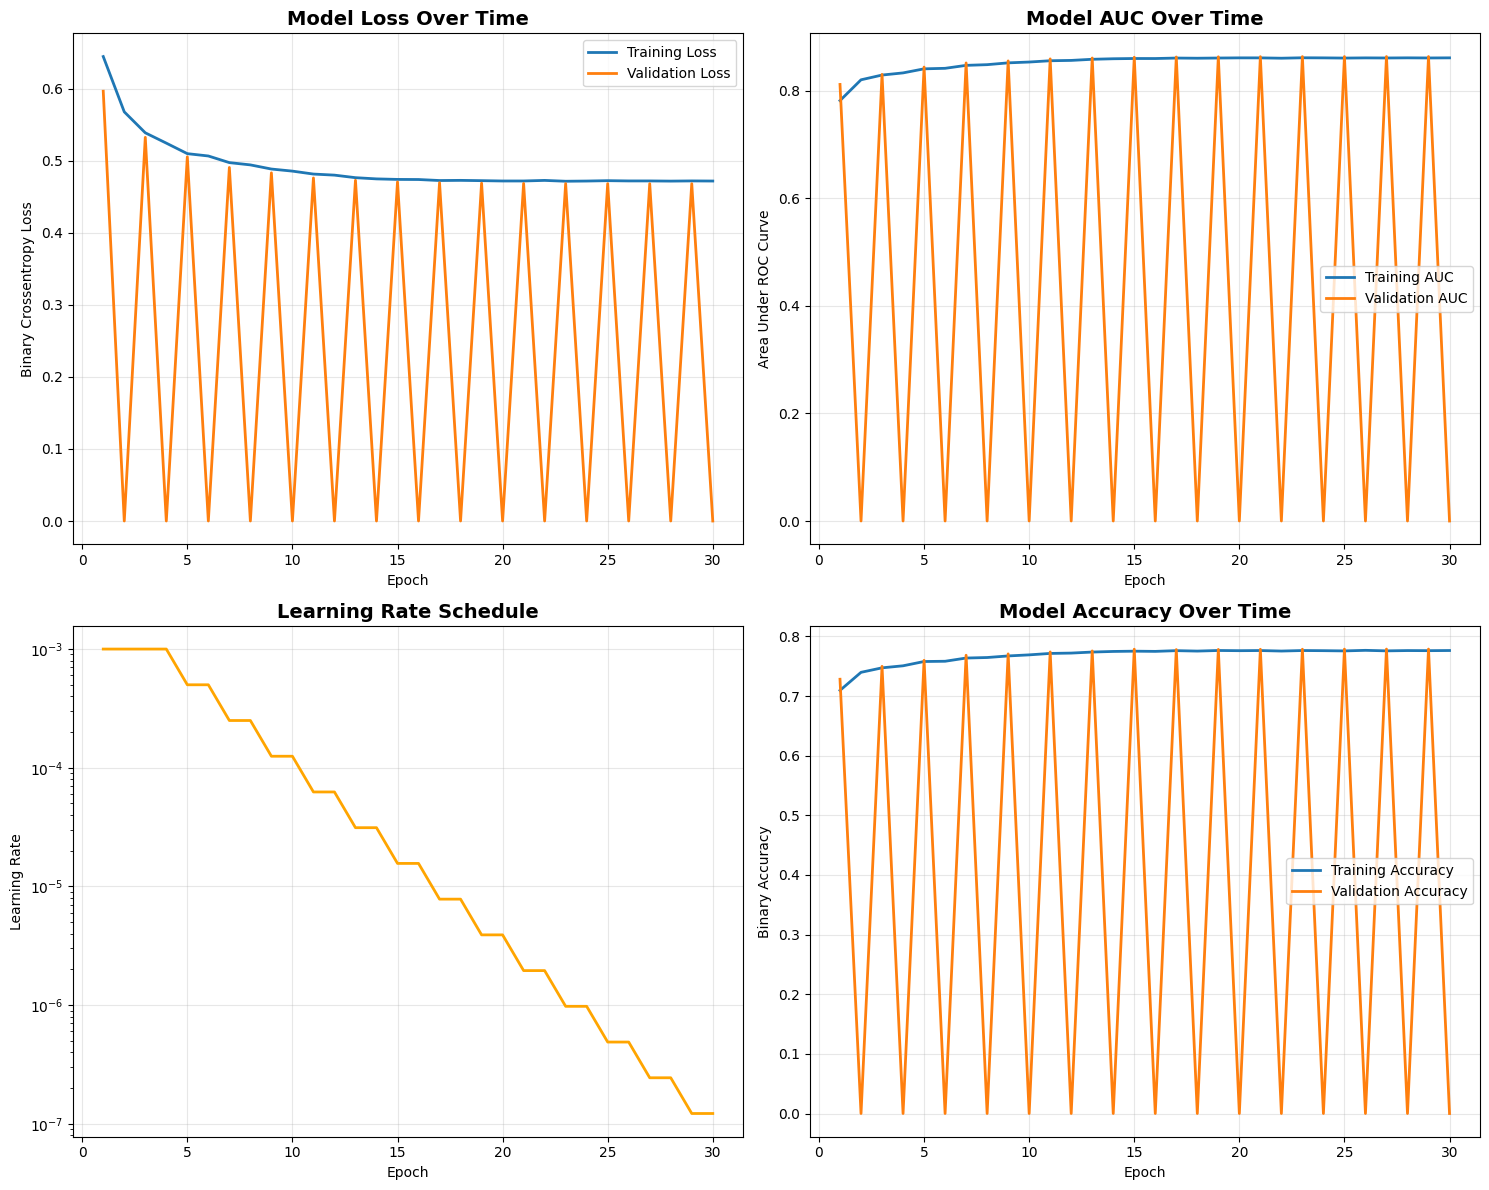

Training visualizations saved to 'training_history.png'


In [13]:
# Create comprehensive training visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(history_df['epoch'], history_df['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Crossentropy Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training and Validation AUC
axes[0, 1].plot(history_df['epoch'], history_df[auc_key], label='Training AUC', linewidth=2)
axes[0, 1].plot(history_df['epoch'], history_df[val_auc_key], label='Validation AUC', linewidth=2)
axes[0, 1].set_title('Model AUC Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Area Under ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
axes[1, 0].plot(history_df['epoch'], history_df[lr_key], linewidth=2, color='orange')
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Training and Validation Accuracy
axes[1, 1].plot(history_df['epoch'], history_df['binary_accuracy'], label='Training Accuracy', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_binary_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1, 1].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Binary Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training visualizations saved to 'training_history.png'")


In [14]:
# Model performance analysis
best_epoch = history_df[val_auc_key].idxmax() + 1
best_val_auc = history_df[val_auc_key].max()
best_val_accuracy = history_df.loc[history_df[val_auc_key].idxmax(), 'val_binary_accuracy']
final_lr = history_df[lr_key].iloc[-1]

print("Model Performance Summary")
print("=" * 40)
print(f"Best Validation AUC: {best_val_auc:.4f} (Epoch {best_epoch})")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Total Training Time: {len(history_df)} epochs")
print(f"Final Learning Rate: {final_lr:.2e}")

# Calculate training efficiency
total_samples_processed = len(history_df) * steps_per_epoch * batch_size
print(f"Total Samples Processed: {total_samples_processed:,}")

print("\nKey Insights:")
if best_val_auc > 0.85:
    print("Excellent performance! AUC > 0.85 indicates strong discriminative ability.")
elif best_val_auc > 0.80:
    print("Good performance! AUC > 0.80 shows the model can distinguish signal from background.")
elif best_val_auc > 0.75:
    print("Moderate performance. Consider hyperparameter tuning or feature engineering.")
else:
    print("Poor performance. Model may need architectural changes or more data.")

if len(history_df) < 10:
    print("Training stopped very early. Consider adjusting early stopping patience.")
elif len(history_df) >= 45:
    print("Training used most of the available epochs. Consider increasing max epochs.")


Model Performance Summary
Best Validation AUC: 0.8639 (Epoch 27)
Best Validation Accuracy: 0.7789
Total Training Time: 30 epochs
Final Learning Rate: 1.22e-07
Total Samples Processed: 329,809,920

Key Insights:
Excellent performance! AUC > 0.85 indicates strong discriminative ability.


## Model Architecture Analysis

### Wide & Deep Architecture Benefits:

1. **Wide Component**: The linear model captures feature interactions and provides memorization capabilities for frequent feature combinations.

2. **Deep Component**: The deep neural network learns complex, non-linear feature representations and generalizes to unseen feature combinations.

3. **Combined Strength**: The ensemble of both components balances memorization (wide) and generalization (deep) for optimal performance.

### Key Improvements in This Implementation:

1. **Input Normalization**: Integrated normalization layer ensures consistent feature scaling across all data.

2. **L2 Regularization**: Added to deep layers to prevent overfitting on the large parameter space.

3. **Enhanced Callbacks**: 
   - AUC-based early stopping for better classification performance monitoring
   - Conservative learning rate scheduling for training stability
   - Model checkpointing to save the best-performing model

4. **Modern Keras API**: Built with the functional API for better flexibility and maintainability.

### Physics Context:

The 28 input features represent kinematic properties of particle collision events:
- Lepton properties (energy, momentum, angles)
- Missing transverse energy (indicating neutrinos)
- Jet properties and counts
- Derived kinematic variables

High AUC scores indicate the model successfully learned to distinguish Higgs boson decay signatures from background Standard Model processes.

In [15]:
# Optional: Save final model and training history
try:
    # Save the final model (best weights are restored from checkpoint)
    wide_and_deep.save('final_higgs_model.keras')
    print("Final model saved to 'final_higgs_model.keras'")
    
    # Save training history
    history_df.to_csv('training_history.csv', index=False)
    print("Training history saved to 'training_history.csv'")
    
    # Generate and save the model architecture diagram
    tf.keras.utils.plot_model(
        wide_and_deep,
        to_file='wide_and_deep_model.png',
        show_shapes=True,
        show_layer_names=True
    )
    print("Model architecture diagram saved to 'wide_and_deep_model.png'")
    
    # Save model configuration summary
    config_summary = {
        'model_name': 'Wide & Deep Higgs Classifier',
        'total_parameters': wide_and_deep.count_params(),
        'best_val_auc': float(best_val_auc),
        'best_val_accuracy': float(best_val_accuracy),
        'training_epochs': len(history_df),
        'batch_size': batch_size,
        'learning_rate_initial': 0.001,
        'learning_rate_final': float(final_lr),
        'regularization_l2': 1e-5,
        'dropout_rate': DROPOUT,
        'units_per_layer': UNITS,
        'architecture': 'Wide & Deep with 5 dense layers'
    }
    
    import json
    with open('model_config.json', 'w') as f:
        json.dump(config_summary, f, indent=2)
    print("Model configuration saved to 'model_config.json'")
    
except Exception as e:
    print(f"Error saving files: {e}")

print("\nHiggs Boson Project Complete!")
print("\nFiles generated:")
print("  training_history.png - Training curves visualization")
print("  best_higgs_model.keras - Best model weights (saved during training)")
print("  final_higgs_model.keras - Final model state")
print("  training_history.csv - Complete training metrics")
print("  model_config.json - Model configuration summary")
print("  wide_and_deep_model.png - Model architecture diagram")


Final model saved to 'final_higgs_model.keras'
Training history saved to 'training_history.csv'
You must install pydot (`pip install pydot`) for `plot_model` to work.


Model architecture diagram saved to 'wide_and_deep_model.png'
Model configuration saved to 'model_config.json'

Higgs Boson Project Complete!

Files generated:
  training_history.png - Training curves visualization
  best_higgs_model.keras - Best model weights (saved during training)
  final_higgs_model.keras - Final model state
  training_history.csv - Complete training metrics
  model_config.json - Model configuration summary
  wide_and_deep_model.png - Model architecture diagram
